In [1]:
question_key = {
    'Some question would go here?': ['col1', 'col2', 'col3'],
    'Some other question': ['col5', 'col6']
}

current_selected_col = 'col5'

for k, v in question_key.items():
    if current_selected_col in v:
        print(k)

Some other question


In [2]:
import pandas as pd

from prepare import *
from acquire import *

import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split

from scipy import stats
from sklearn.linear_model import LinearRegression

#Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE

from prepare import *

In [3]:
#set seaborn color pallete
sns.set_palette('plasma')
pal = sns.set_palette('plasma')
palette = sns.color_palette().as_hex()

In [4]:
df, revert_key, replace_key = wrangle_data()

In [5]:
df.isnull().any()

qkey           False
device_type    False
language       False
form           False
attitude       False
               ...  
weight         False
is_pes         False
pes_val        False
is_very_pes    False
is_very_opt    False
Length: 128, dtype: bool

In [6]:
null_list = []
for col in df.columns:
    if df[col].isnull().any():
        null_list.append(col)

In [7]:
df[null_list].isnull().sum()

Series([], dtype: float64)

In [8]:
class Attitudes_explore():
    '''
    Performs a series of analyses and explore functions on various features in our data.
    '''
    
    def __init__(self, df):
        '''
        Initializes the self of the class.
        '''
        self.df =  df
        
 
        
    def printout_all_chi_squared(df, target_feature):
        '''
        This function loops through every categorical feature in the dataframe and runs a 
        chi-squared test with our target. The function then prints out the test results for 
        each feature.
        '''
        
        #Get list of categorical features
        categorical_features = df.drop(columns = ['qkey', "weight", target_feature]).columns.to_list()

        
        #Loop through categorical features
        for col in categorical_features:
            
            #Create contingency table
            contingency_table = pd.crosstab(df[col], df[target_feature])
            
            #Get test results of chi-squared test
            test_results = stats.chi2_contingency(contingency_table)

            #Print out results of chi-squared test for each column
            print("Correlation between", col, "and the target")
    
            print(test_results)
        
            #Space in between each feature for readability 
            print(" ")
    
    
    def printout_only_significant_p_value(df, target_feature):
        '''
        This function loops through every categorical feature in the dataframe and runs a 
        chi-squared test with out target. However, this function only prints out the results
        of the chi-squared test for the features which are shown to have a stastically significant
        relationship with the target. That is, the p-value of the chi-squared test is less than 0.5
        
        '''
        
        #Get list of categorical features
        categorical_features = df.drop(columns = ['qkey', "weight", target_feature]).columns.to_list()


        #Loop through every cateogiral feature
        for col in categorical_features:
    
            #Create contingency table
            contingency_table = pd.crosstab(df[col], df[target_feature])
            
            #Run a chi-squared test on the features
            chi2, p, degf, expected = stats.chi2_contingency(contingency_table)
            
            #Print out the results of the chi-squared test if significant
            if p < 0.05:
                print("Correlation between", col, "and the target")
    
                print(chi2, p, degf, expected)
       
                print(" ")
                    
            
    def get_list_of_significant_columns(df, target_feature):
        '''
        This function runs a chi-squared test on every categorical feature in the dataframe
        with the target variable. The function returns of list of features that have a stastically
        signficant relationship with the target
        '''
        #Get list of categorical features
        categorical_features = df.drop(columns = ['qkey', "weight", target_feature]).columns.to_list()

      
        #Make empty list of significant feature names
        significant_features = []
        
        #Loop through categorical features
        for col in categorical_features:
    
            #Create contigency table
            contingency_table = pd.crosstab(df[col], df[target_feature])
            
            #Get the results of the chi-squared test
            chi2, p, degf, expected = stats.chi2_contingency(contingency_table)
            
            #If p value is less than 0.05, append feature to list
            if p < 0.05:  
                
                significant_features.append(col)
        
        #Return list
        return(significant_features)
        
        
    def printout_insignificant_p_value(df, target_feature):
        '''
        This function loops through every categorical feature in the dataframe and runs a 
        chi-squared test with the target variable. If the chi-squared test reveals an
        insignificant relationship with the target, this function prints the result of the
        chi-squared test.
        '''
        #Get list of categorical features
        categorical_features = df.drop(columns = ['qkey', "weight", target_feature]).columns.to_list()


        #Loop through categorical features
        for col in categorical_features:
    
            #Create contingency table
            contingency_table = pd.crosstab(df[col], df[target_feature])

            #Run chi-squared test
            chi2, p, degf, expected = stats.chi2_contingency(contingency_table)
            
            #If p-value is greater than or equal to 0,05, print result of chi-sqared
            if p >= 0.05:
                print("Correlation between", col, "and the target")
    
                print(chi2, p, degf, expected)
       
                print(" ")
        
        
    def get_list_of_insignificant_columns(df, target_feature):
        '''
        This function loops through every categorical features and performs a chi-squared
        test with the target variable. If the chi-sqaured test reveals an insignificant 
        relationship with the target feature, the categorical feature is appended to a list
        of insignificant features.
        ''' 
        #Get list of categorical features
        categorical_features = df.drop(columns = ['qkey', "weight", target_feature]).columns.to_list()


        #Make list of insignificant features
        insignificant_features = []
        
        #Loop through categorical features
        for col in categorical_features:
    
            #Make contingency table
            contingency_table = pd.crosstab(df[col], df[target_feature])

            #Run chi-squared
            chi2, p, degf, expected = stats.chi2_contingency(contingency_table)
            
            #If p value is greater than or equal to 0.05, append feature to list.
            if p >= 0.05:
                
                insignificant_features.append(col)
            
        return(insignificant_features)
    
    
    def get_k_best(df, n, target_feature, columns_to_drop):
        '''
        This function takes a DataFrame and makes dummy variables.
        The function then splits the data into X, the predictive features, and y, the 
        target feature. It then runs Select K Best to determine the features most predictive
        of the target.
        
        Note: Since, we created dummies, the name of the target feature has _1 added to the end.
        '''
        
        df = df.drop([columns_to_drop])
        
        #Get dummies
        df_dummies = pd.get_dummies(df, drop_first = True)
        
        #Split X and y
        X, y = df_dummies.drop(columns = [target_feature, 'qkey']), df_dummies[target_feature]
        
        # Create model
        kbest = SelectKBest(f_regression, k=n)
        
        #Fit the model
        kbest.fit(X, y)
        
        #Return the most predictive columns
        return X.columns[kbest.get_support()]
    
    def get_recursive_features(df, n, target_feature, columns_to_drop):
        '''
        This function takes a DataFrame and makes dummy variables. 
        The function then splits teh data into X, the predictive features, and y, the target feature.
        It then runs Recursive Feature Elimination to determine the features most predictive of target.
        '''
        df = df.drop([columns_to_drop])
        
        #Get dummies
        df_dummies = pd.get_dummies(df, drop_first = True)
        
        #Split X and y
        X, y = df_dummies.drop(columns = [target_feature, 'qkey']), df_dummies[target_feature]
        
        #Create model
        rfe = RFE(estimator=LinearRegression(), n_features_to_select= n)
        #Fit the model
        rfe.fit(X, y)
        return X.columns[rfe.get_support()]
    
    def bar_plot(df, x_val, target):
        sns.barplot(x=x_val,y=target,data=df)
        plt.tight_layout()
        plt.show()
        
    def count_plot(df, col):
        plt.figure(figsize=(8,5))
        sns.countplot(x=col ,data=df)
        
        plt.tight_layout()
        plt.show()

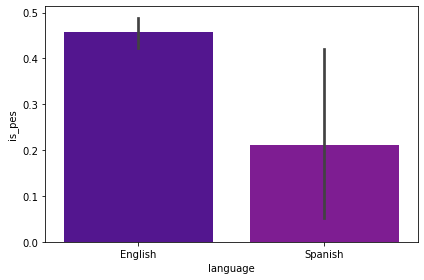

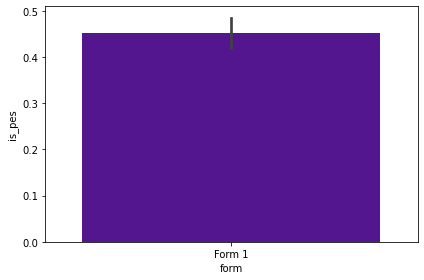

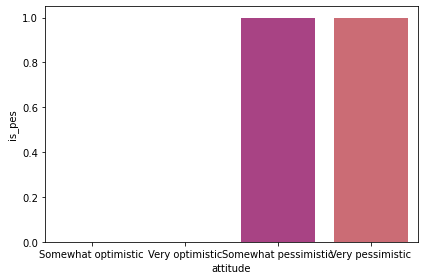

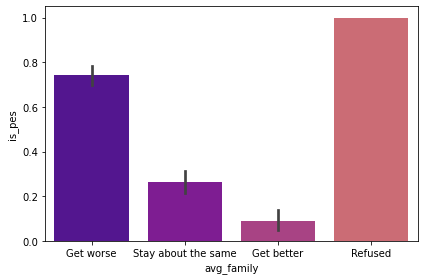

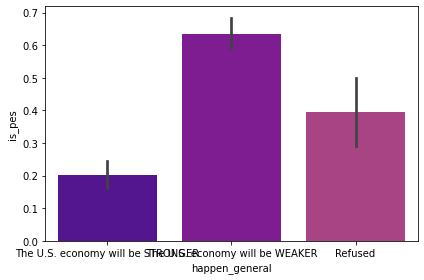

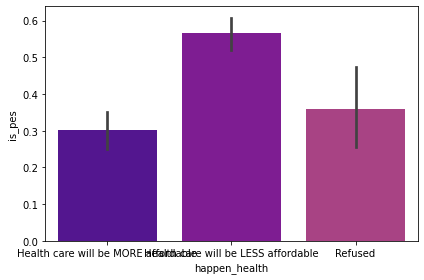

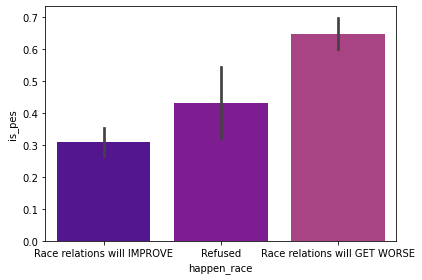

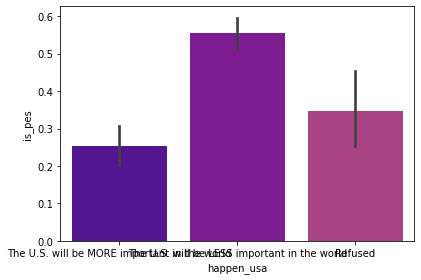

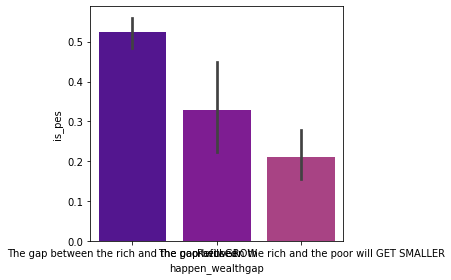

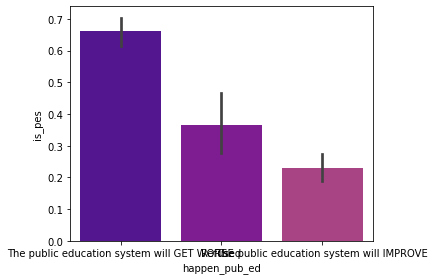

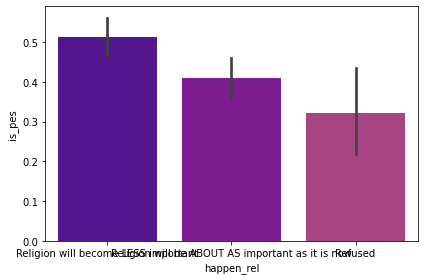

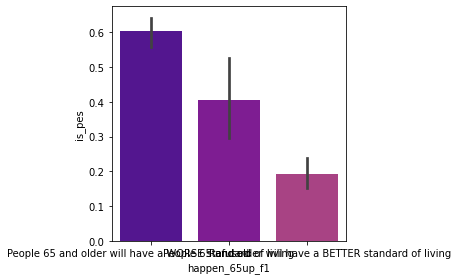

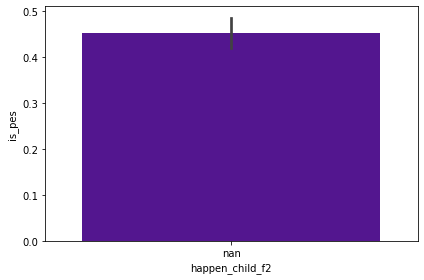

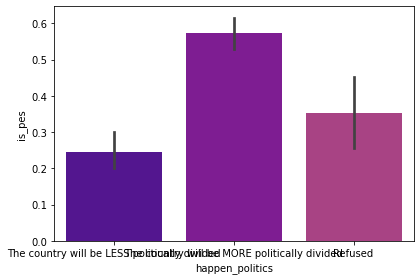

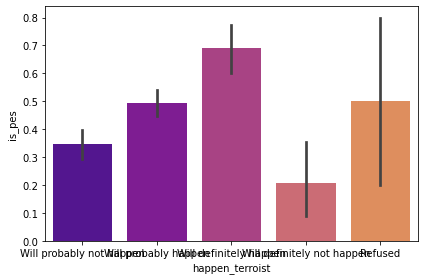

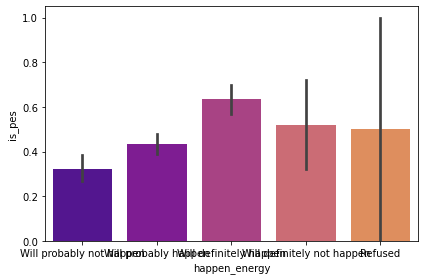

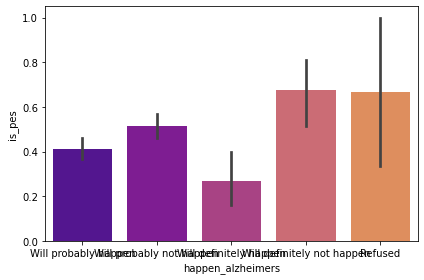

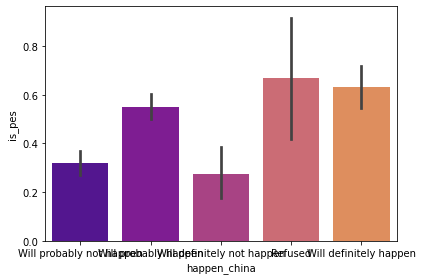

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [9]:
[Attitudes_explore.bar_plot(df[(df.political_party_identity!='Republican') & (df.form=='Form 1')], col, 'is_pes') for col in df[df.columns[2:20]]]

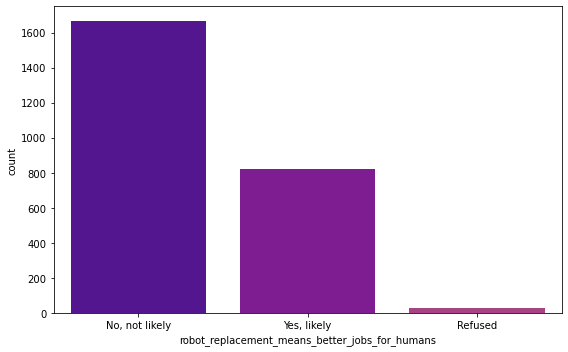

In [10]:
Attitudes_explore.count_plot(df, 'robot_replacement_means_better_jobs_for_humans')

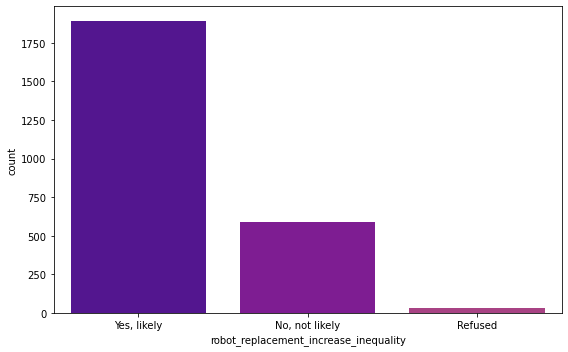

In [11]:
Attitudes_explore.count_plot(df, 'robot_replacement_increase_inequality')

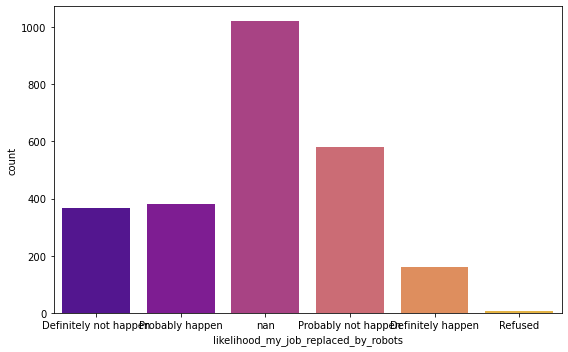

In [12]:
Attitudes_explore.count_plot(df, 'likelihood_my_job_replaced_by_robots')

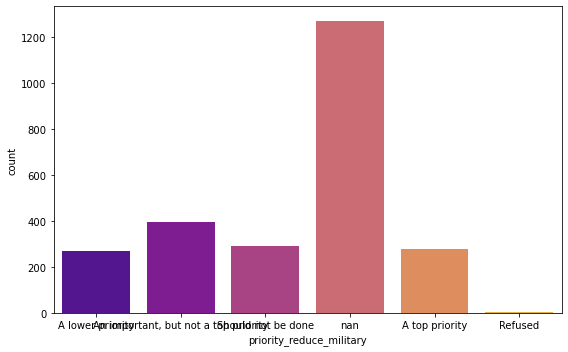

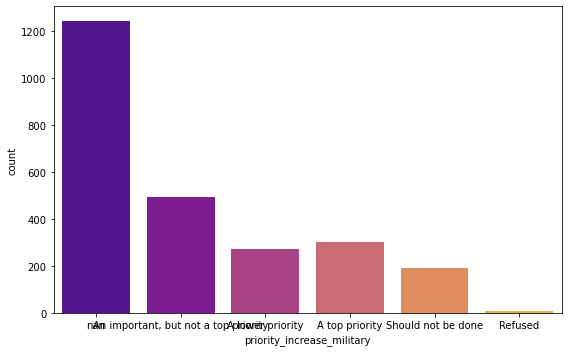

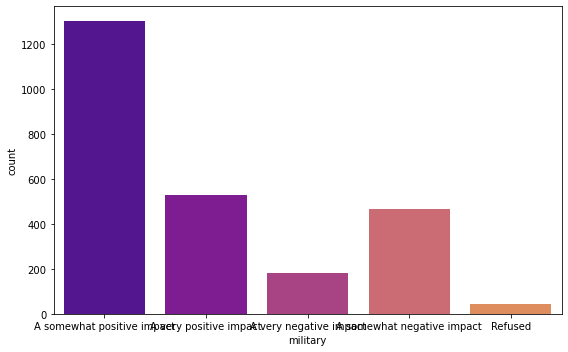

[None, None, None]

In [13]:
[Attitudes_explore.count_plot(df, col) for col in ['priority_reduce_military', 'priority_increase_military', 'military']]

In [14]:
df.age.value_counts()

30-49     813
50-64     748
65+       558
18-29     393
DK/REF      3
Name: age, dtype: int64

In [15]:
df[(df.age=='50-64') | (df.age=='65+')]

qkey   device_type language    form              attitude  \
1           101224  Mobile phone  English  Form 1   Somewhat optimistic   
2           101437       Desktop  English  Form 1  Somewhat pessimistic   
3           102130  Mobile phone  English  Form 1   Somewhat optimistic   
5           103538       Desktop  English  Form 1   Somewhat optimistic   
6           103611  Mobile phone  English  Form 2       Very optimistic   
...            ...           ...      ...     ...                   ...   
2514  201801188351  Mobile phone  English  Form 1  Somewhat pessimistic   
2516  201801188508       Desktop  English  Form 1  Somewhat pessimistic   
2517  201801188643  Mobile phone  English  Form 2      Very pessimistic   
2518  201801188901  Mobile phone  English  Form 2   Somewhat optimistic   
2521  201801189130        Tablet  English  Form 1   Somewhat optimistic   

               avg_family                     happen_general  \
1              Get better  The U.S. economy will be STRONGER   
2               Get worse    The U.S. economy will be WEAKER   
3     Stay about the same    The U.S. economy will be WEAKER   
5              Get better  The U.S. economy will be STRONGER   
6              Get better  The U.S. economy will be STRONGER   
...                   ...                                ...   
2514  Stay about the same    The U.S. economy will be WEAKER   
2516            Get worse    The U.S. economy will be WEAKER   
2517            Get worse    The U.S. economy will be WEAKER   
2518  Stay about the same    The U.S. economy will be WEAKER   
2521  Stay about the same  The U.S. economy will be STRONGER   

                            happen_health                    happen_race  \
1     Health care will be LESS affordable    Race relations will IMPROVE   
2     Health care will be LESS affordable  Race relations will GET WORSE   
3     Health care will be LESS affordable    Race relations will IMPROVE   
5     Health care will be MORE affordable  Race relations will GET WORSE   
6     Health care will be LESS affordable    Race relations will IMPROVE   
...                                   ...                            ...   
2514  Health care will be MORE affordable  Race relations will GET WORSE   
2516  Health care will be MORE affordable    Race relations will IMPROVE   
2517  Health care will be LESS affordable  Race relations will GET WORSE   
2518  Health care will be MORE affordable    Race relations will IMPROVE   
2521  Health care will be MORE affordable    Race relations will IMPROVE   

                                        happen_usa  ...  \
1     The U.S. will be MORE important in the world  ...   
2     The U.S. will be LESS important in the world  ...   
3     The U.S. will be LESS important in the world  ...   
5     The U.S. will be LESS important in the world  ...   
6     The U.S. will be LESS important in the world  ...   
...                                            ...  ...   
2514                                       Refused  ...   
2516  The U.S. will be LESS important in the world  ...   
2517  The U.S. will be LESS important in the world  ...   
2518  The U.S. will be LESS important in the world  ...   
2521  The U.S. will be LESS important in the world  ...   

     family_income_three_categories  \
1                       $30-$74,999   
2                          <$30,000   
3                Don't know/Refused   
5                          $75,000+   
6                          <$30,000   
...                             ...   
2514                       <$30,000   
2516                       $75,000+   
2517                    $30-$74,999   
2518                       <$30,000   
2521                       <$30,000   

                                     registered_to_vote    political_views  \
1     You are ABSOLUTELY CERTAIN that you are regist...       Conservative   
2     You are ABSOLUTELY CERTAIN that you are regist...       Conservative   
3     You are ABSOL

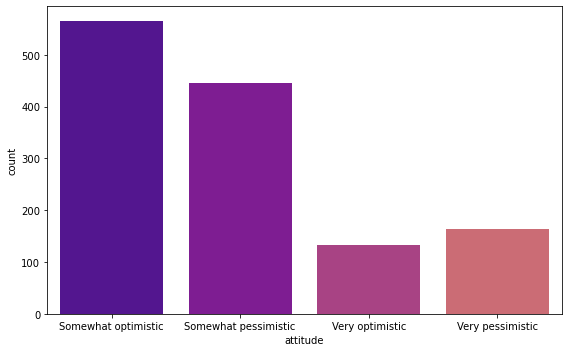

In [16]:
Attitudes_explore.count_plot(df[(df.age=='50-64') | (df.age=='65+')], 'attitude')#.replace(replace_key), 'attitude')

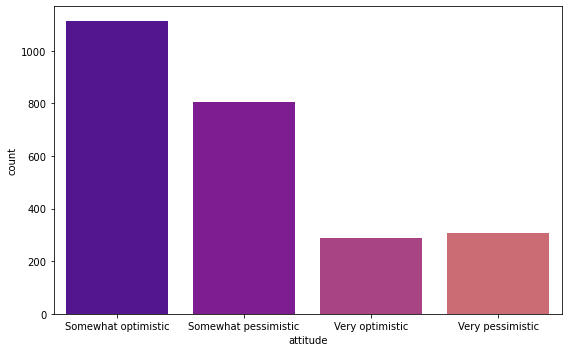

In [17]:
Attitudes_explore.count_plot(df[~(df.age=='50-64') | ~(df.age=='65+')], 'attitude')#.replace(replace_key), 'attitude')

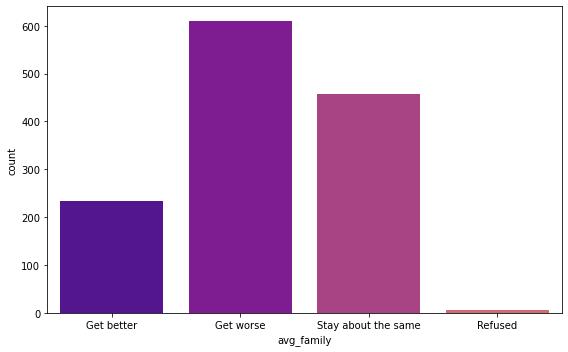

In [18]:
Attitudes_explore.count_plot(df[(df.age=='50-64') | (df.age=='65+')], 'avg_family')#.replace(replace_key), 'attitude')

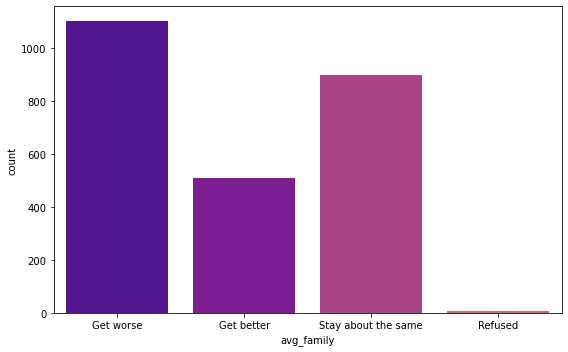

In [19]:
Attitudes_explore.count_plot(df[~(df.age=='50-64') | ~(df.age=='65+')], 'avg_family')#.replace(replace_key), 'attitude')

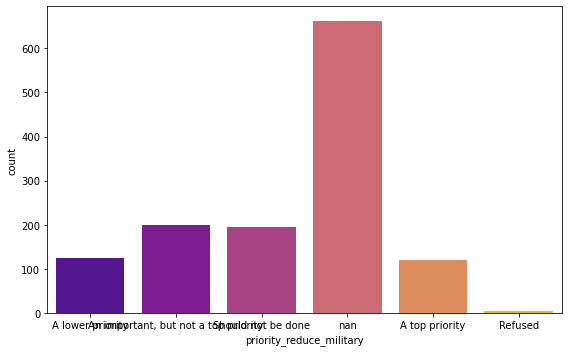

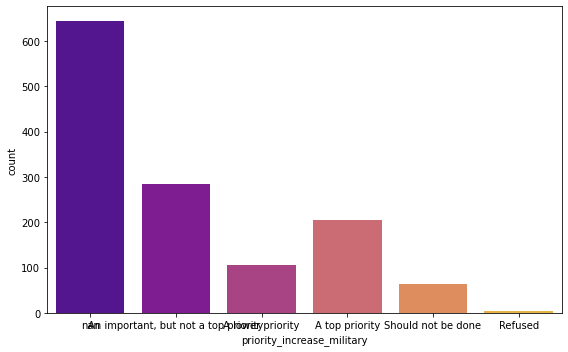

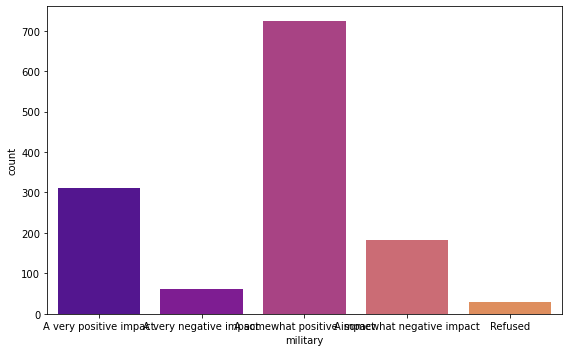

[None, None, None]

In [20]:
[Attitudes_explore.count_plot(df[(df.age=='50-64') | (df.age=='65+')], col) for col in ['priority_reduce_military', 'priority_increase_military', 'military']]

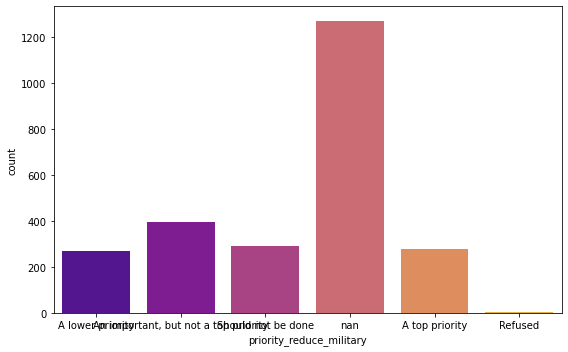

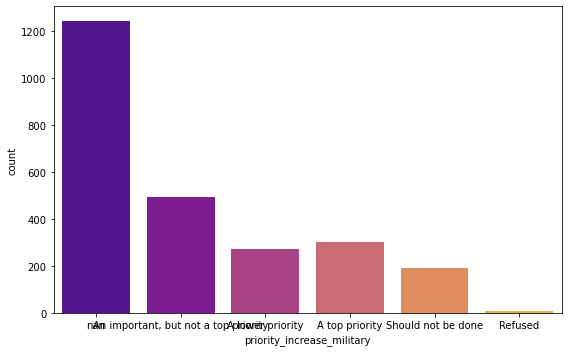

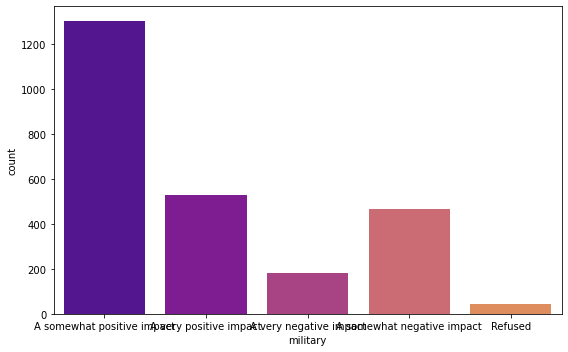

[None, None, None]

In [21]:
[Attitudes_explore.count_plot(df[~(df.age=='50-64') | ~(df.age=='65+')], col) for col in ['priority_reduce_military', 'priority_increase_military', 'military']]

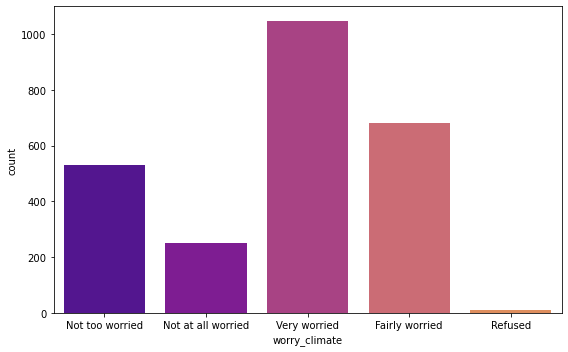

In [22]:
Attitudes_explore.count_plot(df[~(df.age=='50-64') | ~(df .age=='65+')], 'worry_climate')

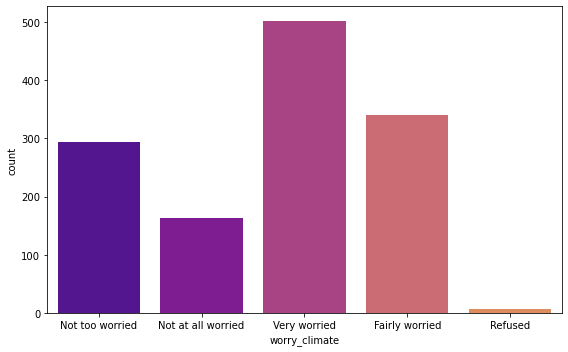

In [23]:
Attitudes_explore.count_plot(df[(df.age=='50-64') | (df.age=='65+')], 'worry_climate')

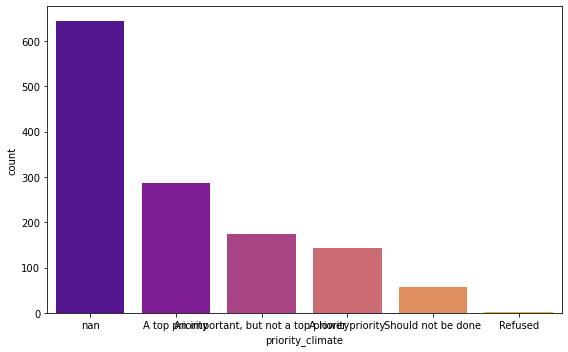

In [24]:
Attitudes_explore.count_plot(df[(df.age=='50-64') | (df.age=='65+')], 'priority_climate')

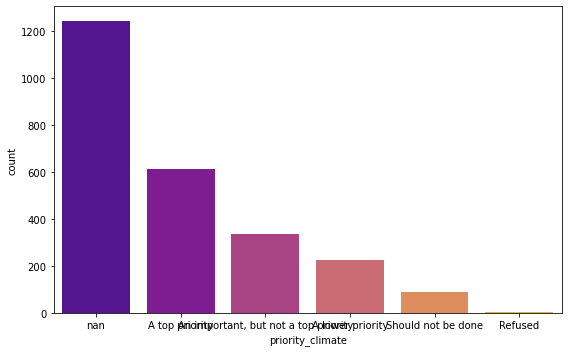

In [25]:
Attitudes_explore.count_plot(df[~(df.age=='50-64') | ~(df.age=='65+')], 'priority_climate')

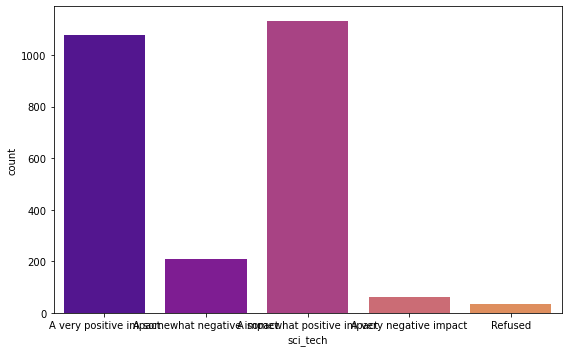

In [26]:
Attitudes_explore.count_plot(df[~(df.age=='50-64') | ~(df.age=='65+')], 'sci_tech')

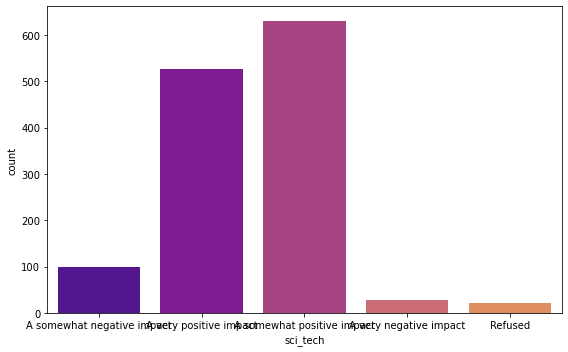

In [27]:
Attitudes_explore.count_plot(df[(df.age=='50-64') | (df.age=='65+')], 'sci_tech')

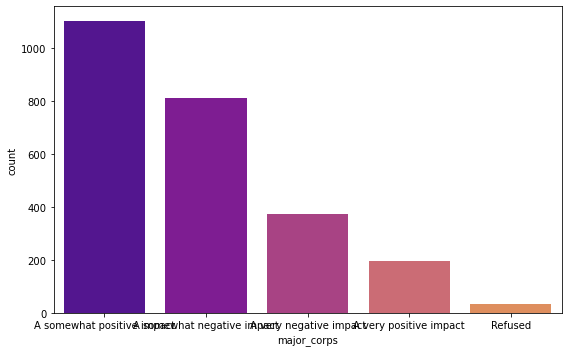

In [28]:
Attitudes_explore.count_plot(df[~(df.age=='50-64') | ~(df.age=='65+')], 'major_corps')

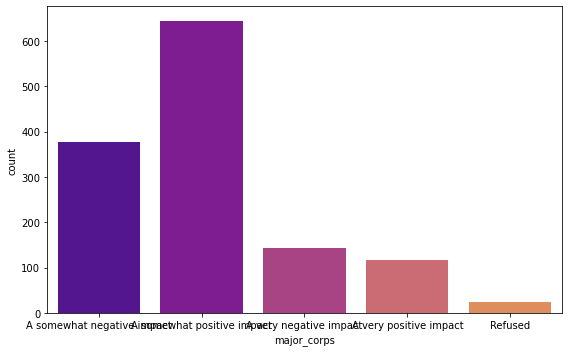

In [29]:
Attitudes_explore.count_plot(df[(df.age=='50-64') | (df.age=='65+')], 'major_corps')

In [30]:
df.columns, \
df.age.value_counts()

(Index(['qkey', 'device_type', 'language', 'form', 'attitude', 'avg_family',
        'happen_general', 'happen_health', 'happen_race', 'happen_usa',
        ...
        'family_income_three_categories', 'registered_to_vote',
        'political_views', 'internet_access', 'volunteer', 'weight', 'is_pes',
        'pes_val', 'is_very_pes', 'is_very_opt'],
       dtype='object', length=128),
 30-49     813
 50-64     748
 65+       558
 18-29     393
 DK/REF      3
 Name: age, dtype: int64)

In [31]:
df[~((df.age=='50-64') | (df.age=='65+'))]

qkey   device_type language    form              attitude  \
0           100363  Mobile phone  English  Form 1   Somewhat optimistic   
4           103094  Mobile phone  English  Form 1   Somewhat optimistic   
23          120118  Mobile phone  English  Form 2   Somewhat optimistic   
26          124895  Mobile phone  English  Form 2       Very optimistic   
31          128214  Mobile phone  English  Form 1   Somewhat optimistic   
...            ...           ...      ...     ...                   ...   
2515  201801188478       Desktop  English  Form 1  Somewhat pessimistic   
2519  201801188933       Desktop  English  Form 1  Somewhat pessimistic   
2520  201801189002  Mobile phone  English  Form 2  Somewhat pessimistic   
2522  201801189171       Desktop  English  Form 1       Very optimistic   
2523  201801189173       Desktop  English  Form 1      Very pessimistic   

               avg_family                     happen_general  \
0               Get worse  The U.S. economy will be STRONGER   
4     Stay about the same                            Refused   
23              Get worse    The U.S. economy will be WEAKER   
26             Get better  The U.S. economy will be STRONGER   
31             Get better  The U.S. economy will be STRONGER   
...                   ...                                ...   
2515            Get worse    The U.S. economy will be WEAKER   
2519            Get worse    The U.S. economy will be WEAKER   
2520            Get worse  The U.S. economy will be STRONGER   
2522           Get better  The U.S. economy will be STRONGER   
2523            Get worse    The U.S. economy will be WEAKER   

                            happen_health                    happen_race  \
0     Health care will be MORE affordable    Race relations will IMPROVE   
4     Health care will be LESS affordable                        Refused   
23    Health care will be MORE affordable  Race relations will GET WORSE   
26    Health care will be MORE affordable    Race relations will IMPROVE   
31    Health care will be MORE affordable  Race relations will GET WORSE   
...                                   ...                            ...   
2515  Health care will be LESS affordable    Race relations will IMPROVE   
2519  Health care will be LESS affordable    Race relations will IMPROVE   
2520  Health care will be LESS affordable    Race relations will IMPROVE   
2522  Health care will be LESS affordable    Race relations will IMPROVE   
2523  Health care will be MORE affordable    Race relations will IMPROVE   

                                        happen_usa  ...  \
0     The U.S. will be MORE important in the world  ...   
4     The U.S. will be LESS important in the world  ...   
23    The U.S. will be LESS important in the world  ...   
26                                         Refused  ...   
31    The U.S. will be MORE important in the world  ...   
...                                            ...  ...   
2515  The U.S. will be LESS important in the world  ...   
2519  The U.S. will be LESS important in the world  ...   
2520  The U.S. will be MORE important in the world  ...   
2522  The U.S. will be MORE important in the world  ...   
2523  The U.S. will be LESS important in the world  ...   

     family_income_three_categories  \
0                          $75,000+   
4                          <$30,000   
23                      $30-$74,999   
26                         $75,000+   
31                      $30-$74,999   
...                             ...   
2515                       $75,000+   
2519                       <$30,000   
2520                    $30-$74,999   
2522                       $75,000+   
2523                    $30-$74,999   

                                     registered_to_vote political_views  \
0     You are ABSOLUTELY CERTAIN that you are regist...         Liberal   
4     You are NOT registered to vote at your current...         Liberal   
23    You are ABSOLUTELY CER

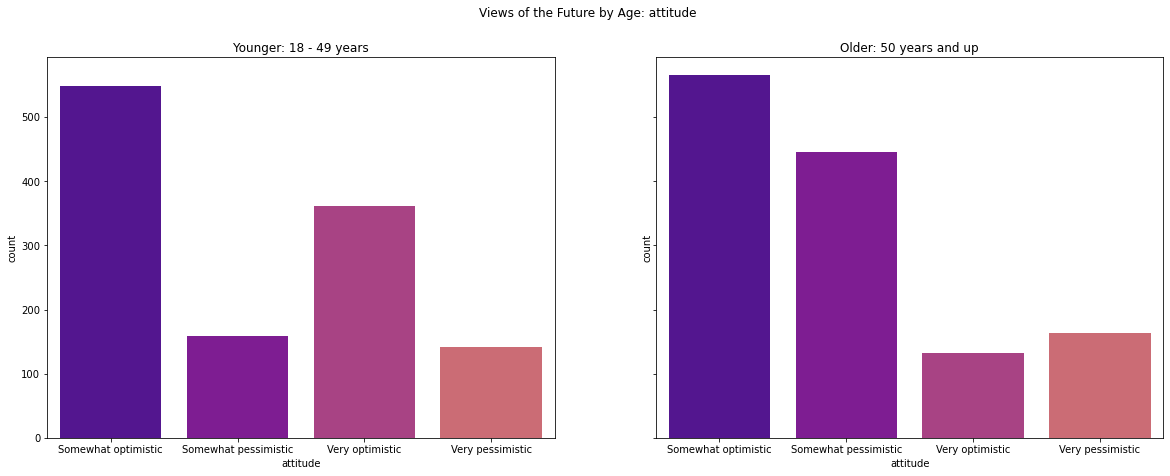

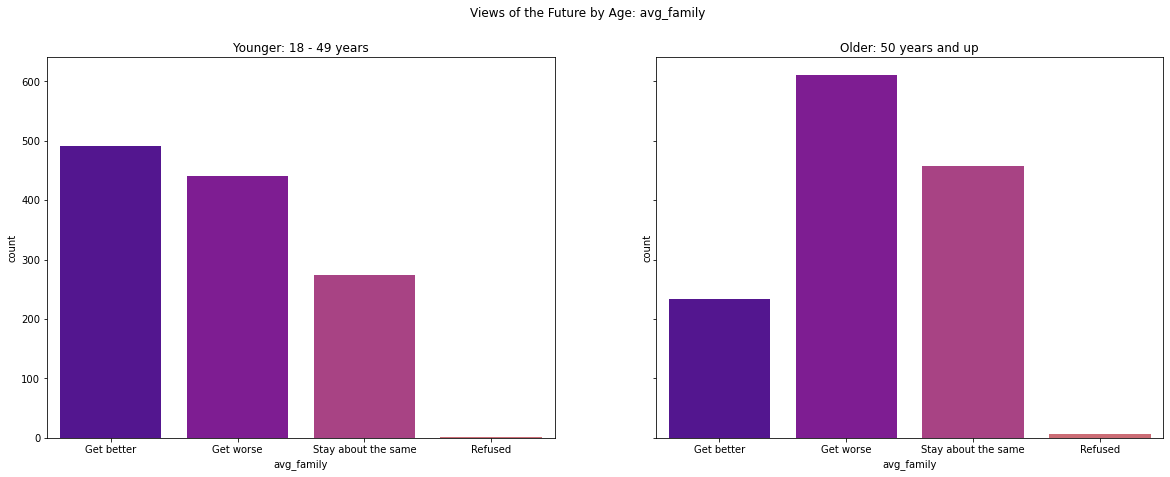

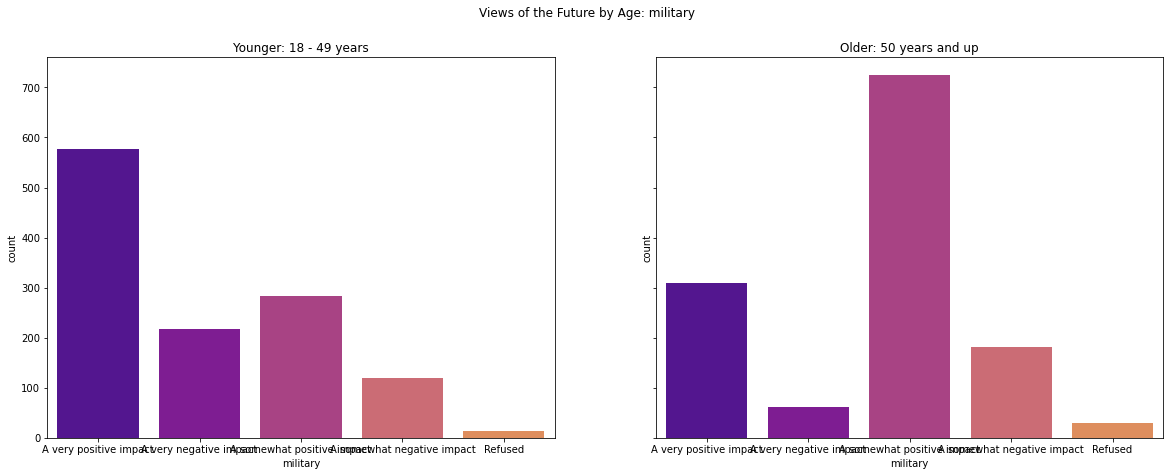

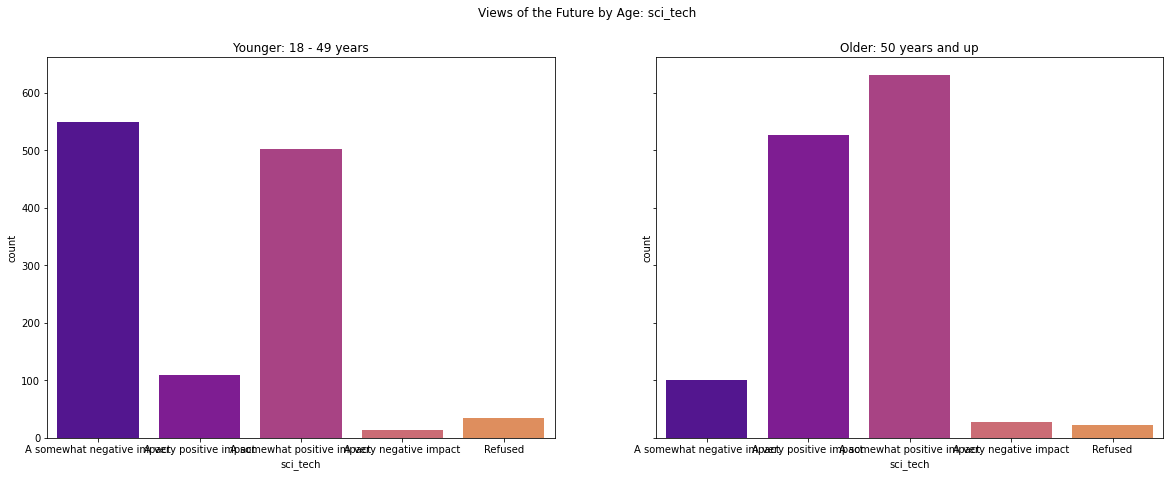

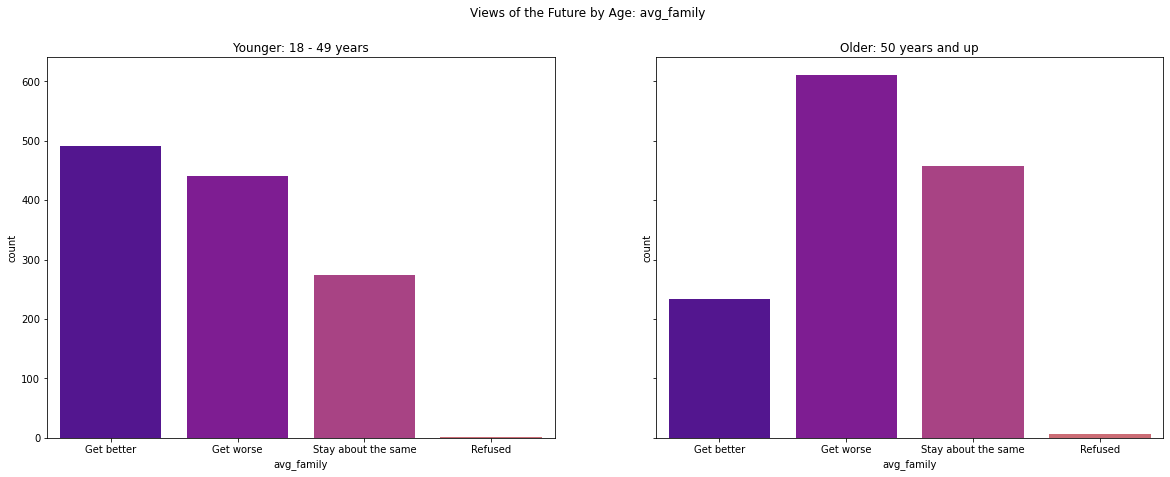

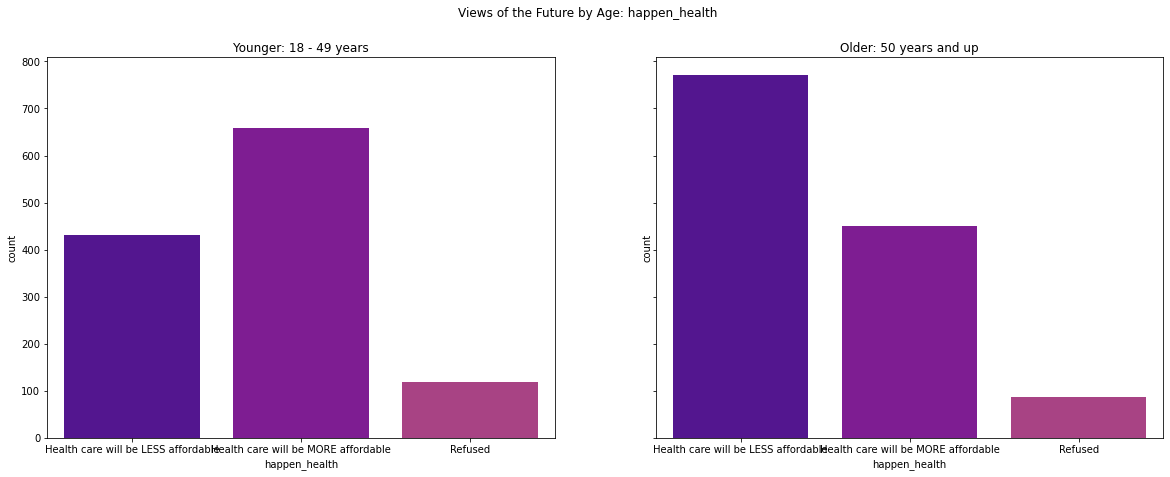

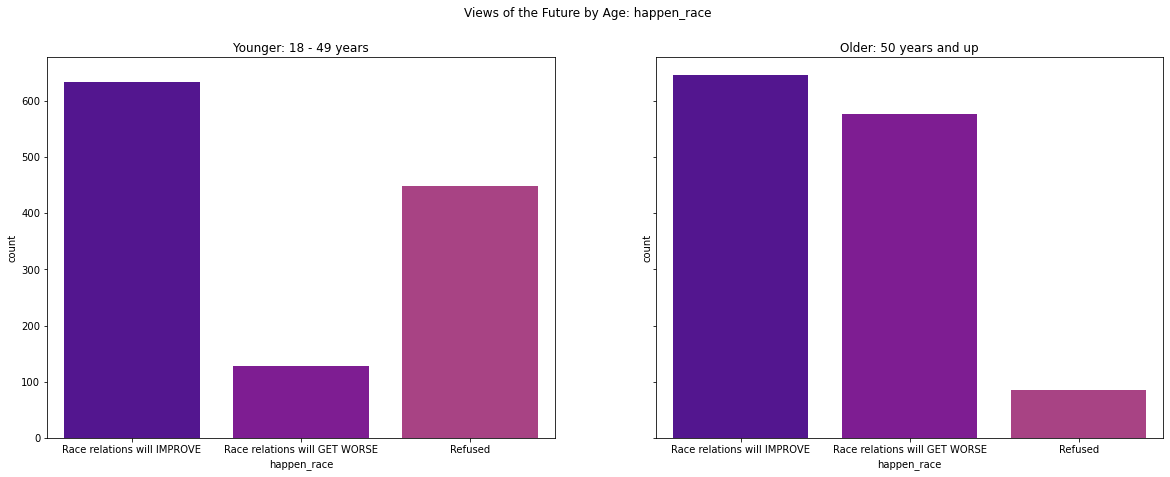

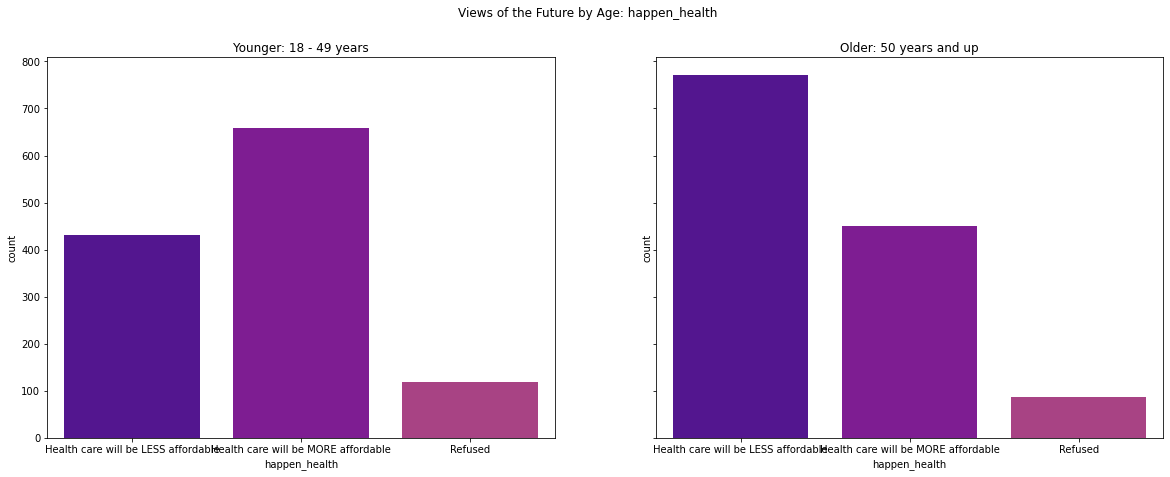

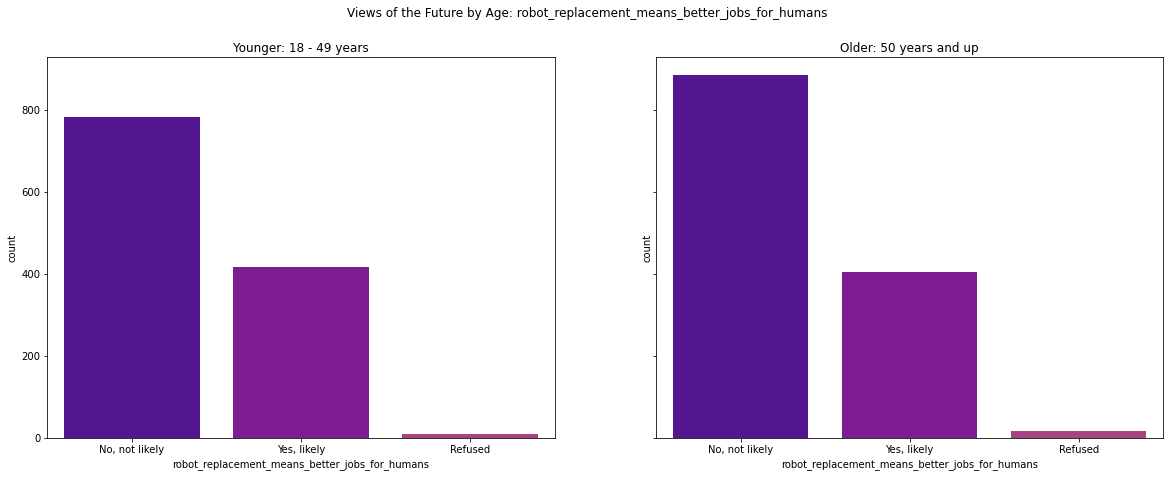

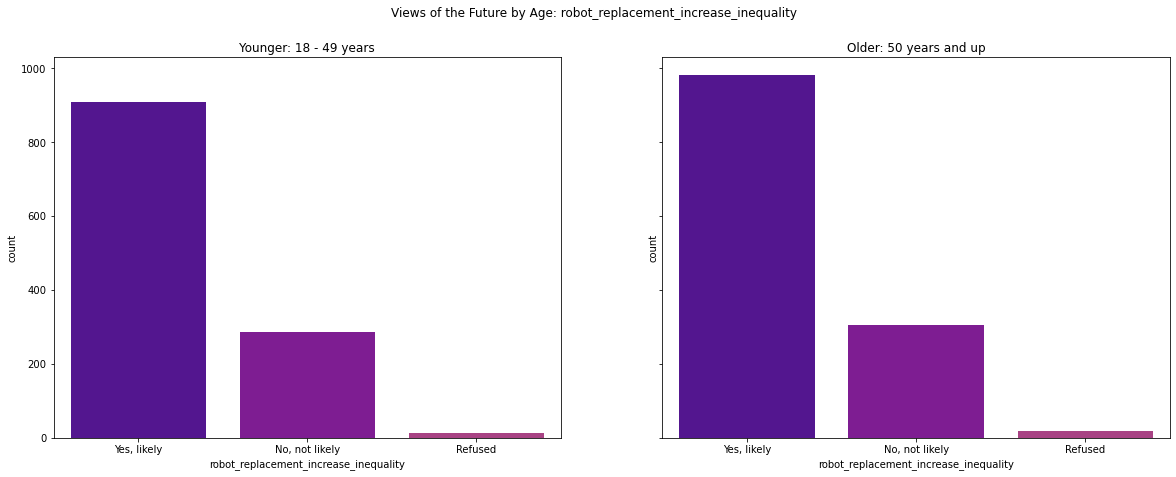

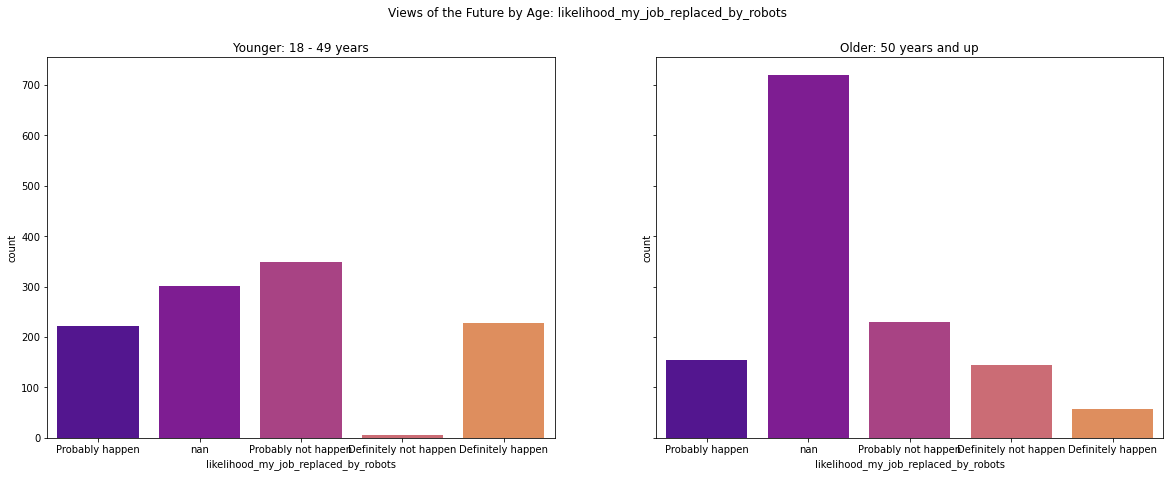

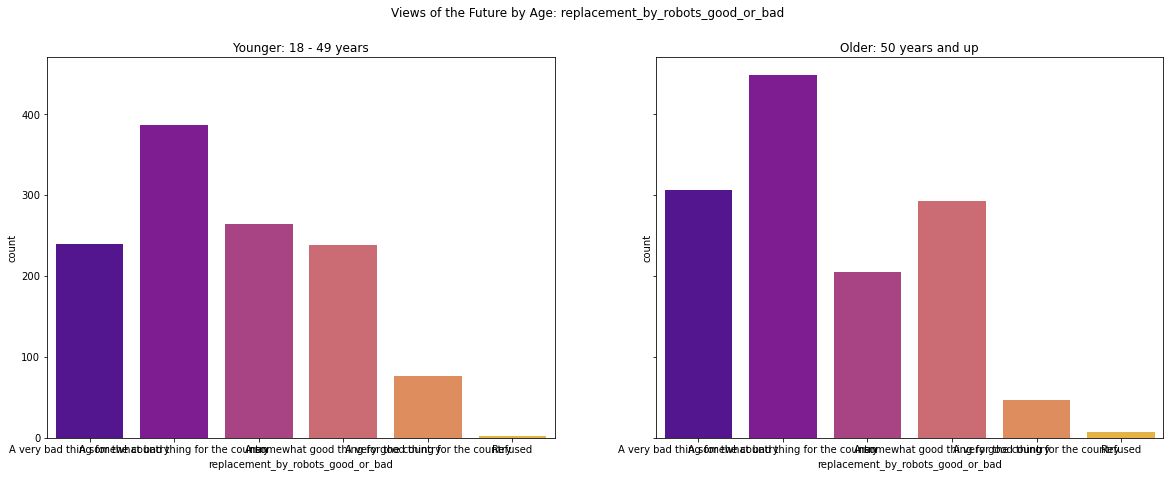

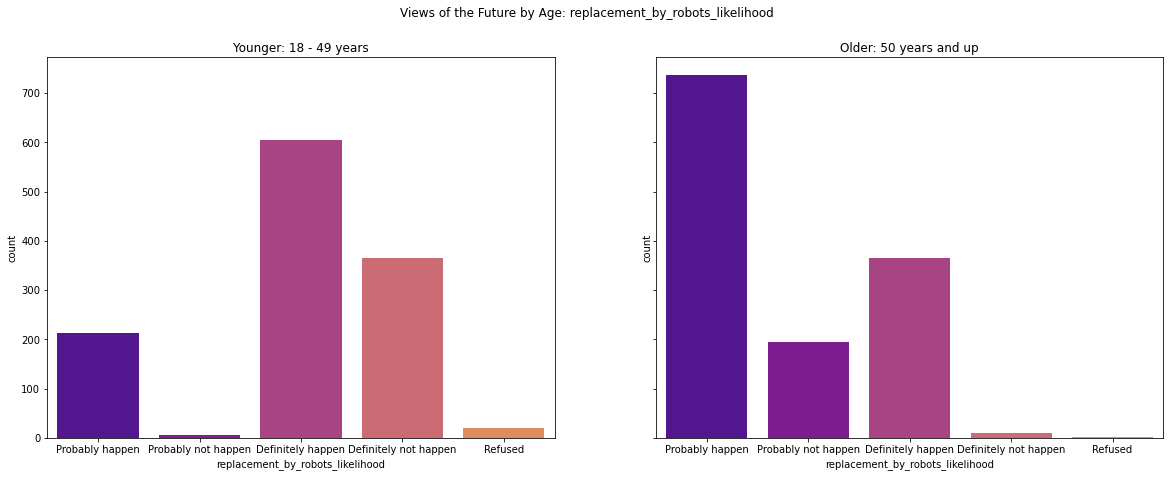

In [32]:
for col in ['attitude', 'avg_family', 'military', 'sci_tech', 'avg_family', 'happen_health', 'happen_race', 'happen_health', 
            'robot_replacement_means_better_jobs_for_humans', 'robot_replacement_increase_inequality', 
            'likelihood_my_job_replaced_by_robots', 'replacement_by_robots_good_or_bad', 'replacement_by_robots_likelihood']:
    # Set number of subplots, format (1 row and 2 cols), share Y axis, set figure size of subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True,  figsize=(20,7))
    
    # Set suptitle
    fig.suptitle(f'Views of the Future by Age: {col}')
    
    # First plot and its title
    sns.countplot(data=df[~((df.age=='50-64') | (df.age=='65+'))], x=col, ax=axes[0])
    axes[0].set_title('Younger: 18 - 49 years')
    
    # Second plot and its title
    sns.countplot(data=df[(df.age=='50-64') | (df.age=='65+')], x=col, ax=axes[1])
    axes[1].set_title('Older: 50 years and up')
    
    plt.show()
        

In [33]:
df[((df.highest_education_six_categories=='College graduate/some post grad') | (df.highest_education_six_categories=='Postgraduate') | (df.highest_education_six_categories=='Some college, no degree'))].shape

(1369, 128)

In [34]:
df[~((df.highest_education_six_categories=='College graduate/some post grad') | (df.highest_education_six_categories=='Postgraduate') | (df.highest_education_six_categories=='Some college, no degree'))].shape

(1146, 128)

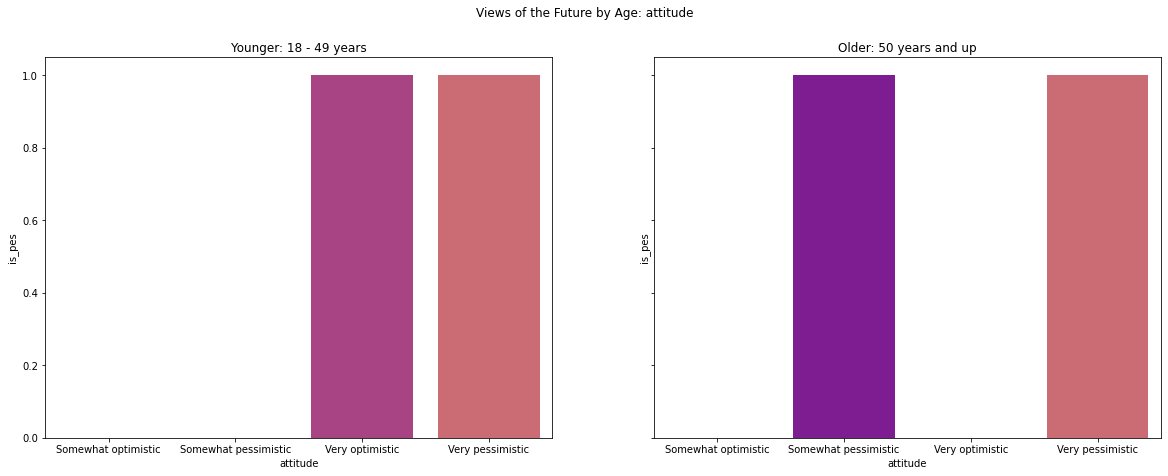

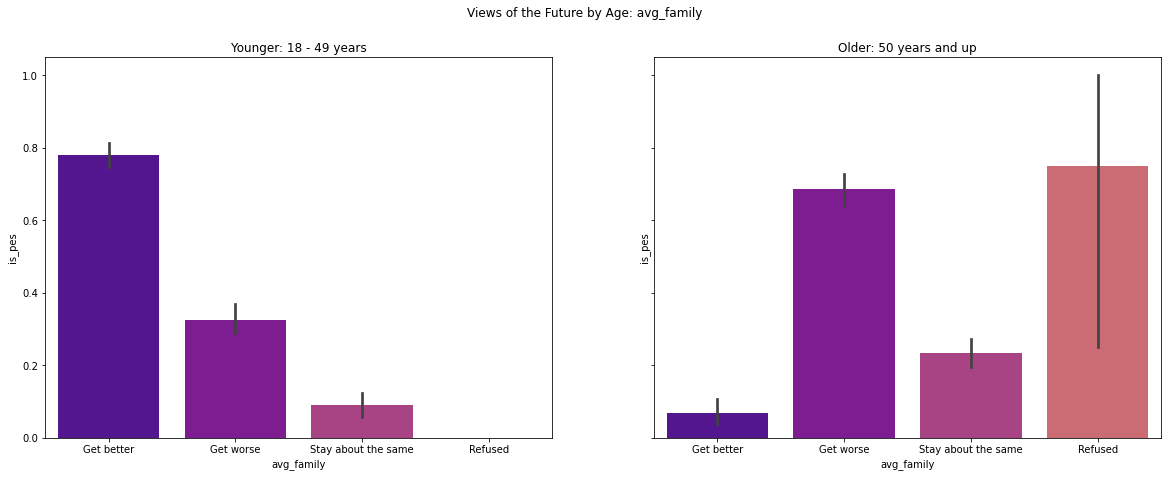

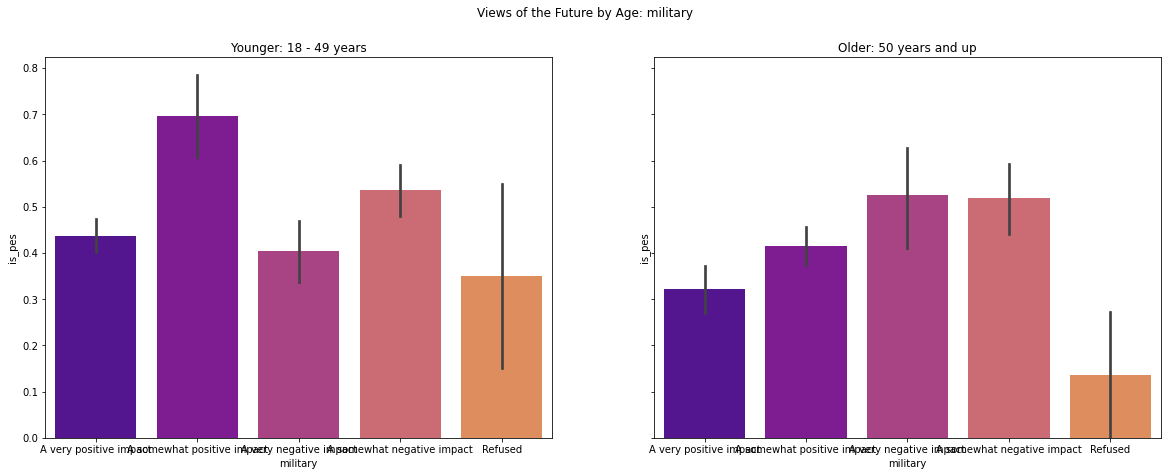

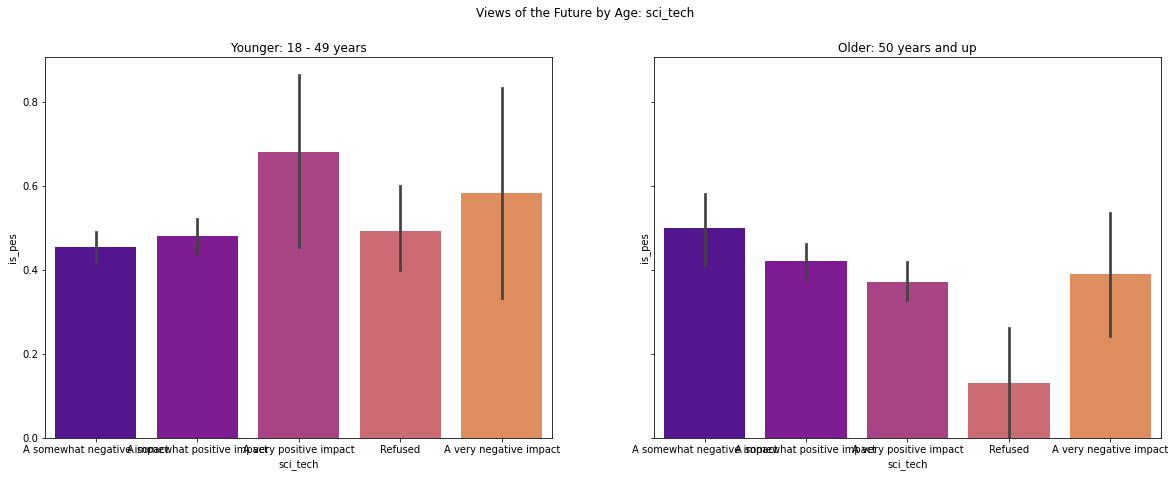

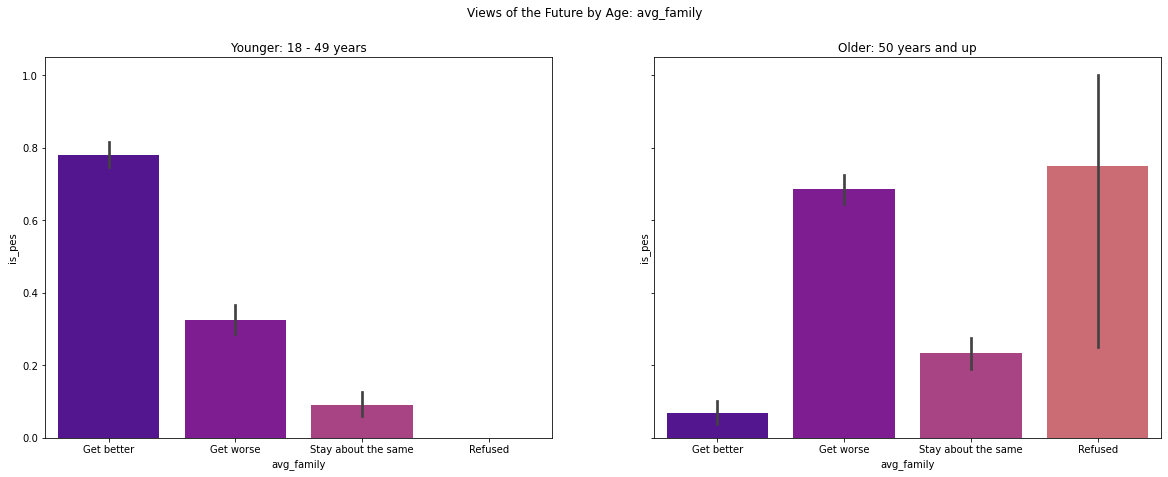

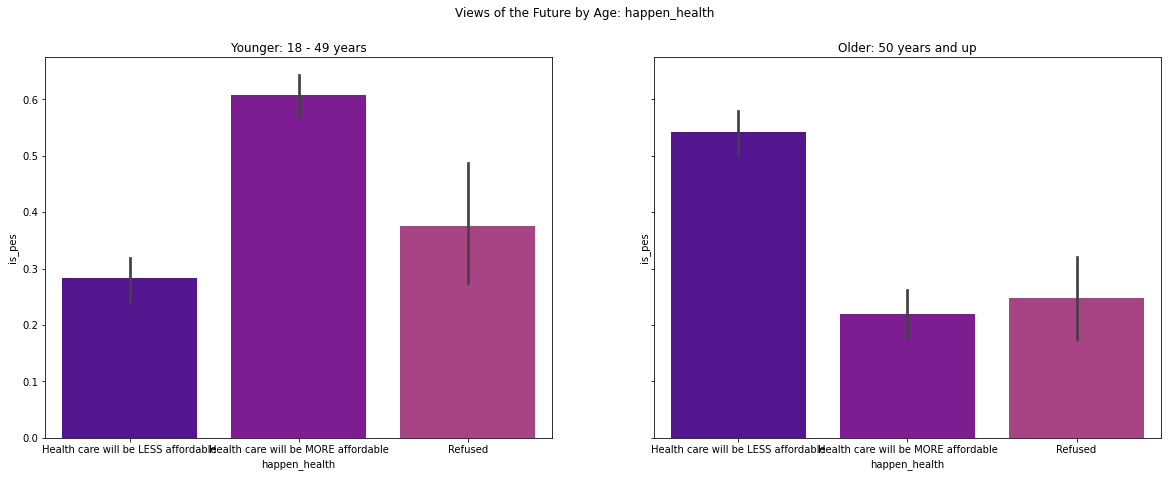

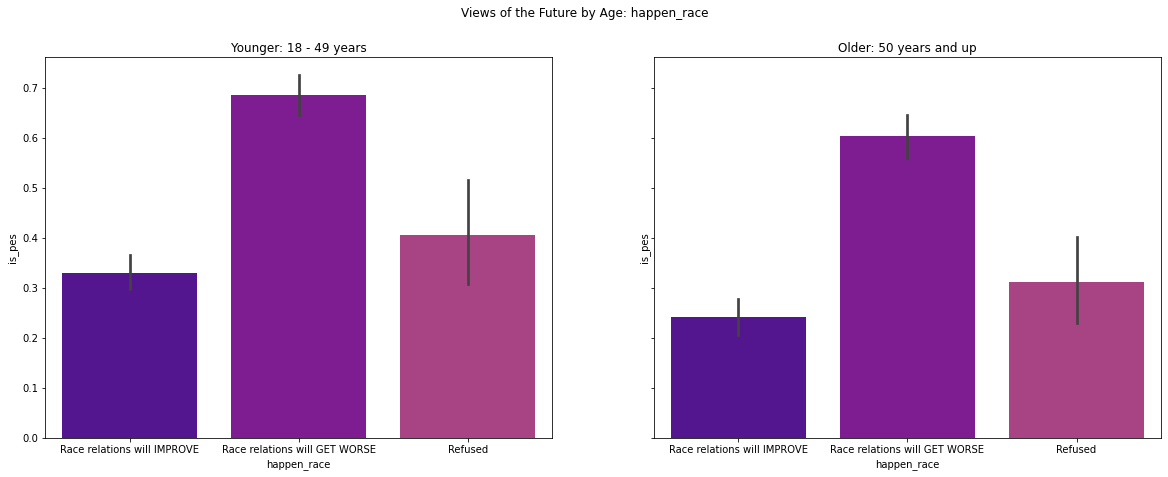

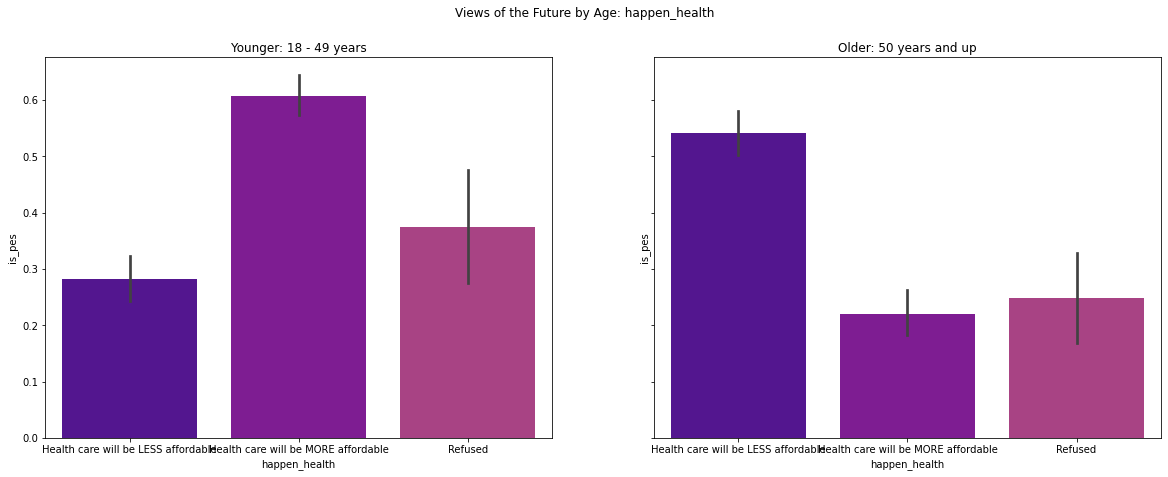

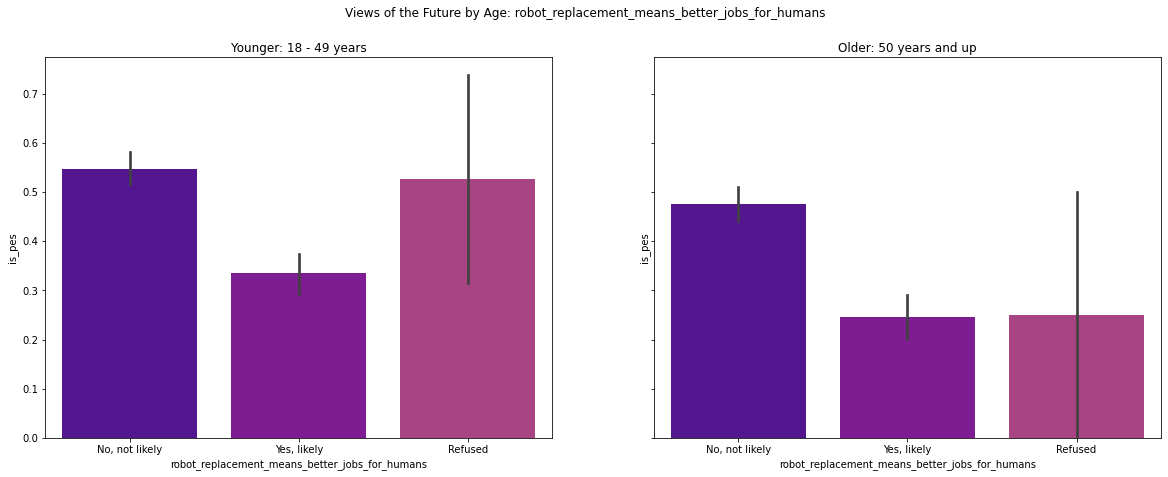

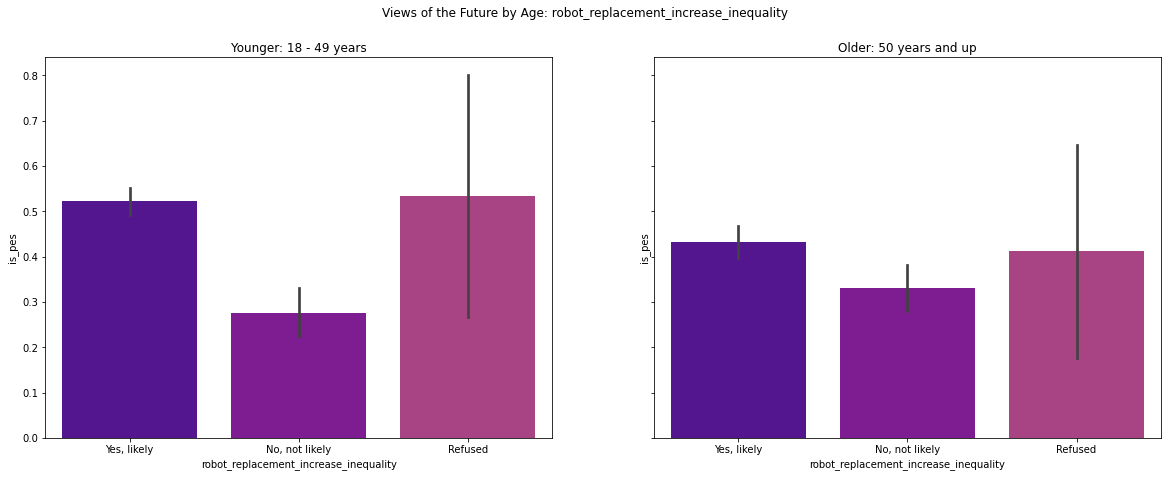

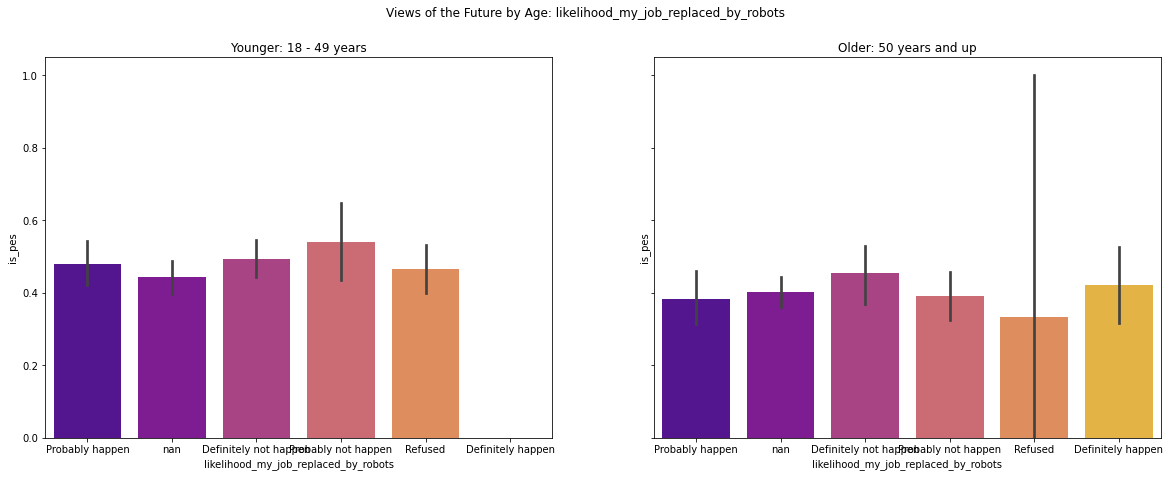

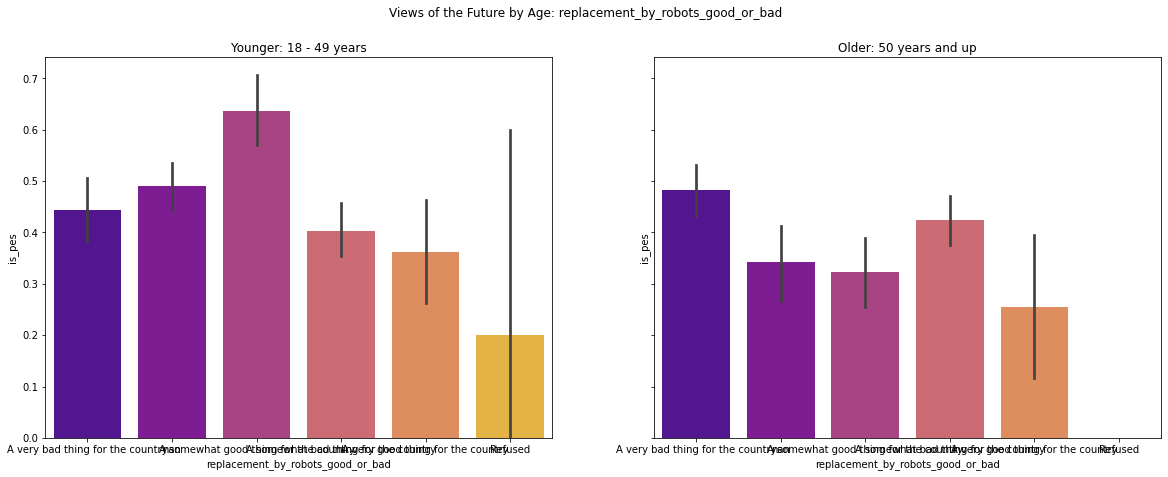

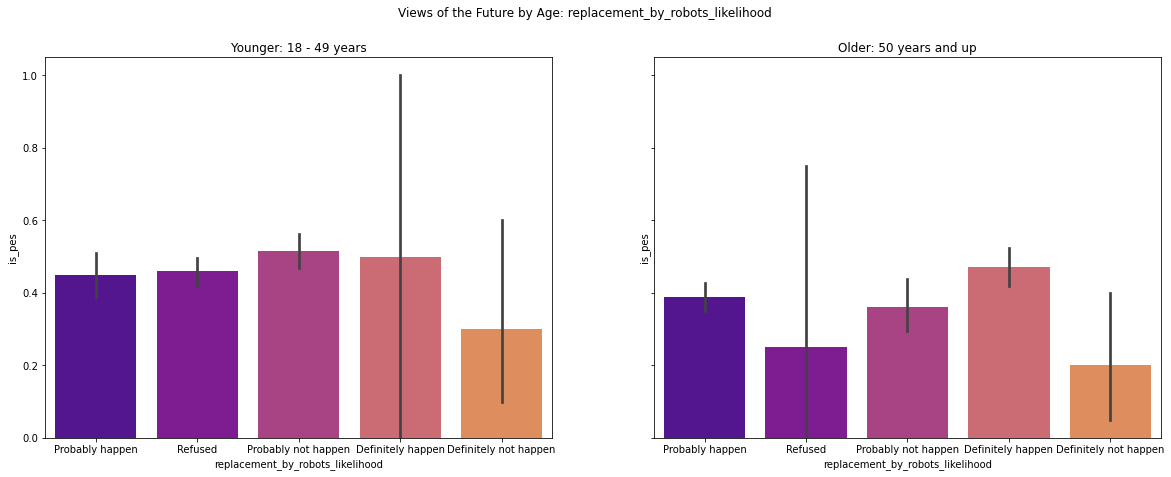

In [35]:
for col in ['attitude', 'avg_family', 'military', 'sci_tech', 'avg_family', 'happen_health', 'happen_race', 'happen_health', 
            'robot_replacement_means_better_jobs_for_humans', 'robot_replacement_increase_inequality', 
            'likelihood_my_job_replaced_by_robots', 'replacement_by_robots_good_or_bad', 'replacement_by_robots_likelihood']:
    # Set number of subplots, format (1 row and 2 cols), share Y axis, set figure size of subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True,  figsize=(20,7))
    
    # Set suptitle
    fig.suptitle(f'Views of the Future by Age: {col}')
    
    # First plot and its title
    sns.barplot(data=df[((df.highest_education_six_categories=='College graduate/some post grad') | 
                           (df.highest_education_six_categories=='Postgraduate') | 
                           (df.highest_education_six_categories=='Some college, no degree'))], 
                  x=col, y='is_pes', ax=axes[0])
    
    axes[0].set_title('Younger: 18 - 49 years')
    
    # Second plot and its title
    sns.barplot(data=df[~((df.highest_education_six_categories=='College graduate/some post grad')
                           | (df.highest_education_six_categories=='Postgraduate')
                           | (df.highest_education_six_categories=='Some college, no degree'))], 
                  x=col, y='is_pes', ax=axes[1])
    
    axes[1].set_title('Older: 50 years and up')
    
    plt.show()
        

In [36]:
df.highest_education_six_categories.value_counts()

High school graduate               757
College graduate/some post grad    516
Some college, no degree            490
Postgraduate                       363
Associate's degree                 201
Less than high school              183
Don't know/Refused                   5
Name: highest_education_six_categories, dtype: int64

<AxesSubplot:xlabel='attitude', ylabel='count'>

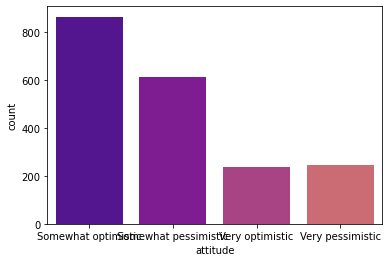

In [37]:
sns.countplot(data=df[(df.age=='50-64') | ~(df.age=='65+')], x='attitude')

<AxesSubplot:xlabel='attitude', ylabel='count'>

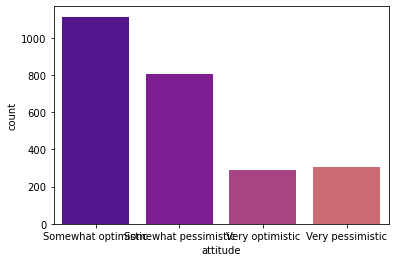

In [38]:
sns.countplot(data=df[~(df.age=='50-64') | ~(df.age=='65+')], x='attitude')

In [39]:
from sklearn.model_selection import train_test_split

def train_validate_test_split(df: pd.DataFrame, target: str, seed=123):
    '''This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''

    train_validate, test = train_test_split(df, test_size=0.2, 

                                            random_state=seed, 

                                            stratify=df[target])

    train, validate = train_test_split(train_validate, test_size=0.3, 

                                       random_state=seed,

                                       stratify=train_validate[target])

    return train, validate, test

In [40]:
train, validate, test = train_validate_test_split(df, 'is_pes', seed=123)

In [41]:
train.shape, \
validate.shape, \
test.shape

((1408, 128), (604, 128), (503, 128))

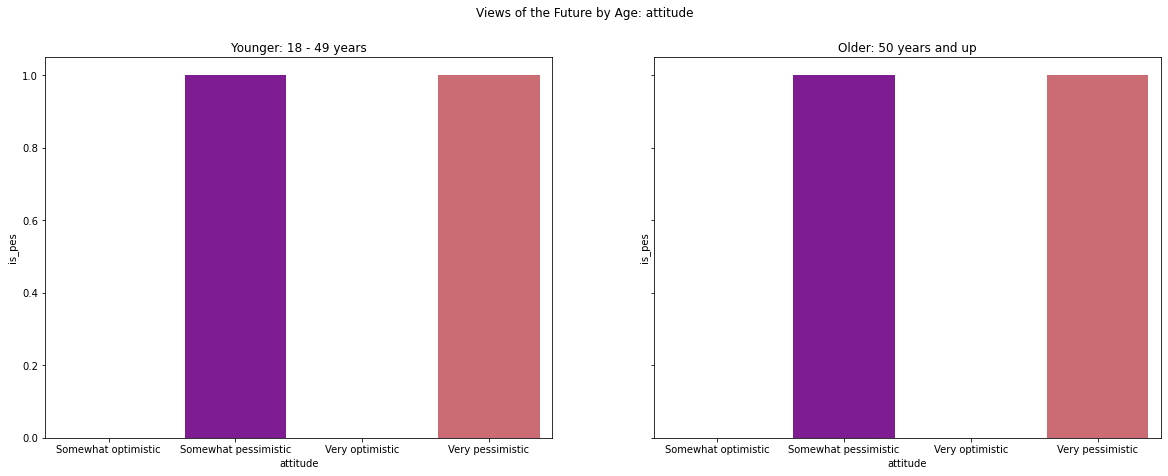

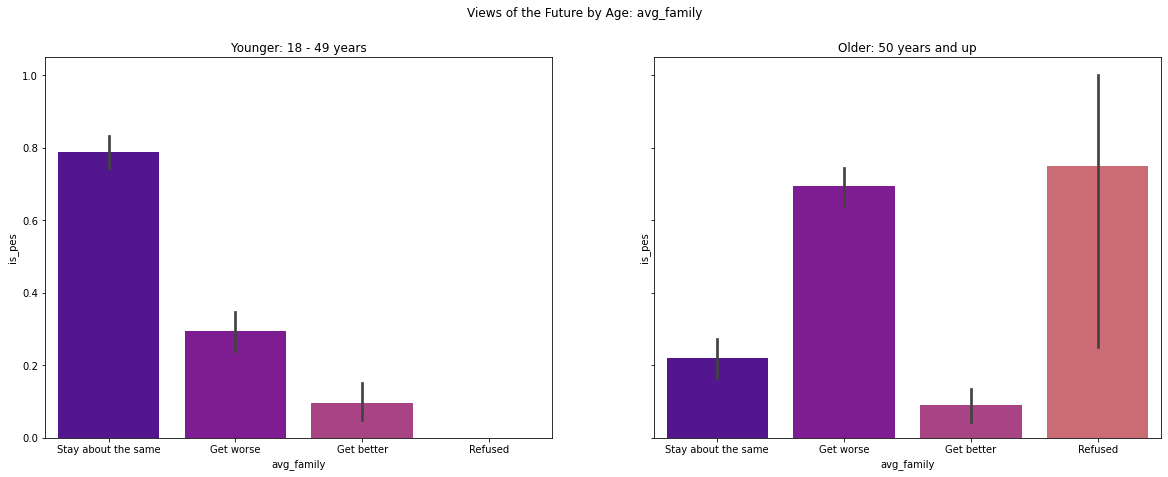

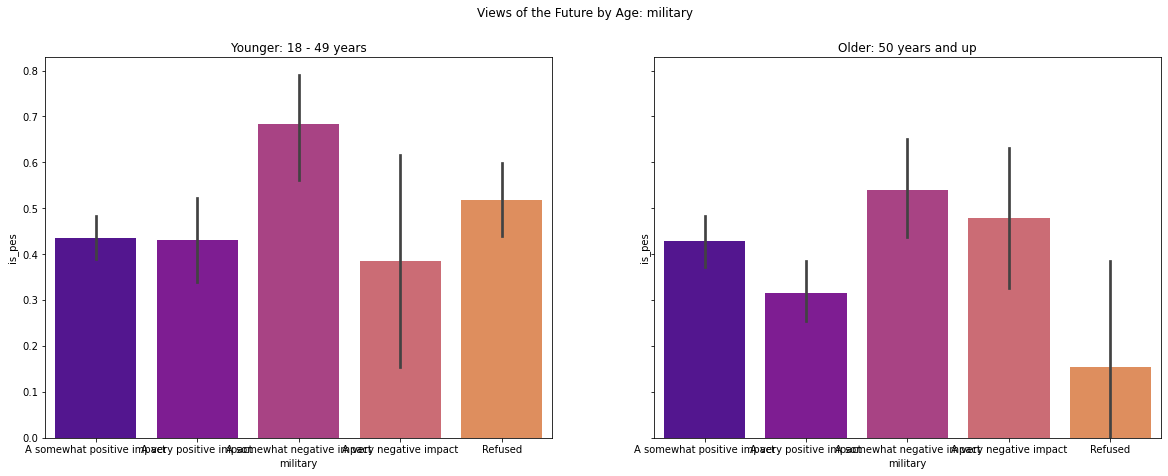

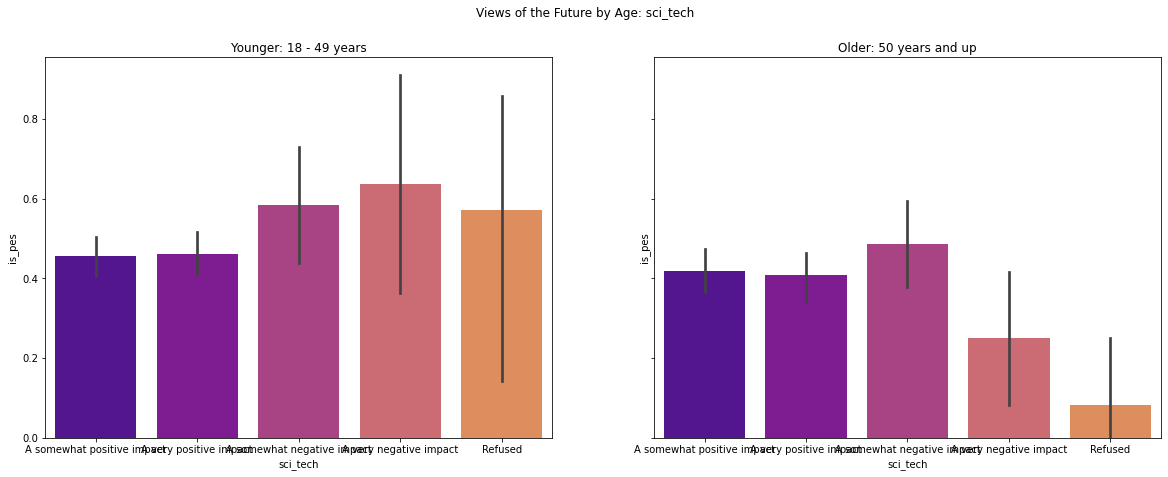

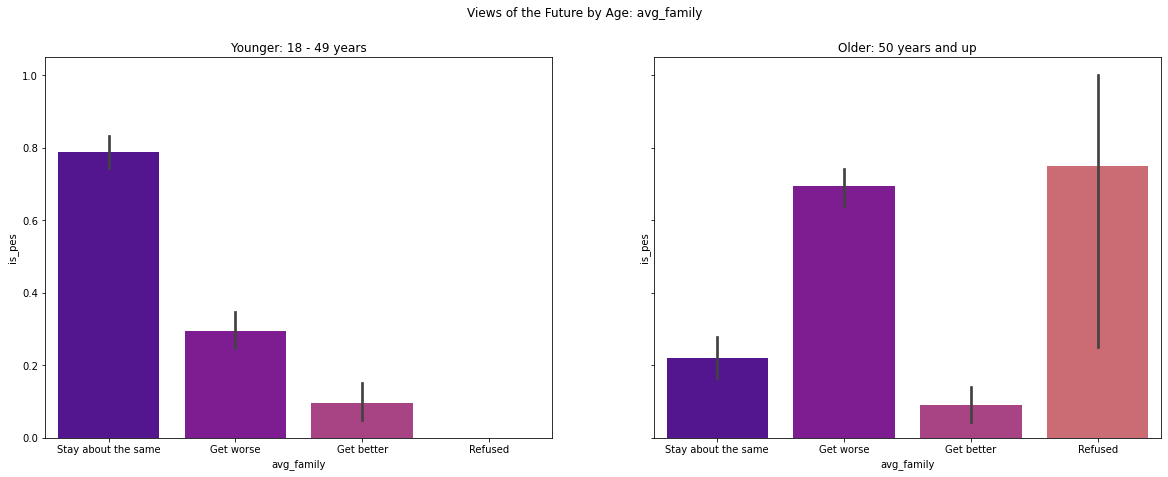

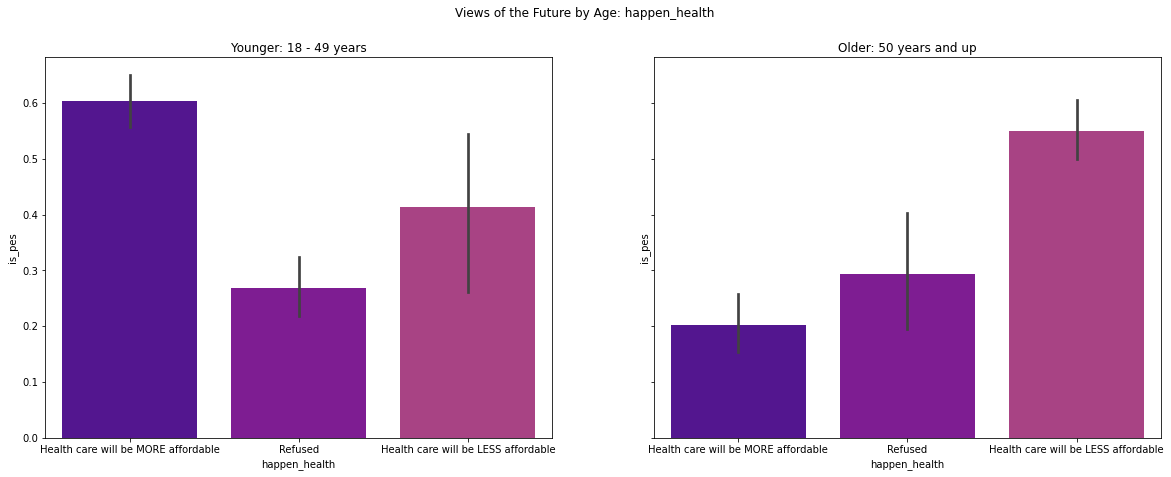

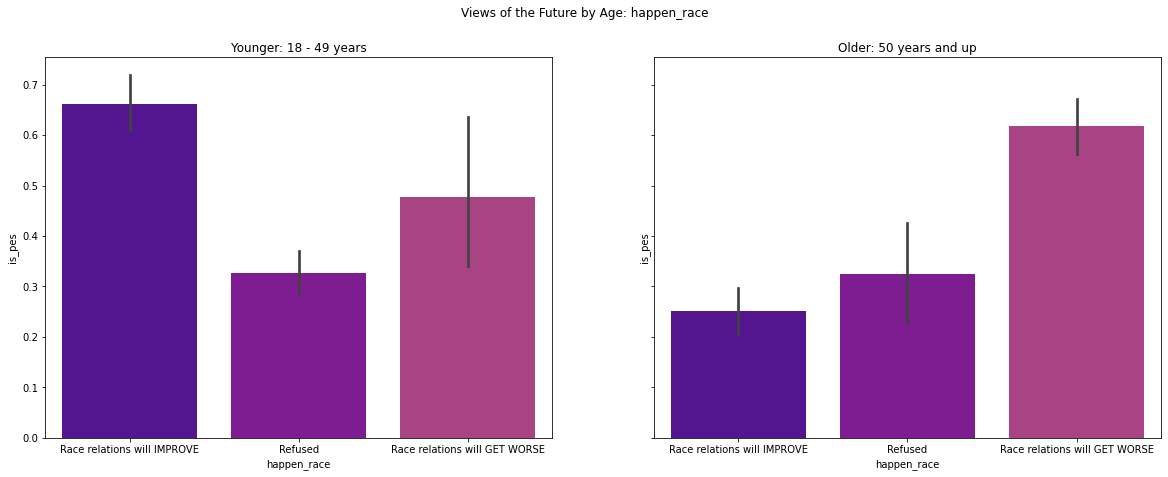

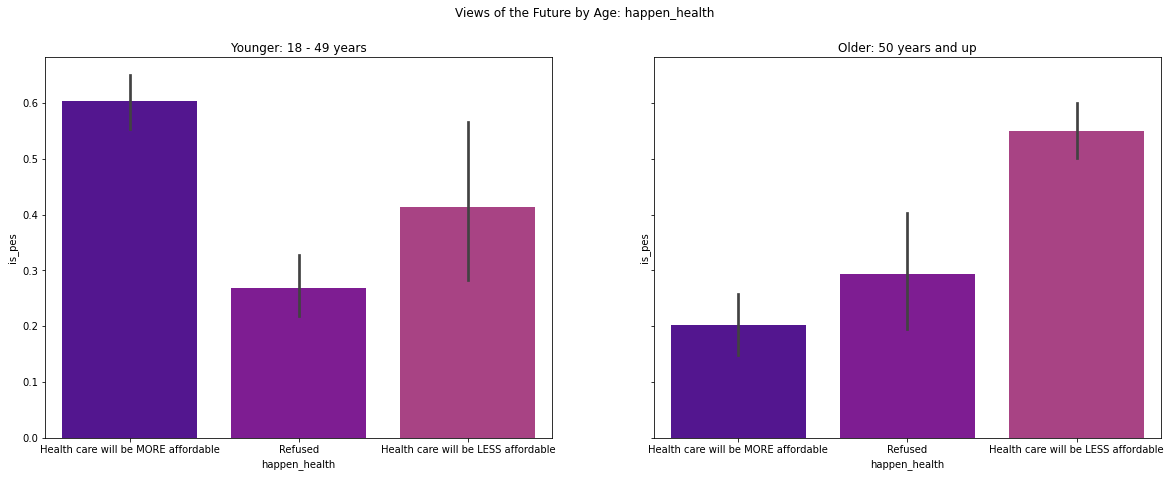

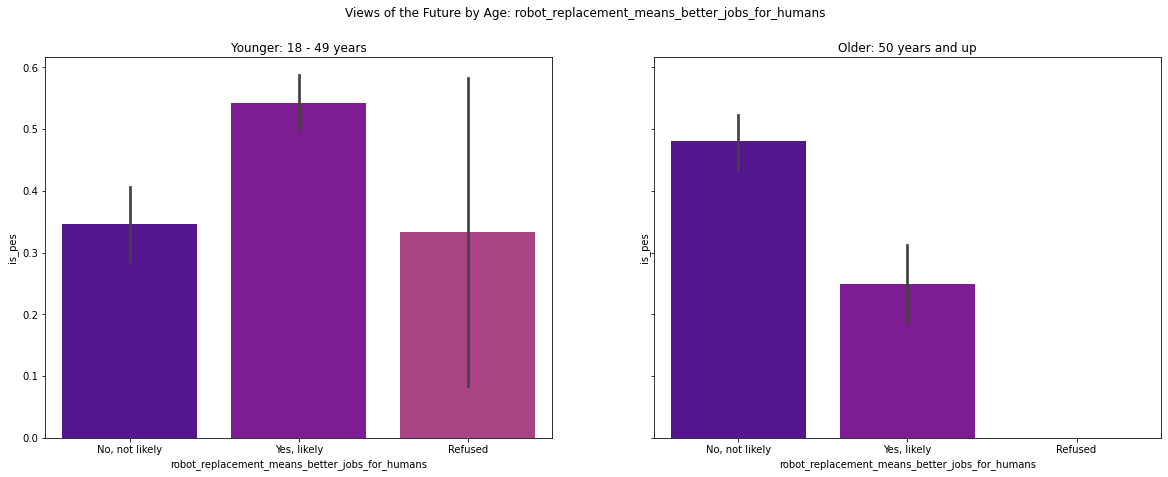

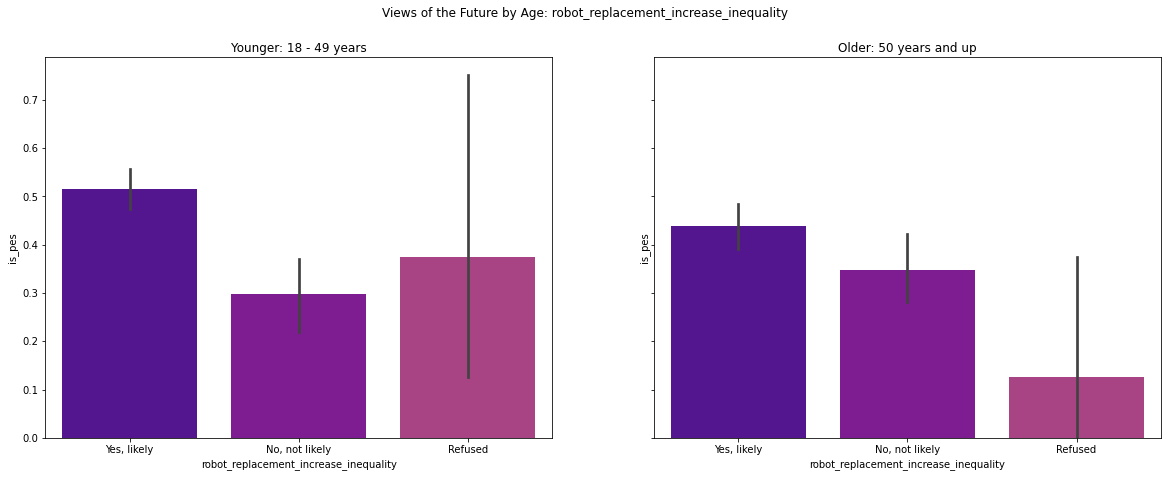

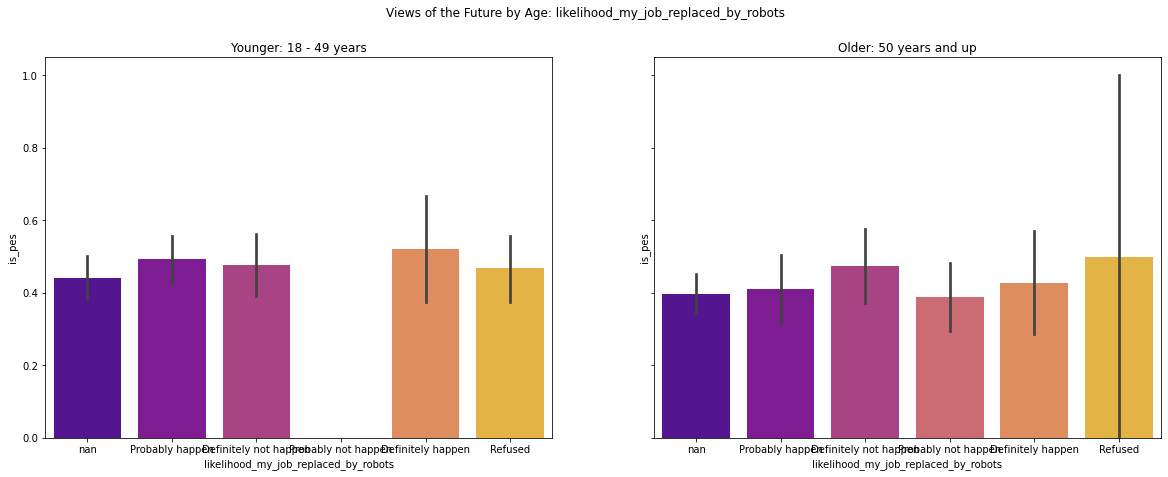

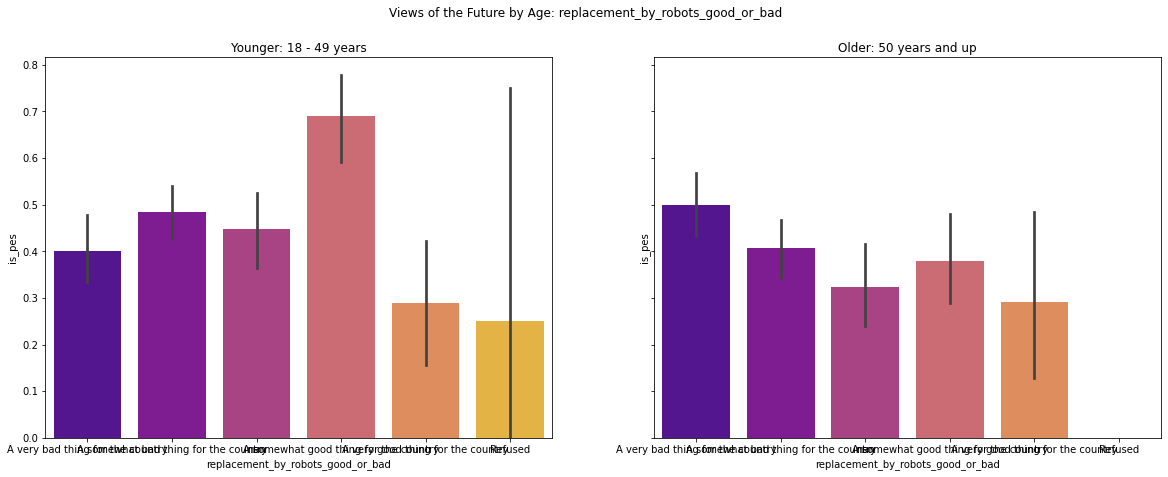

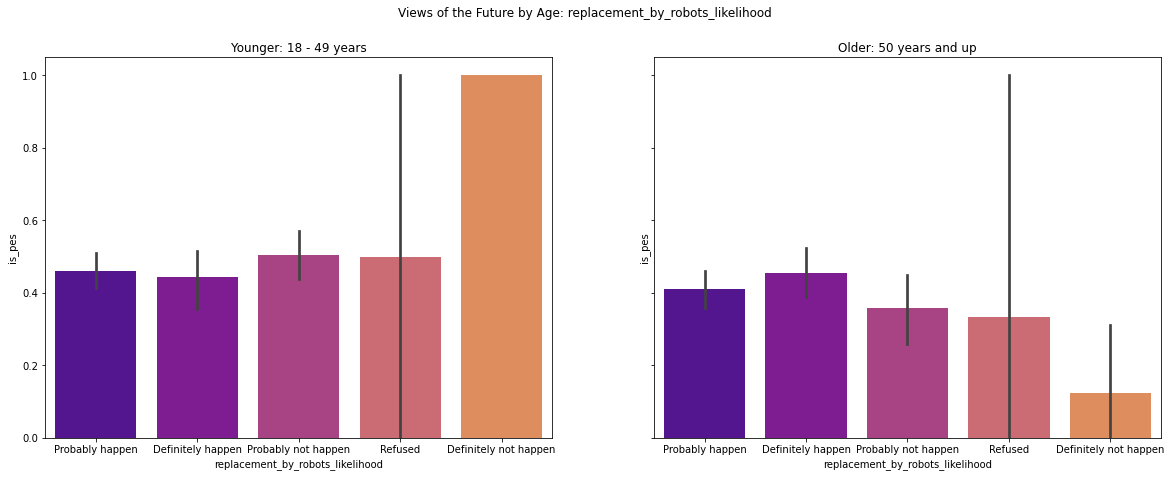

In [42]:
for col in ['attitude', 'avg_family', 'military', 'sci_tech', 'avg_family', 'happen_health', 'happen_race', 'happen_health', 
            'robot_replacement_means_better_jobs_for_humans', 'robot_replacement_increase_inequality', 
            'likelihood_my_job_replaced_by_robots', 'replacement_by_robots_good_or_bad', 'replacement_by_robots_likelihood']:
    # Set number of subplots, format (1 row and 2 cols), share Y axis, set figure size of subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True,  figsize=(20,7))
    
    # Set suptitle
    fig.suptitle(f'Views of the Future by Age: {col}')
    
    # First plot and its title
    sns.barplot(data=train[((train.highest_education_six_categories=='College graduate/some post grad') | 
                           (train.highest_education_six_categories=='Postgraduate') | 
                           (train.highest_education_six_categories=='Some college, no degree'))], 
                  x=col, y='is_pes', ax=axes[0])
    
    axes[0].set_title('Younger: 18 - 49 years')
    
    # Second plot and its title
    sns.barplot(data=train[~((train.highest_education_six_categories=='College graduate/some post grad')
                           | (train.highest_education_six_categories=='Postgraduate')
                           | (train.highest_education_six_categories=='Some college, no degree'))], 
                  x=col, y='is_pes', ax=axes[1])
    
    axes[1].set_title('Older: 50 years and up')
    
    plt.show()
        

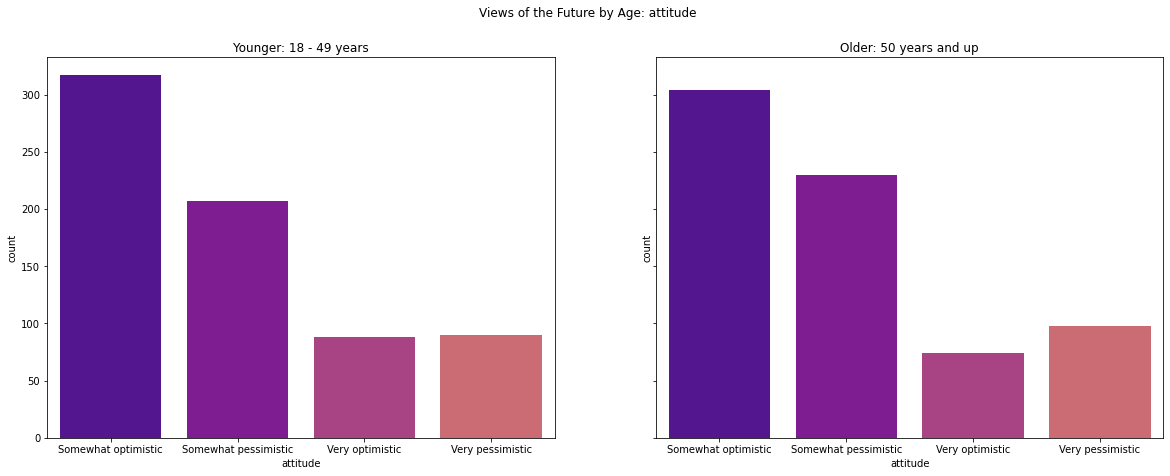

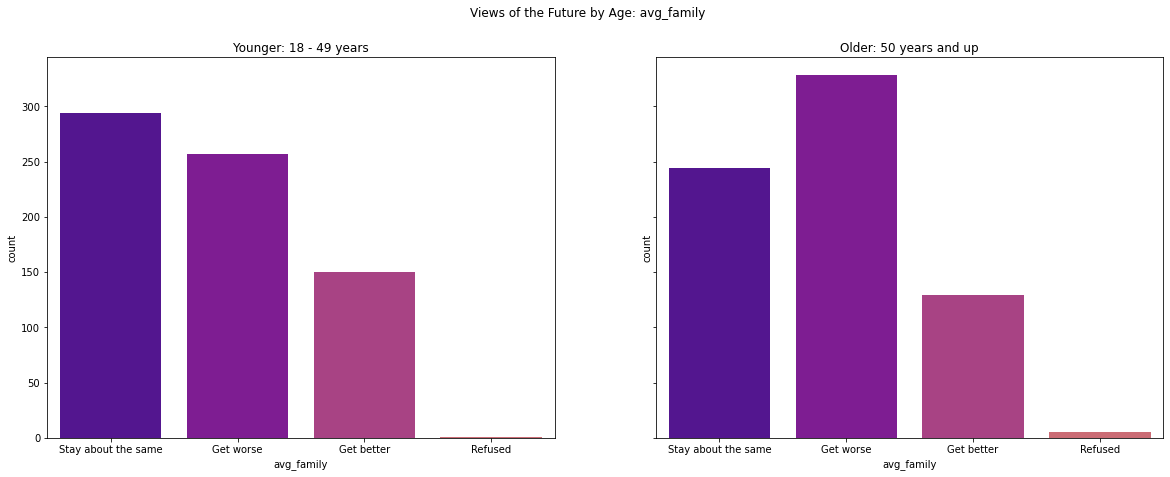

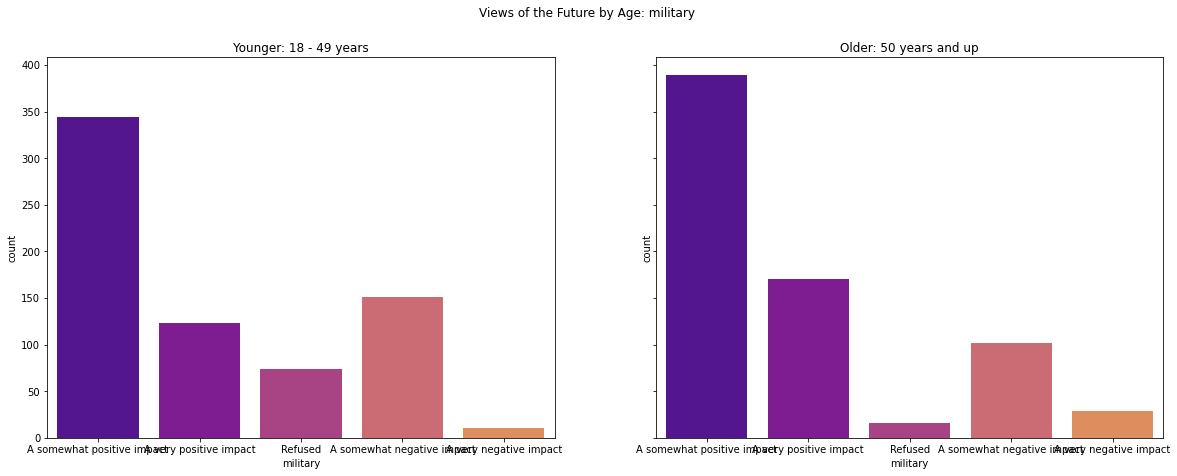

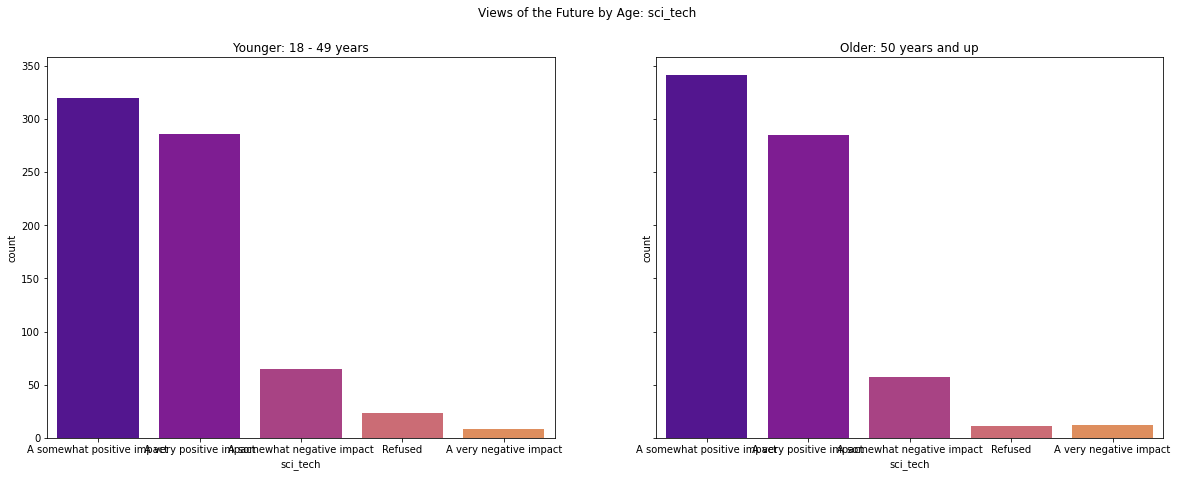

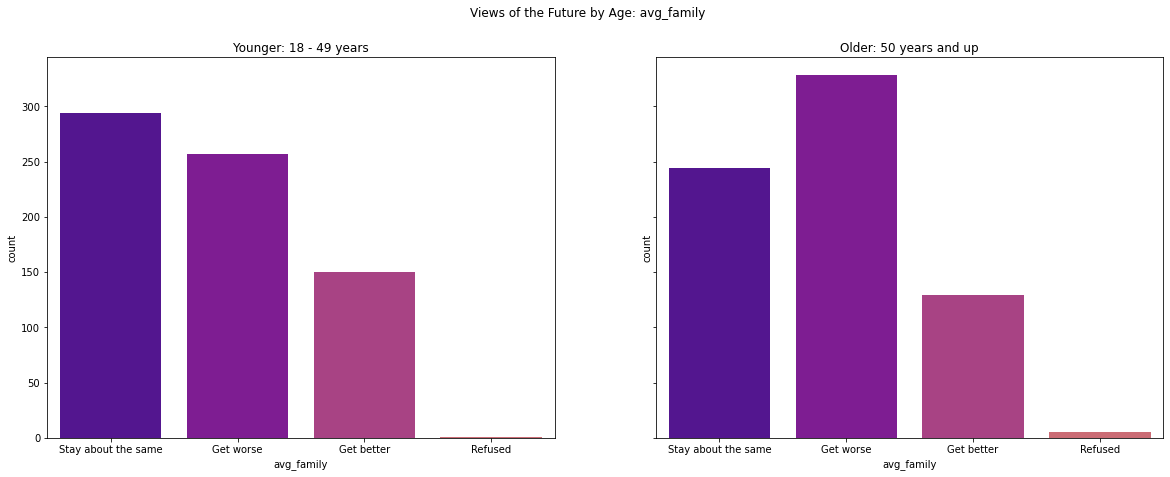

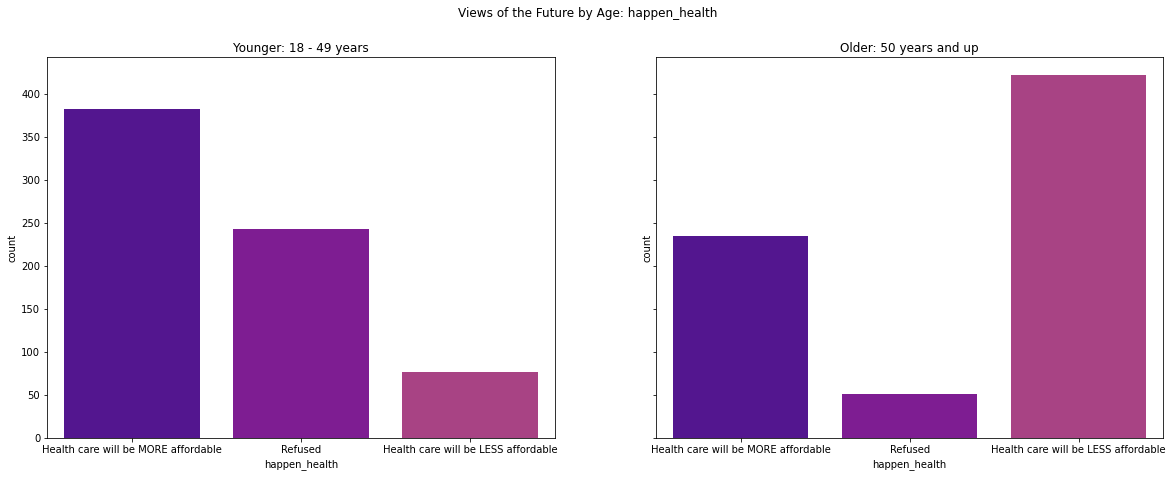

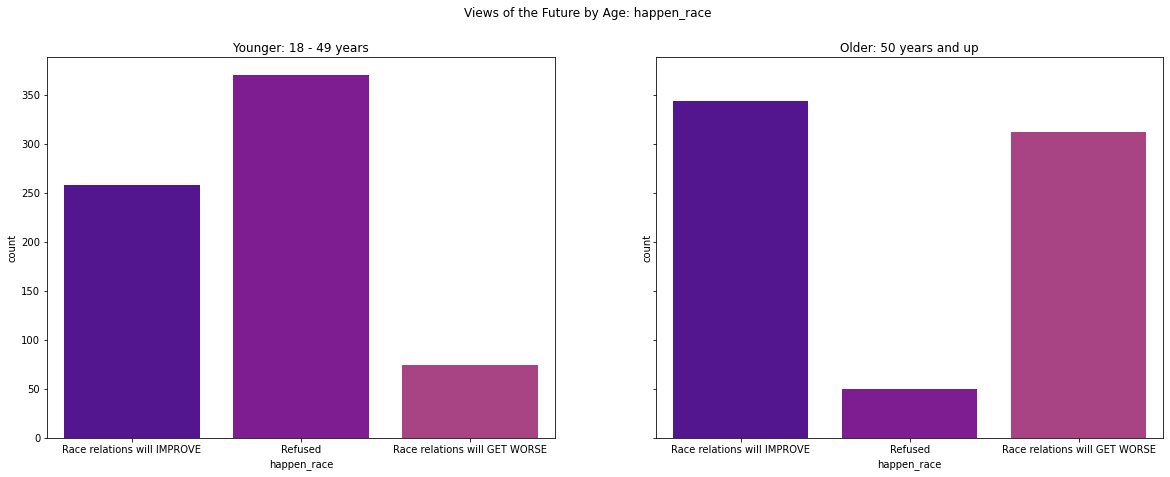

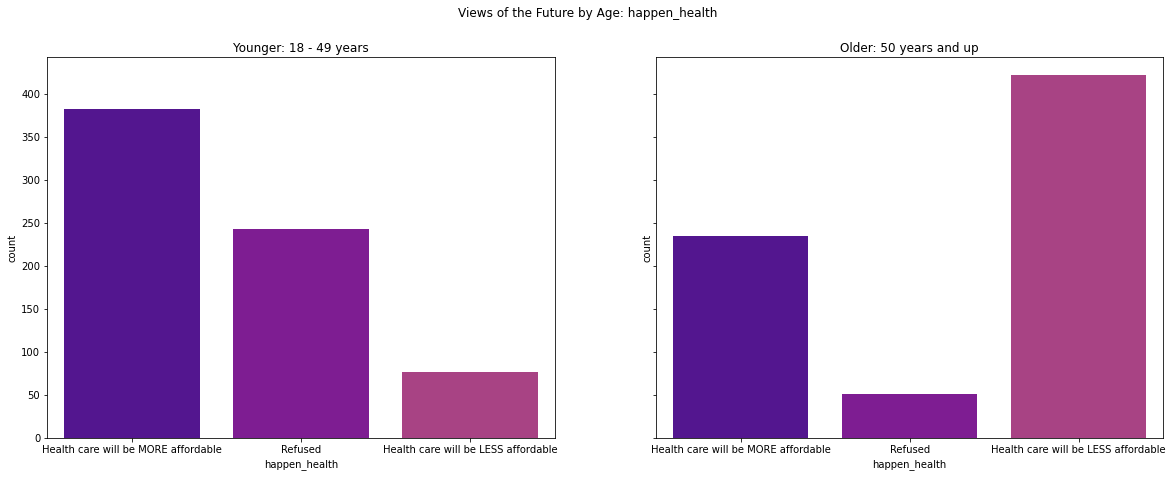

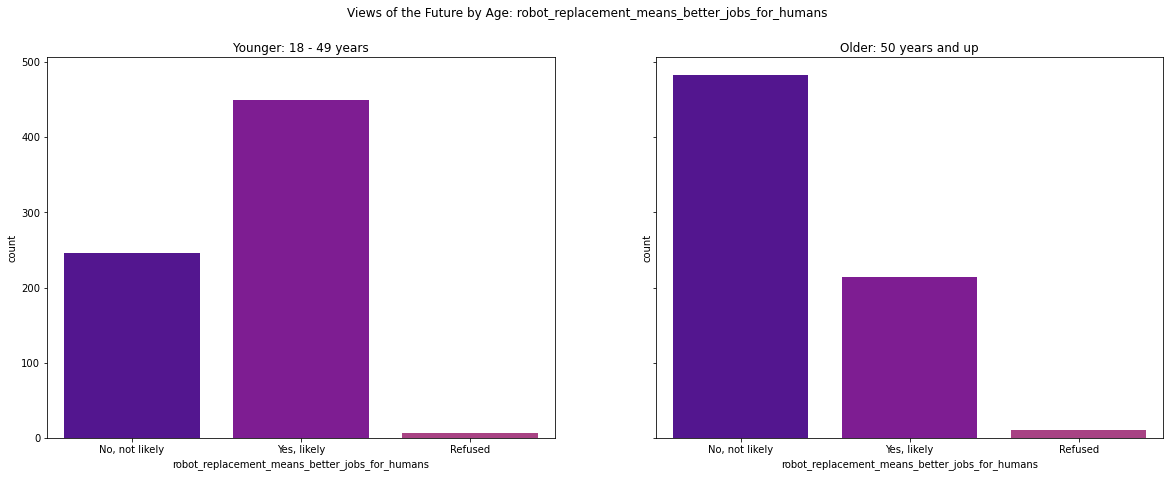

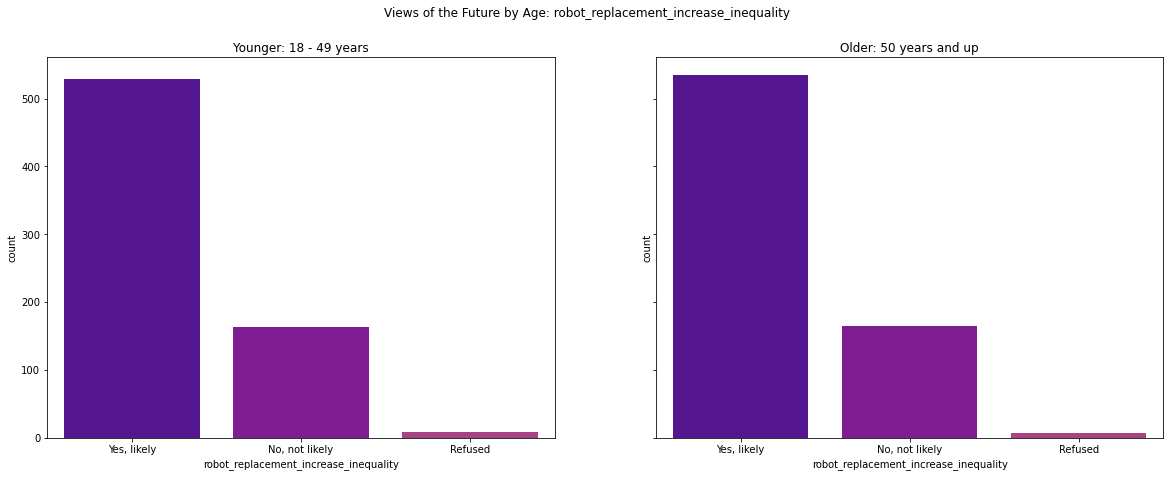

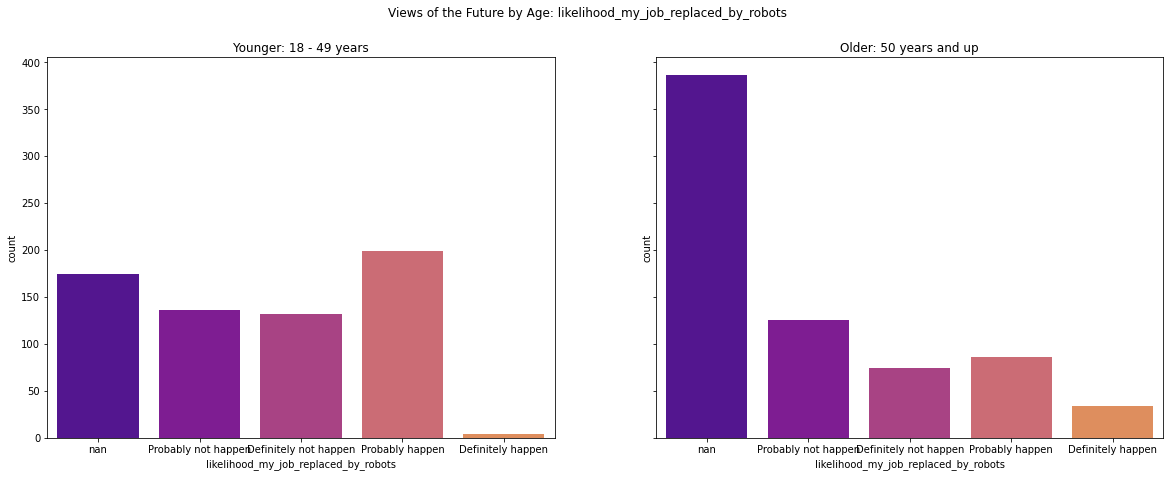

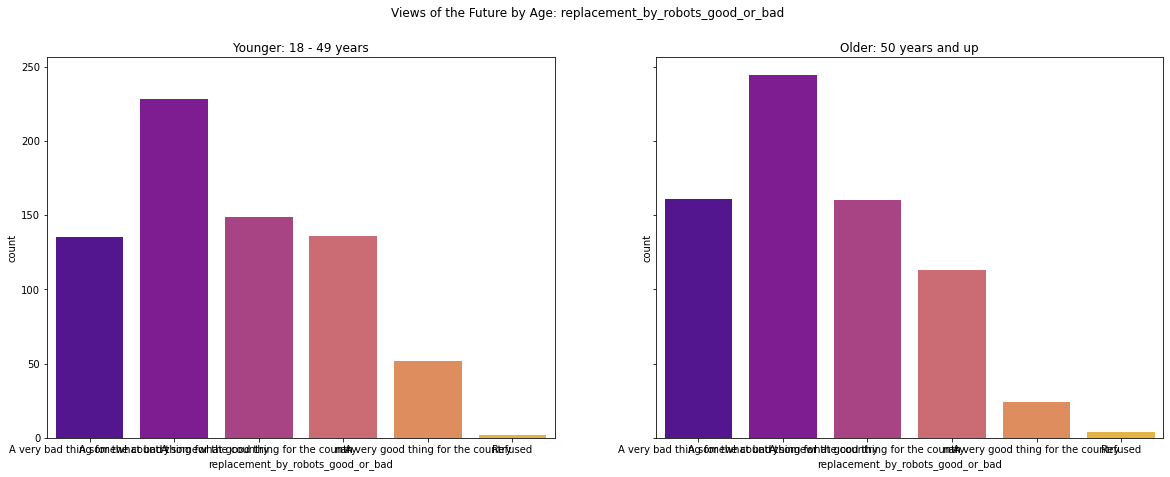

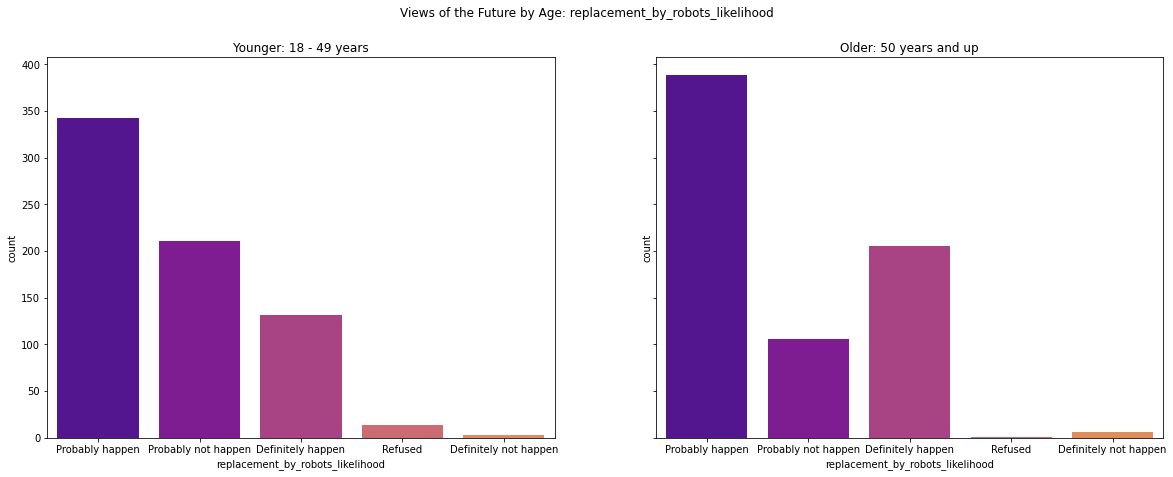

In [43]:
for col in ['attitude', 'avg_family', 'military', 'sci_tech', 'avg_family', 'happen_health', 'happen_race', 'happen_health', 
            'robot_replacement_means_better_jobs_for_humans', 'robot_replacement_increase_inequality', 
            'likelihood_my_job_replaced_by_robots', 'replacement_by_robots_good_or_bad', 'replacement_by_robots_likelihood']:
    # Set number of subplots, format (1 row and 2 cols), share Y axis, set figure size of subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True,  figsize=(20,7))
    
    # Set suptitle
    fig.suptitle(f'Views of the Future by Age: {col}')
    
    # First plot and its title
    sns.countplot(data=train[~((train.age=='50-64') | (train.age=='65+'))], x=col, ax=axes[0])
    axes[0].set_title('Younger: 18 - 49 years')
    
    # Second plot and its title
    sns.countplot(data=train[(train.age=='50-64') | (train.age=='65+')], x=col, ax=axes[1])
    axes[1].set_title('Older: 50 years and up')
    
    plt.show()

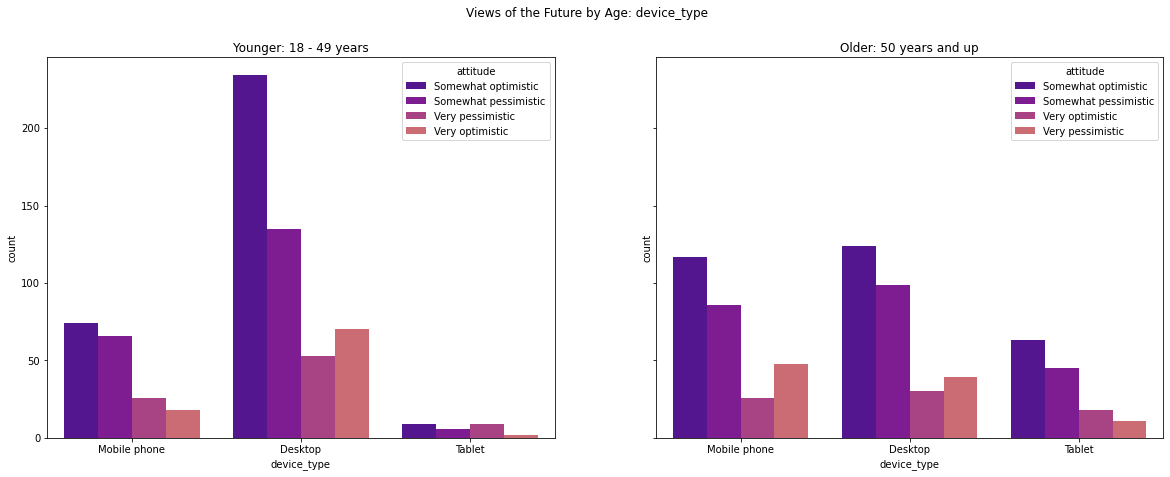

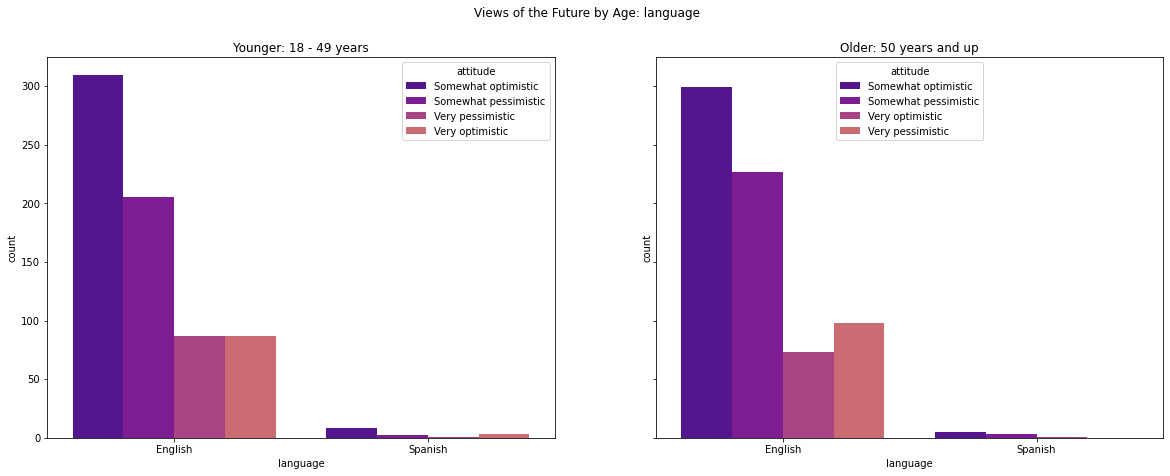

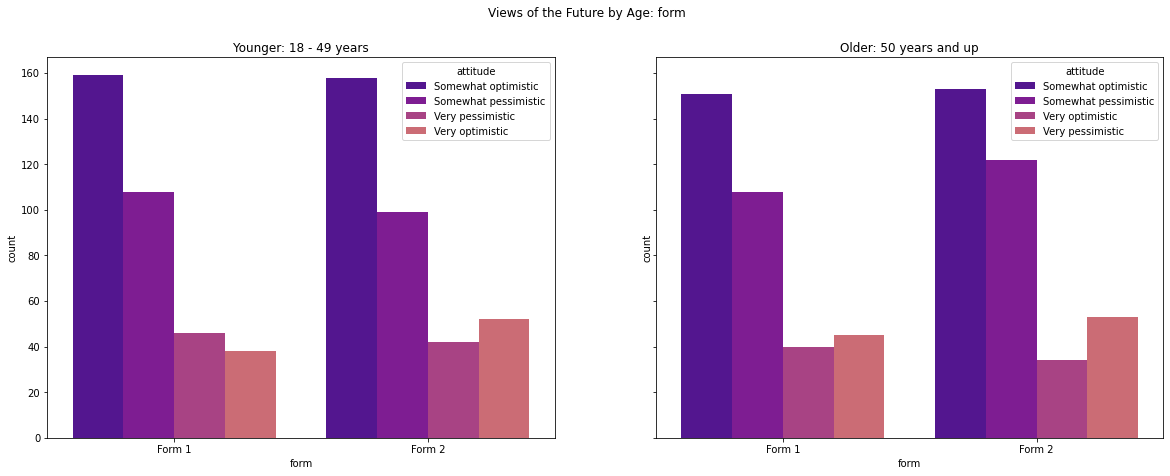

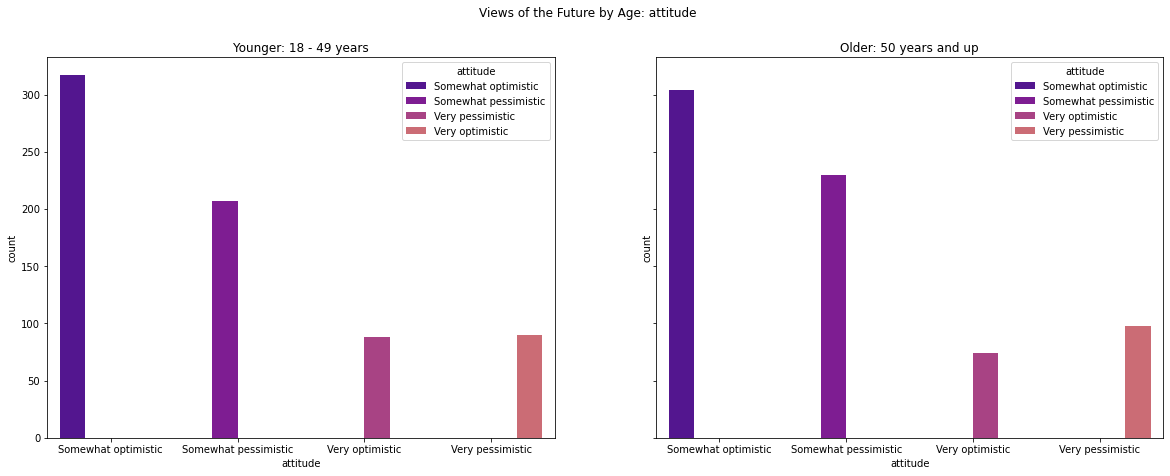

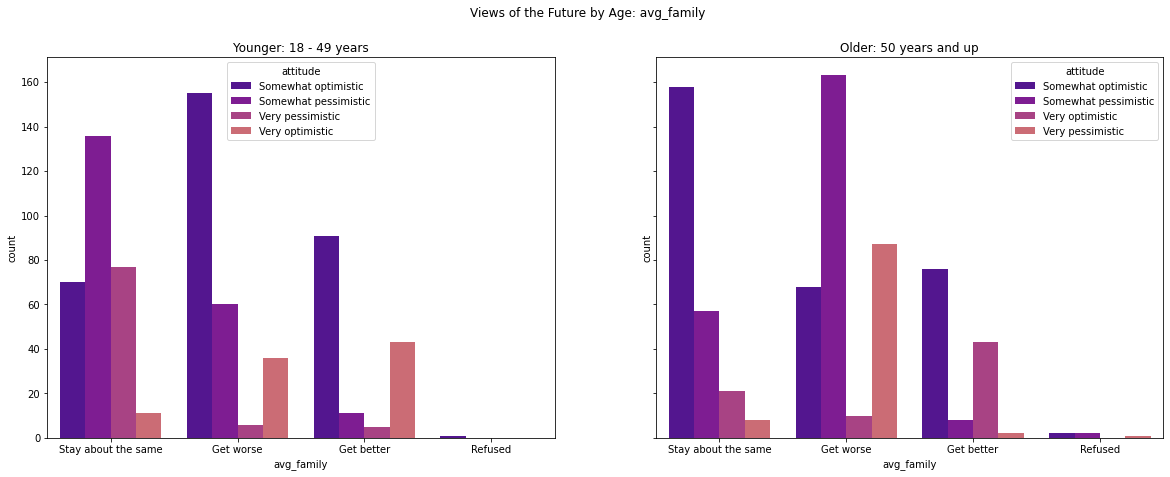

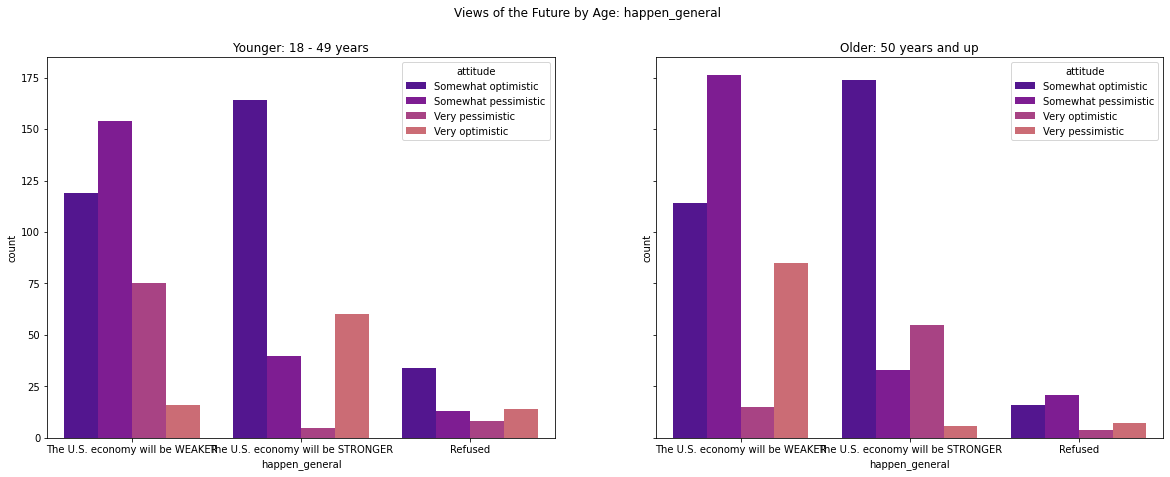

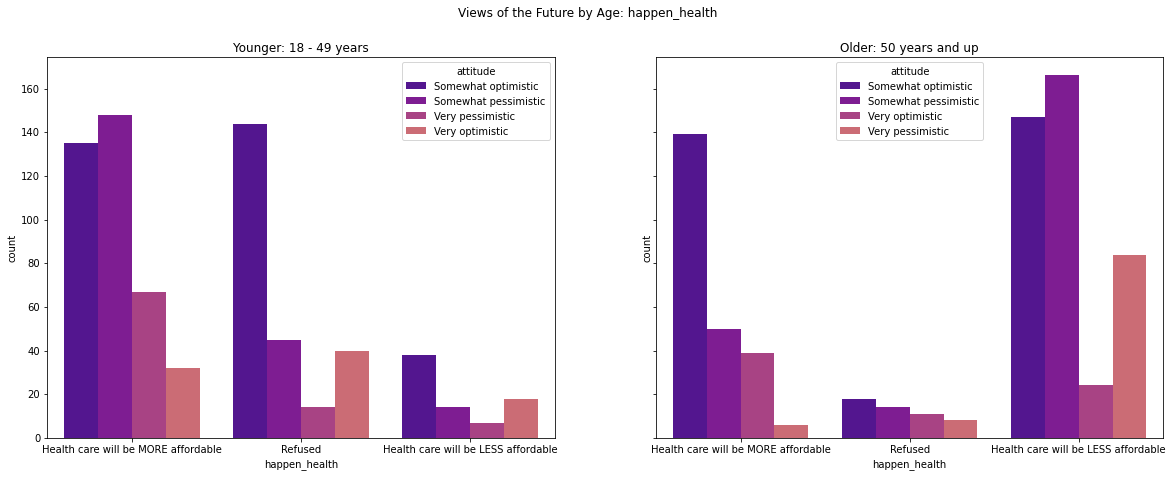

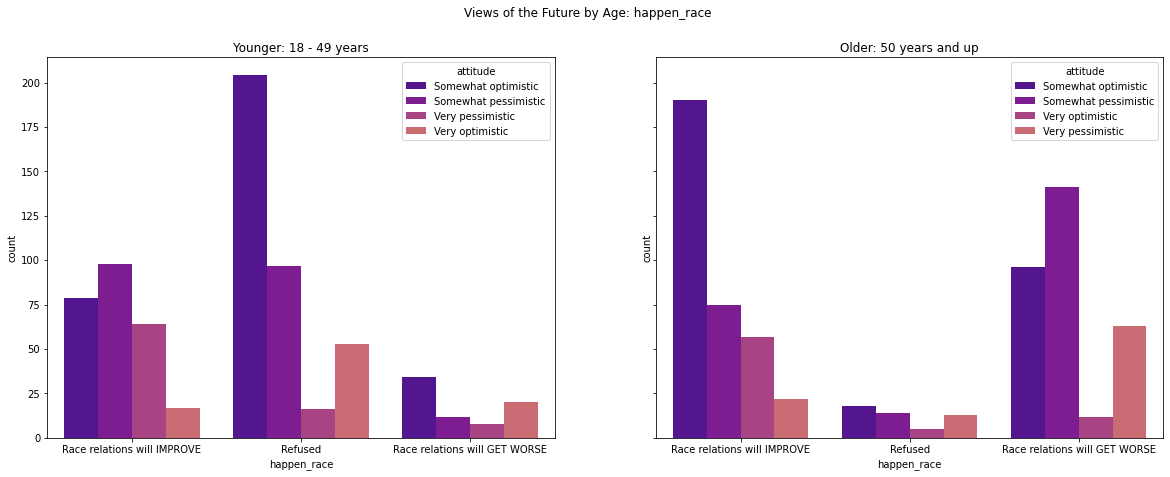

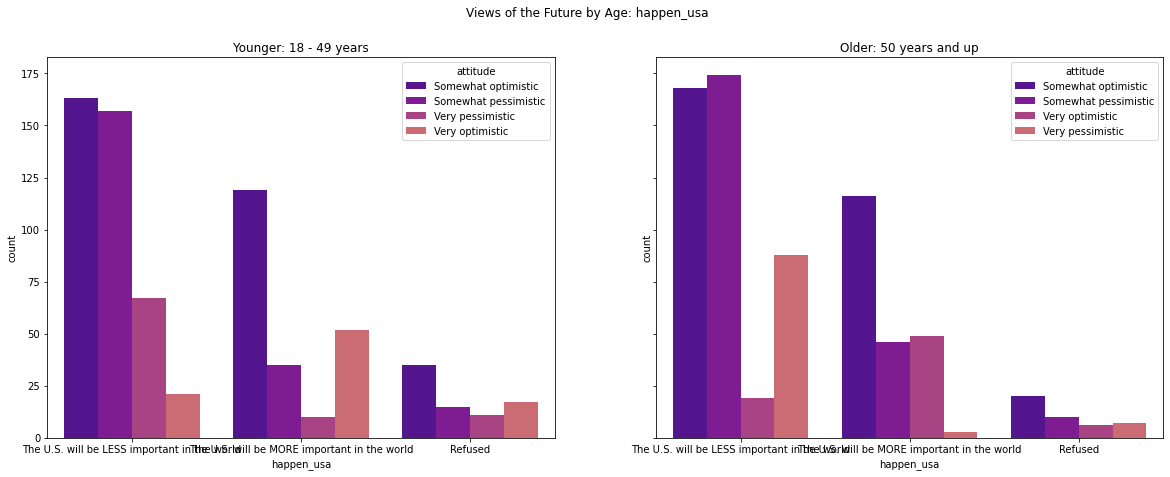

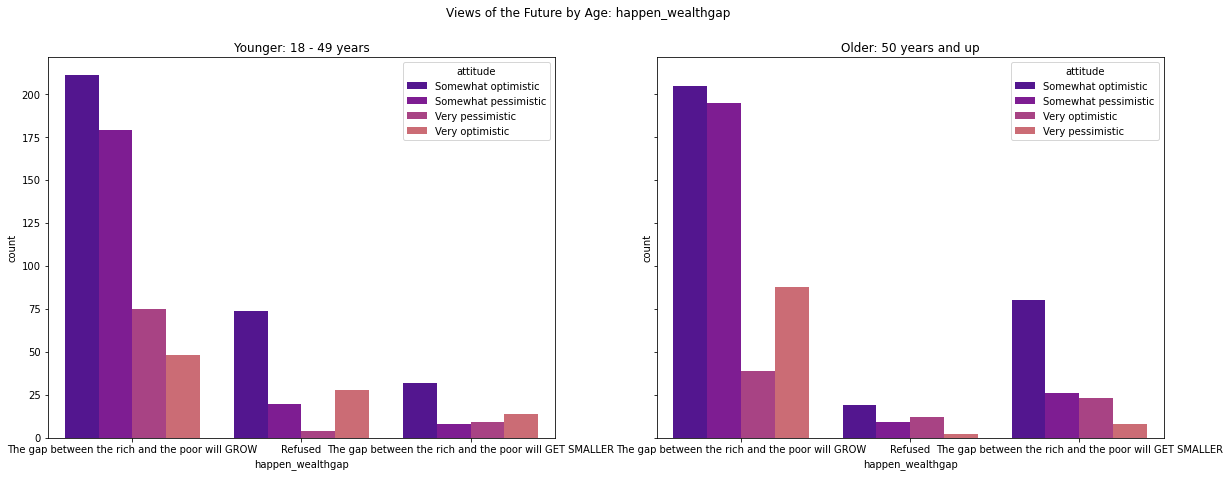

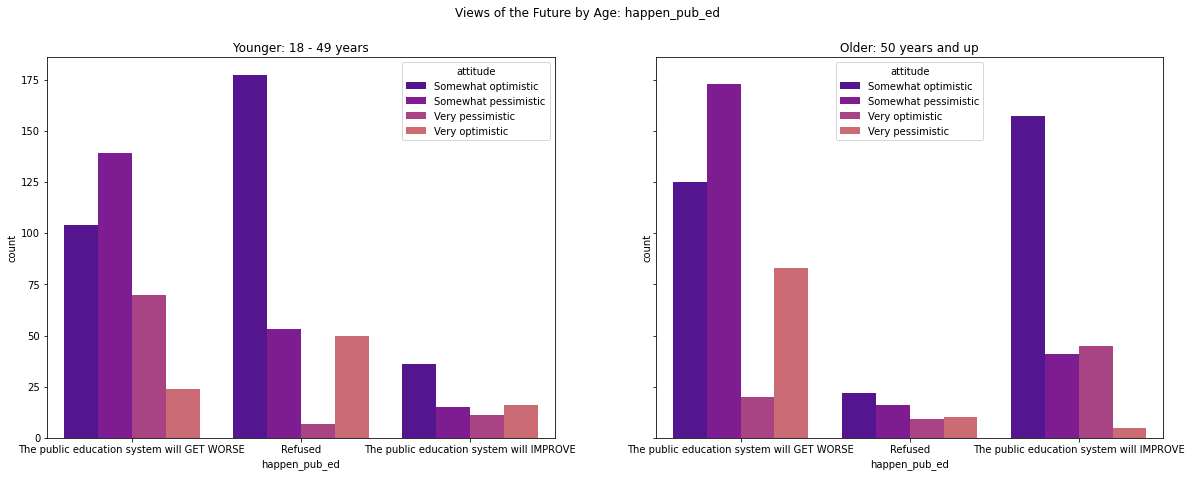

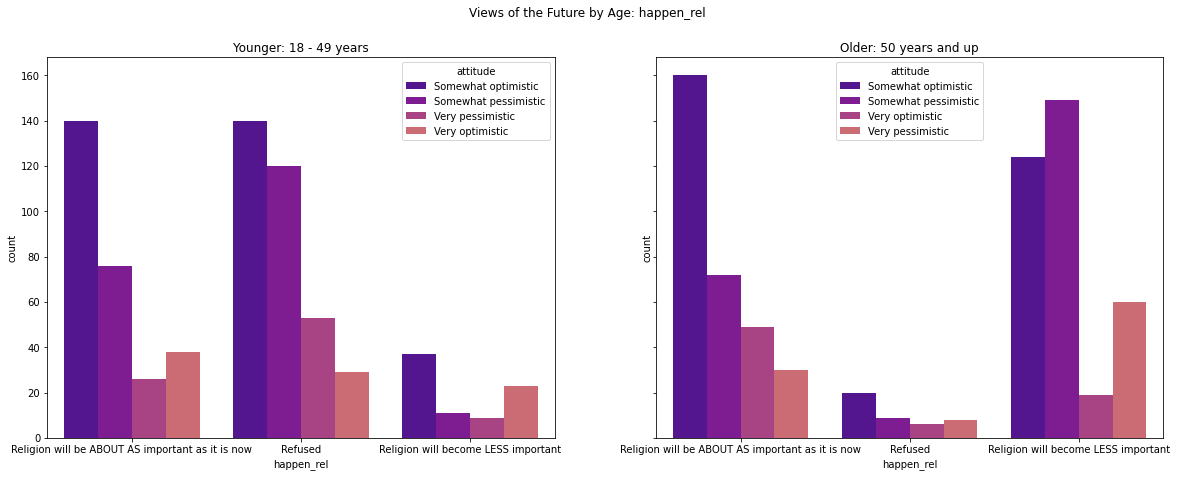

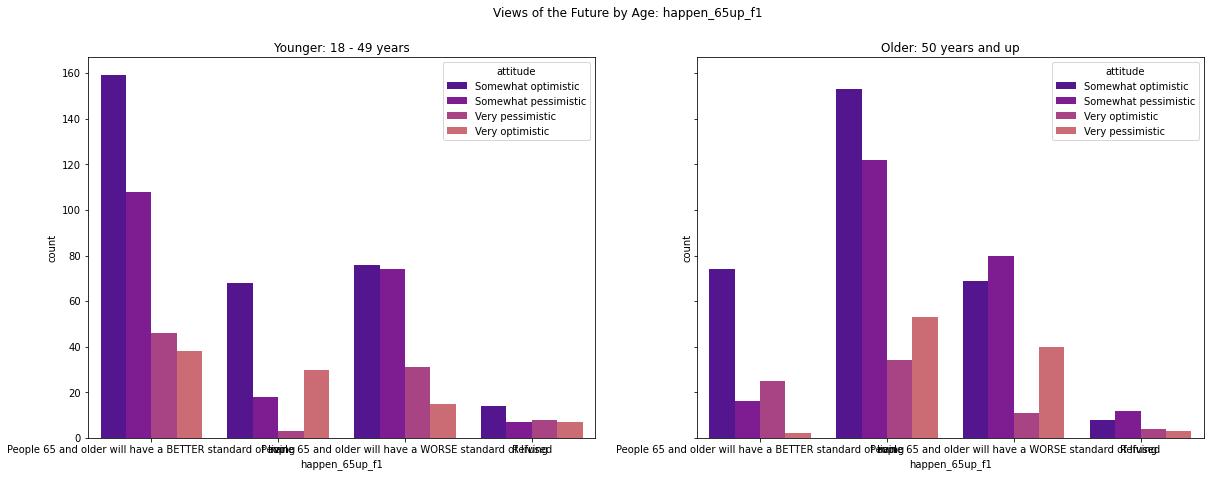

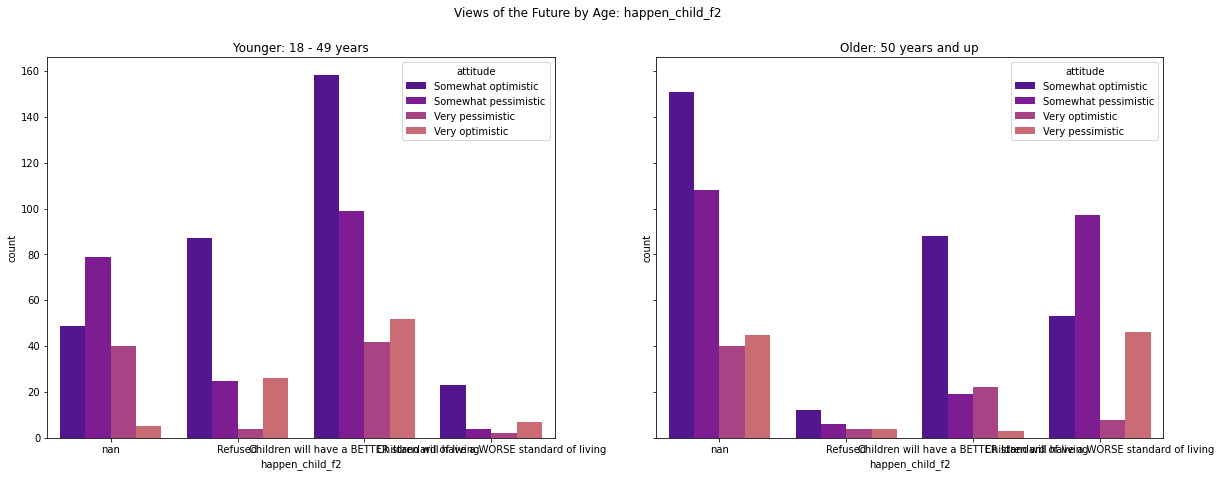

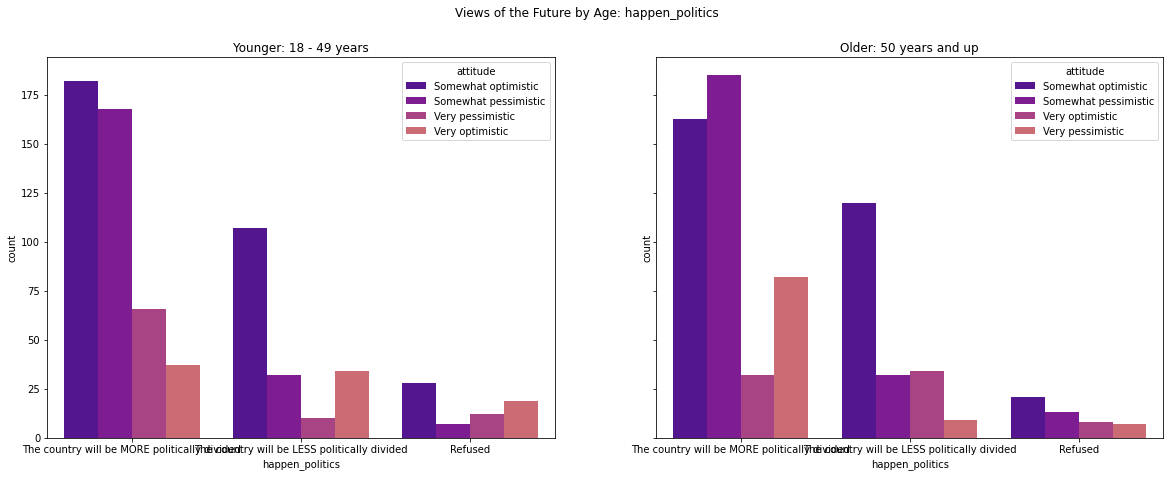

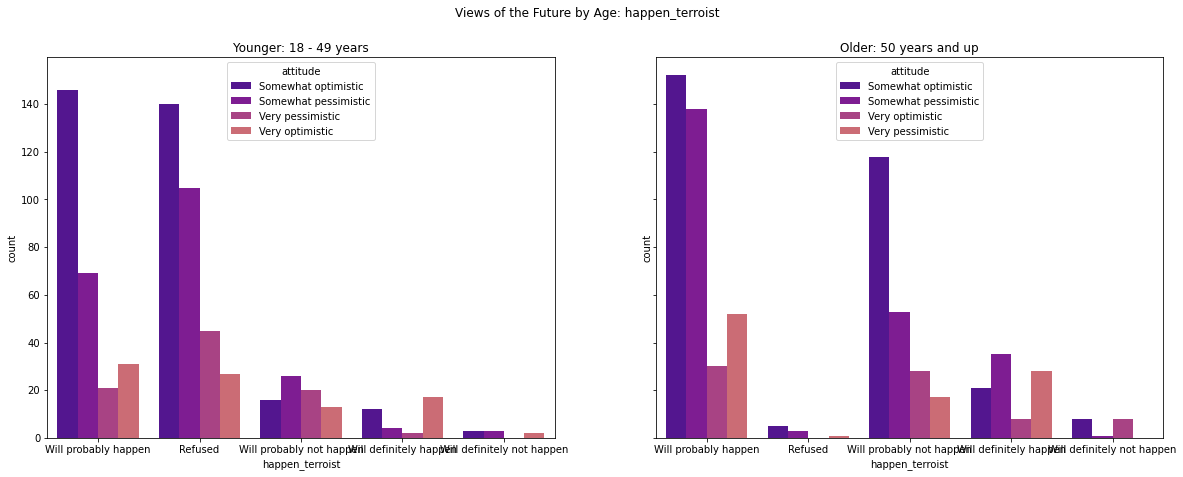

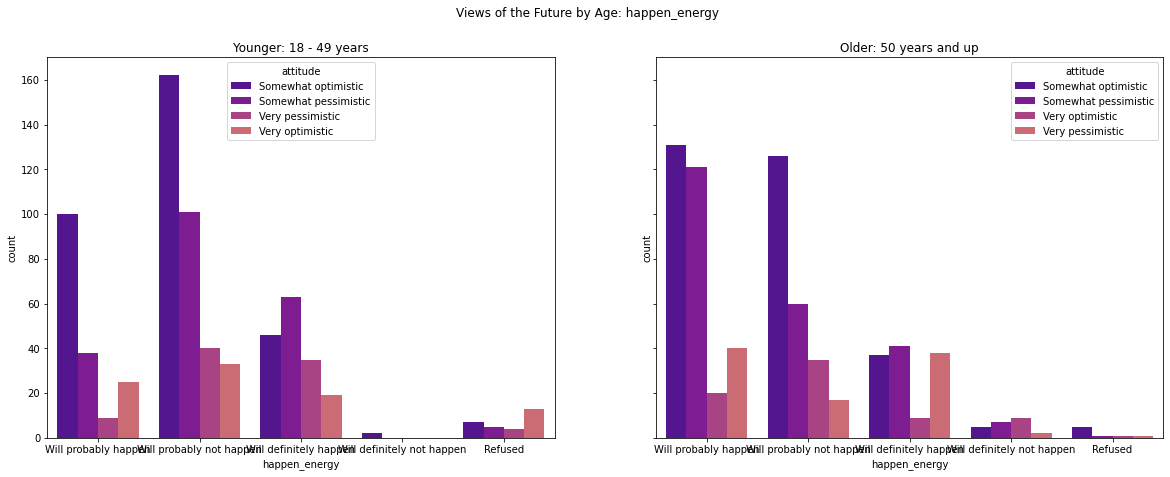

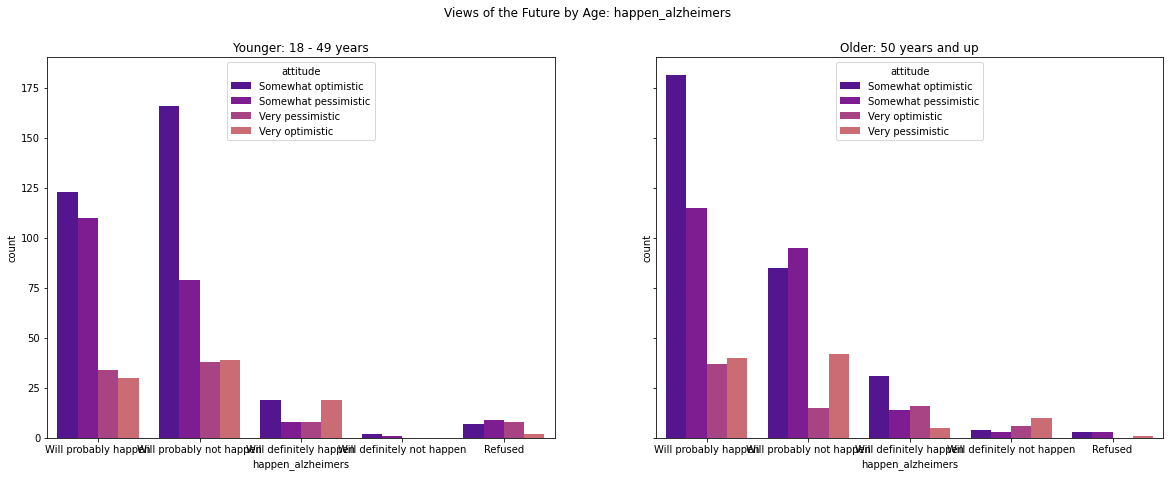

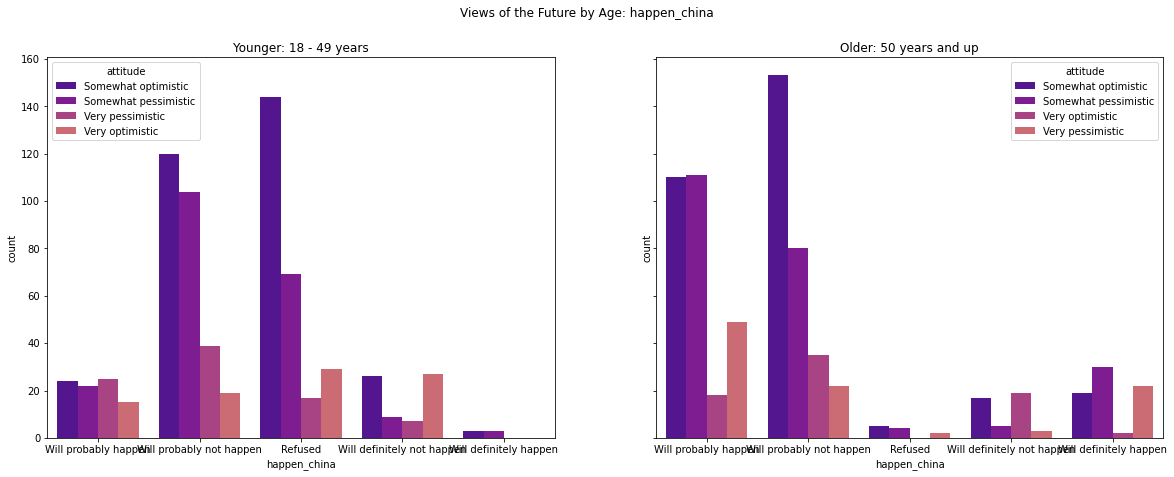

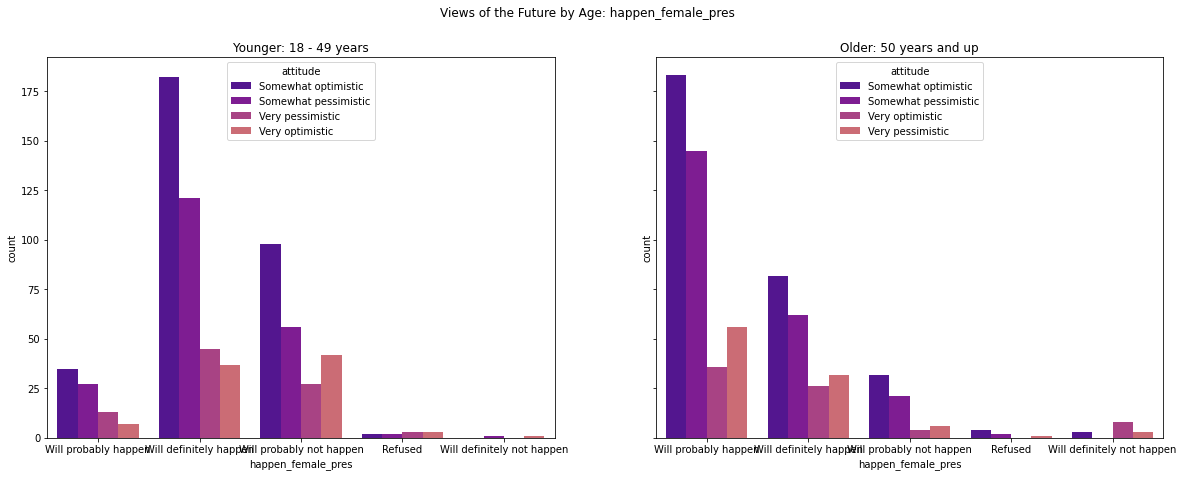

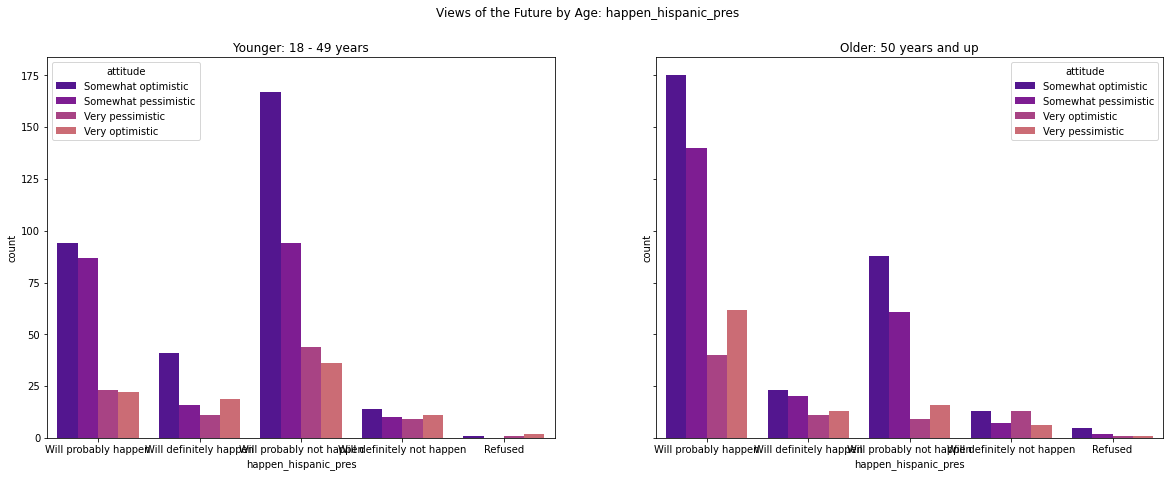

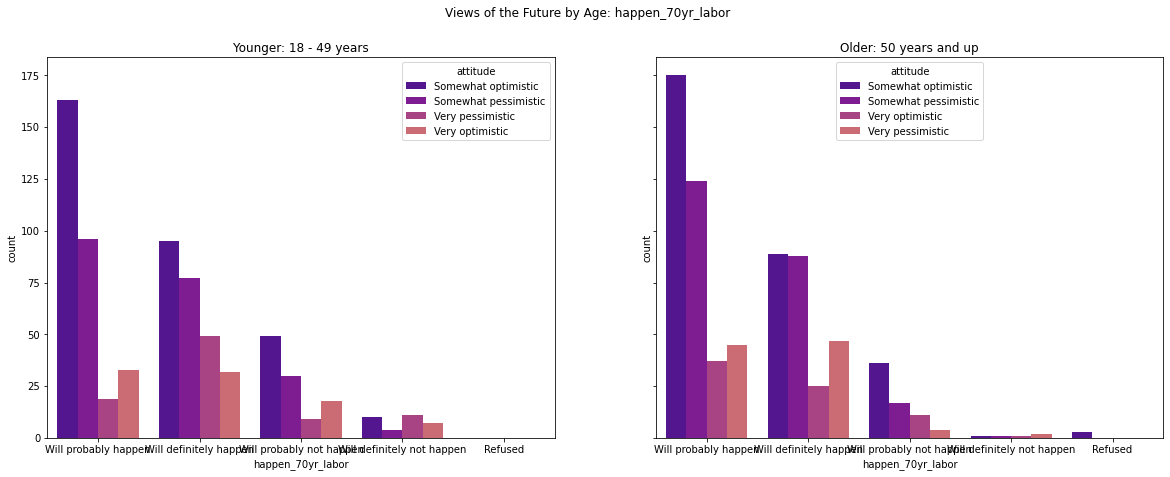

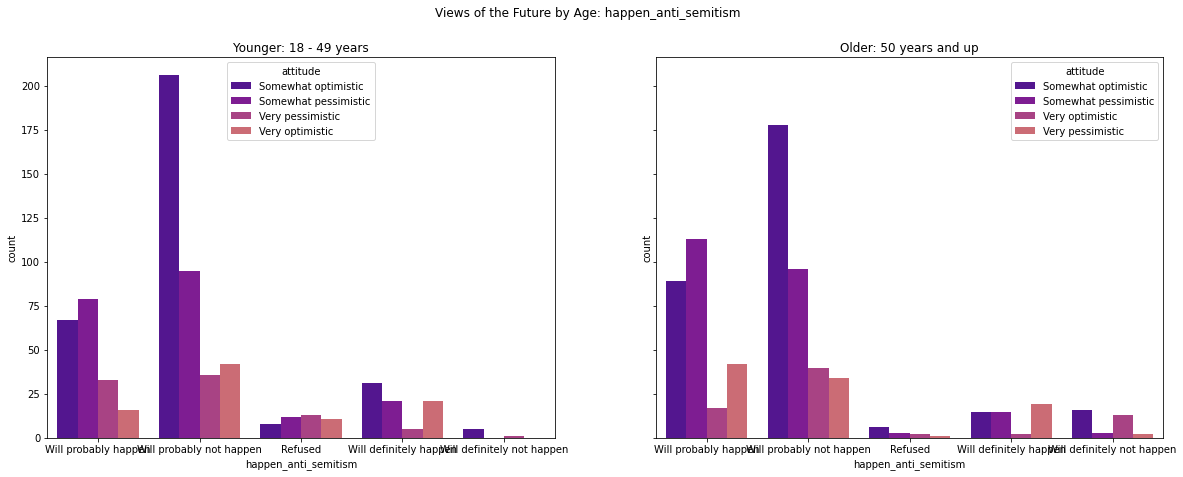

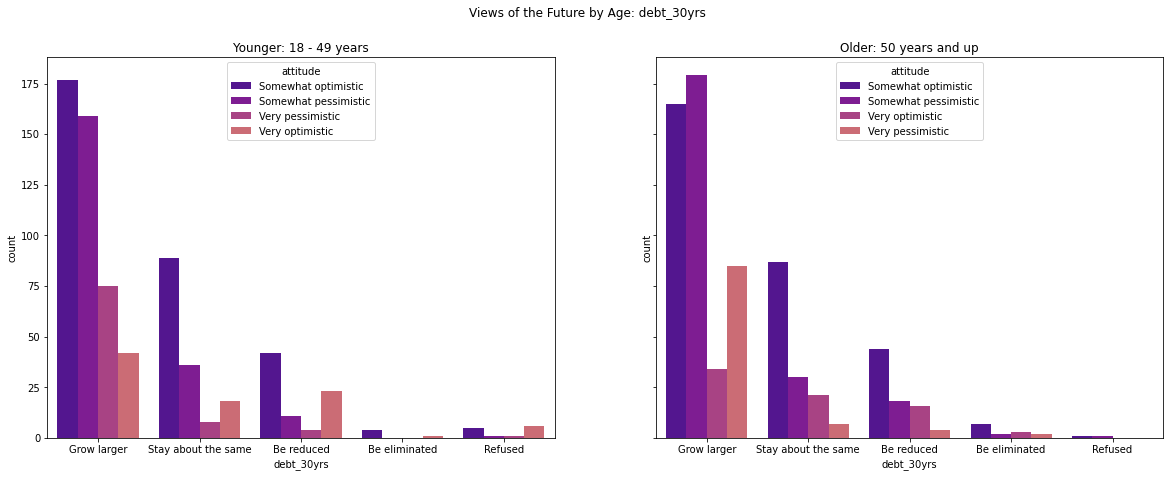

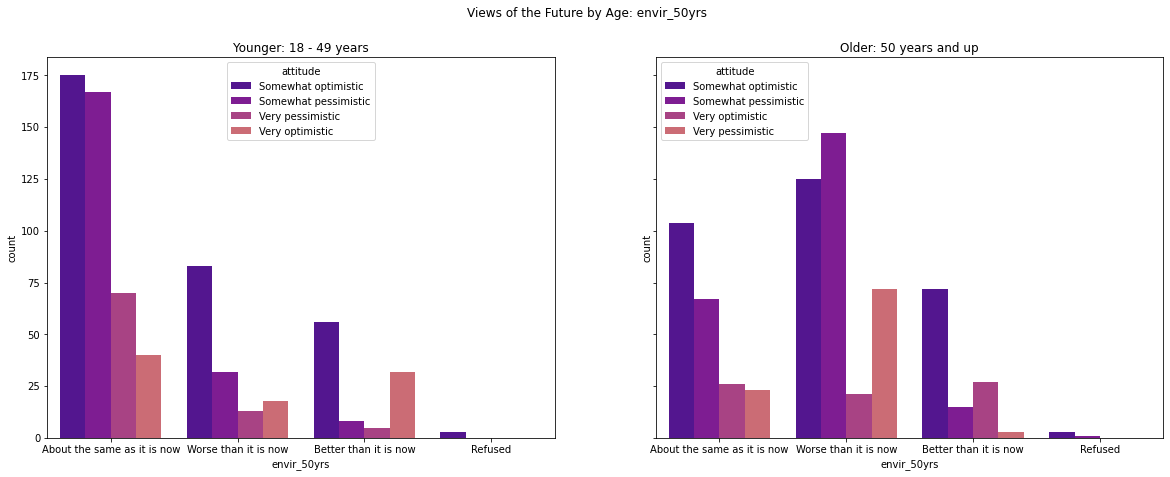

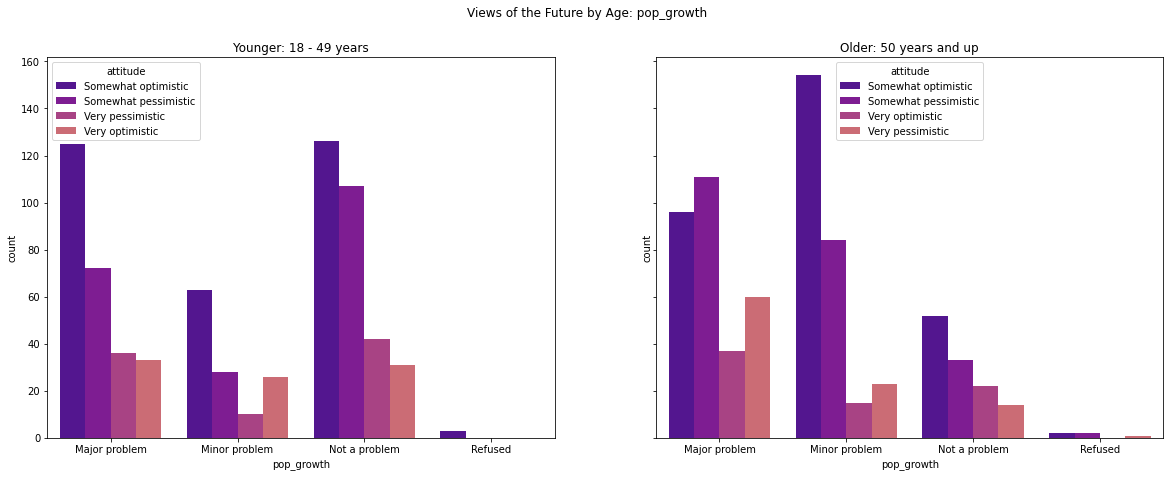

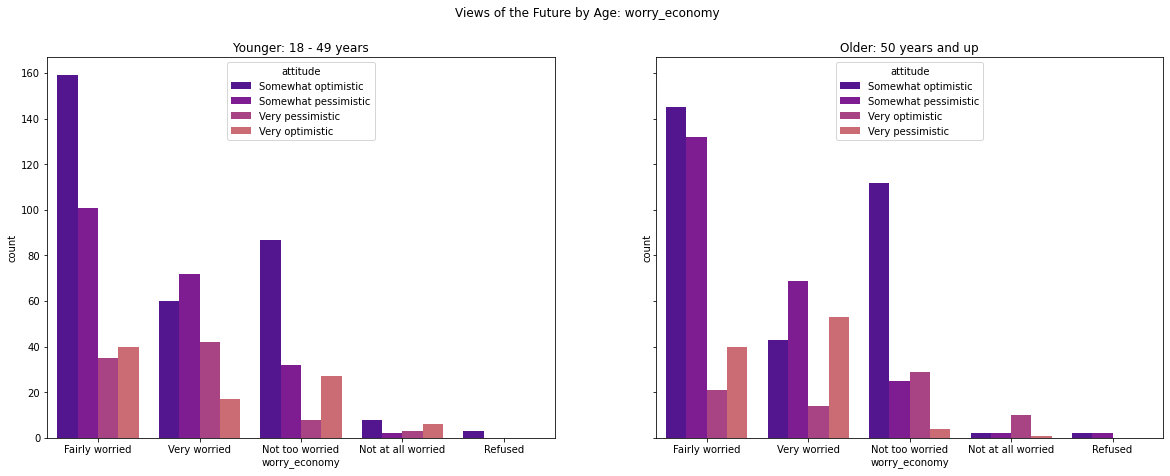

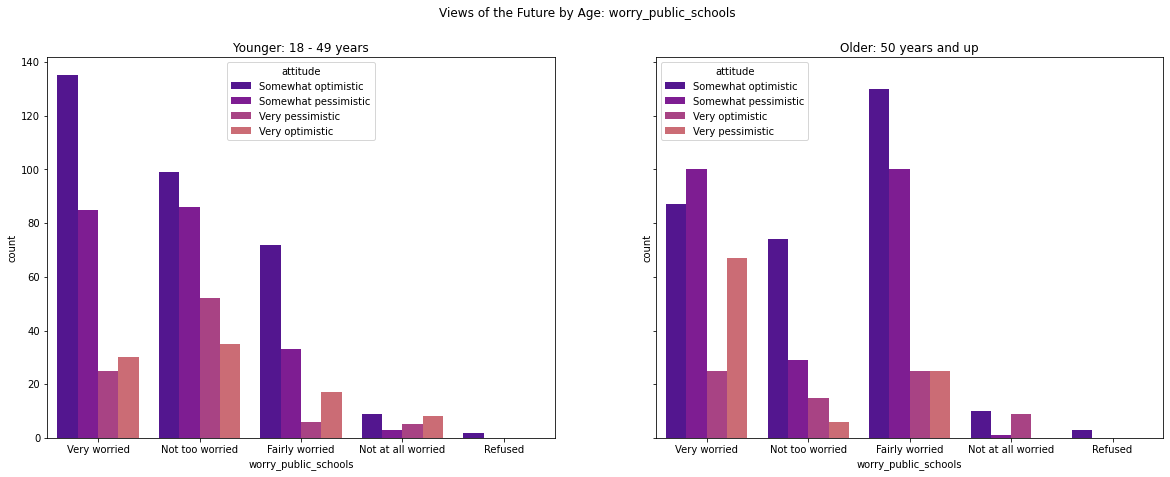

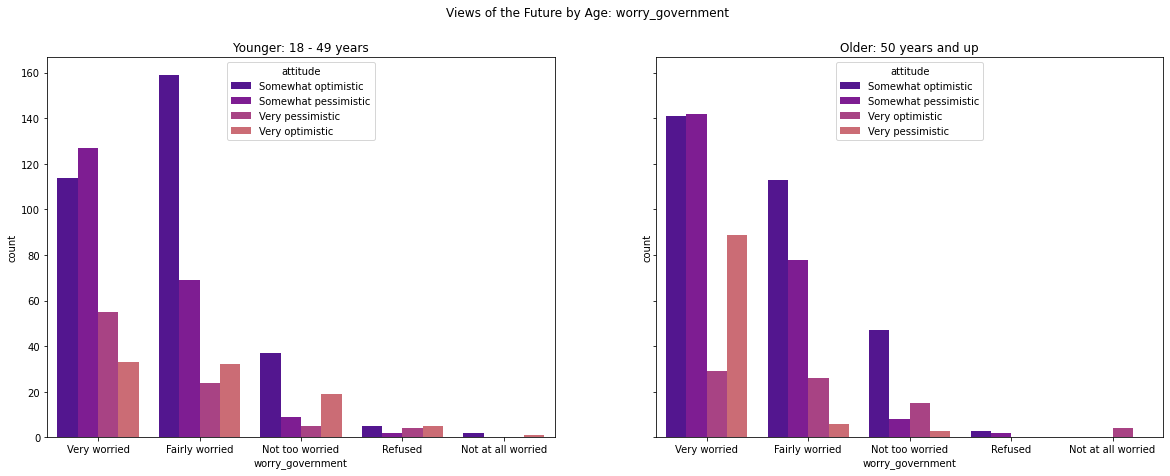

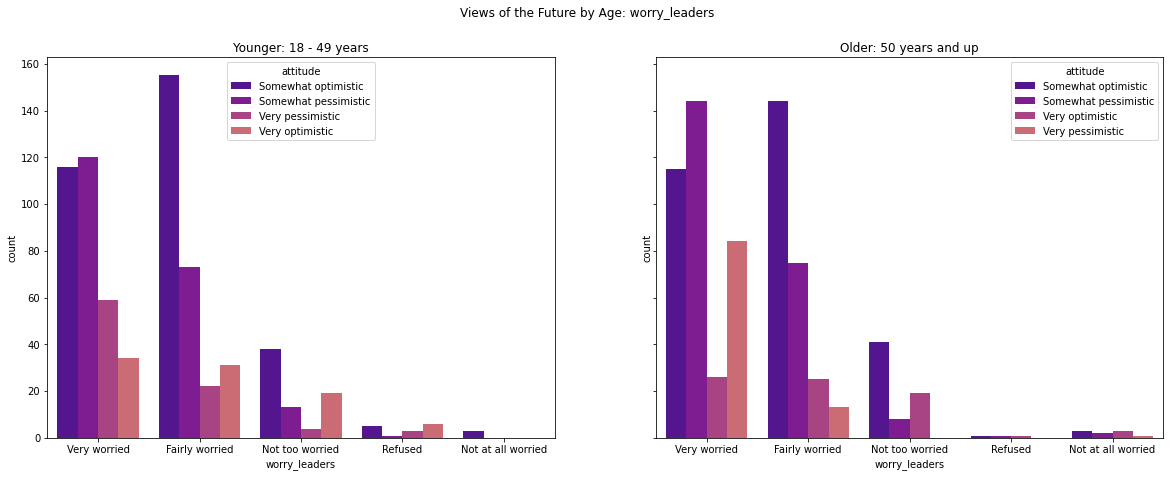

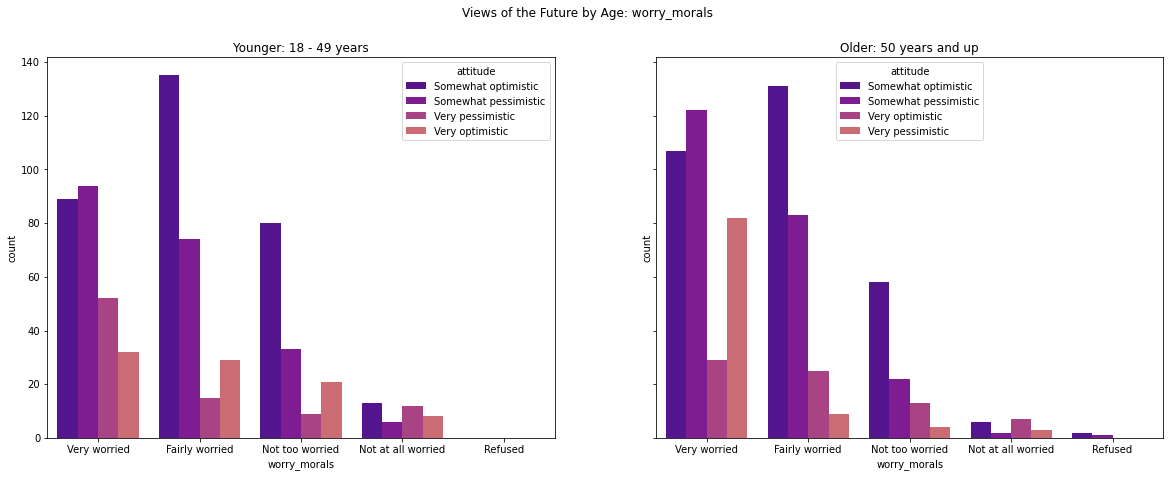

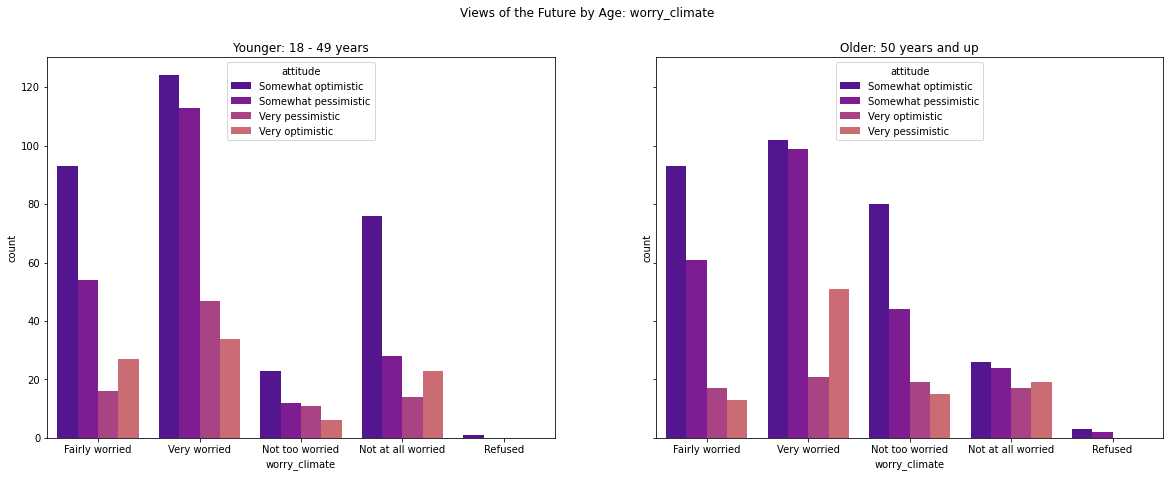

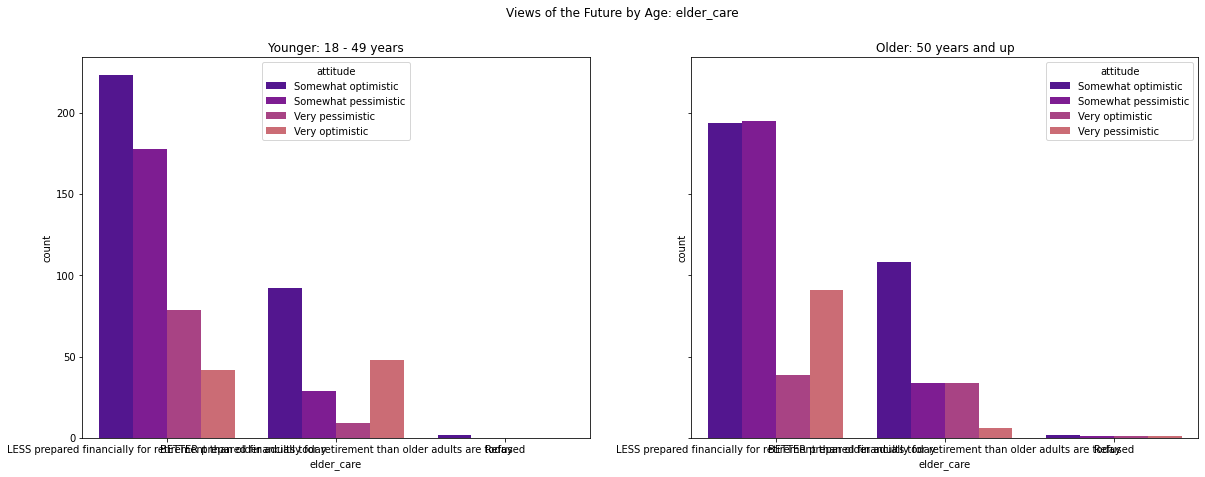

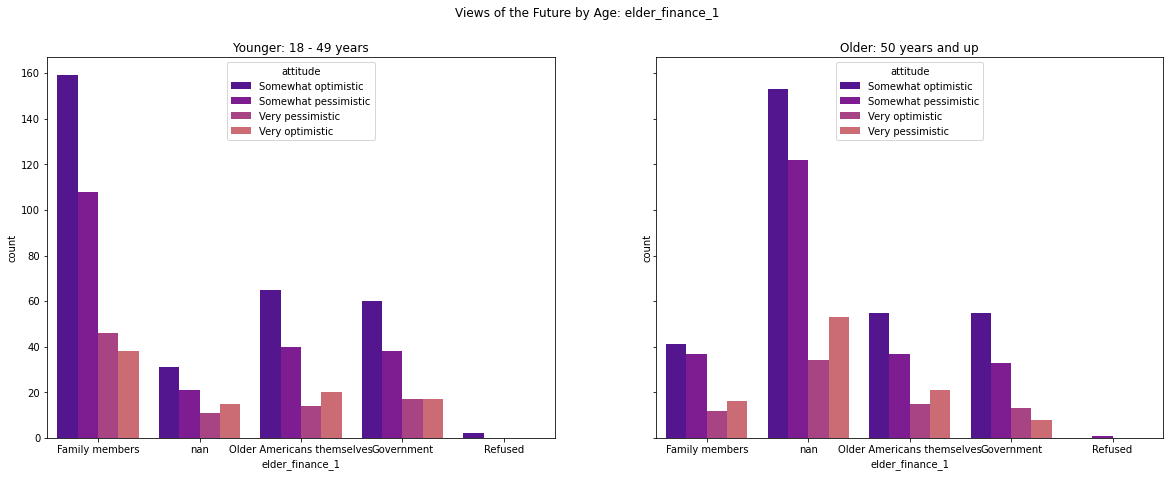

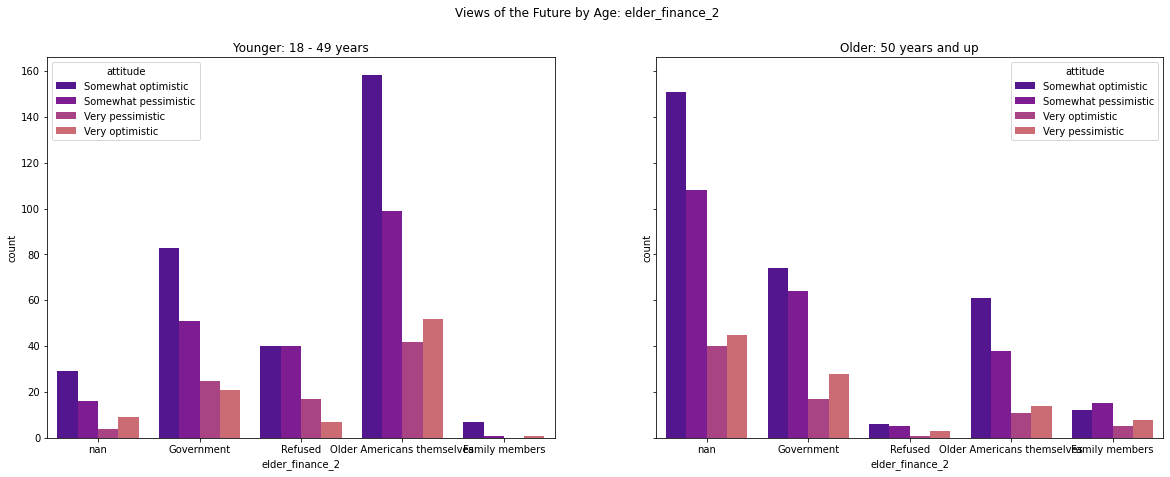

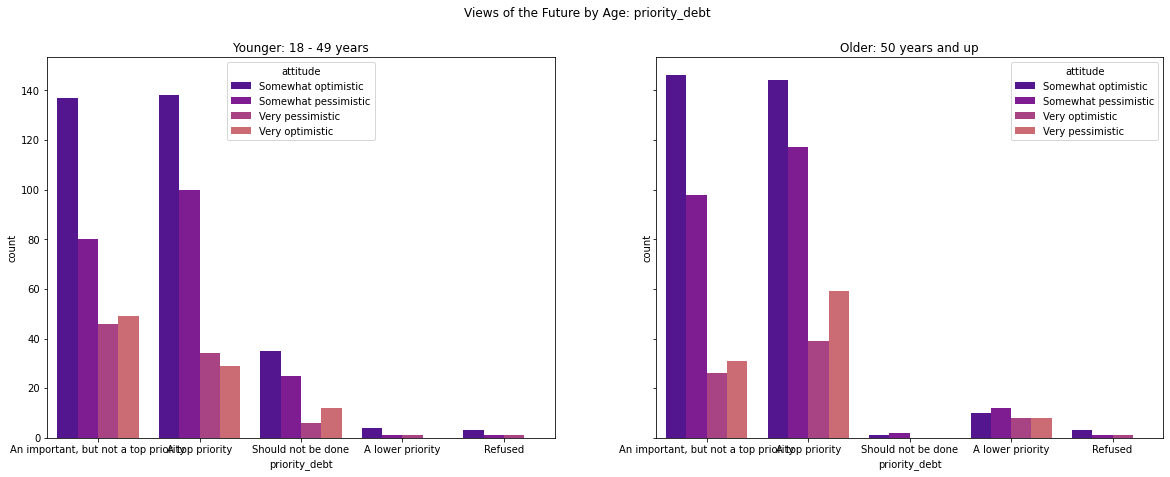

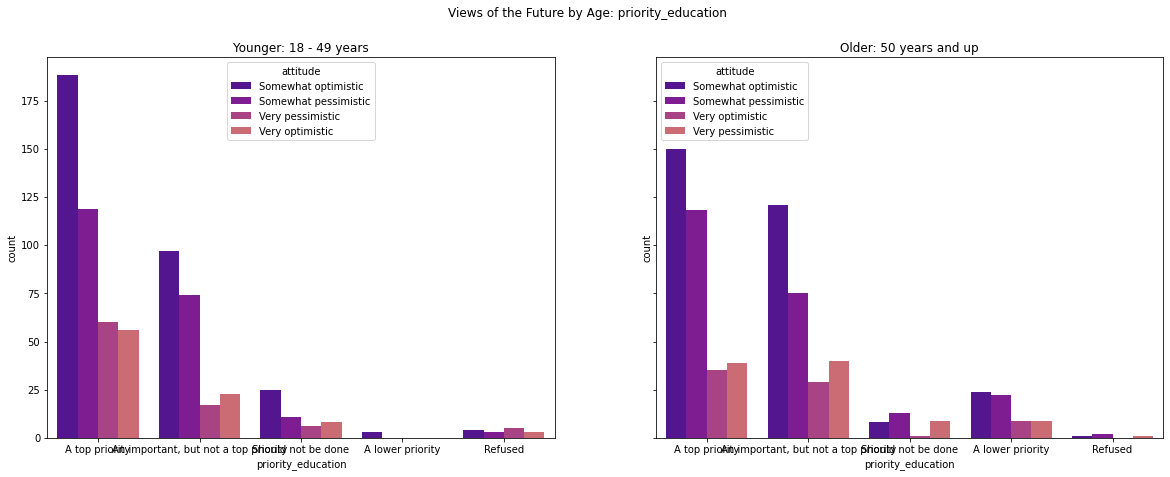

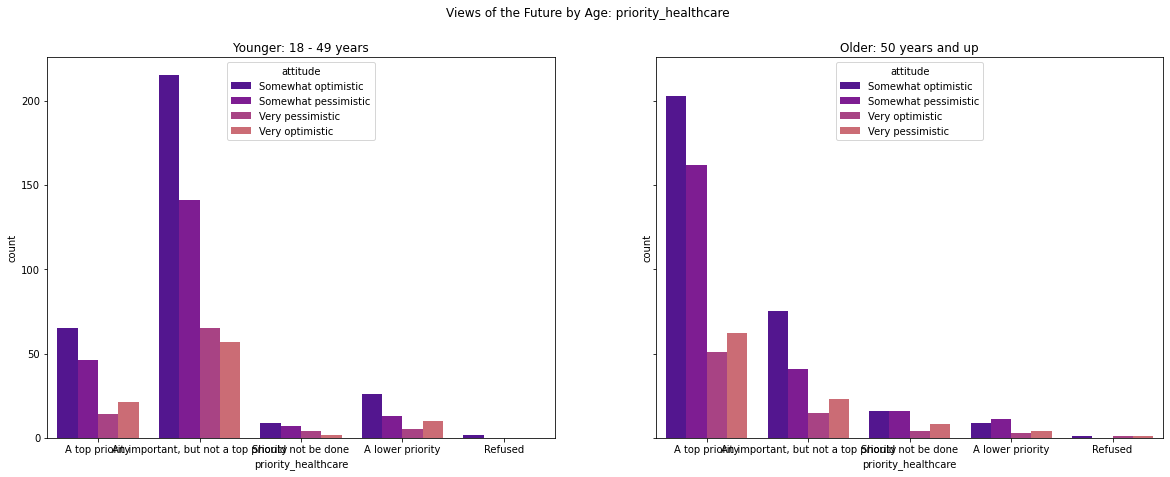

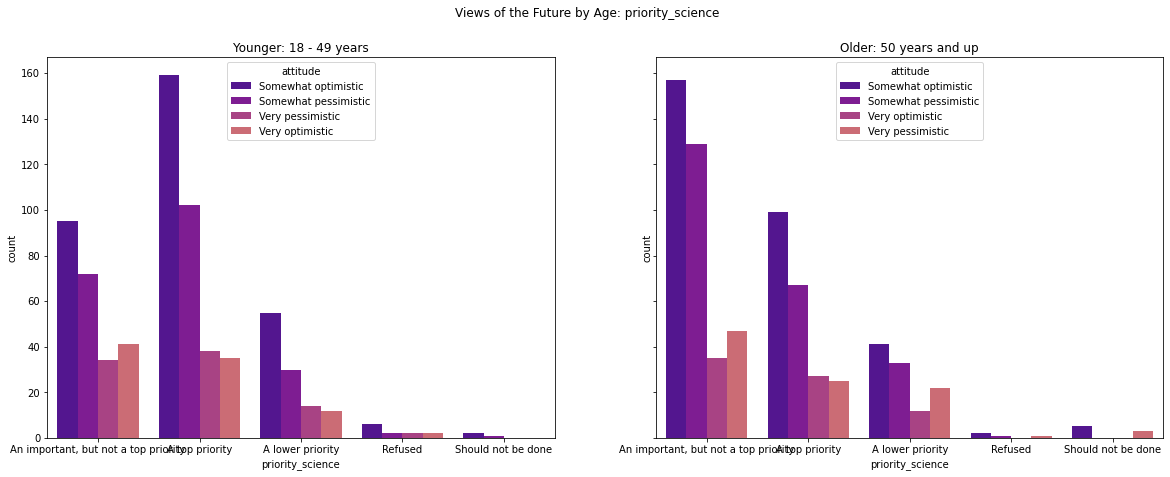

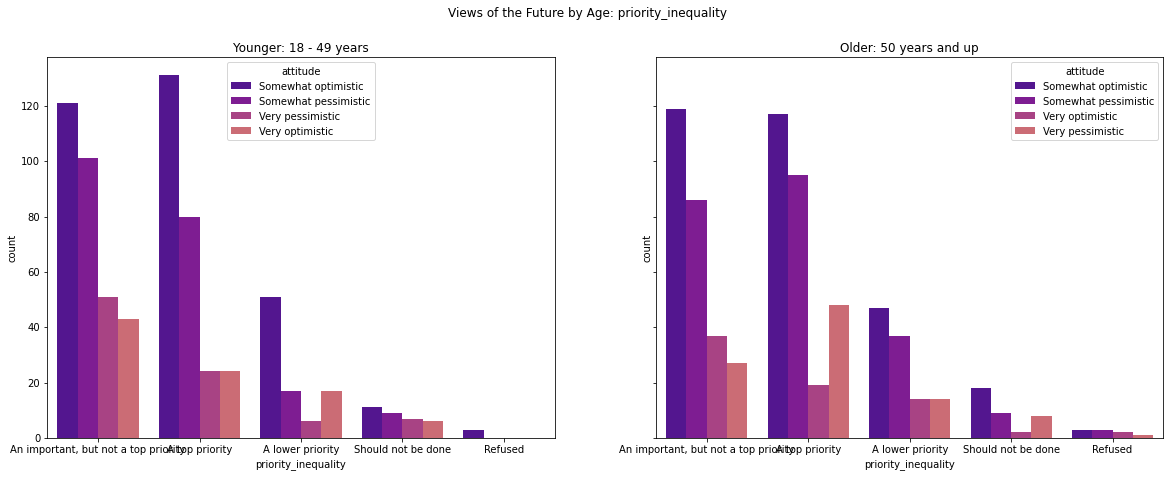

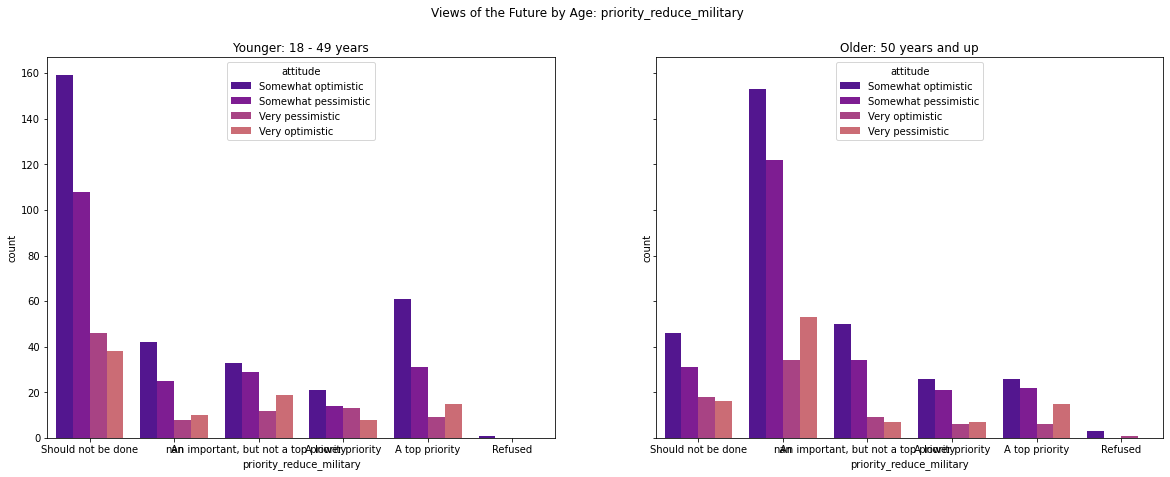

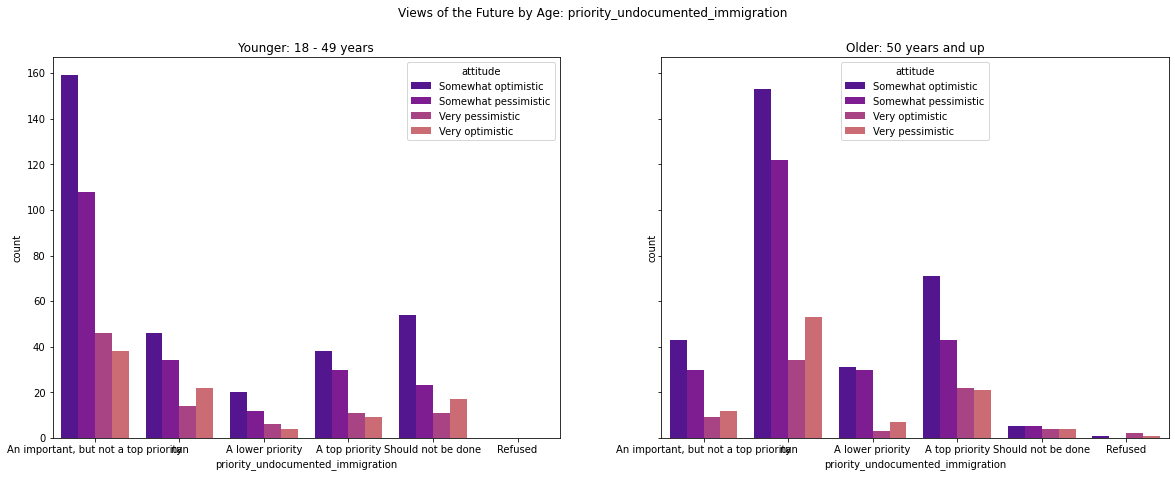

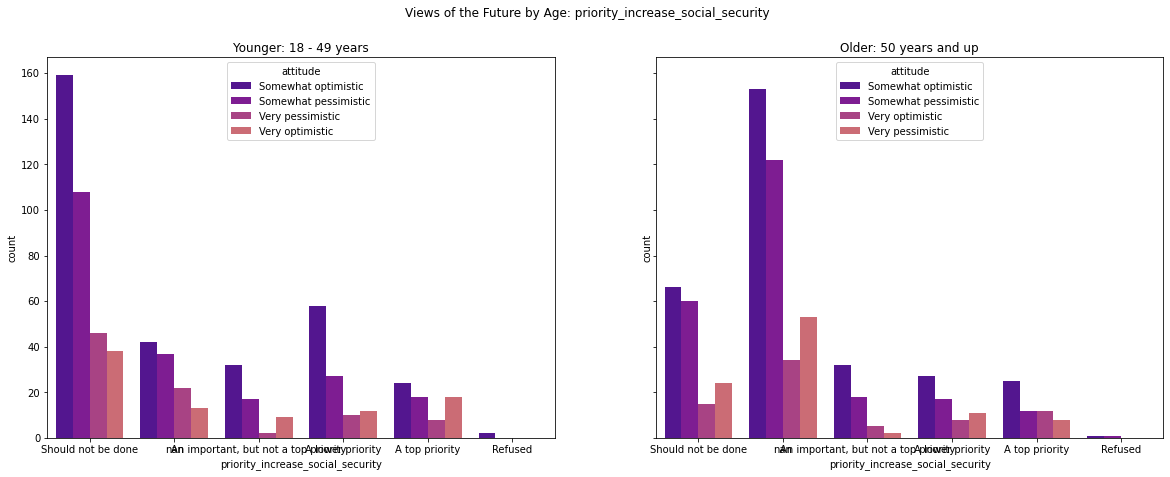

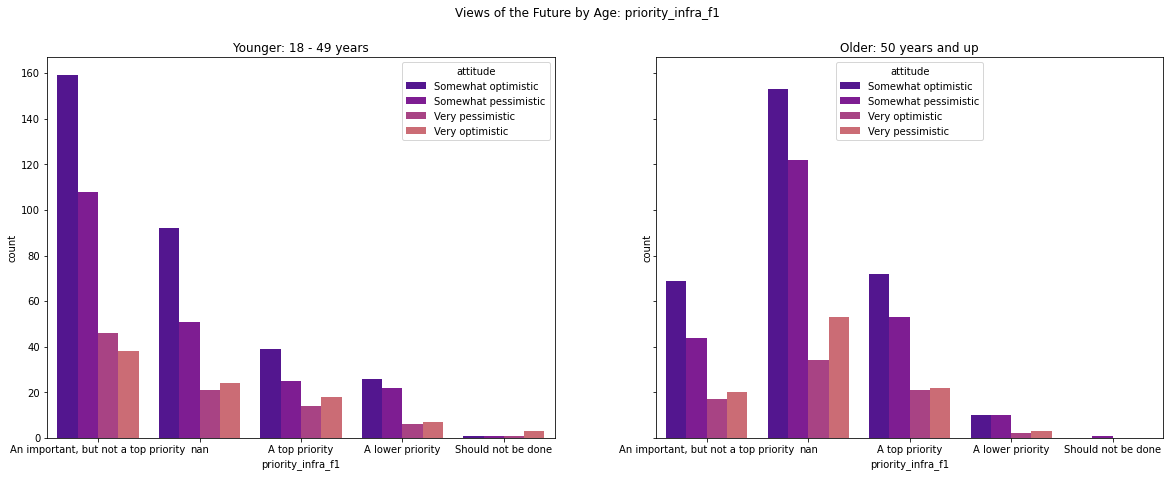

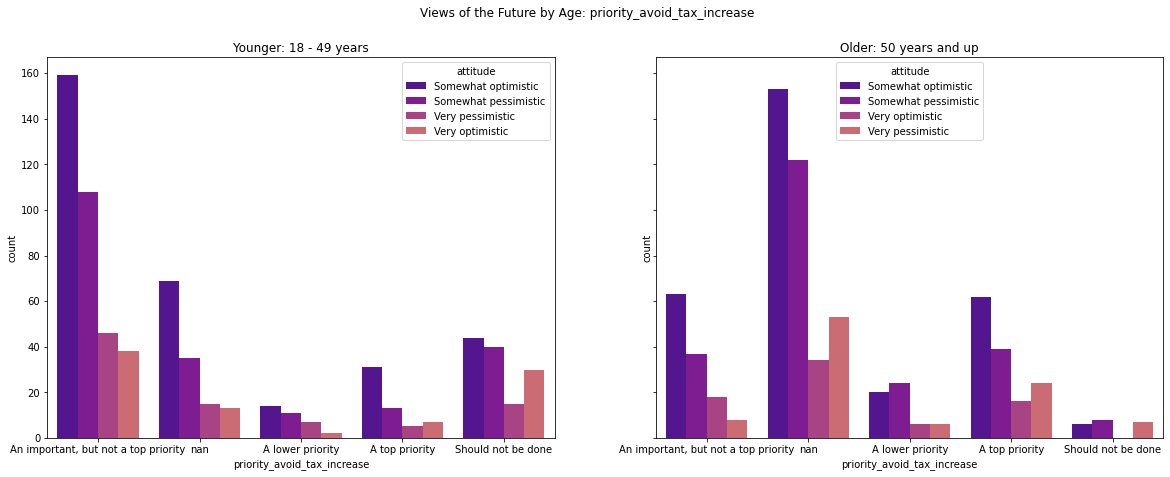

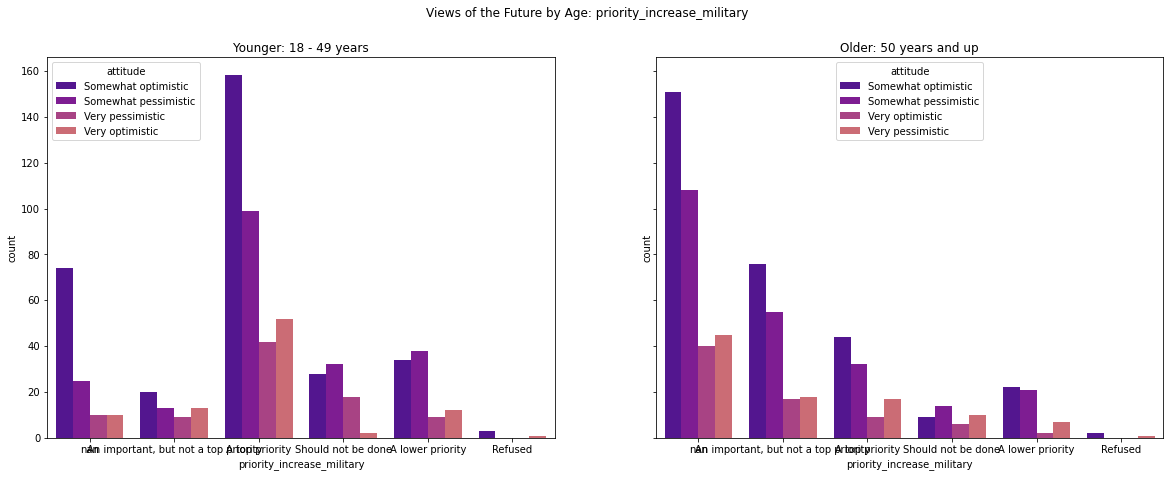

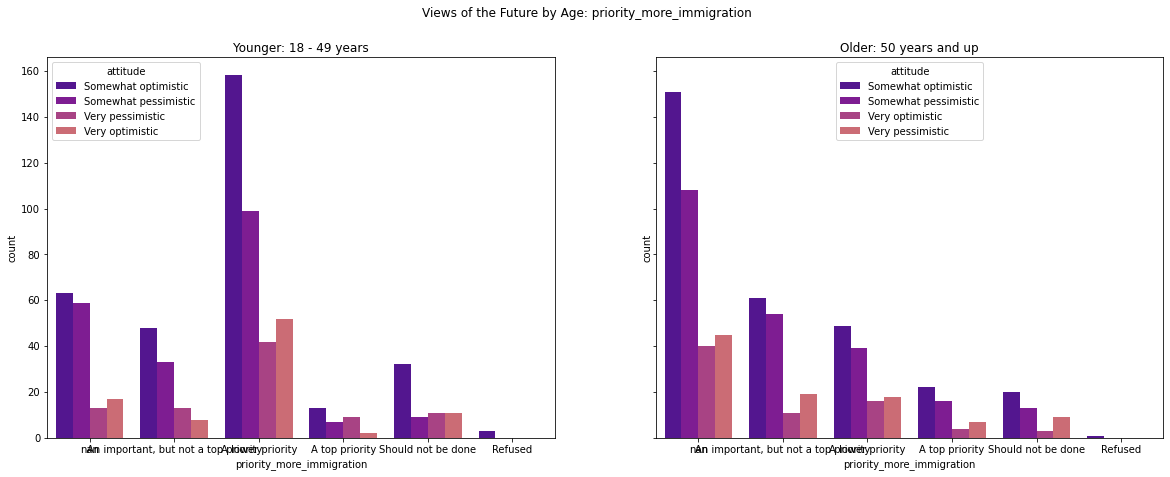

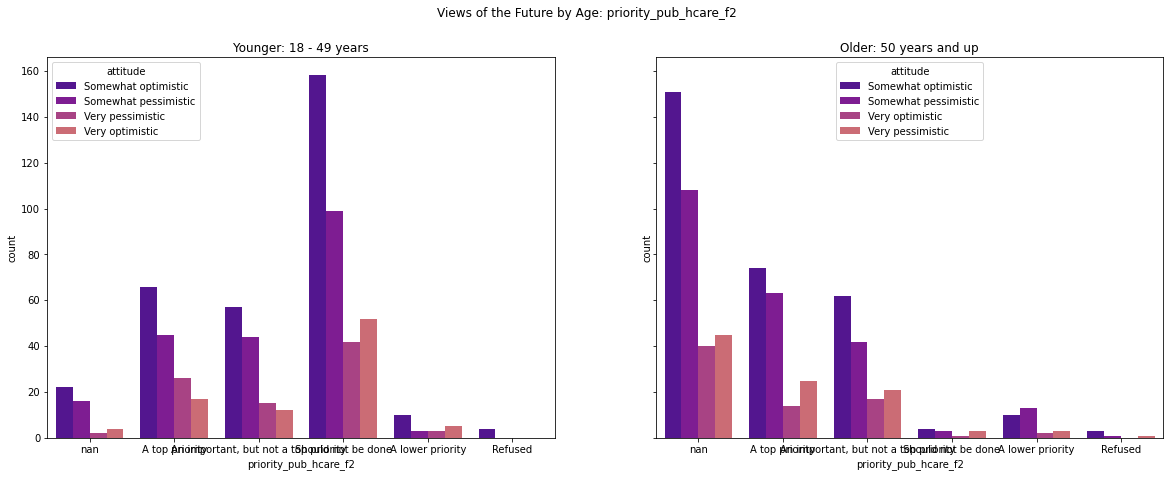

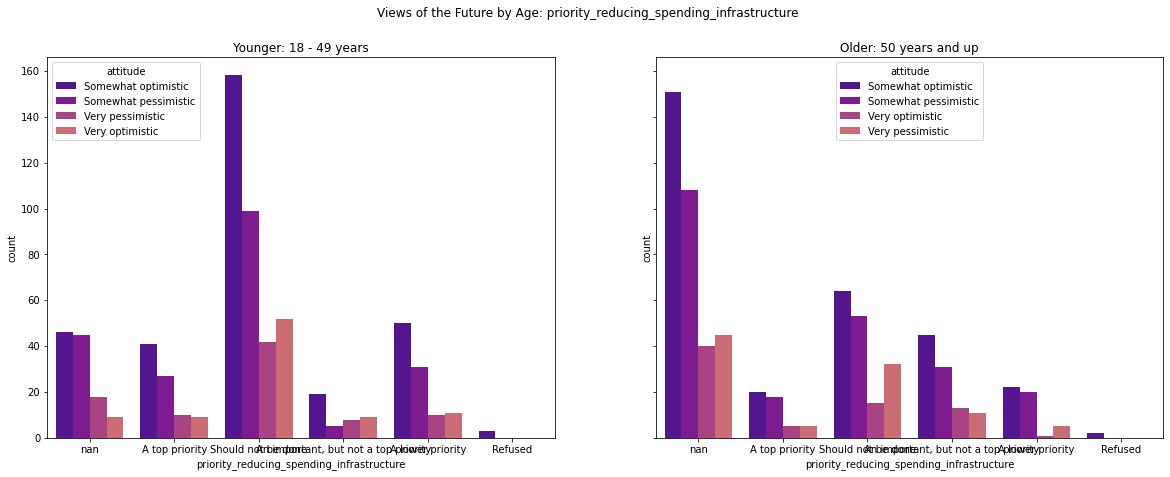

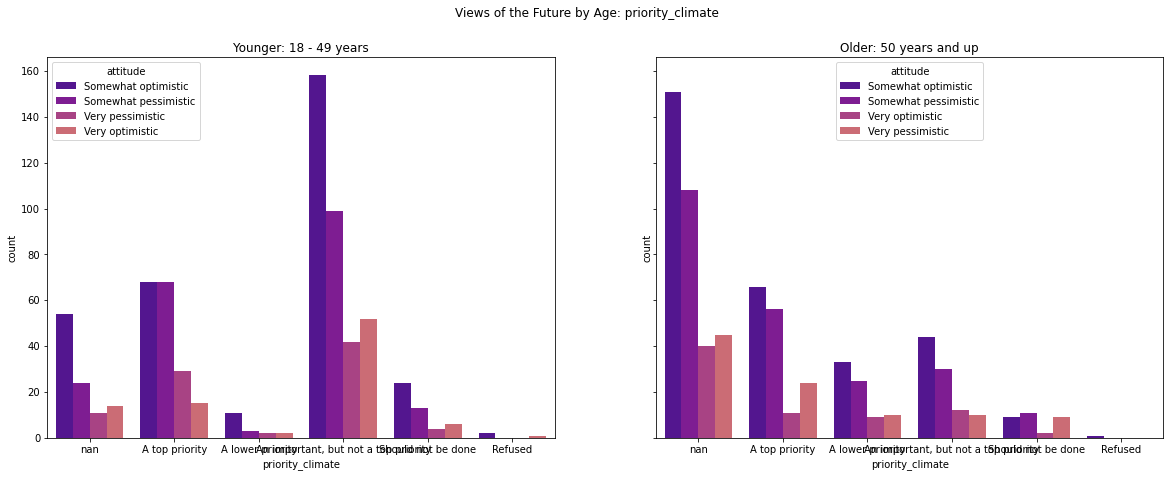

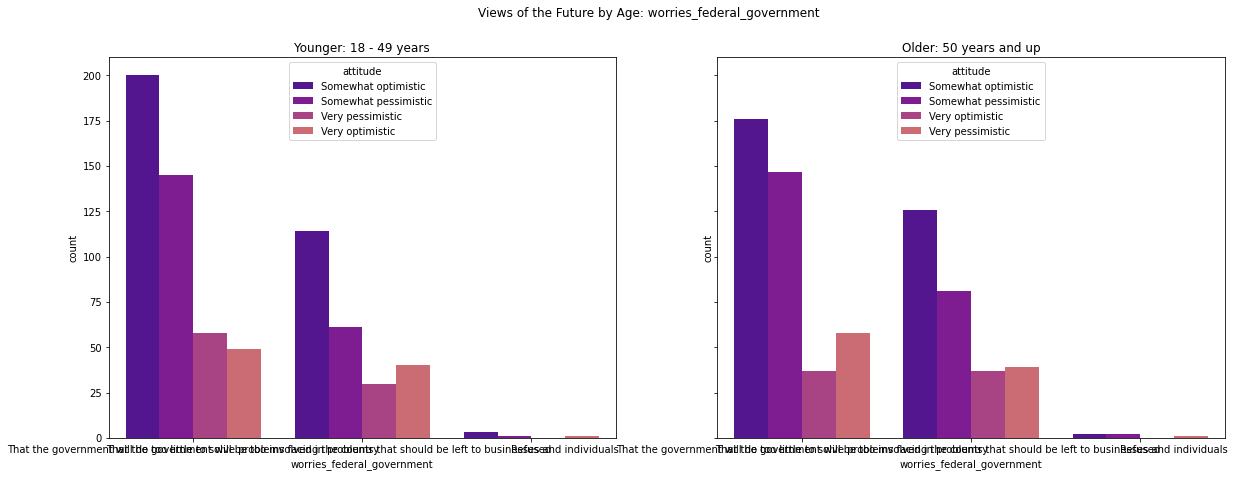

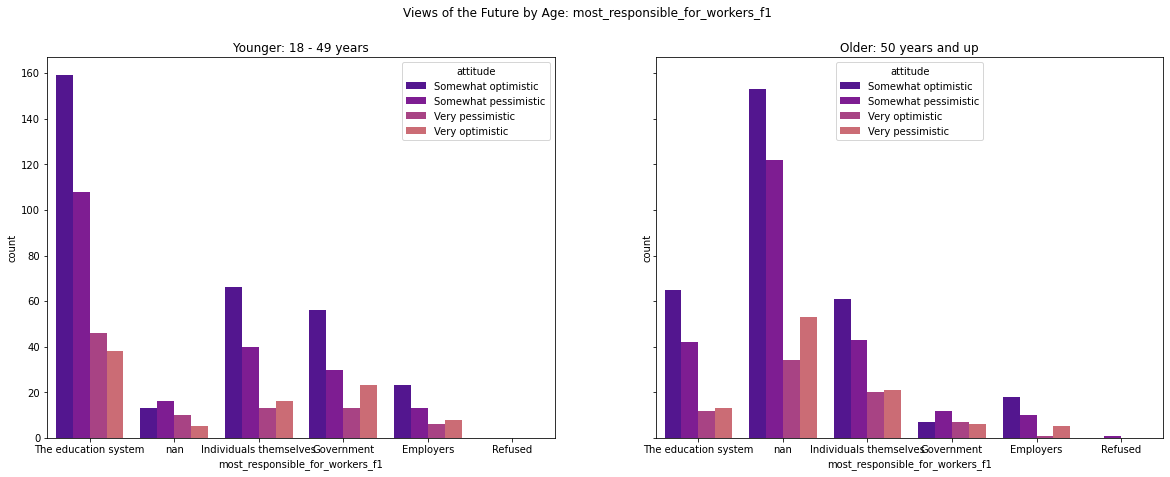

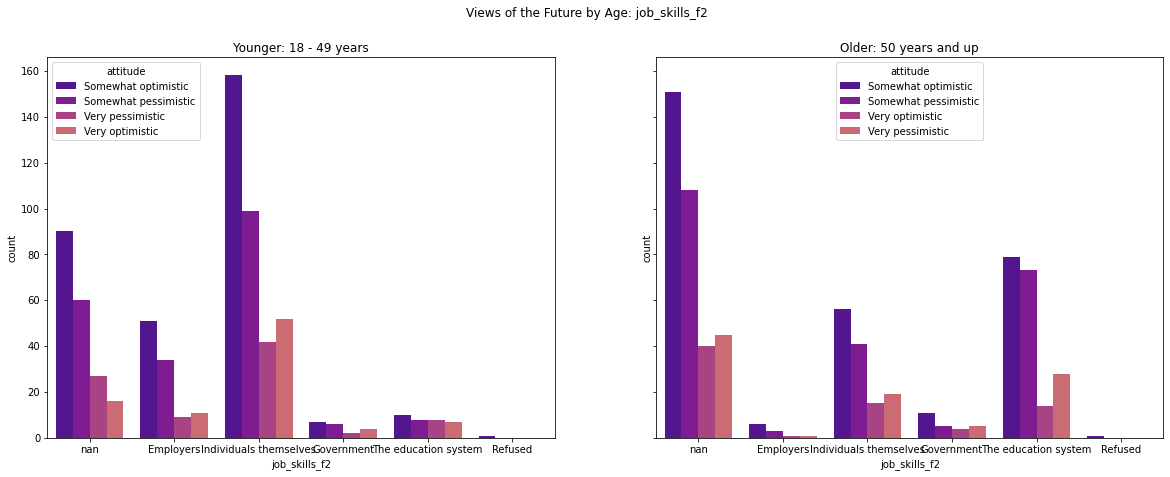

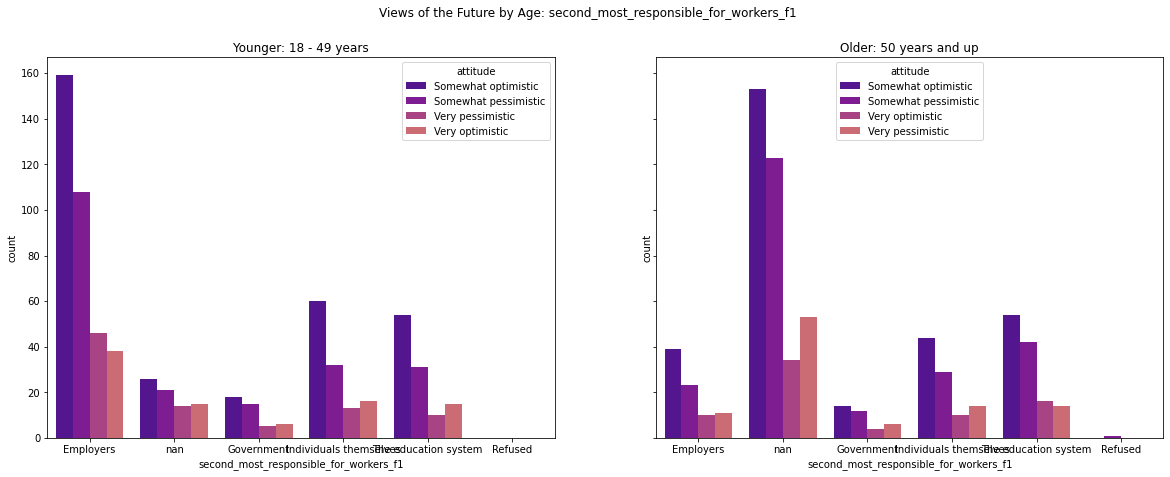

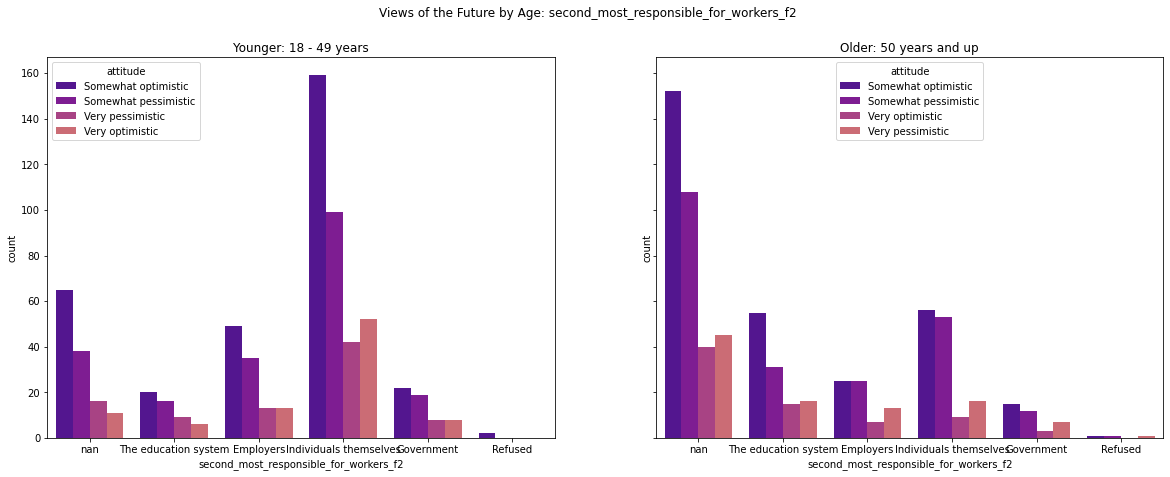

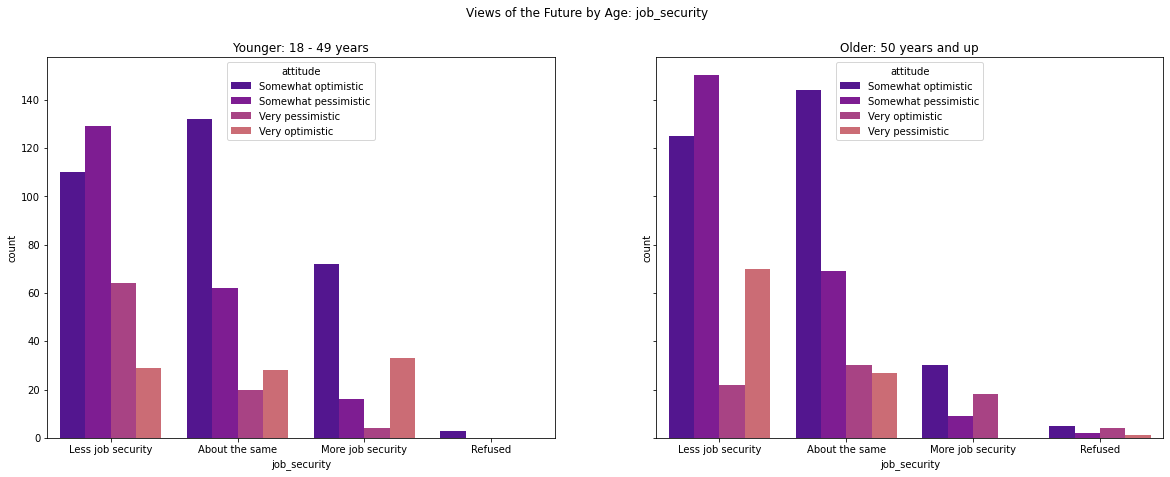

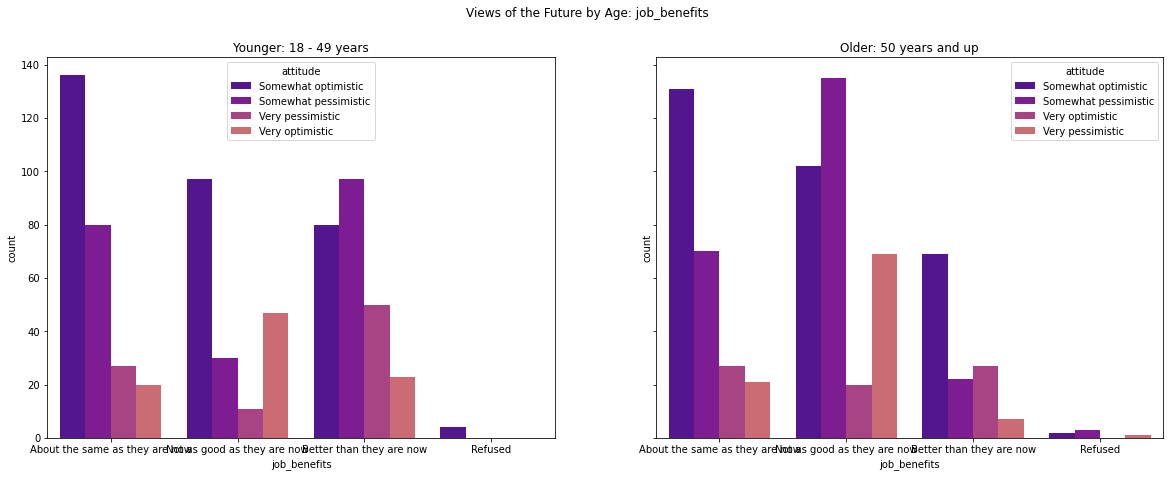

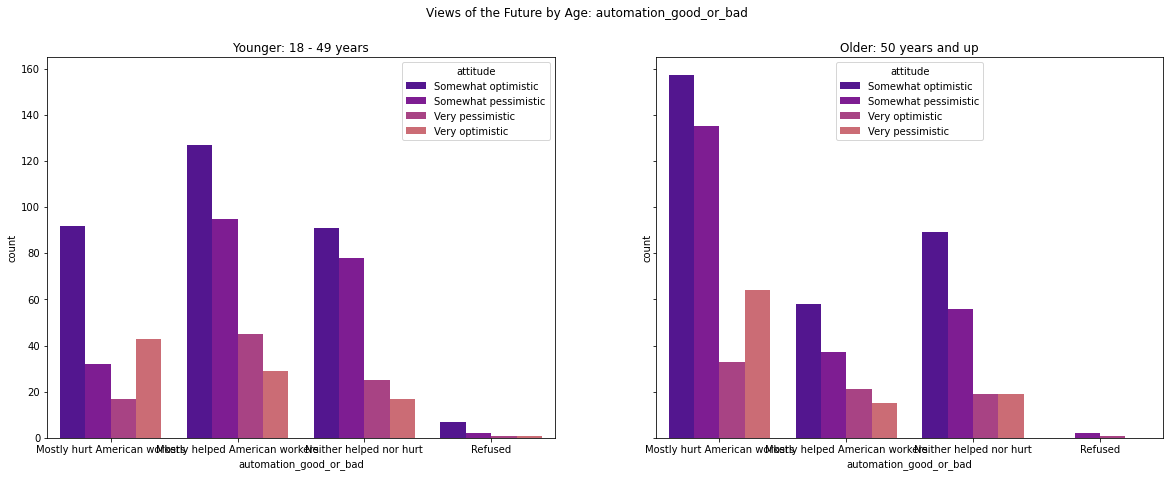

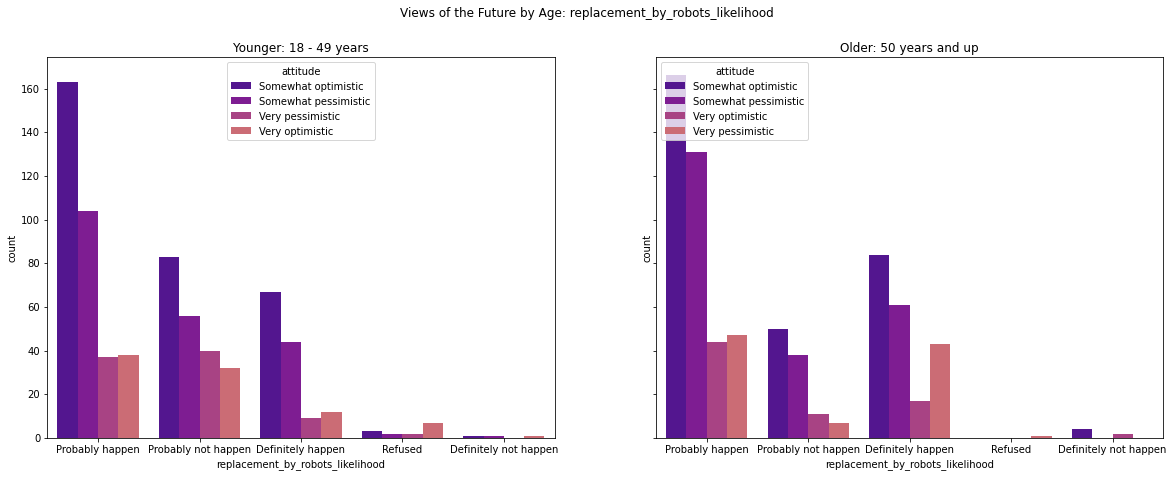

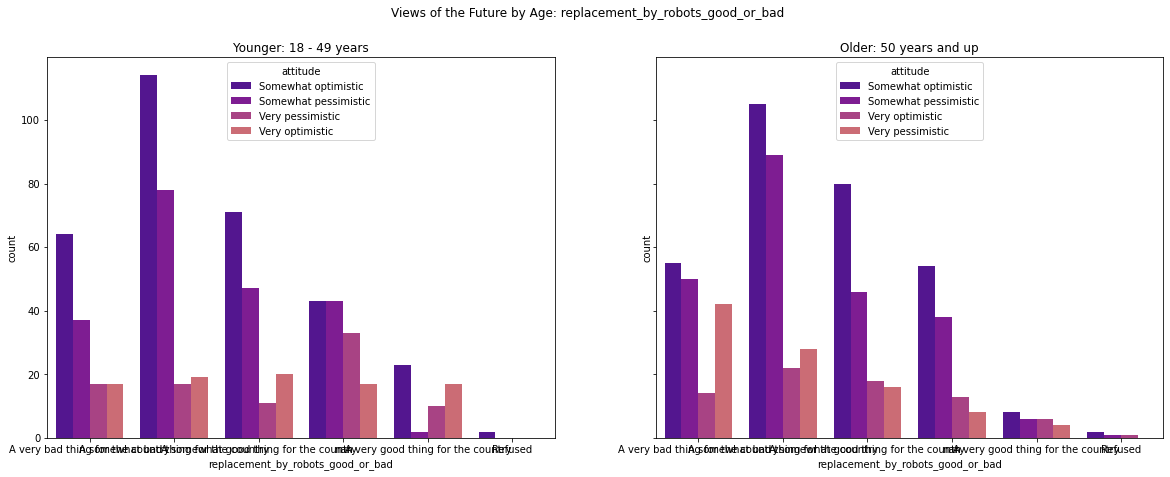

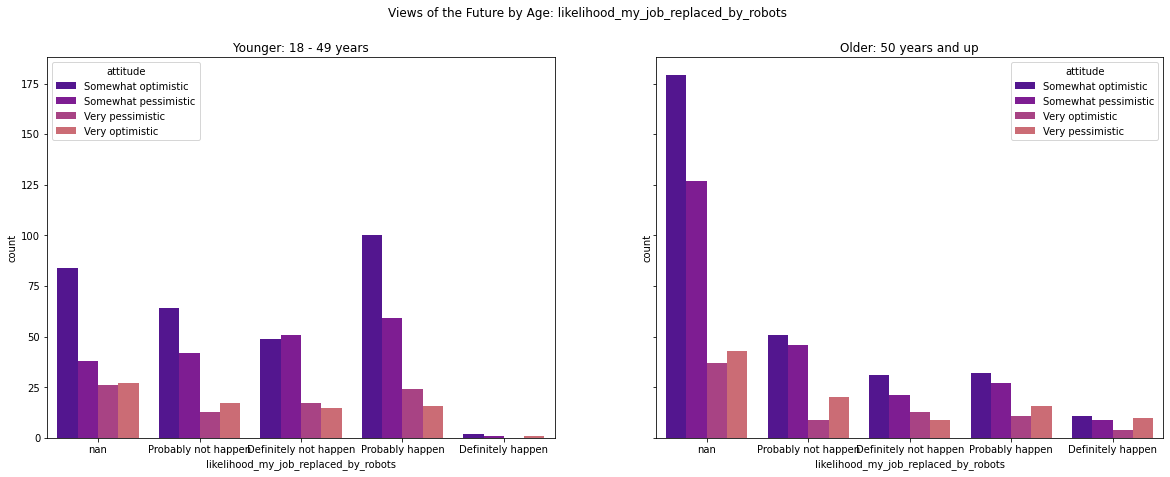

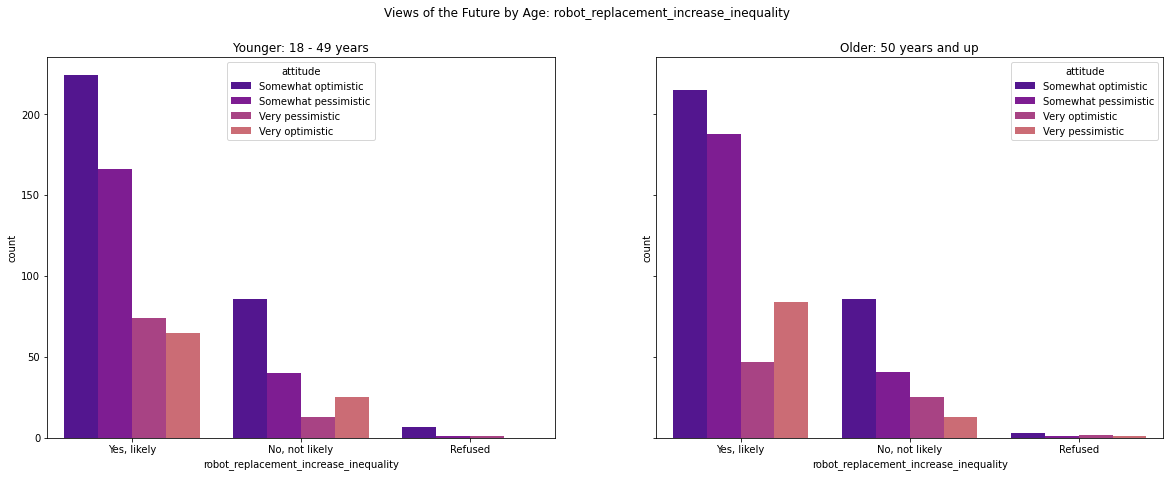

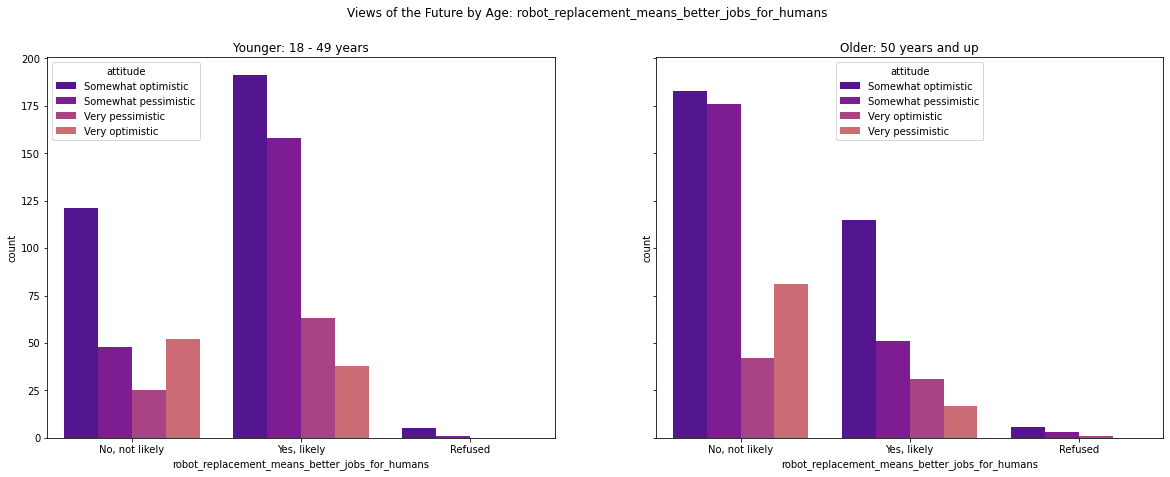

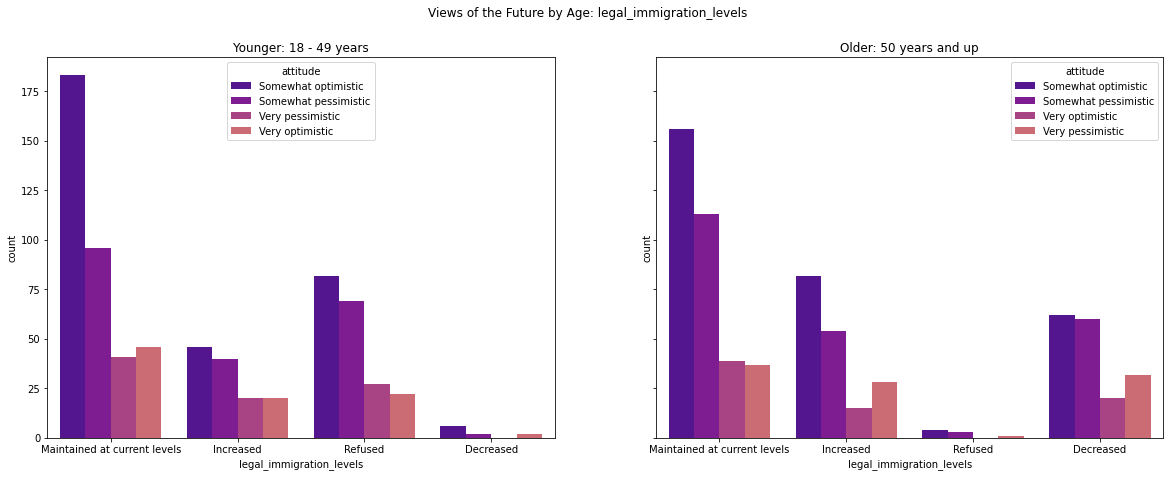

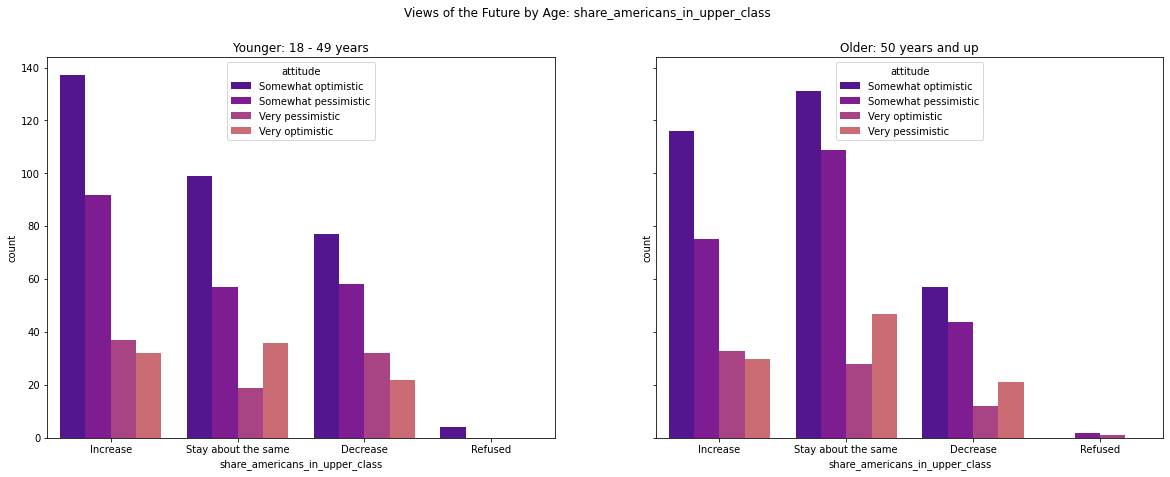

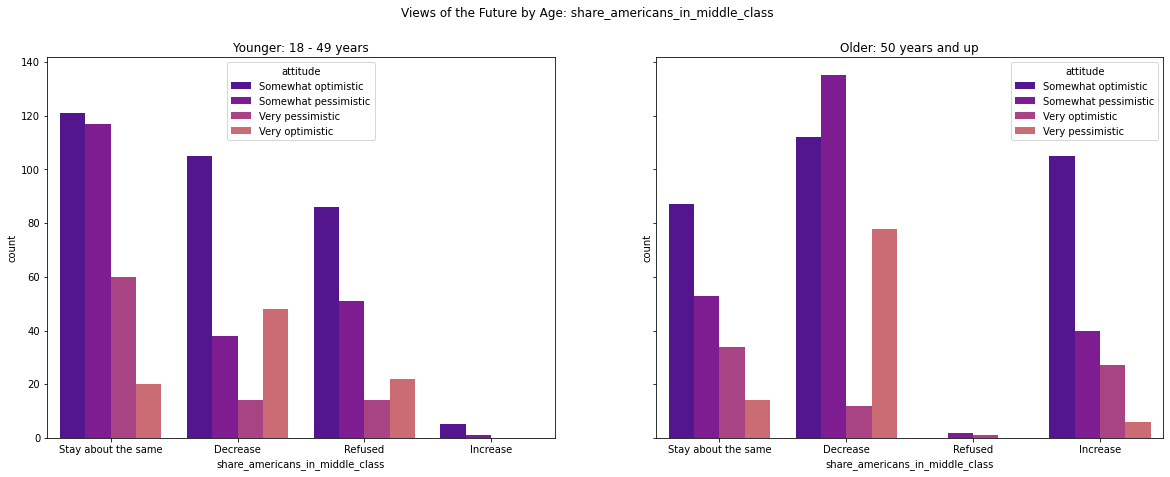

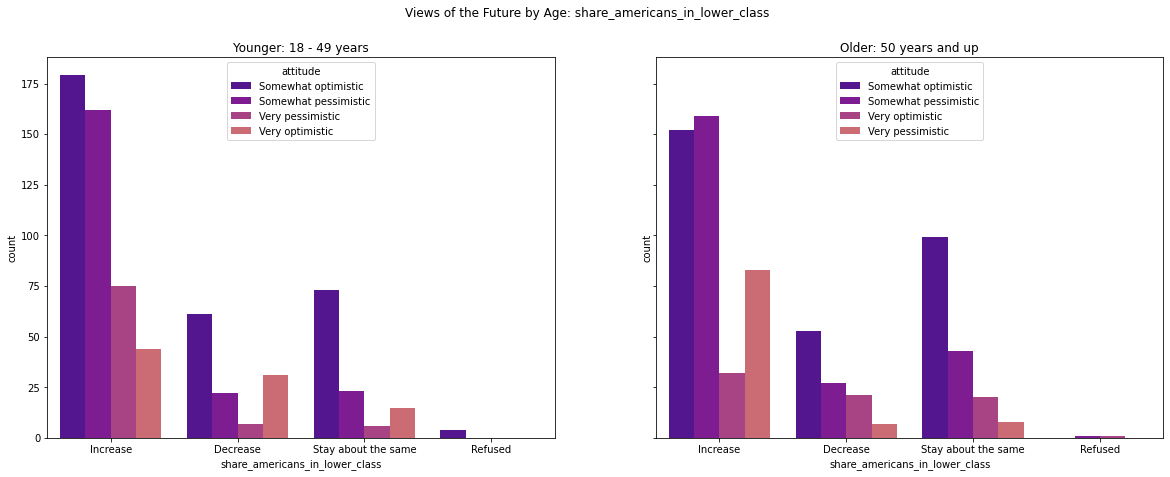

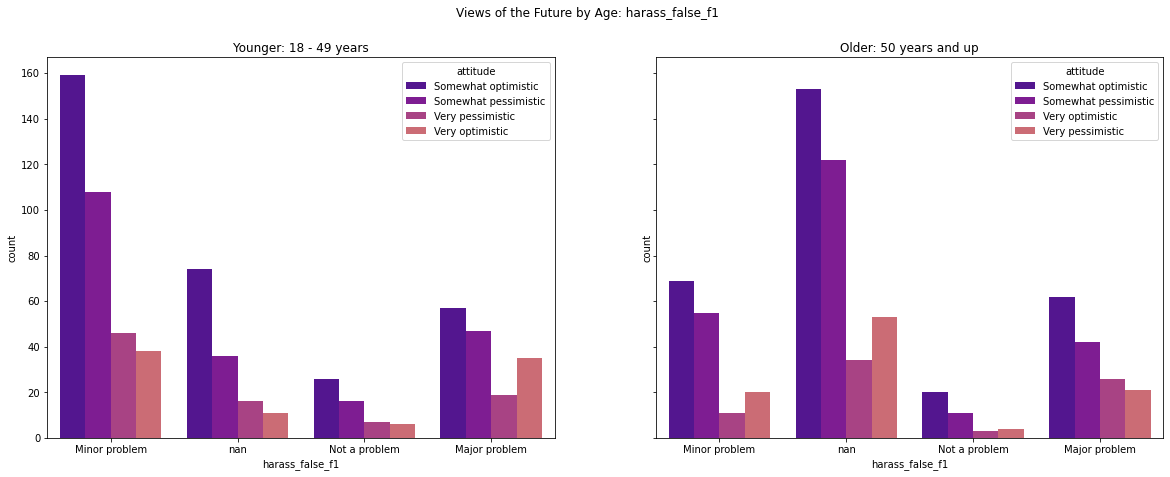

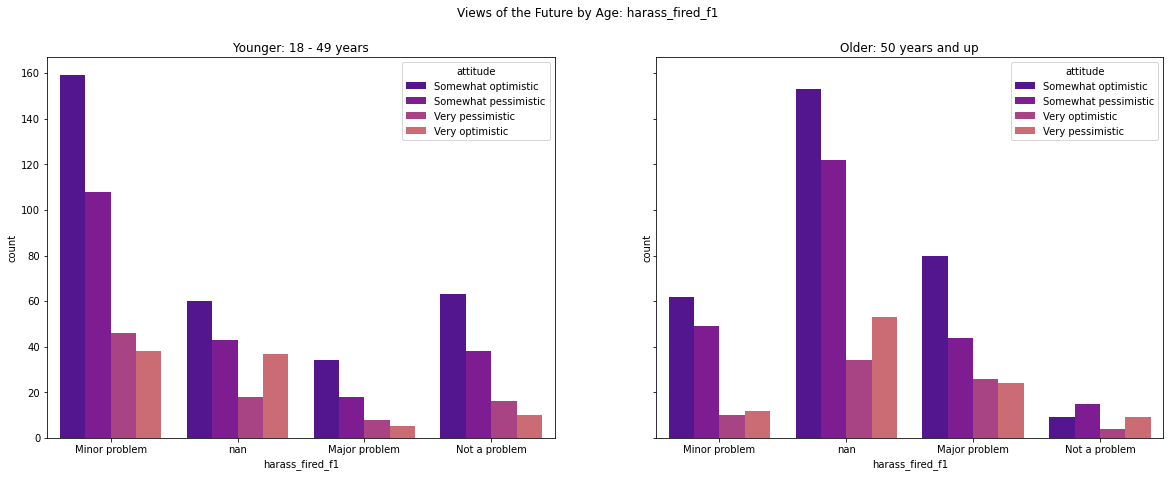

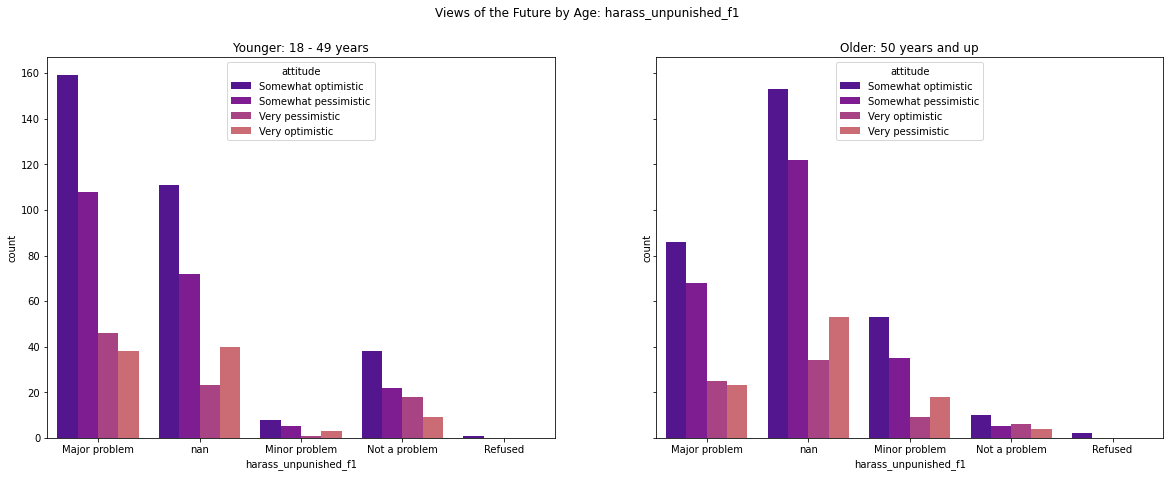

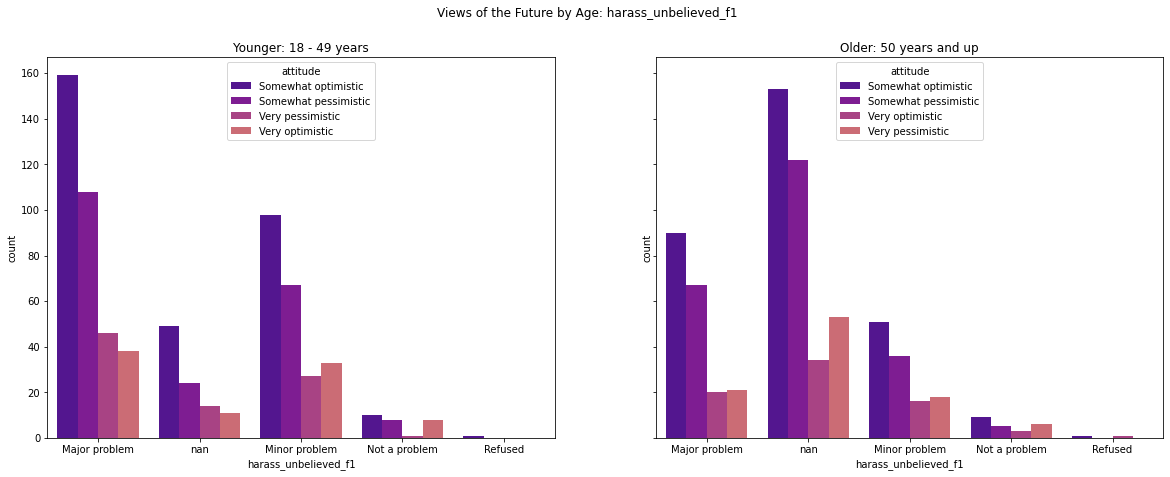

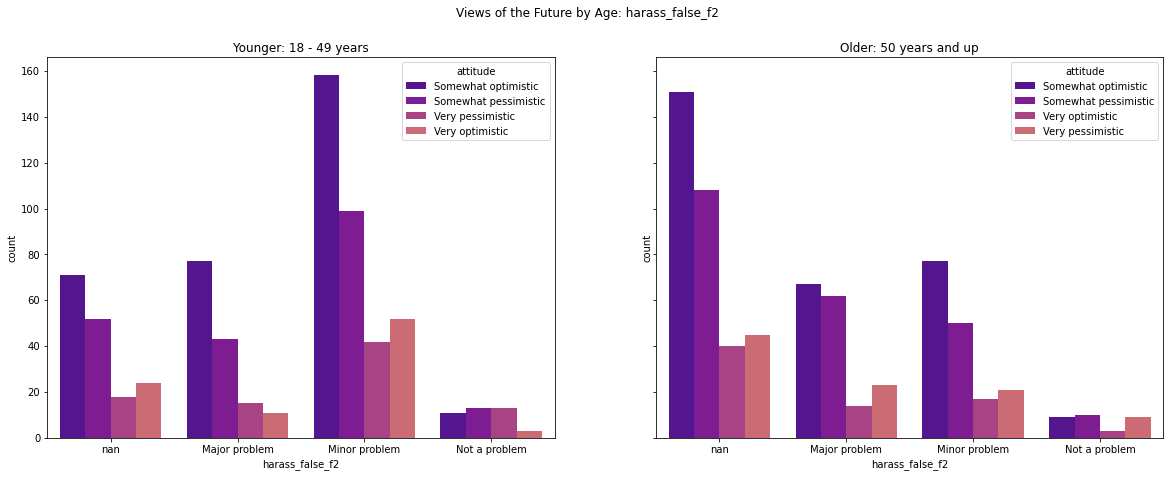

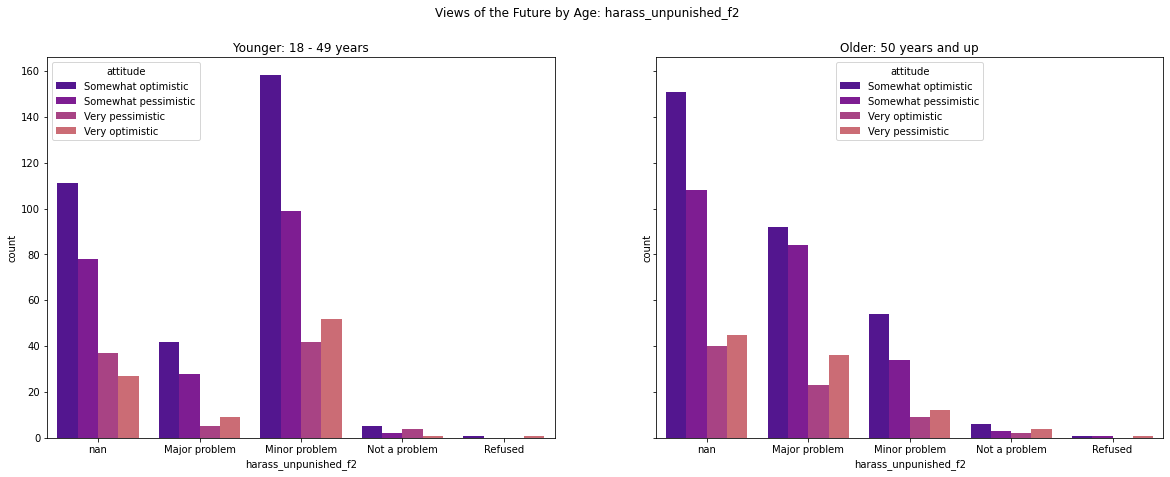

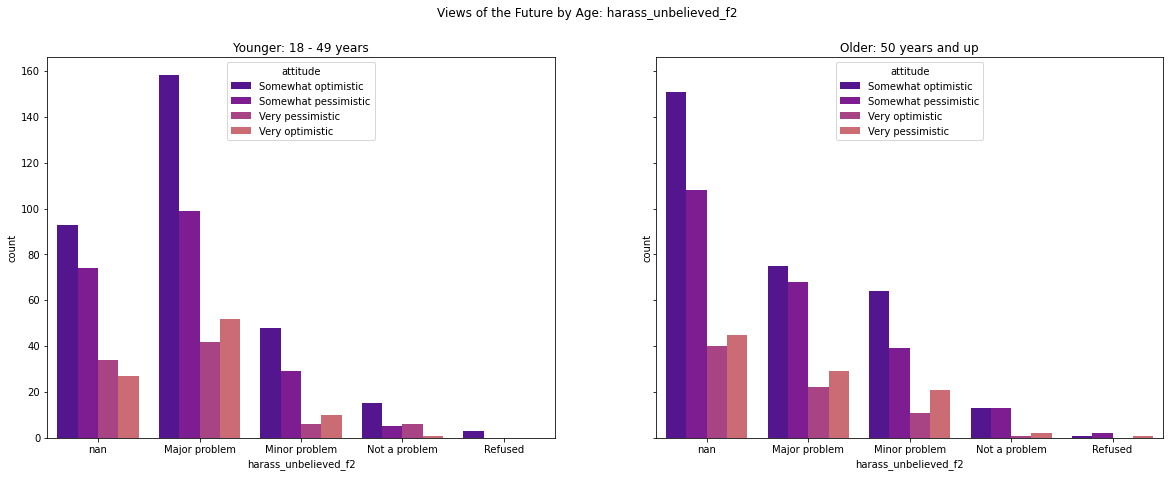

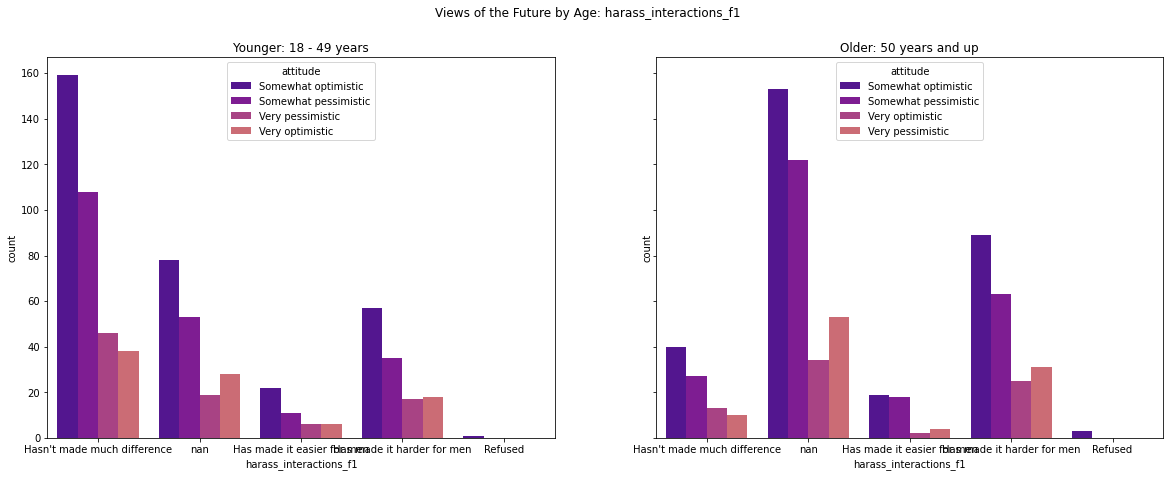

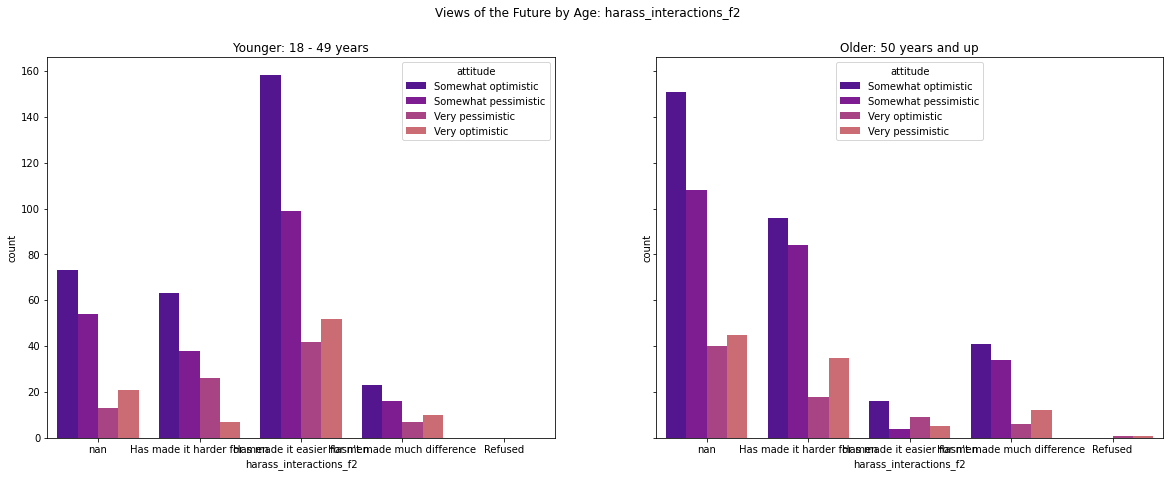

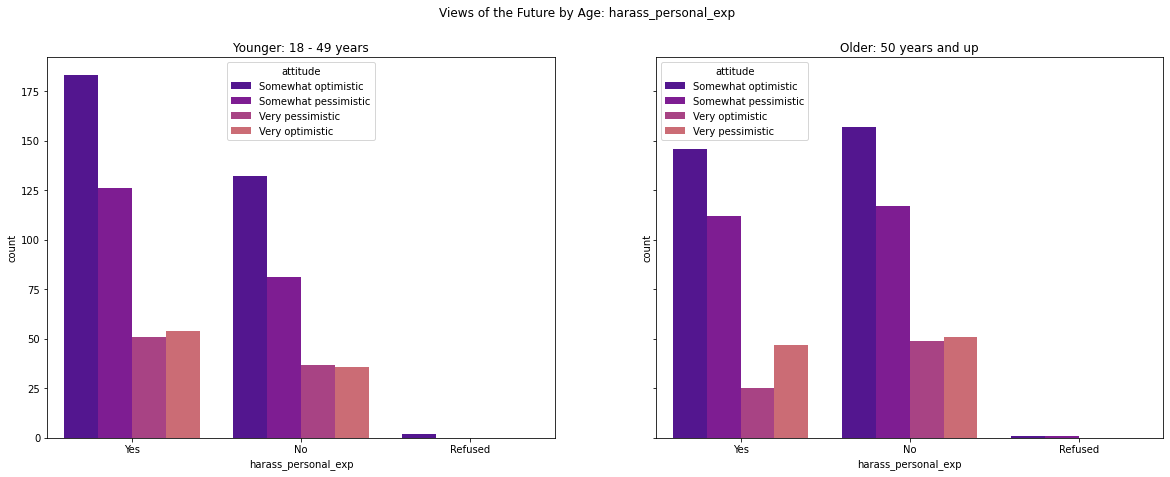

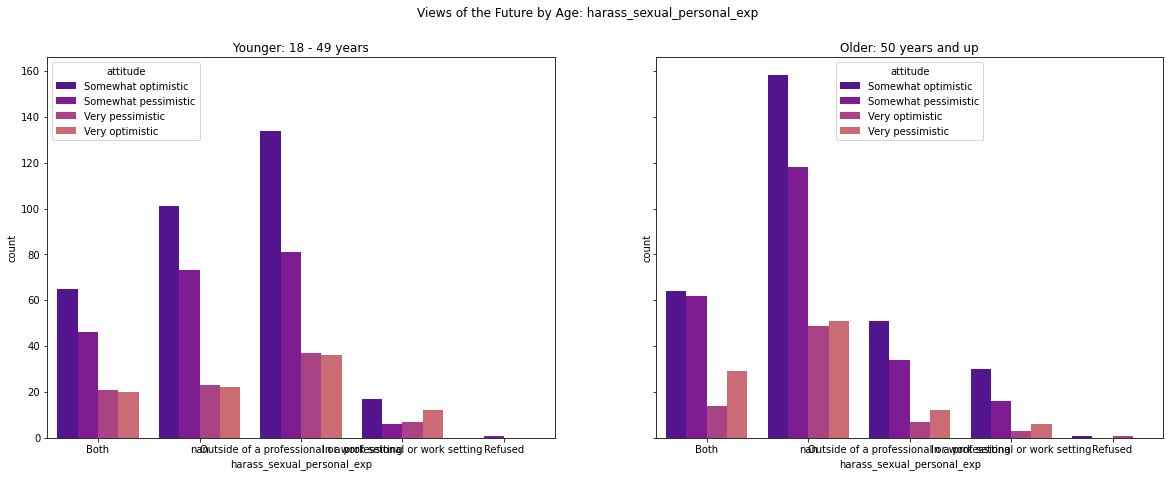

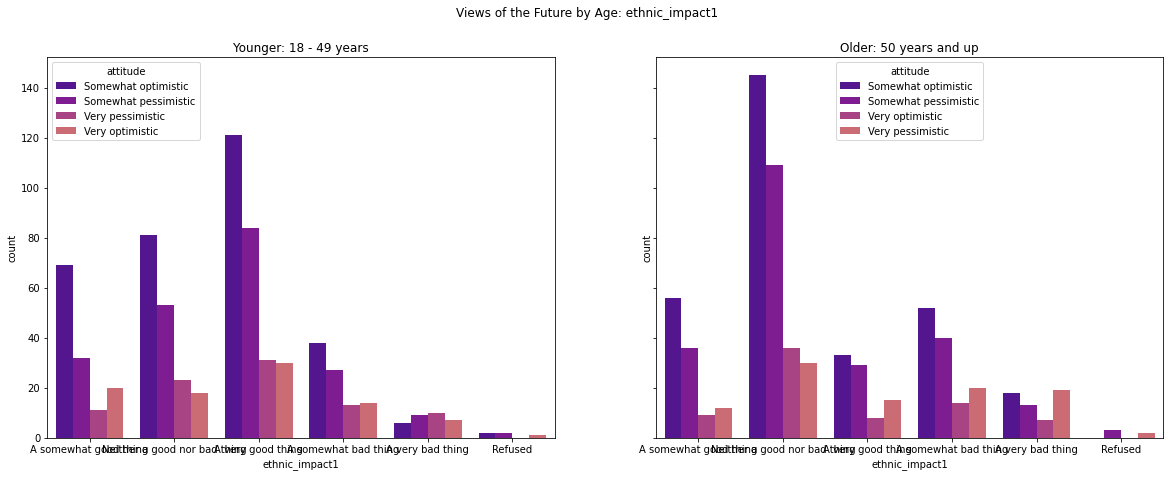

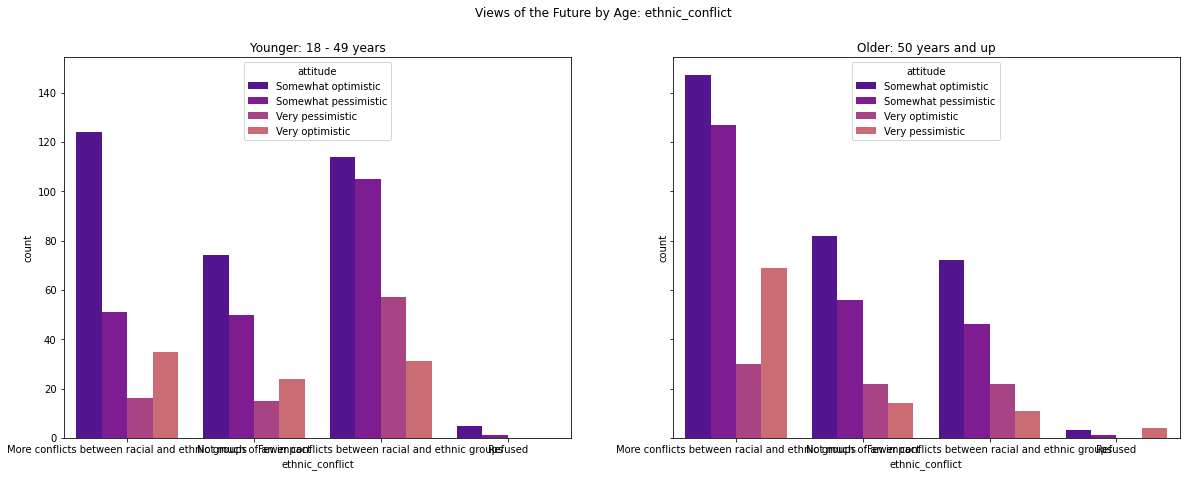

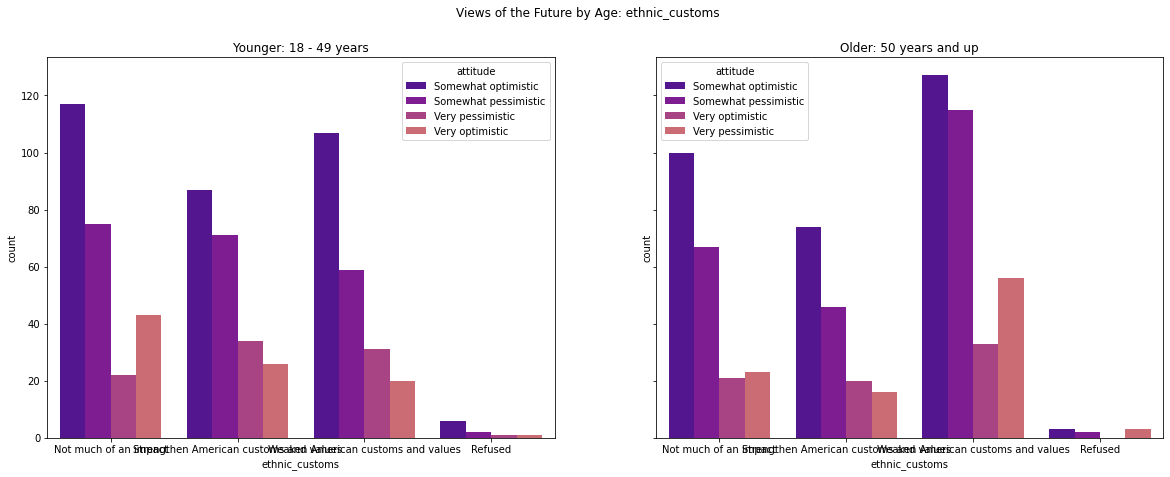

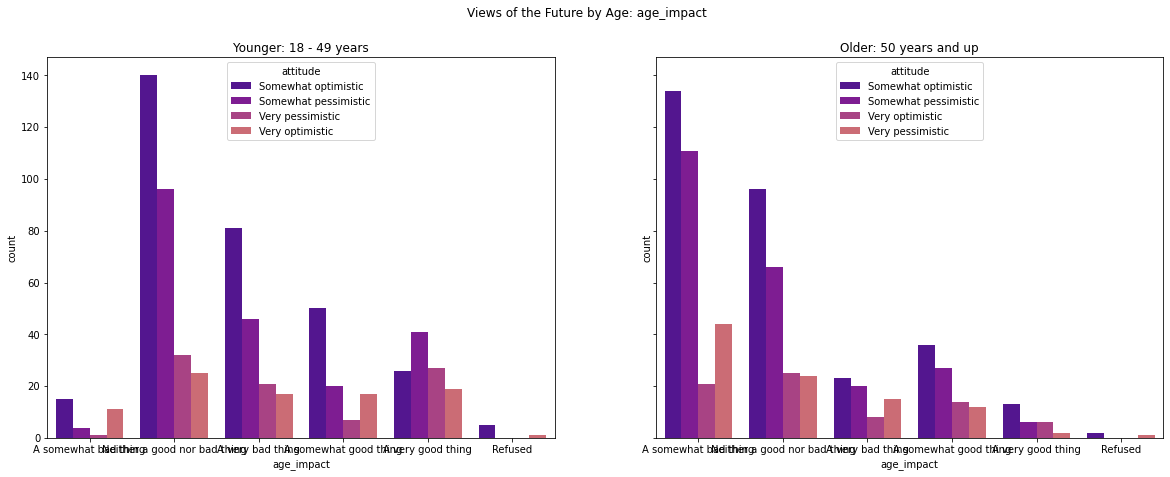

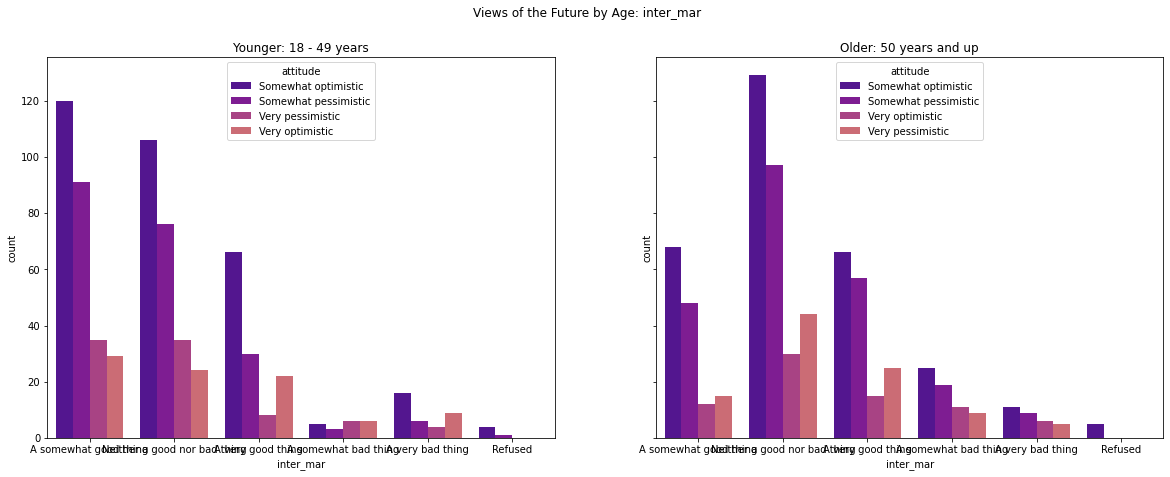

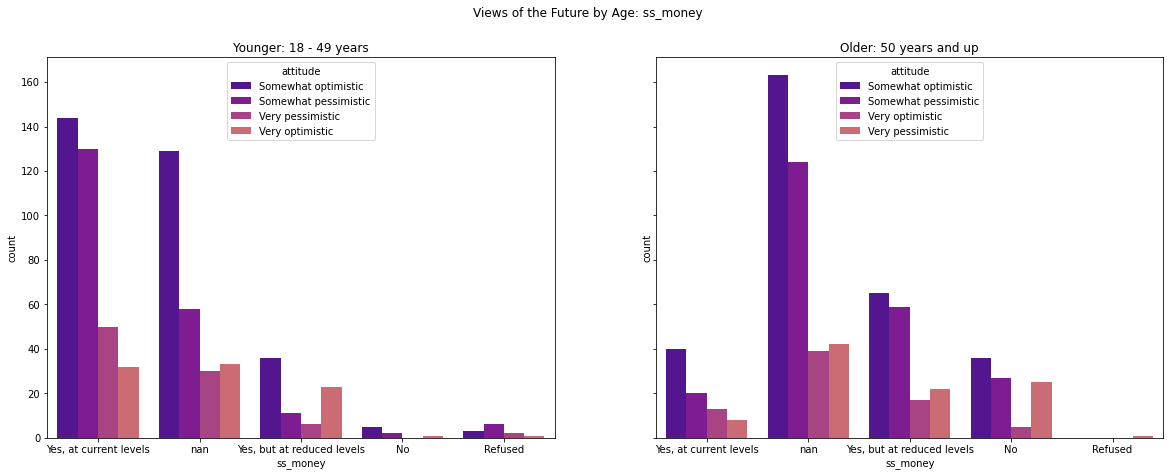

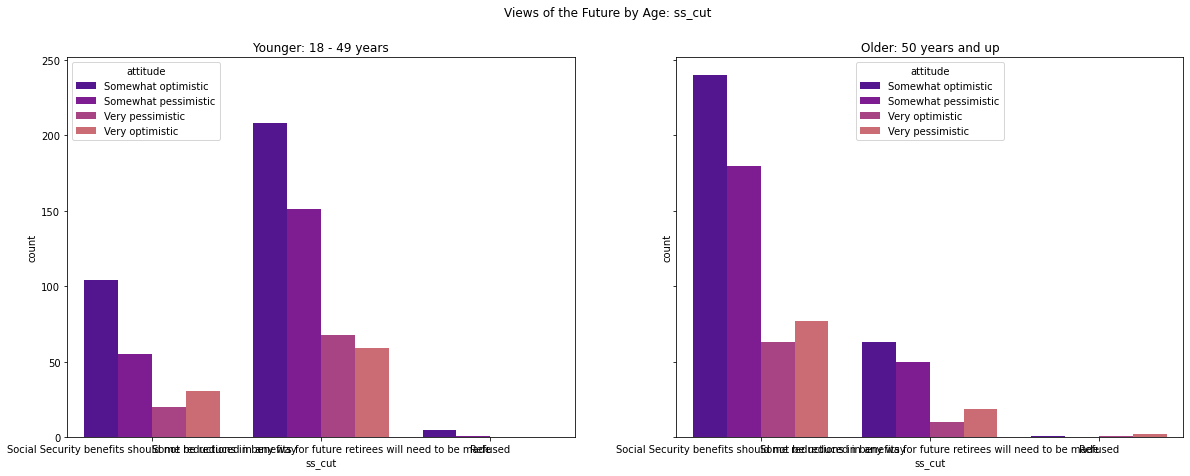

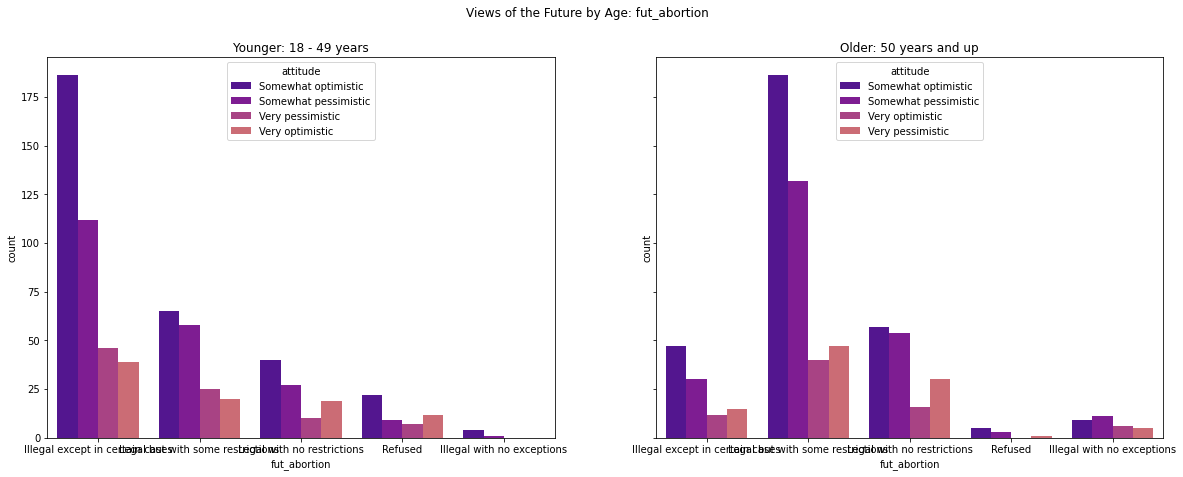

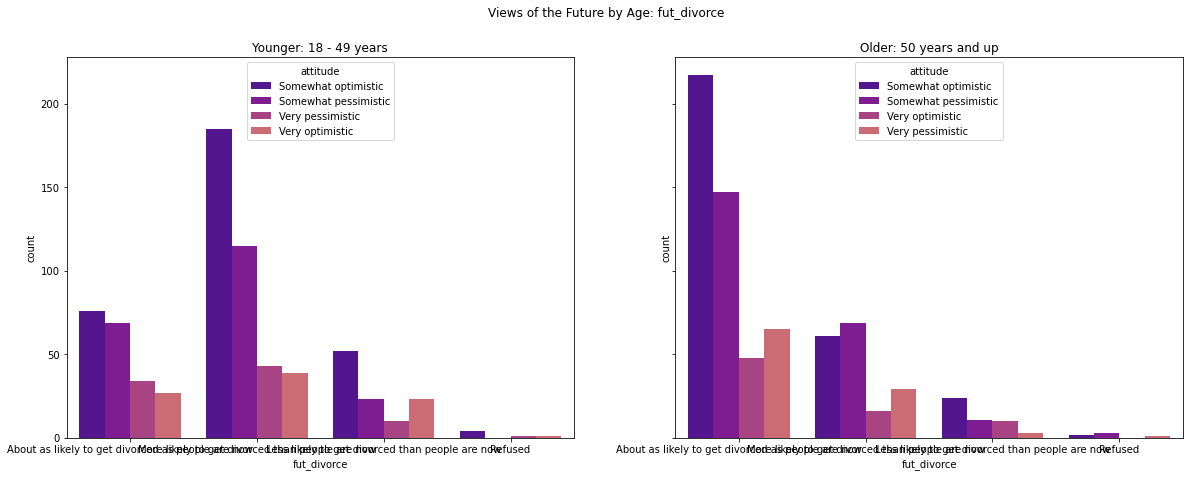

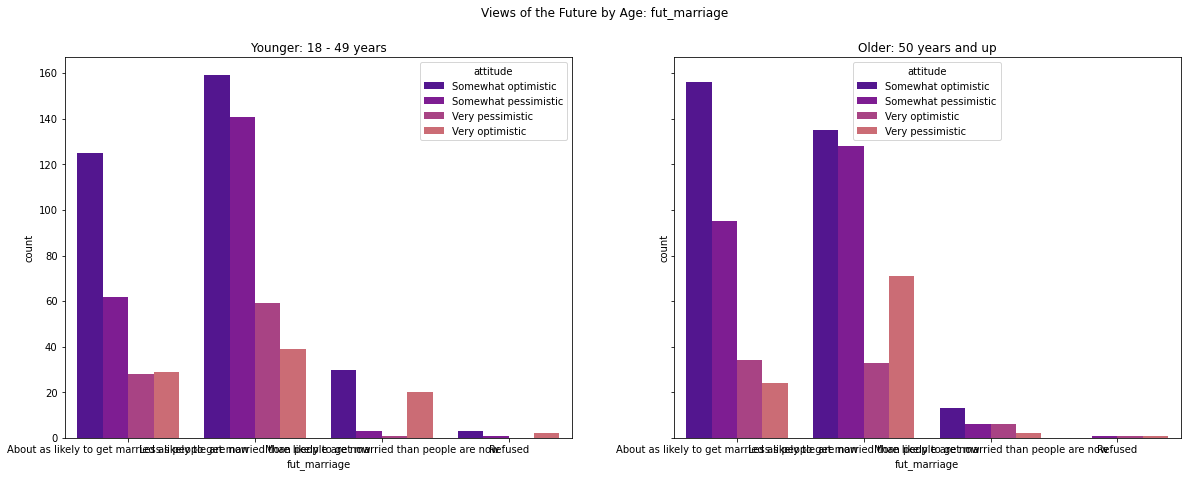

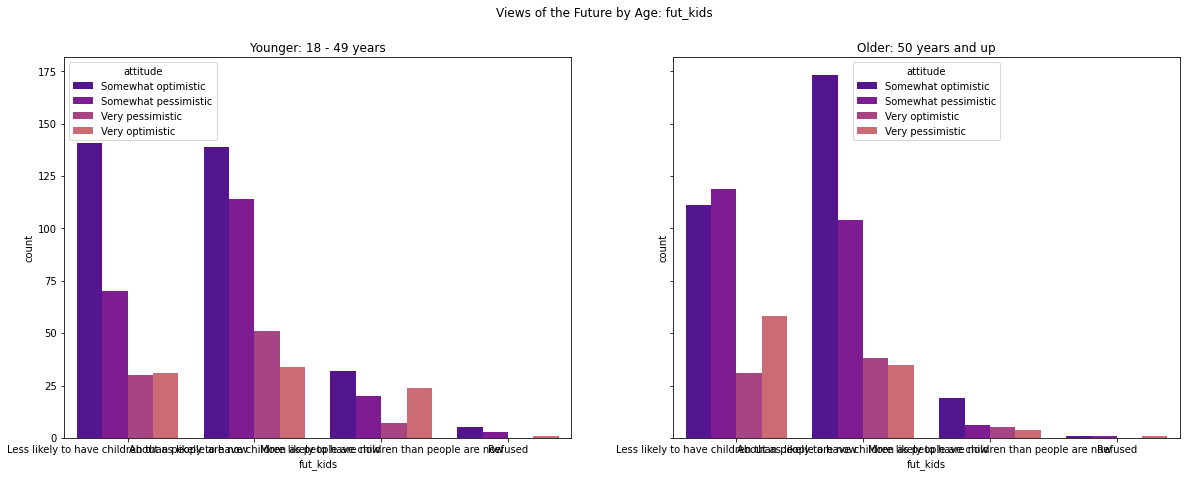

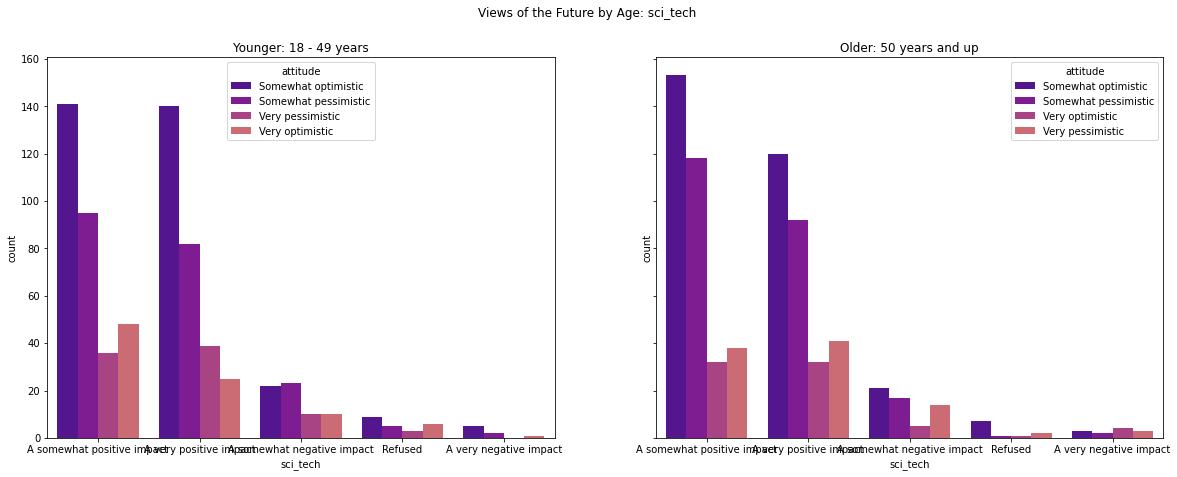

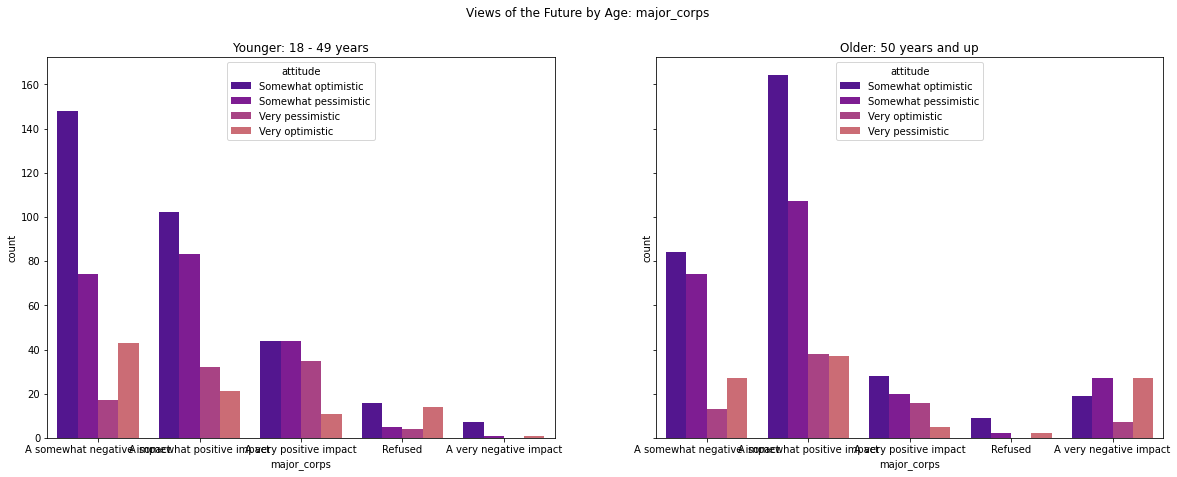

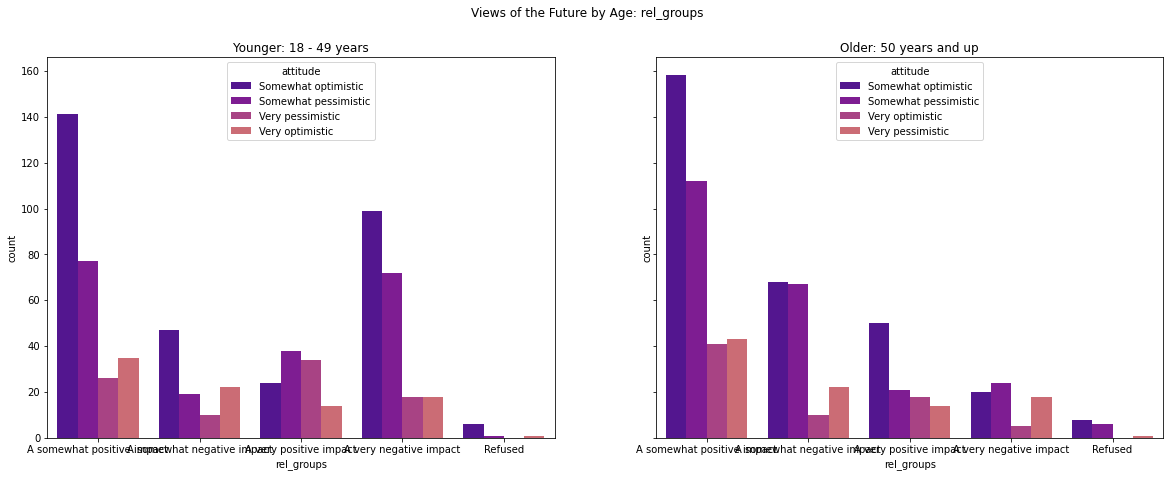

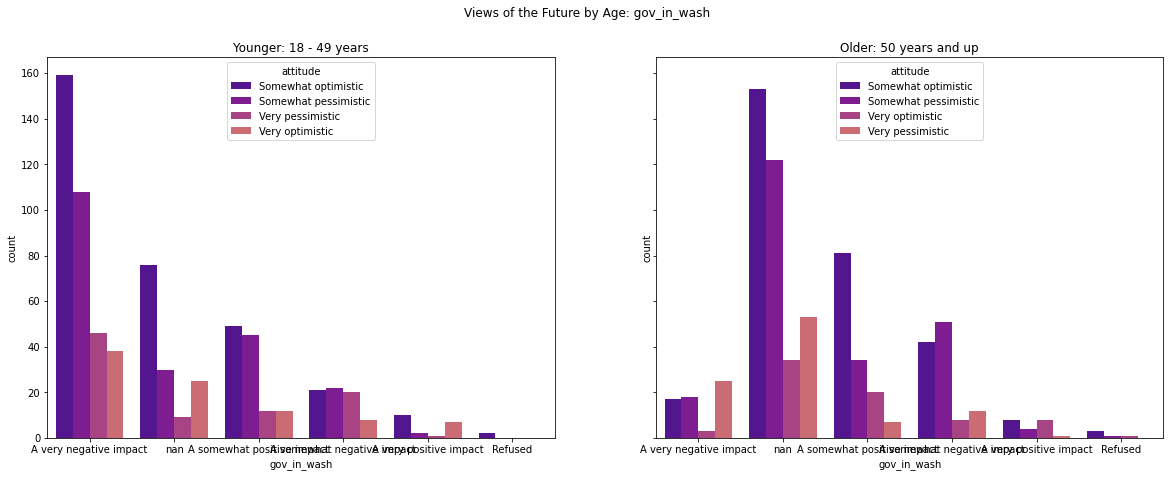

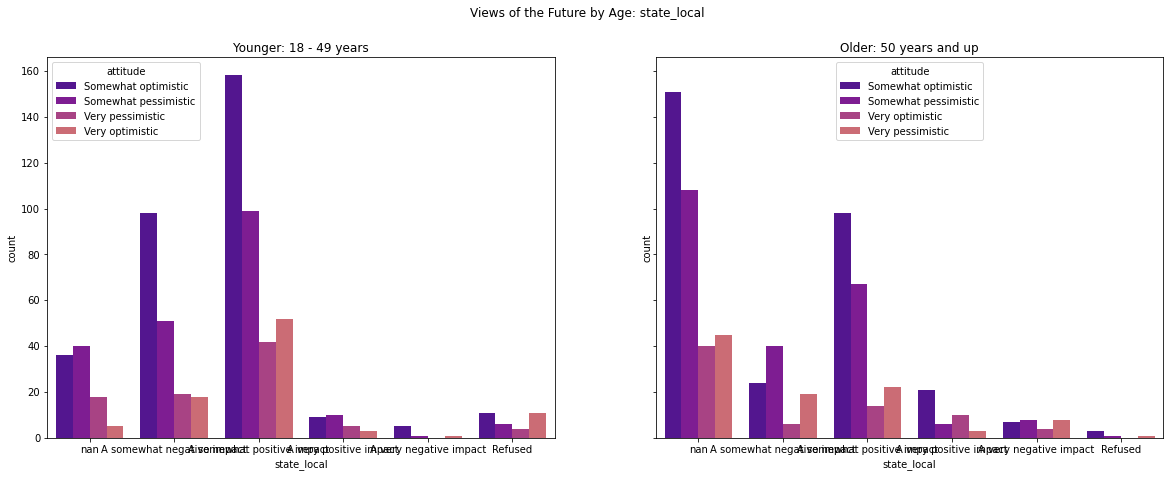

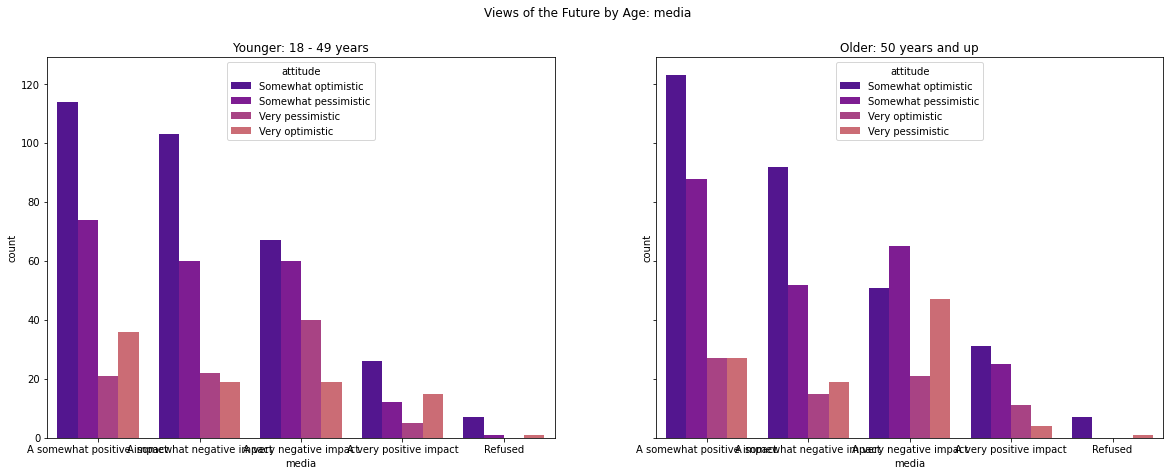

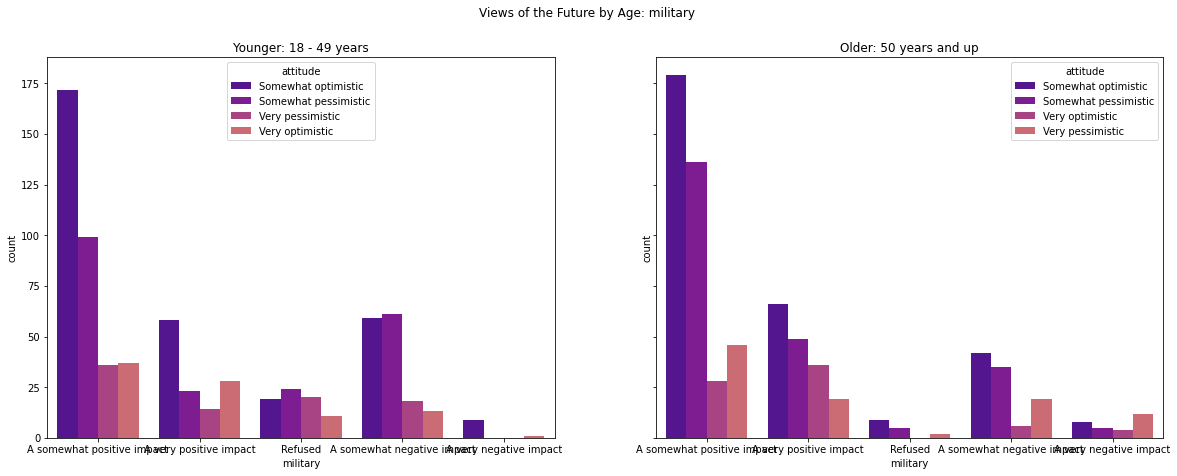

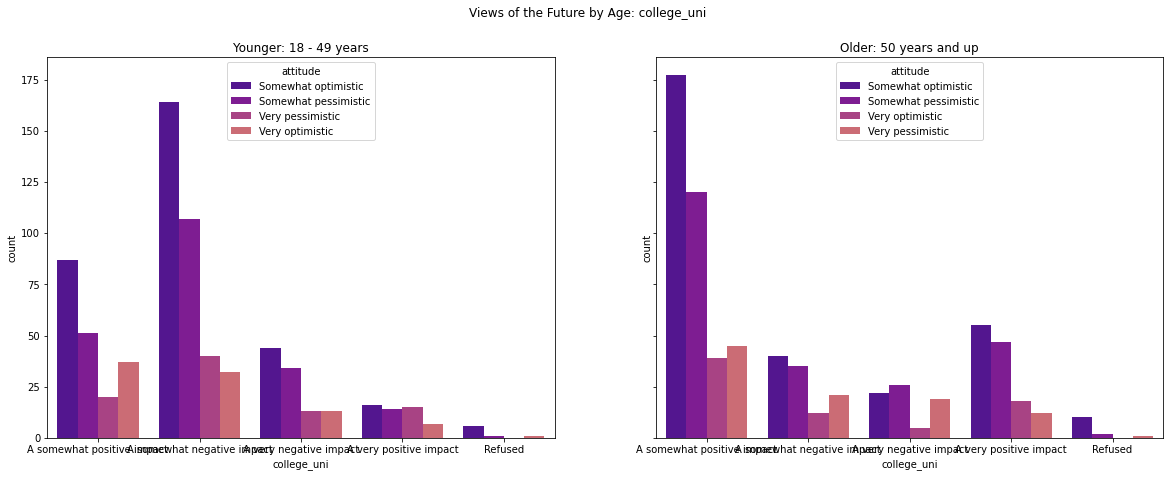

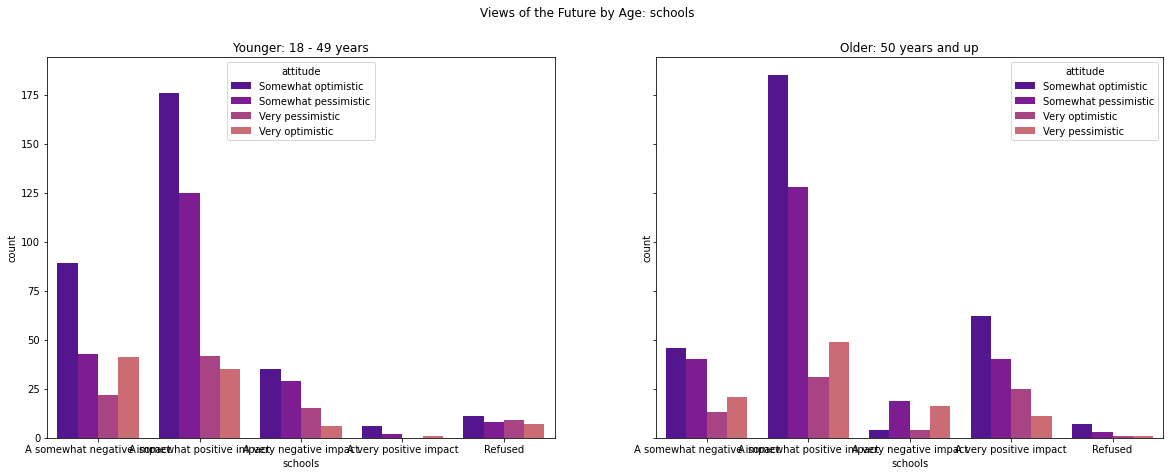

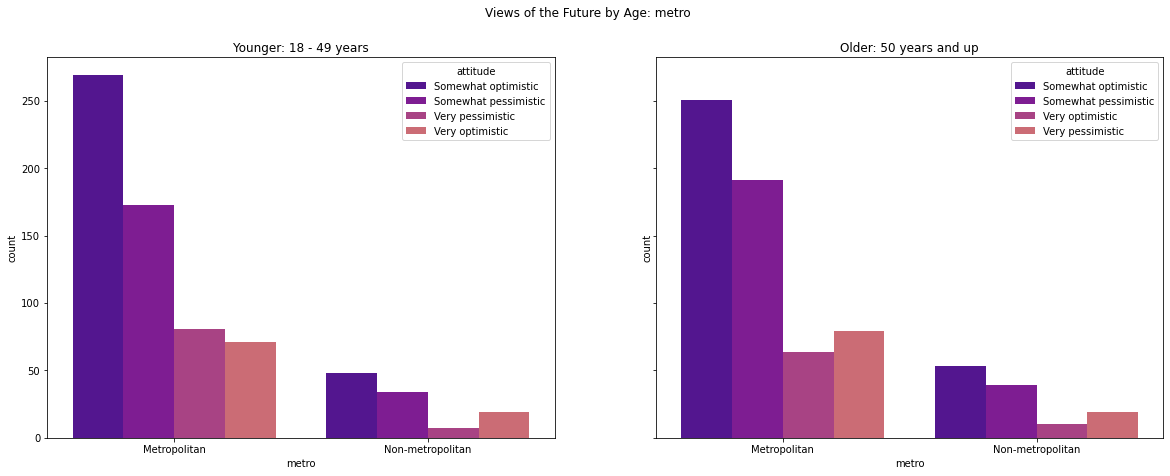

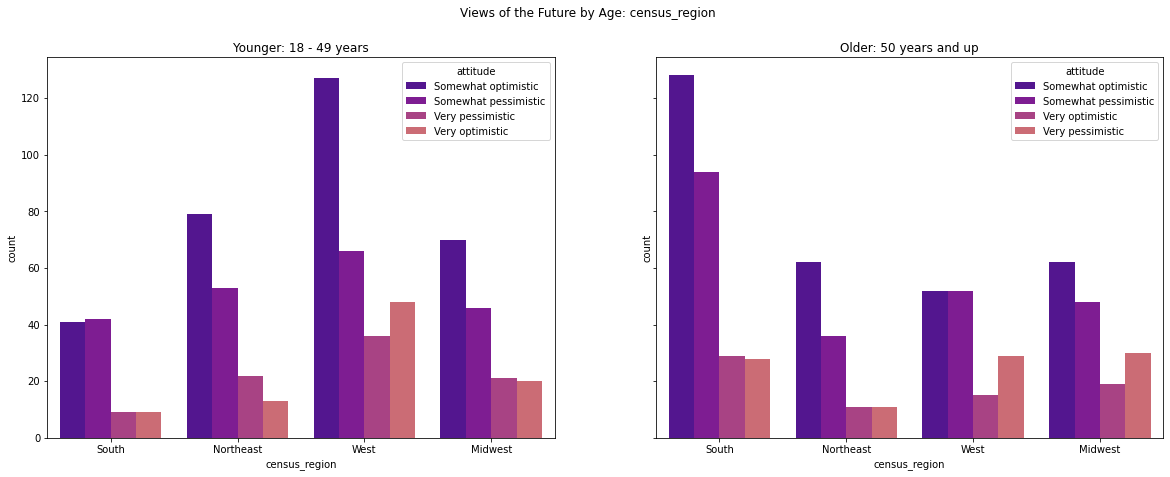

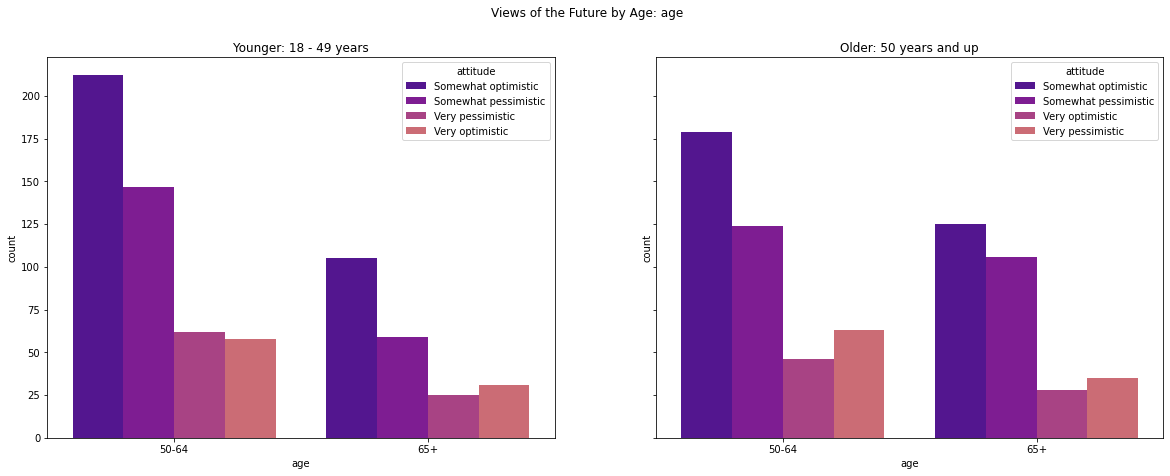

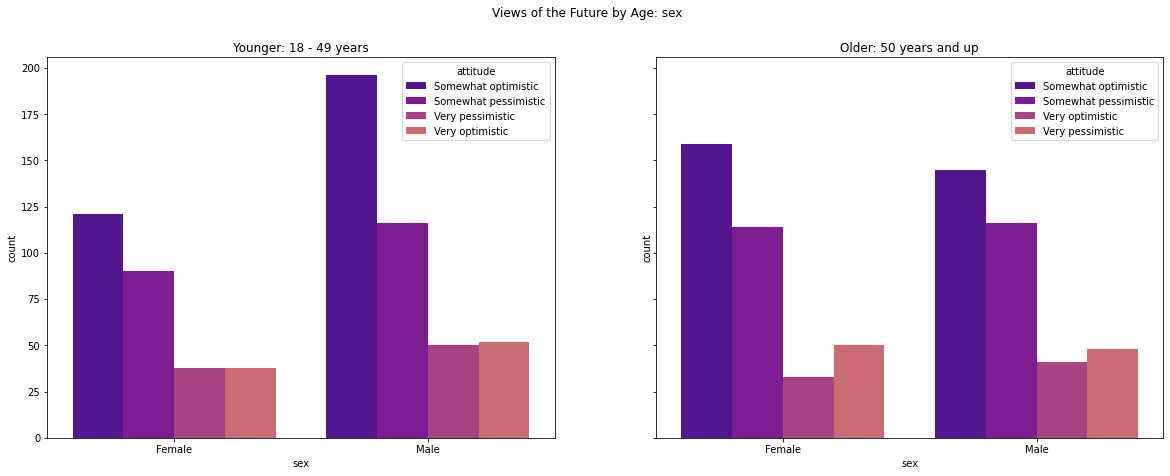

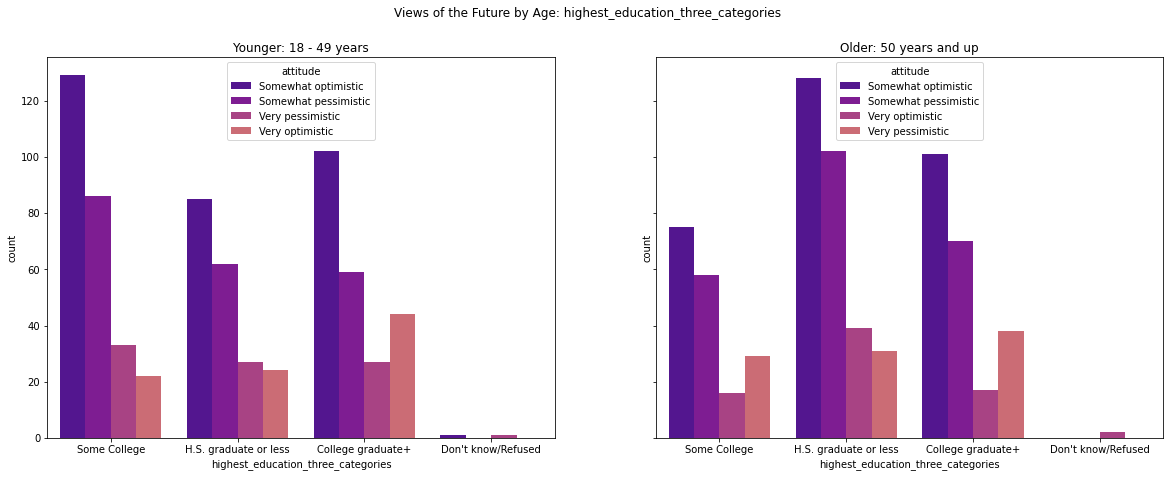

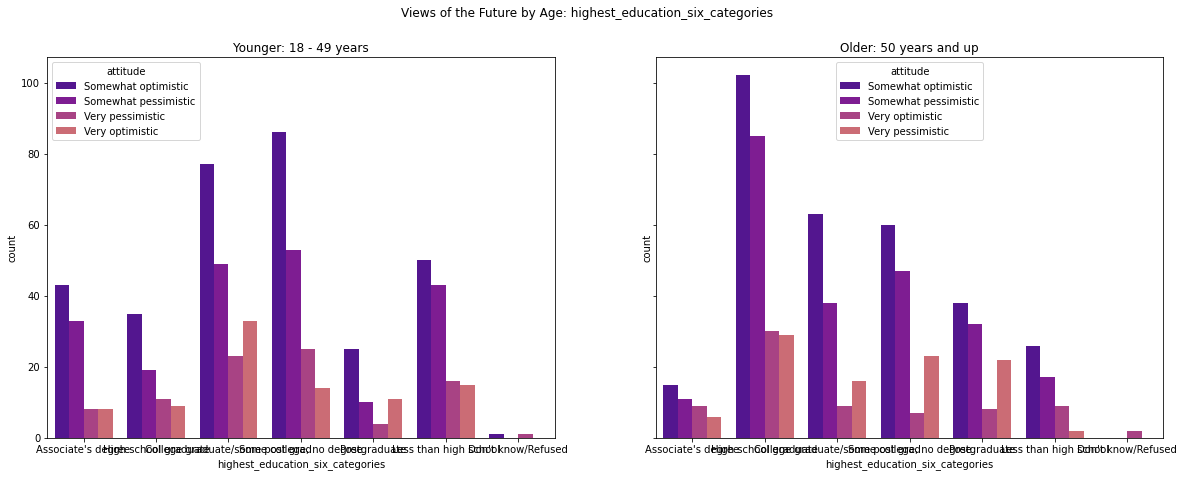

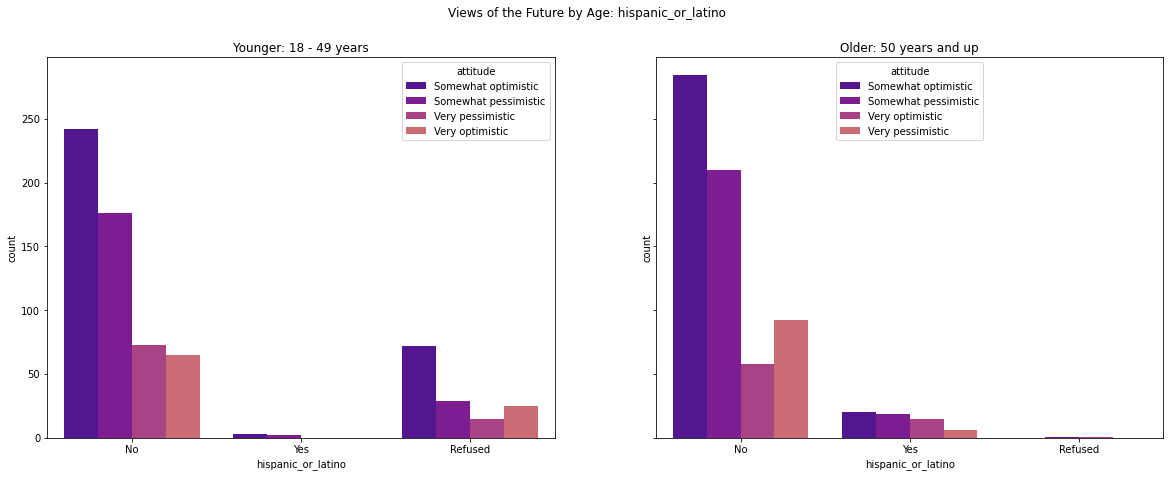

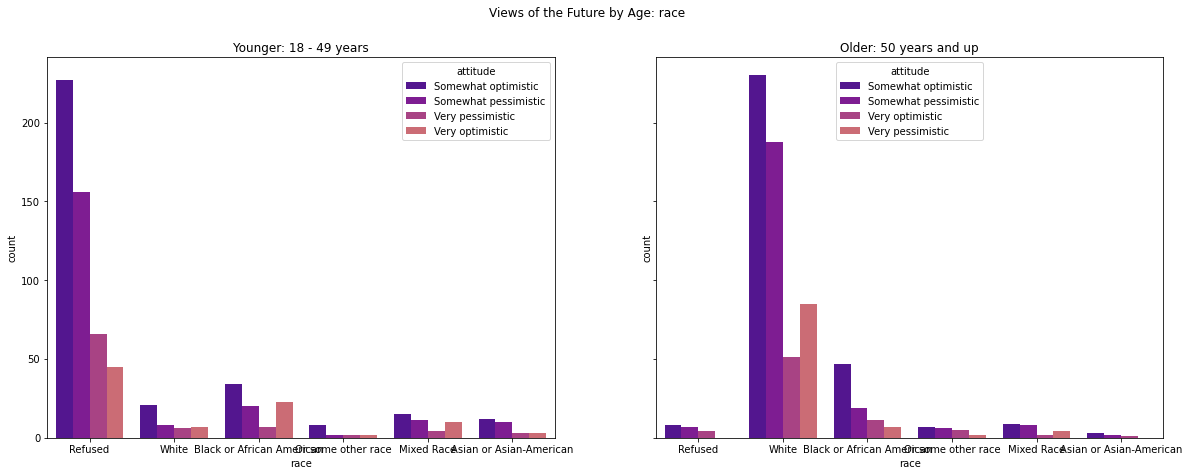

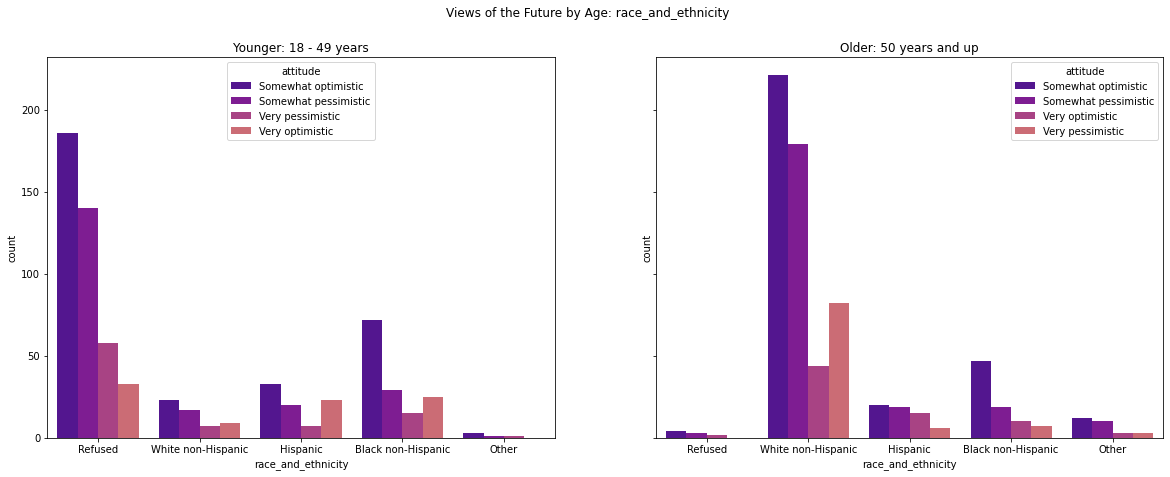

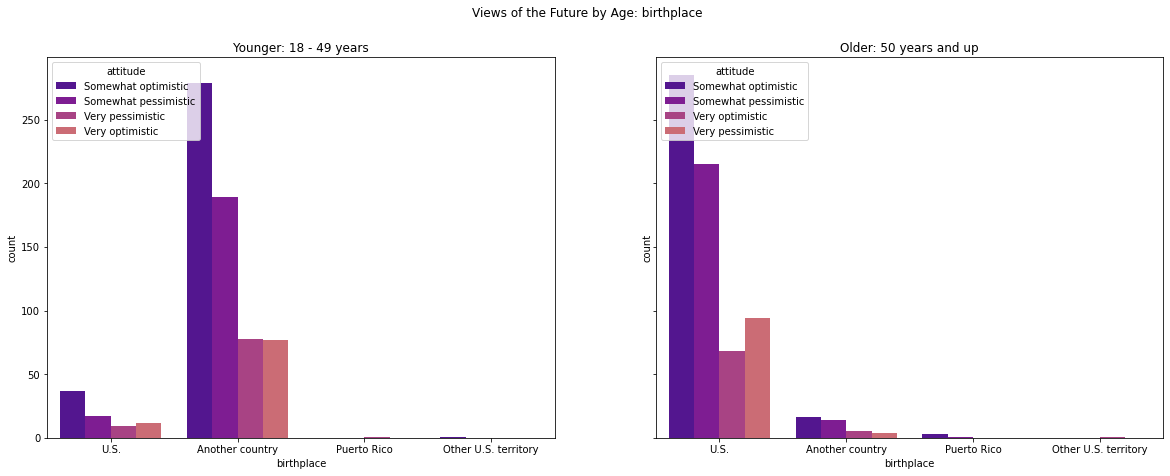

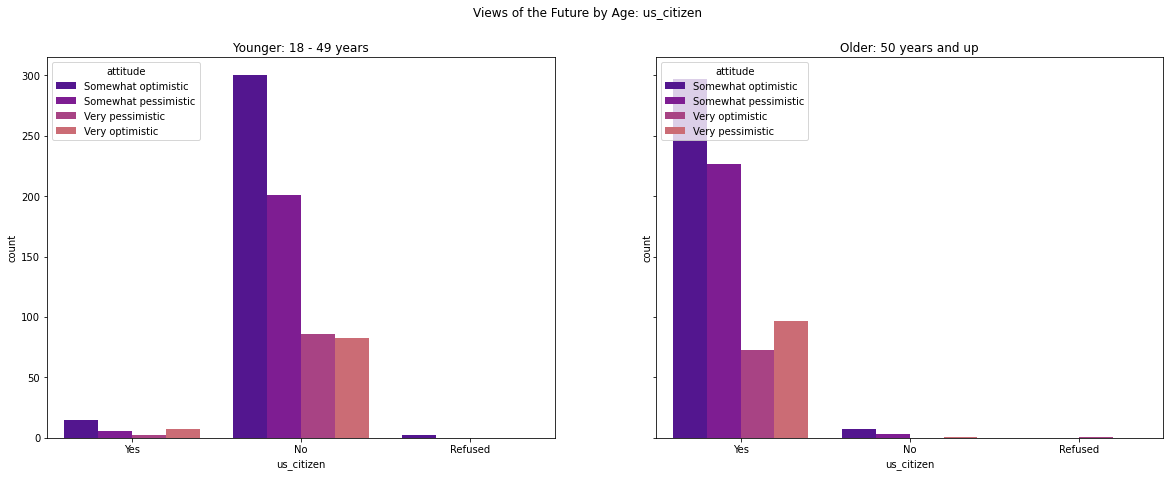

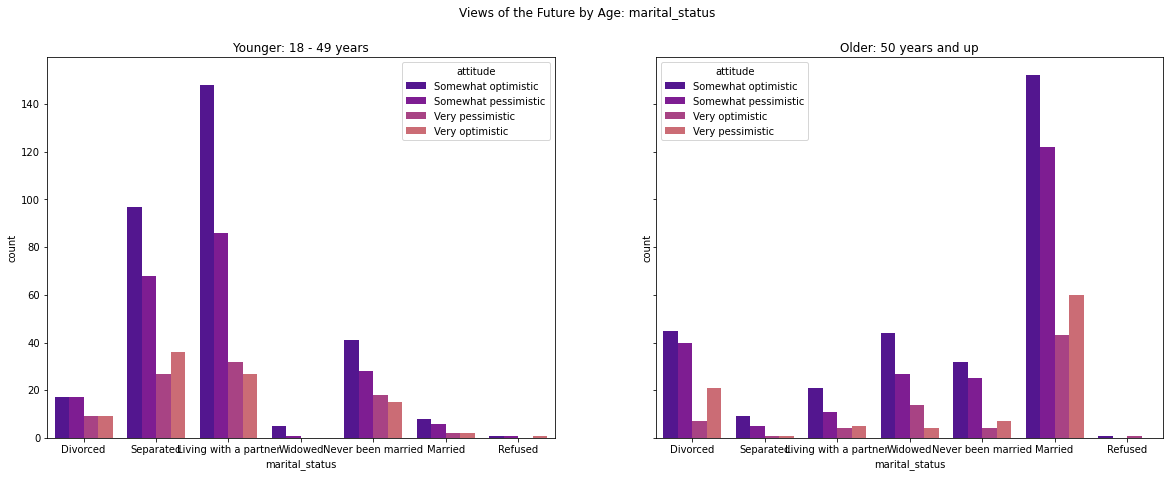

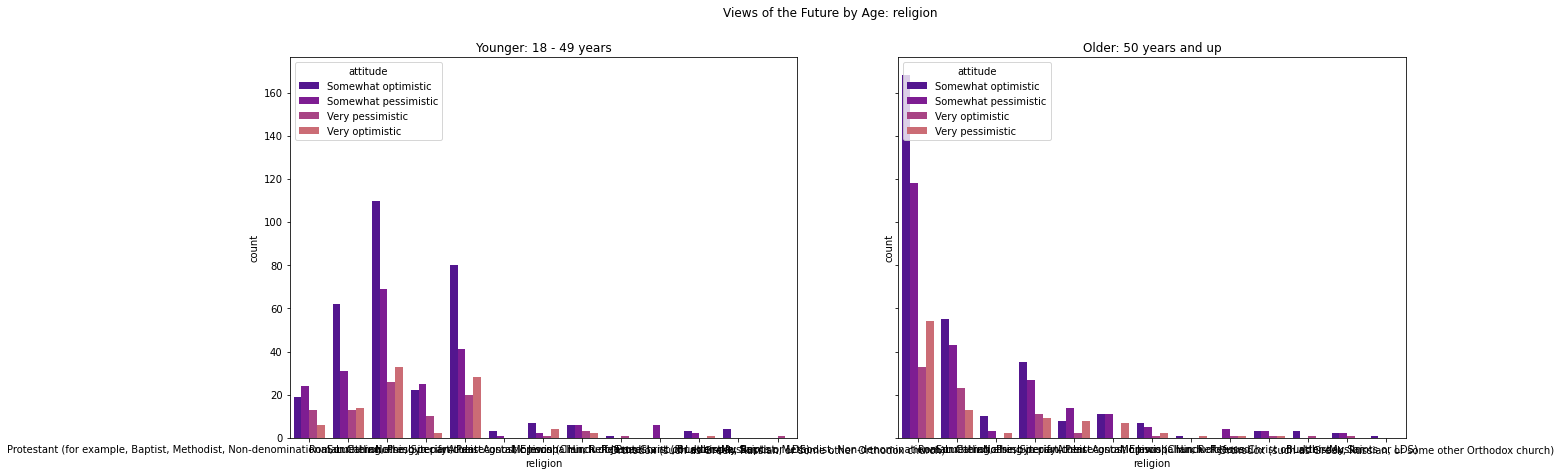

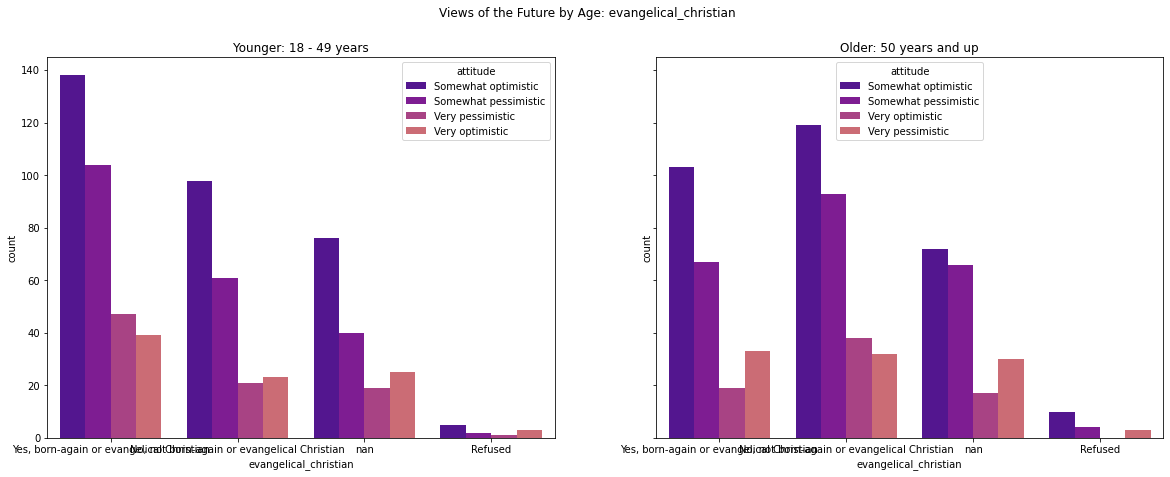

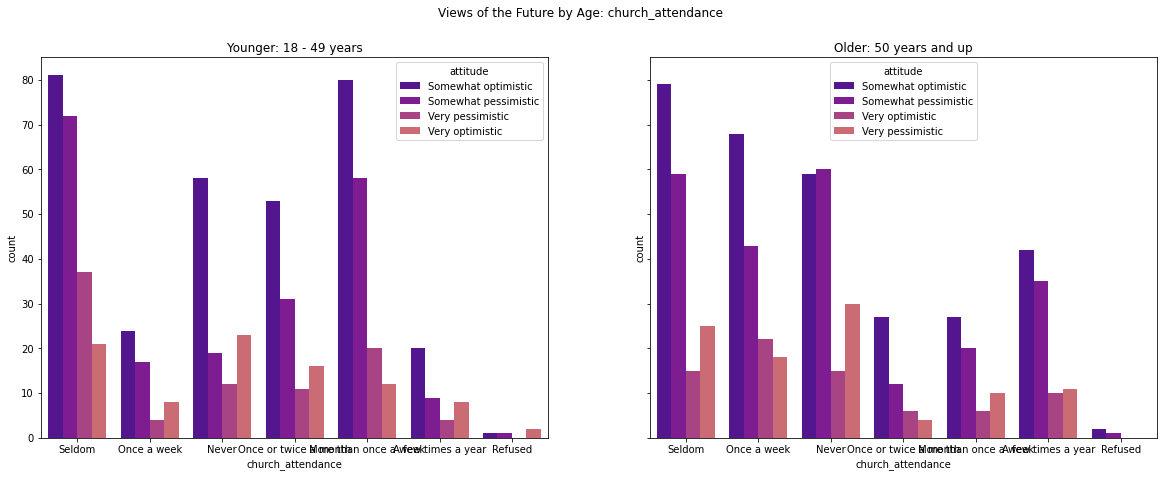

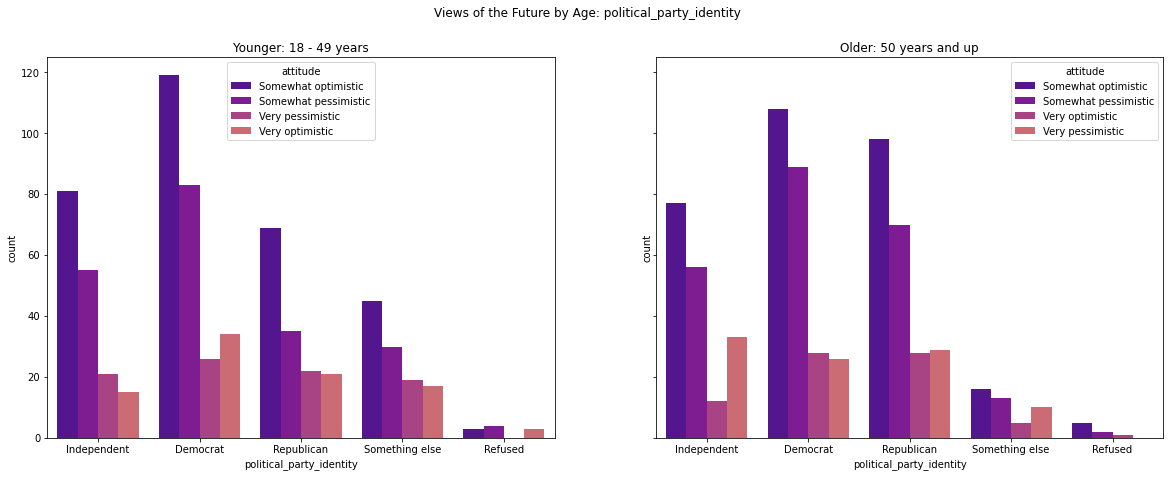

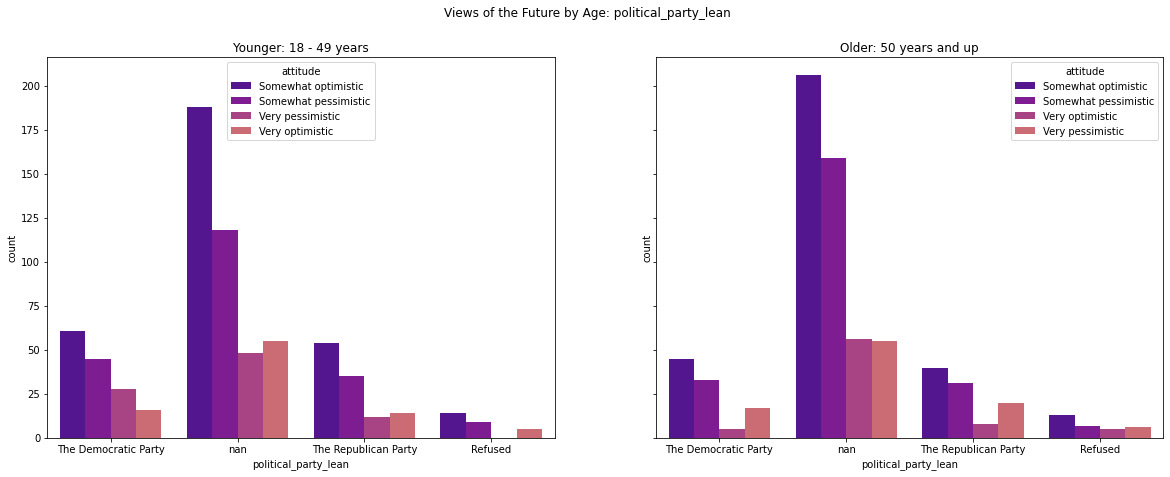

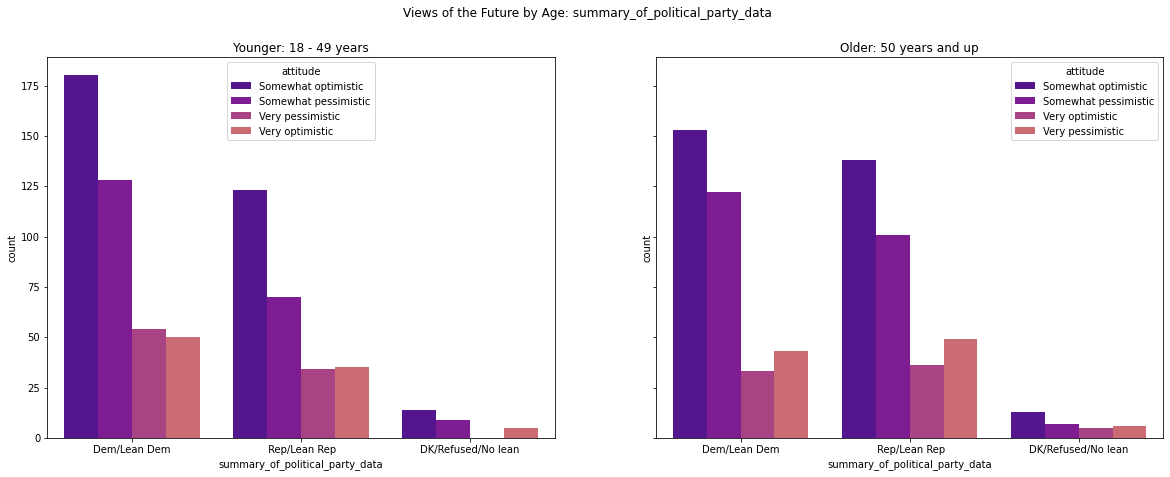

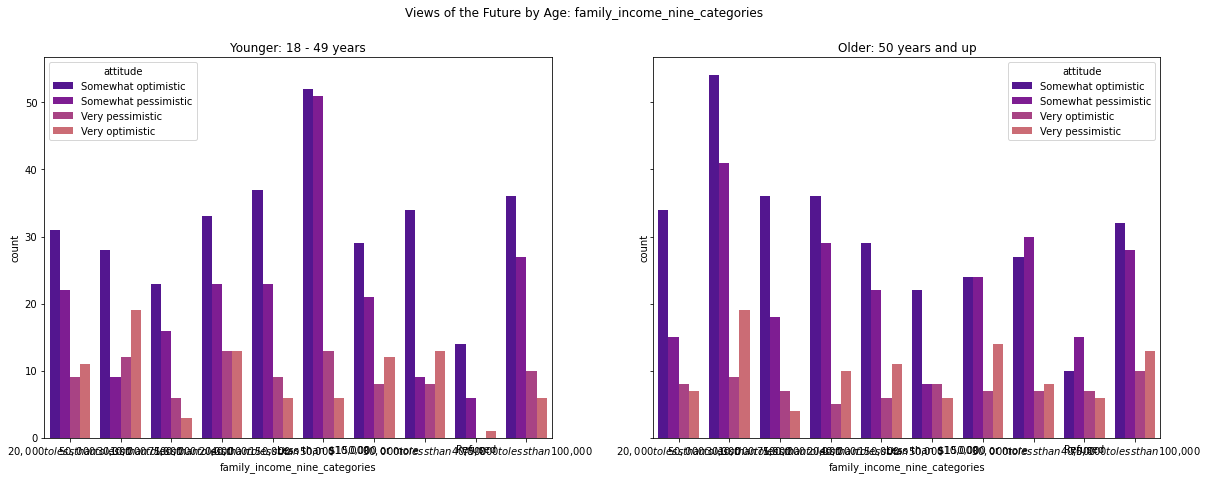

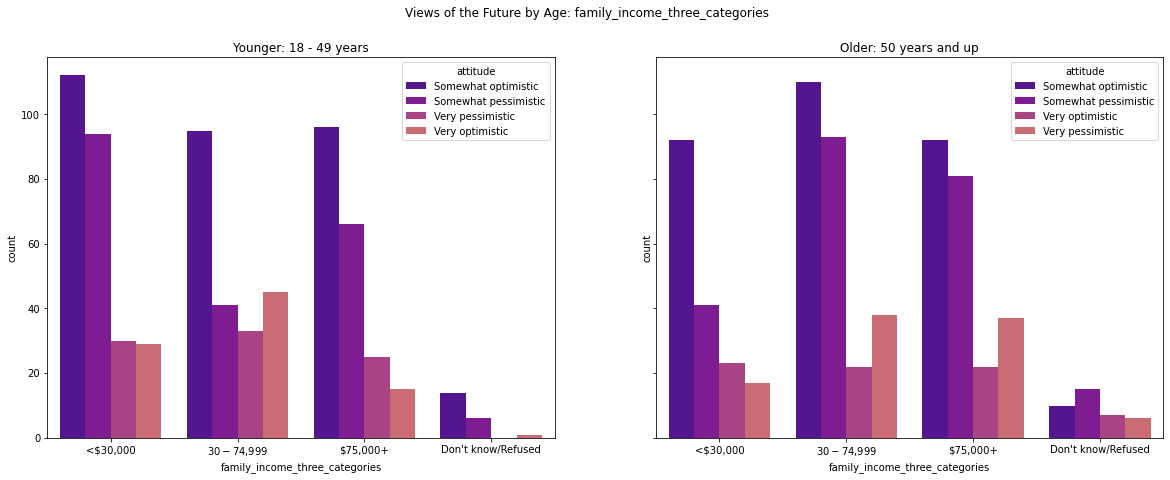

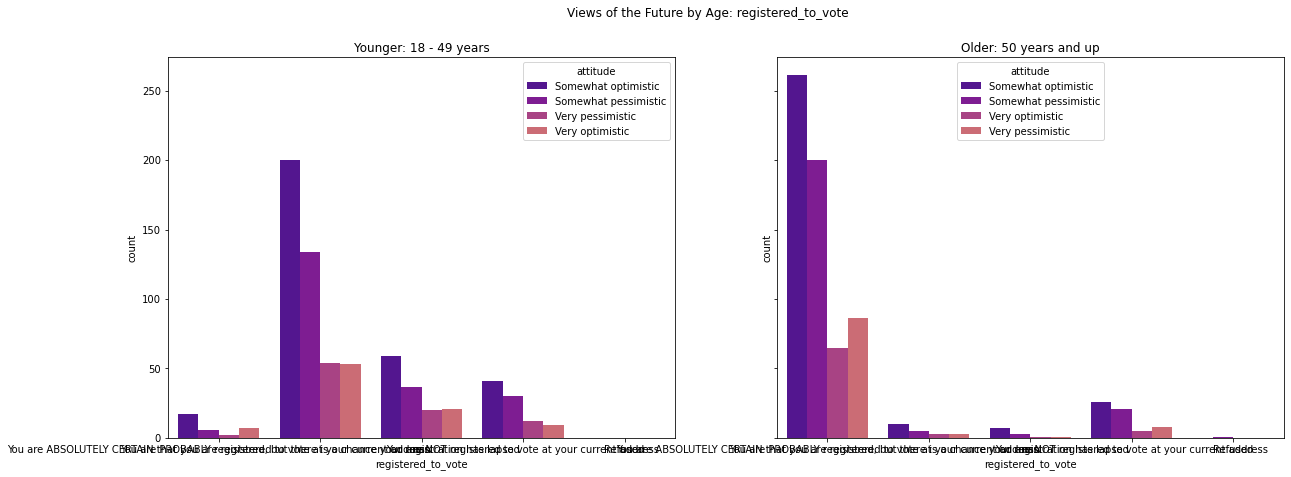

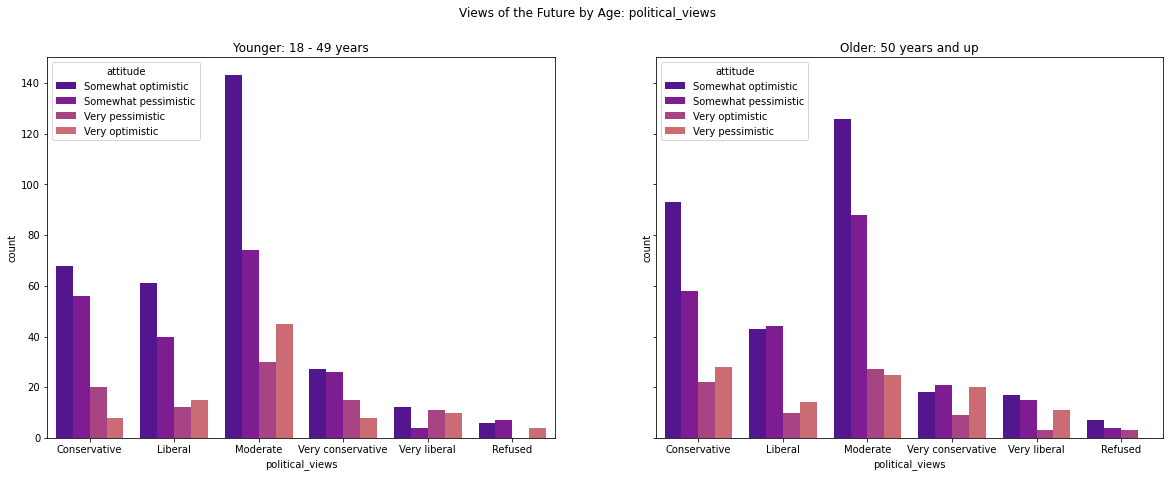

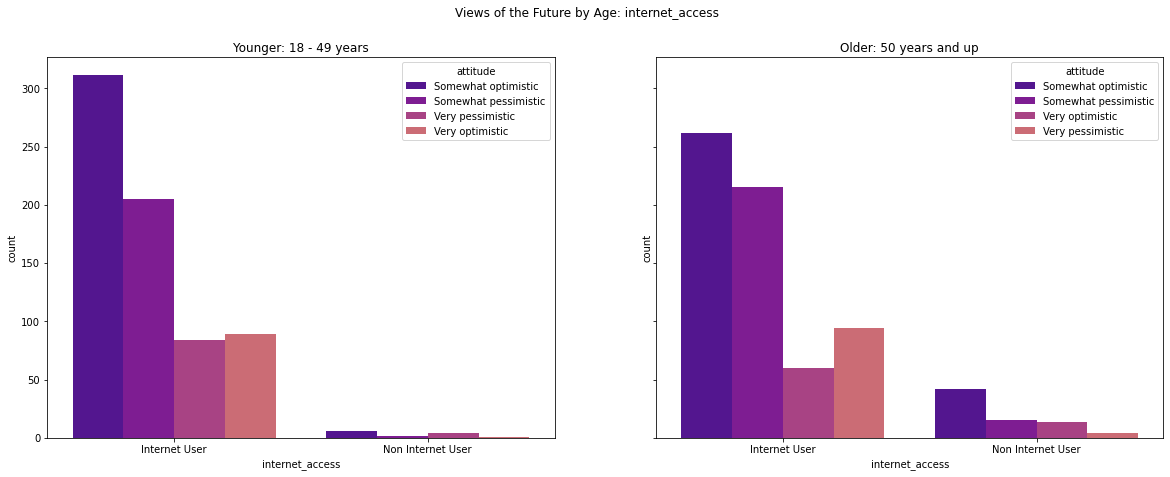

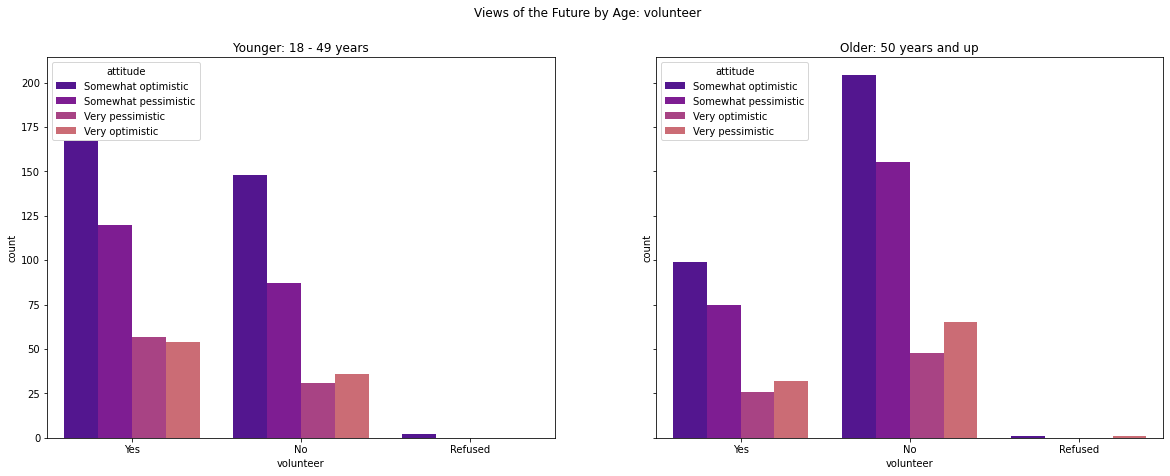

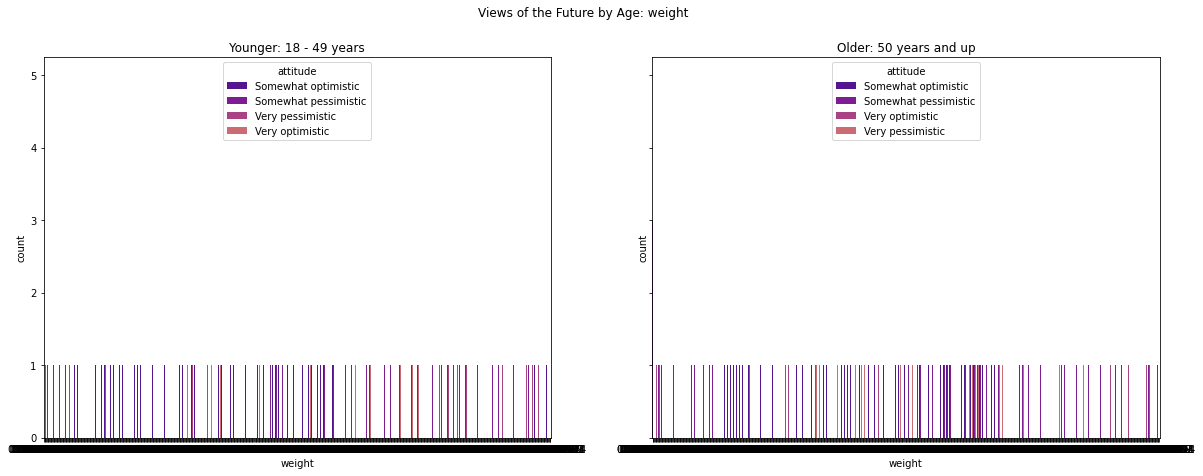

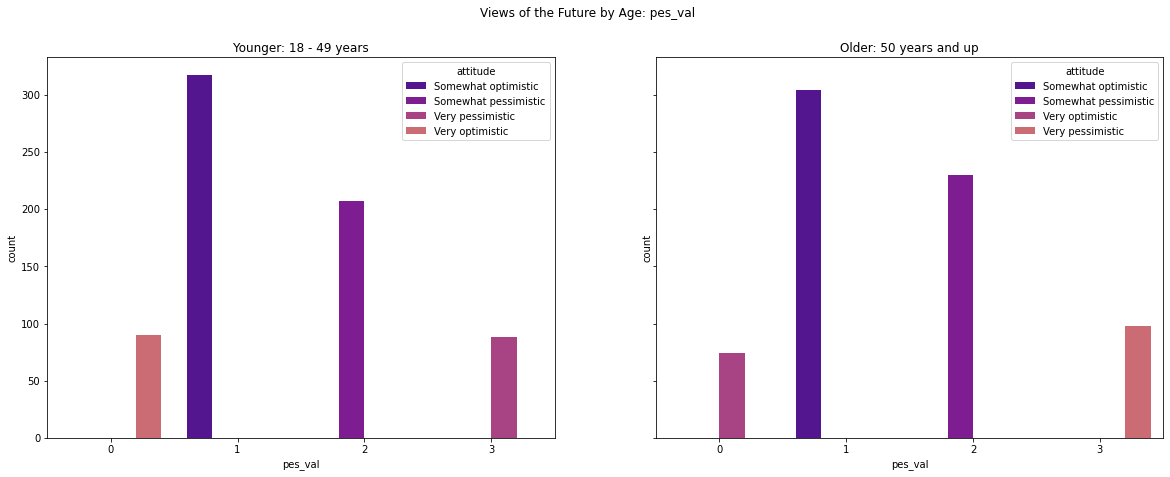

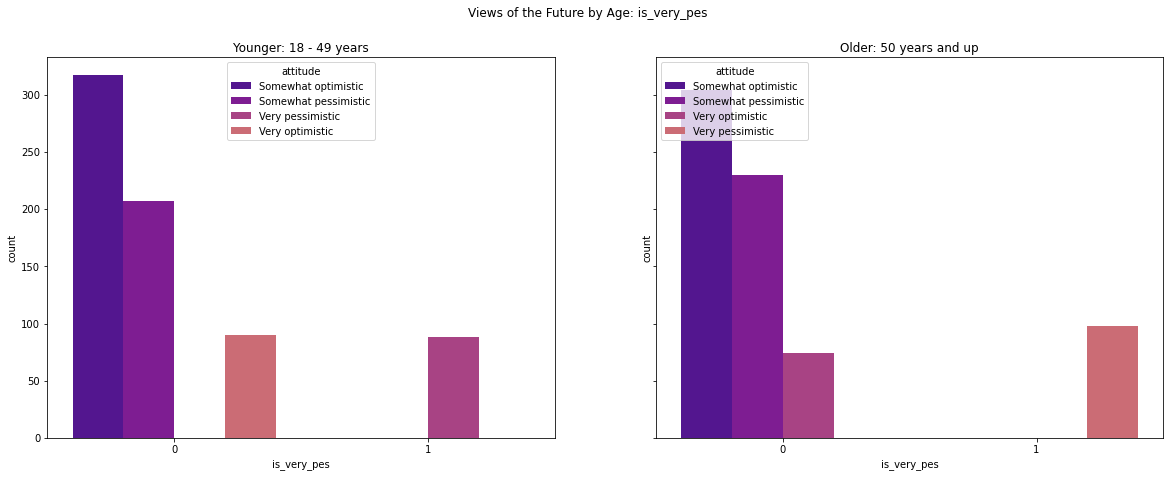

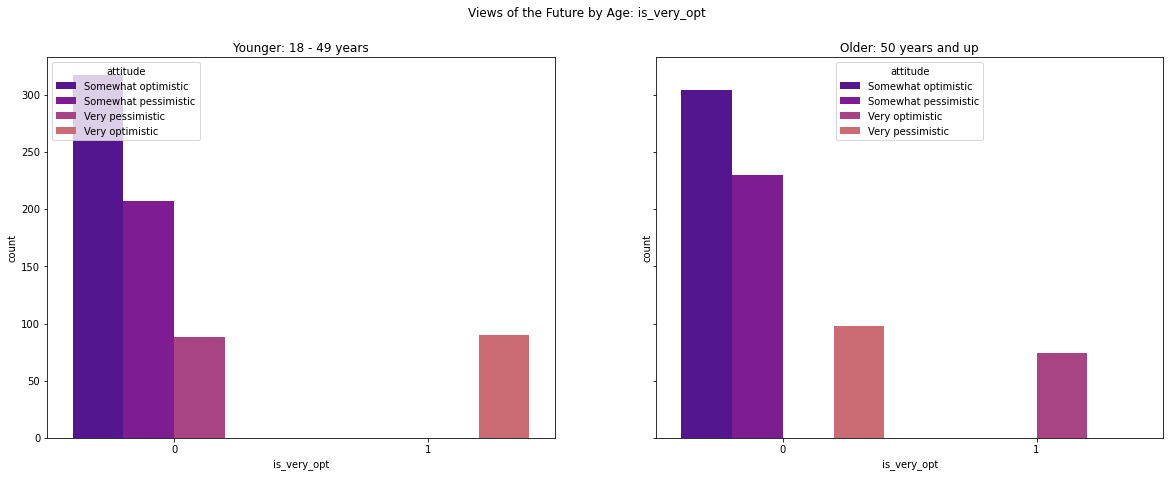

In [44]:
for col in train.drop(columns=['is_pes', 'qkey']):
    # Set number of subplots, format (1 row and 2 cols), share Y axis, set figure size of subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True,  figsize=(20,7))
    
    # Set suptitle
    fig.suptitle(f'Views of the Future by Age: {col}')
    
    # First plot and its title
    sns.countplot(data=train[~((train.age=='50-64') | (train.age=='65+'))], x=col, ax=axes[0], hue='attitude')
    axes[0].set_title('Younger: 18 - 49 years')
    
    # Second plot and its title
    sns.countplot(data=train[(train.age=='50-64') | (train.age=='65+')], x=col, ax=axes[1], hue='attitude')
    axes[1].set_title('Older: 50 years and up')
    
    plt.show()

In [45]:
cols = ['device_type', 'avg_family', 'happen_health', 'happen_race', 'happen_pub_ed', 'happen_rel', 'happen_65up_f1', 'happen_child_f2', 
'happen_terroist', 'happen_energy', 'happen_alzheimers', 'happen_china', 'happen_female_pres', 'happen_hispanic_pres', 'happen_70yr_labor', 
'happen_anti_semitism', 'debt_30yrs', 'envir_50yrs', 'pop_growth', 'worry_economy', 'worry_public_schools', 'worry_government', 'worry_leaders', 
'worry_climate', 'elder_finance_1', 'elder_finance_2', 'priority_healthcare', 'priority_science', 'priority_inequality', 'priority_reduce_military', 
'priority_increase_military', 'priority_more_immigration', 'priority_pub_hcare_f2', 'priority_reducing_spending_infrastructure', 
'priority_climate', 'second_most_responsible_for_workers_f2', 'job_security', 'job_benefits', 'automation_good_or_bad', 
'replacement_by_robots_likelihood', 'replacement_by_robots_good_or_bad', 'likelihood_my_job_replaced_by_robots', 
'robot_replacement_increase_inequality', 'robot_replacement_means_better_jobs_for_humans', 'share_americans_in_upper_class', 
'share_americans_in_middle_class', 'share_americans_in_lower_class', 'harass_sexual_personal_exp', 'ethnic_customs', 'age_impact', 
'inter_mar', 'ss_money', 'ss_cut', 'fut_abortion', 'fut_divorce', 'fut_marriage', 'fut_kids', 'sci_tech', 'major_corps', 'rel_groups',
'gov_in_wash', 'state_local', 'media', 'military', 'college_uni', 'schools', 'census_region', 'race', 'race_and_ethnicity', 
'marital_status', 'religion', 'church_attendance', 'political_party_identity', 'family_income_nine_categories', 
'family_income_three_categories', 'registered_to_vote', 'political_views', 'internet_access']

In [46]:
train[((train.age=='50-64') | (train.age=='65+'))].age.value_counts()

50-64    412
65+      294
Name: age, dtype: int64

In [47]:
train[train.happen_health=='Health care will be MORE affordable'].is_pes.value_counts()

0    362
1    115
Name: is_pes, dtype: int64

In [48]:
train[((train.age=='50-64') | (train.age=='65+'))].replace(replace_key).corr().is_pes.sort_values()

avg_family       -0.451494
envir_50yrs      -0.323562
is_very_opt      -0.318749
happen_pub_ed    -0.310780
job_benefits     -0.290078
                    ...   
is_very_pes       0.430993
happen_general    0.437543
attitude          0.576573
pes_val           0.868121
is_pes            1.000000
Name: is_pes, Length: 128, dtype: float64

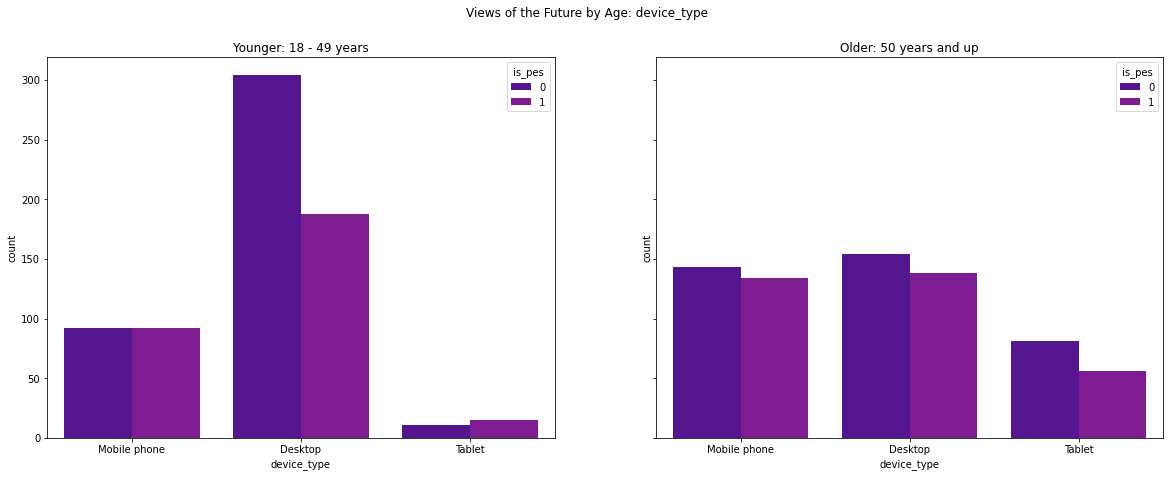

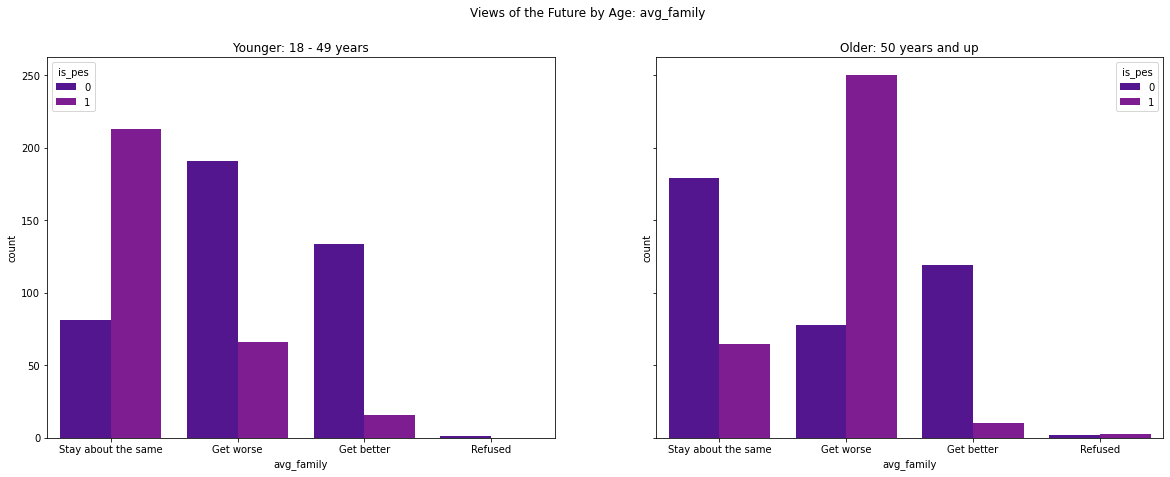

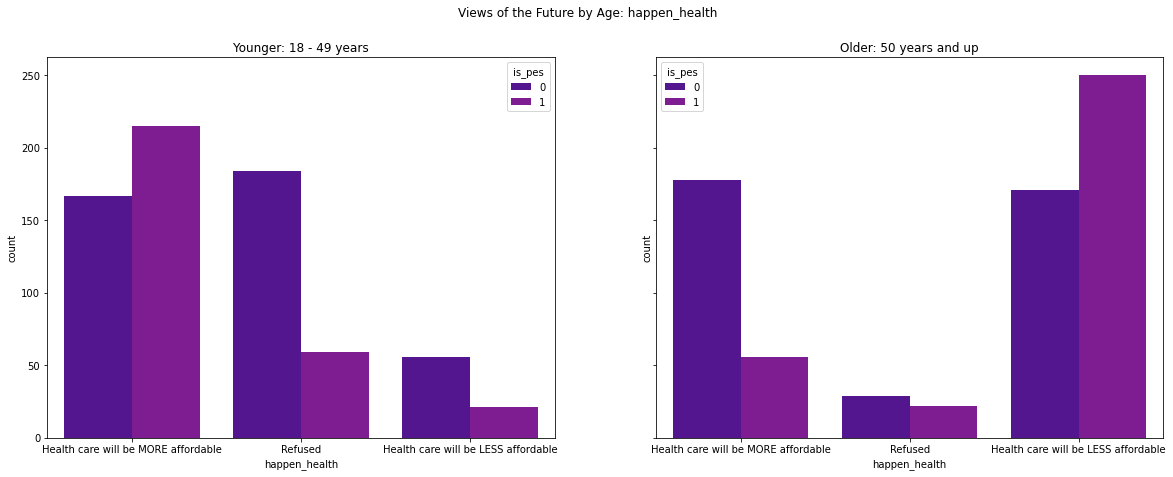

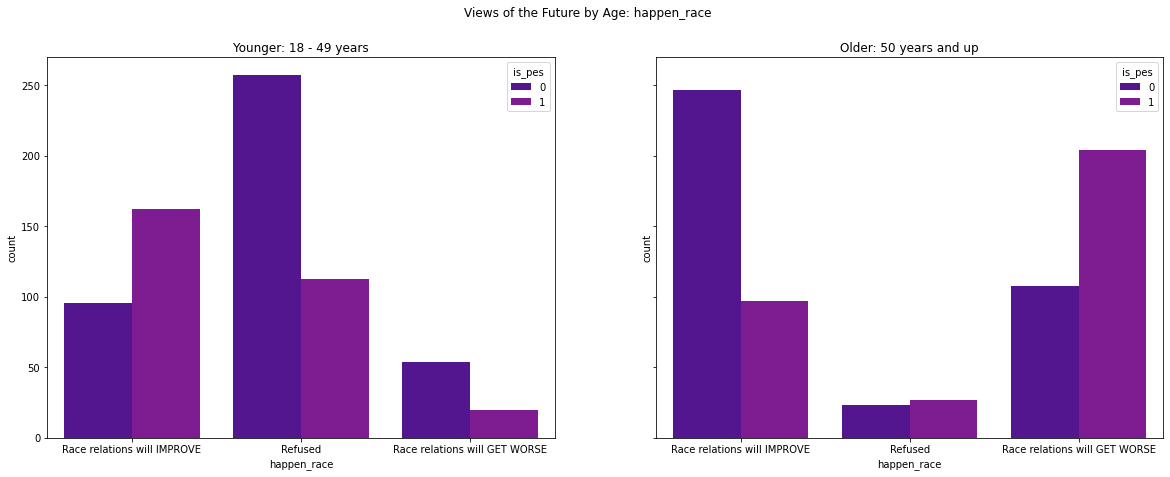

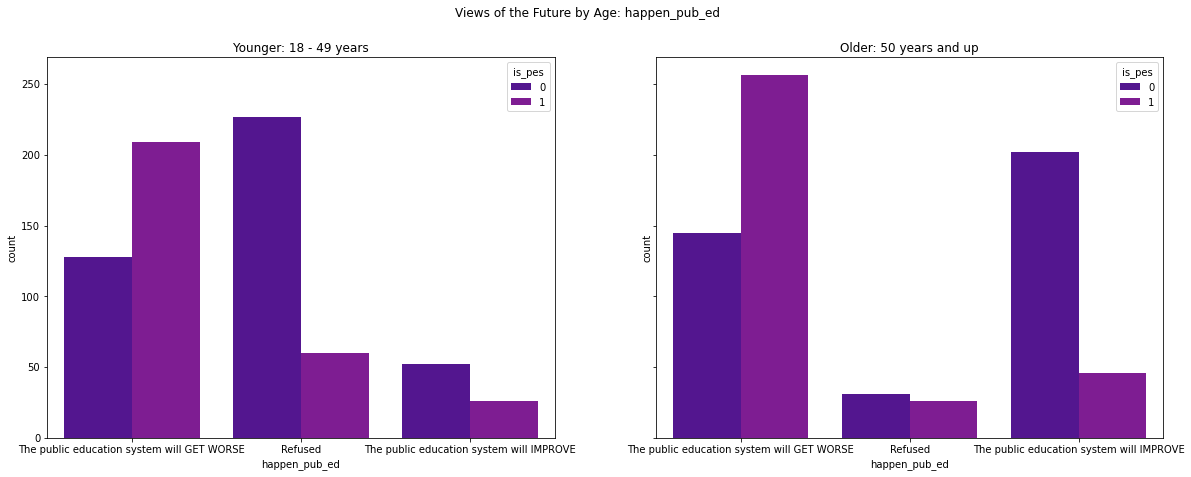

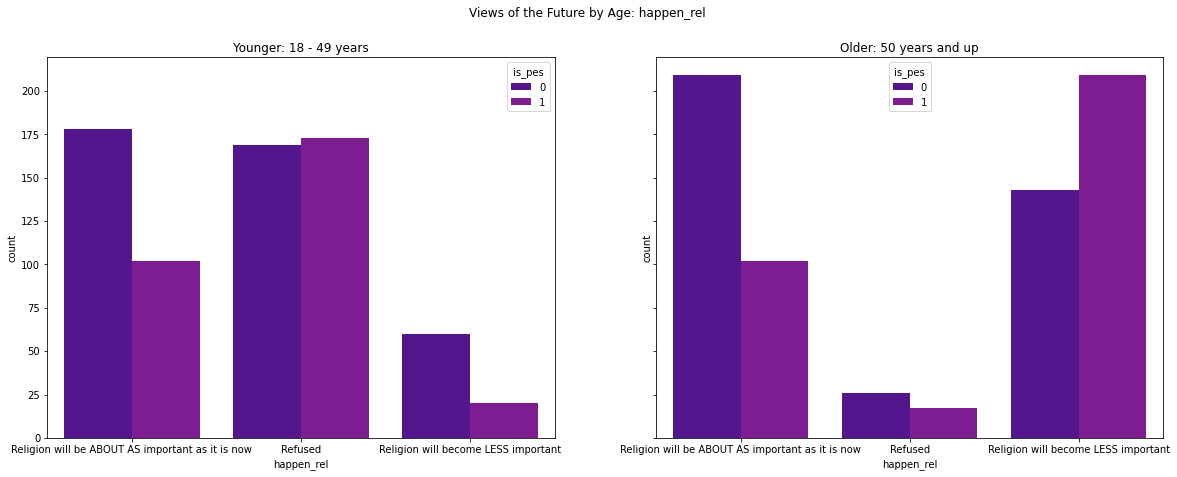

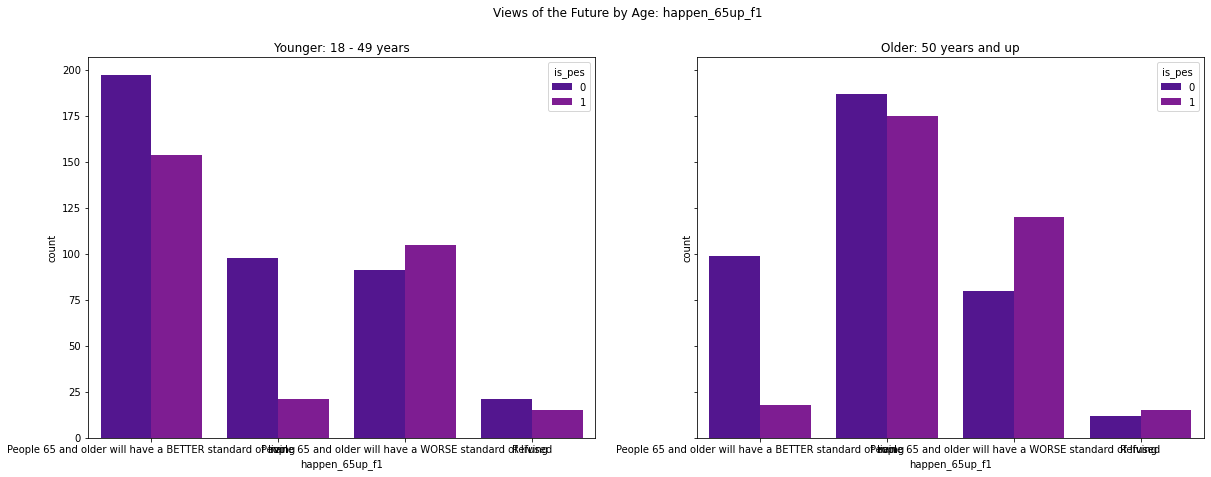

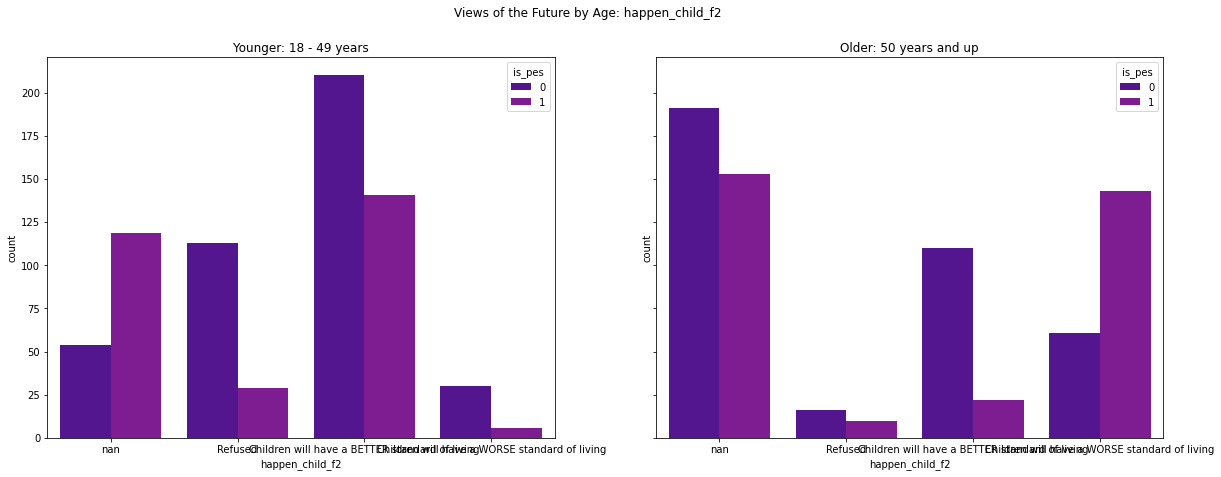

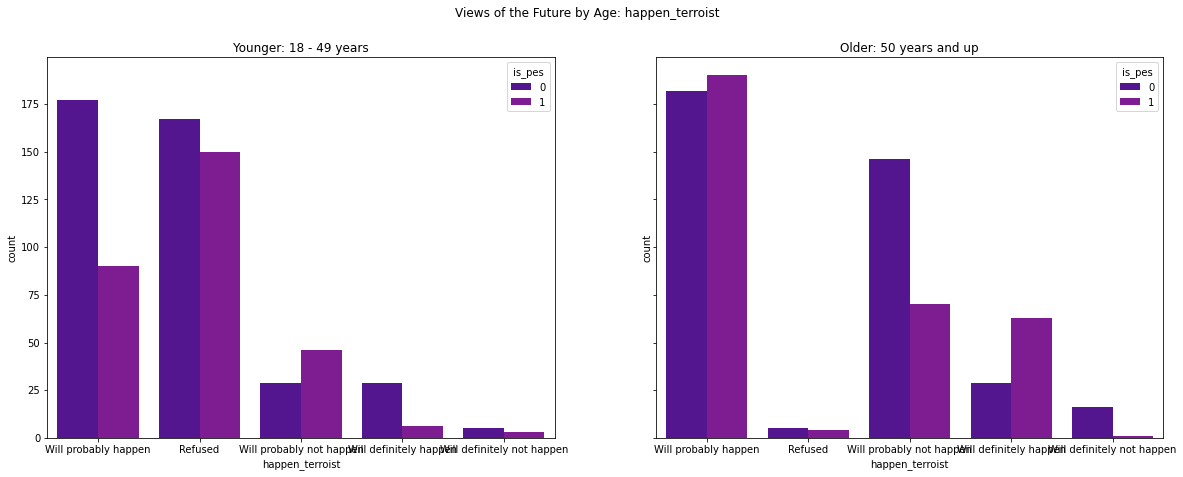

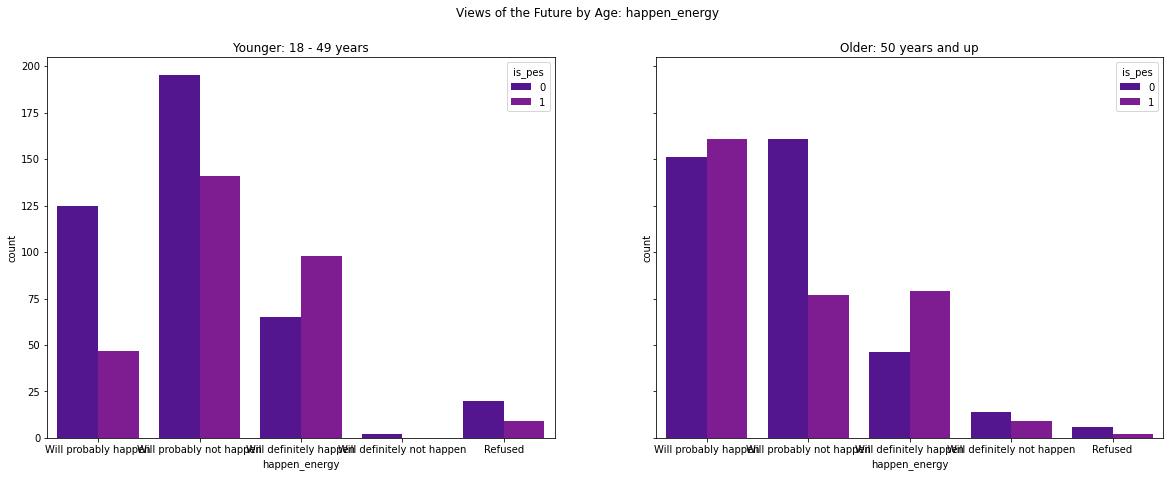

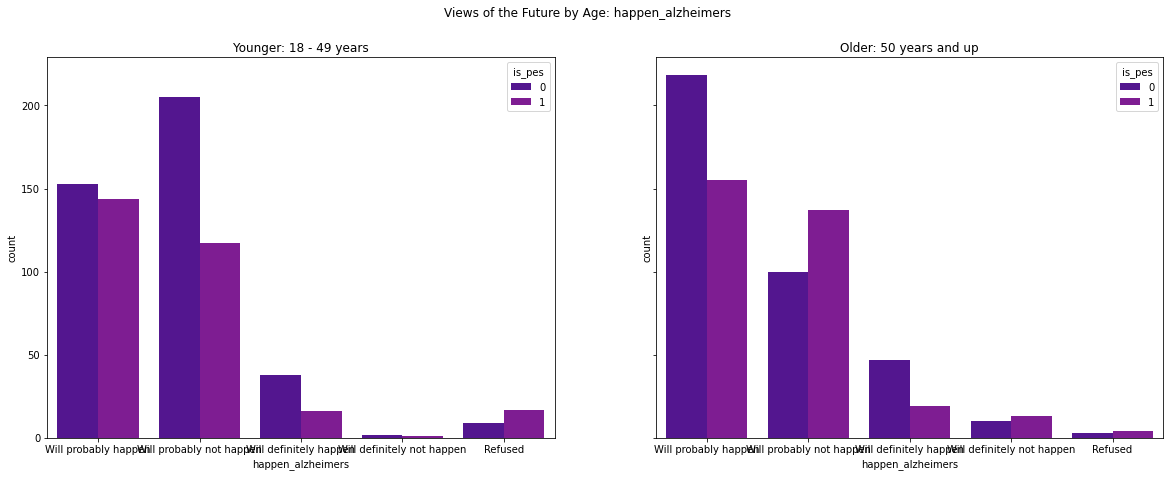

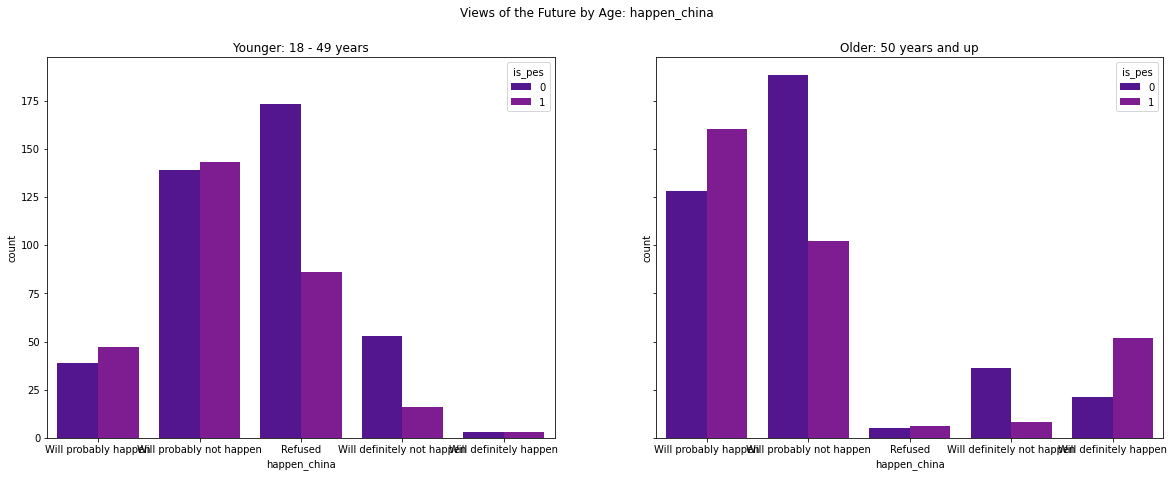

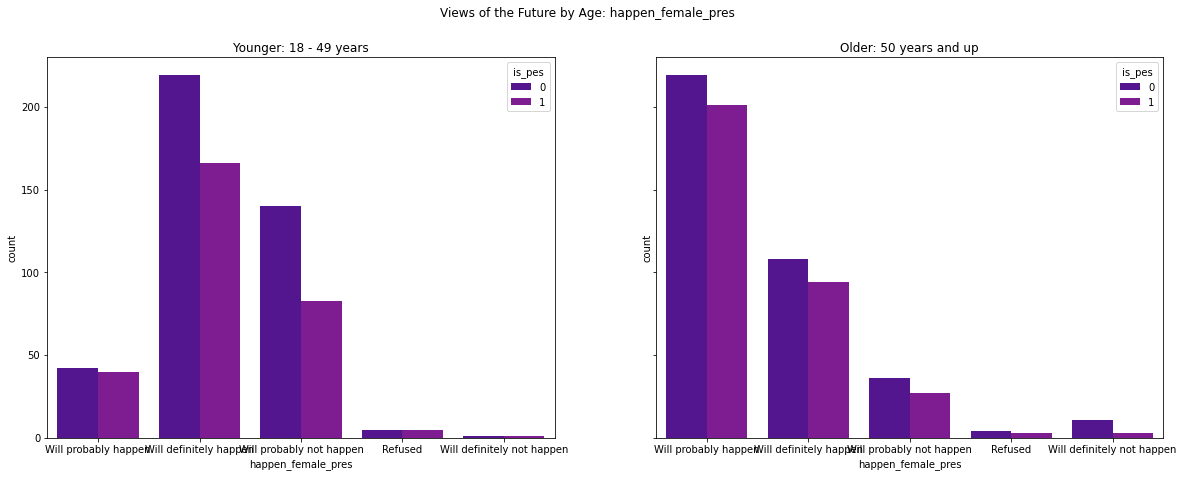

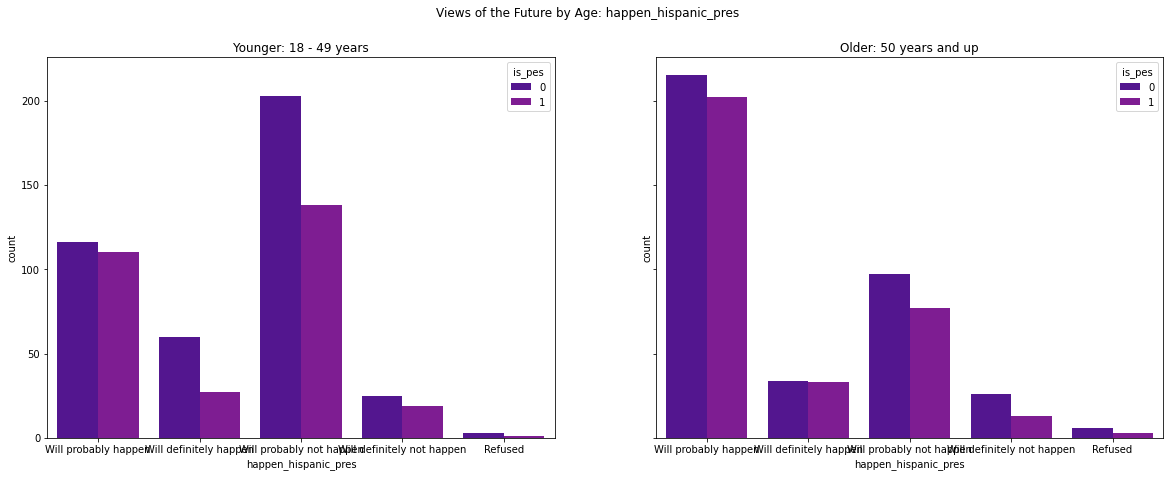

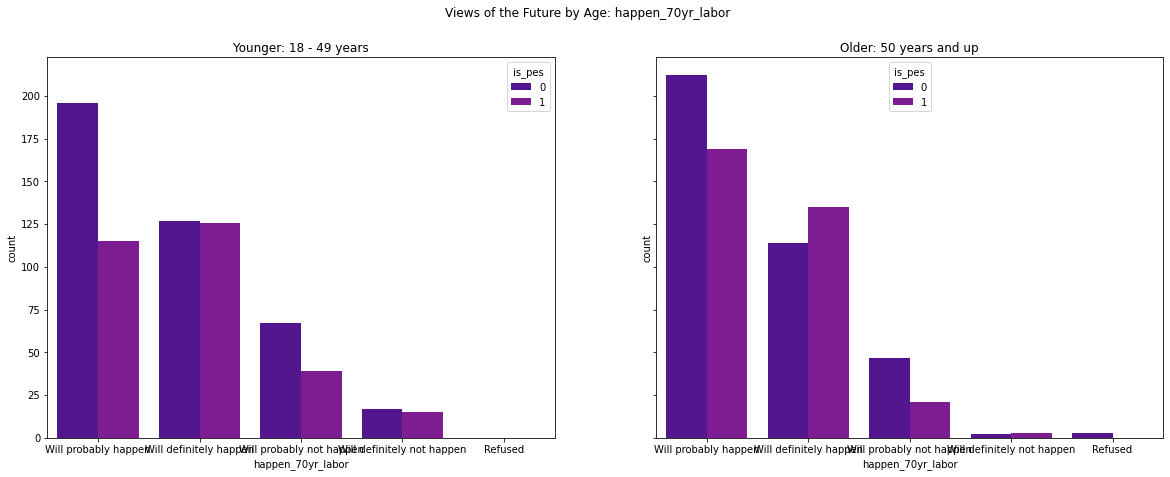

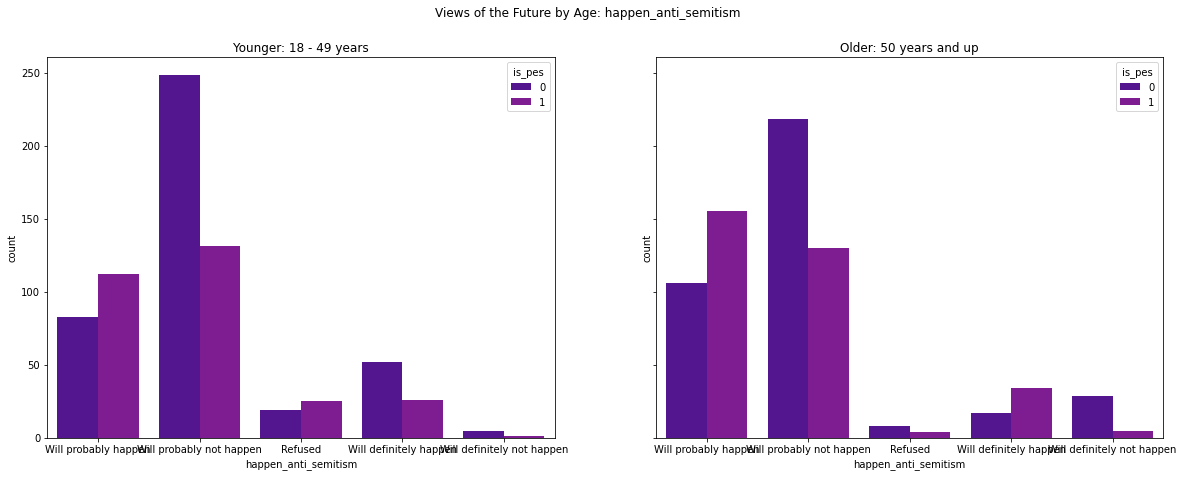

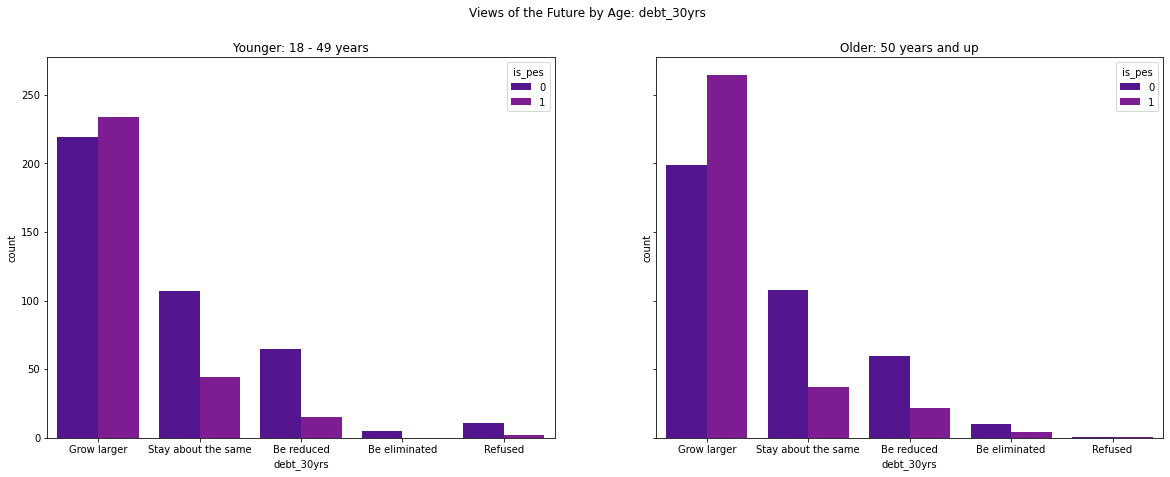

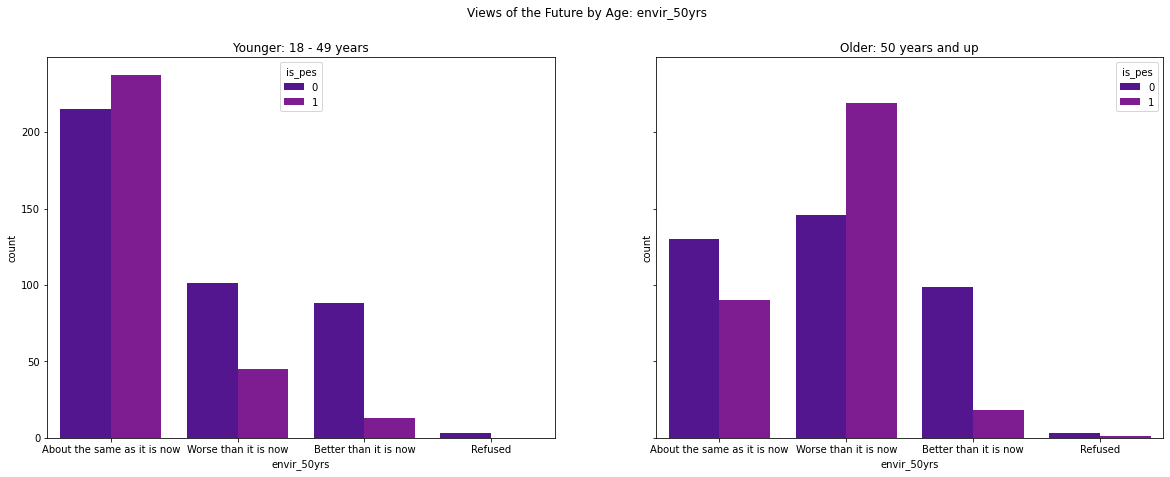

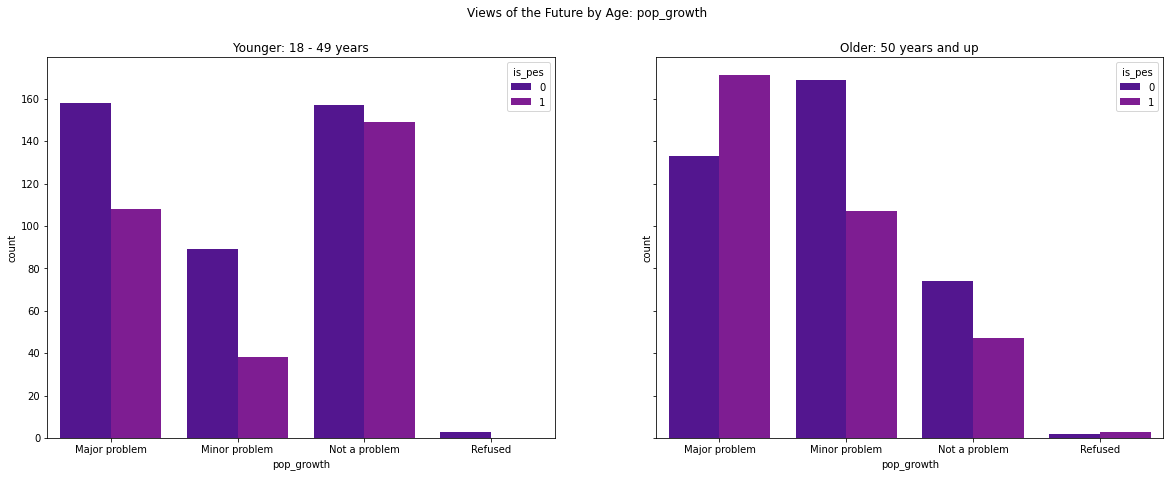

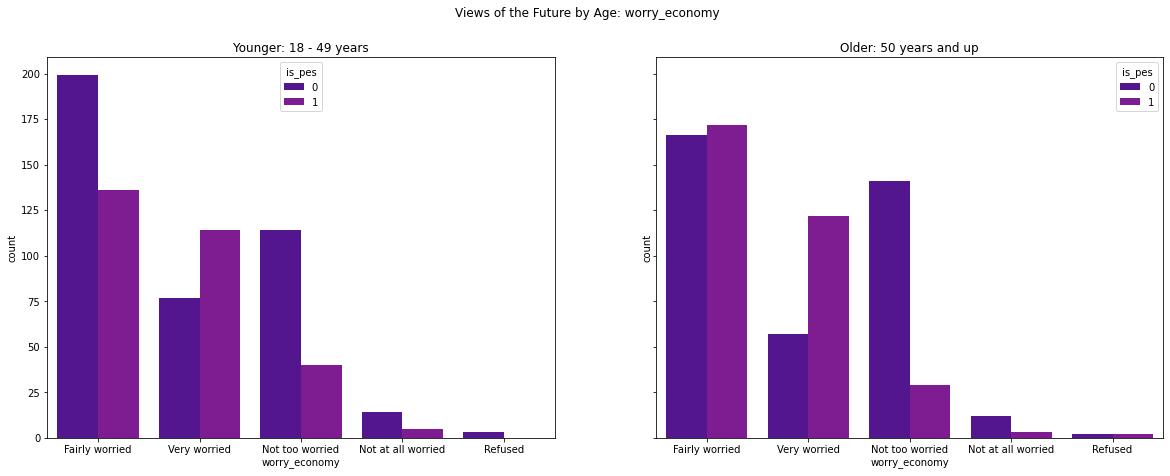

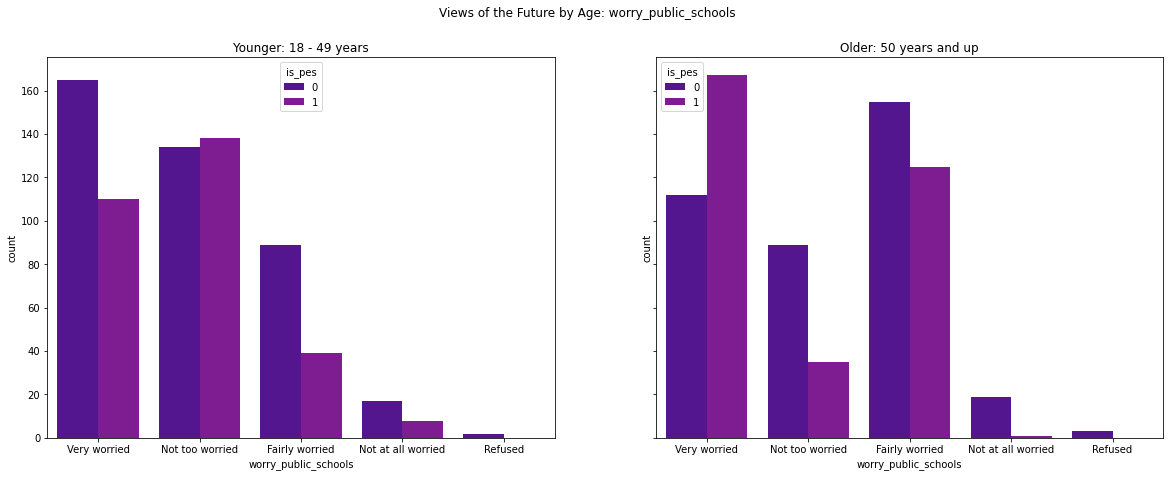

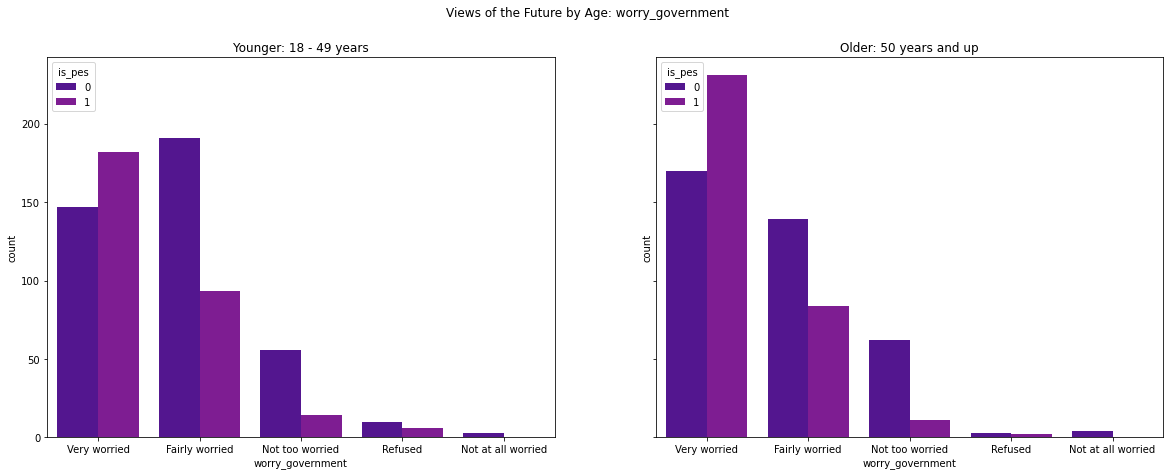

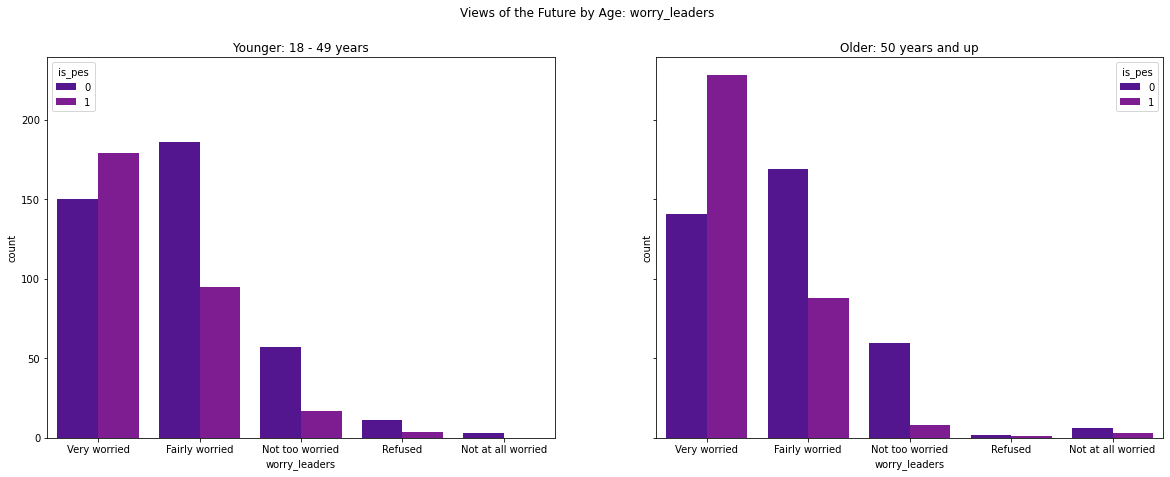

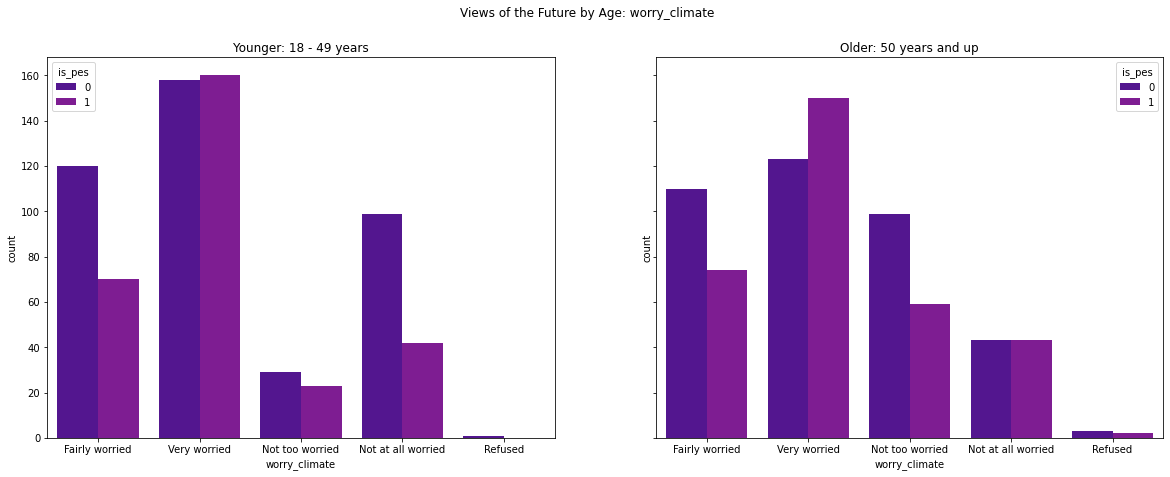

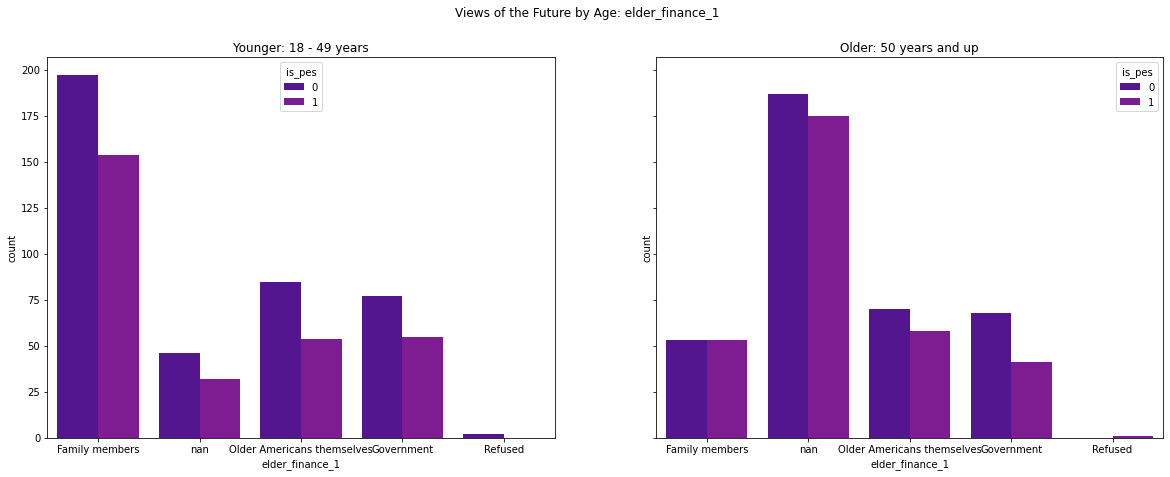

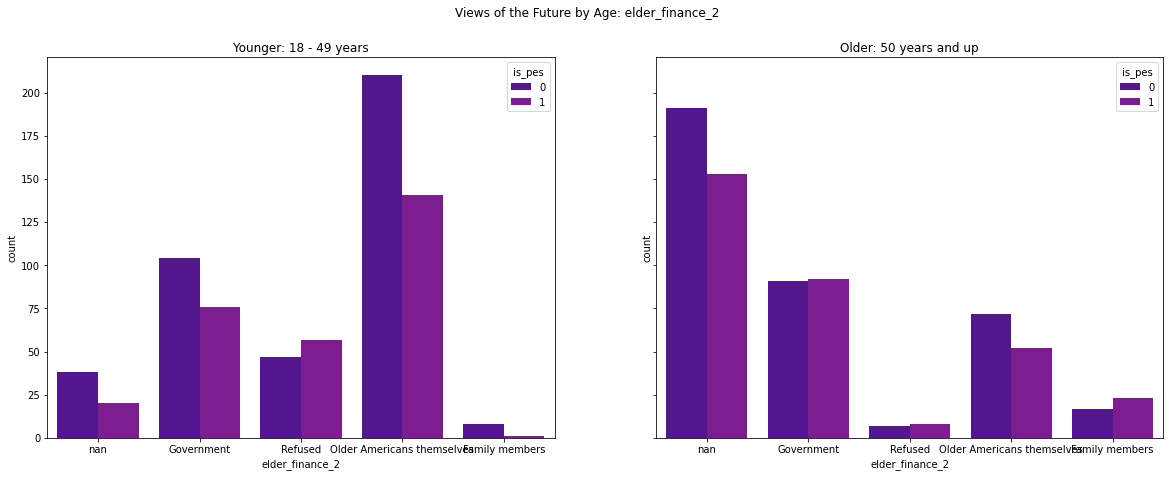

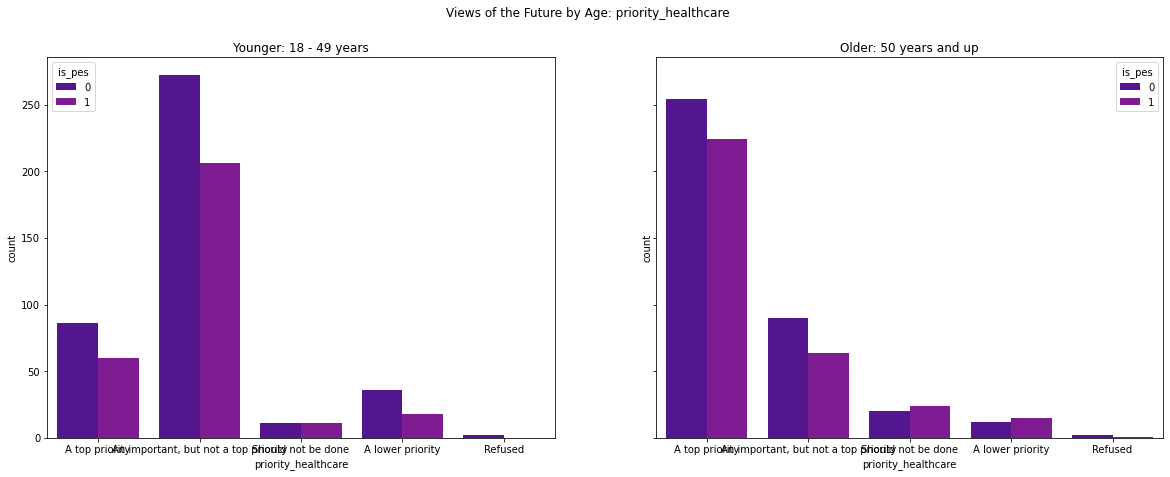

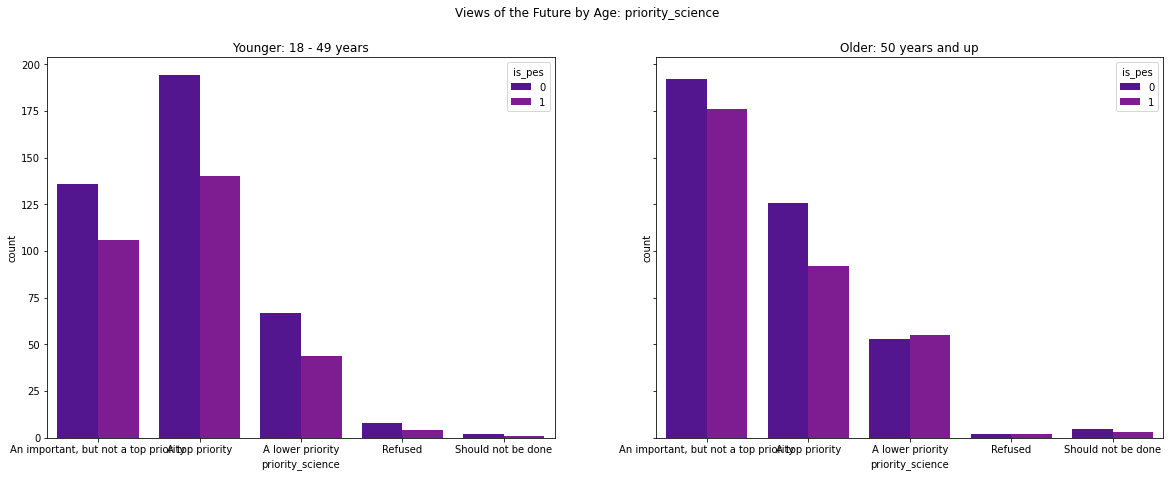

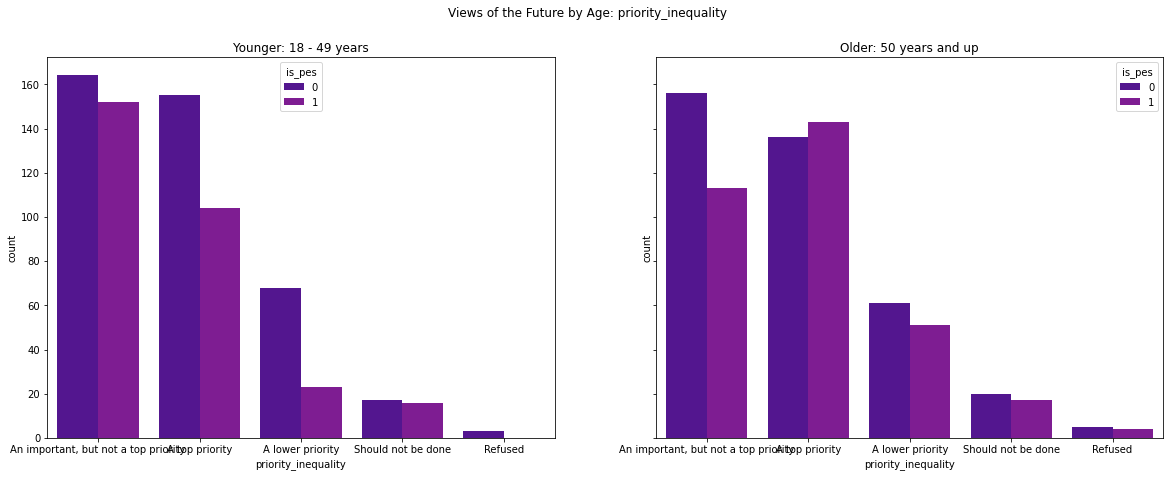

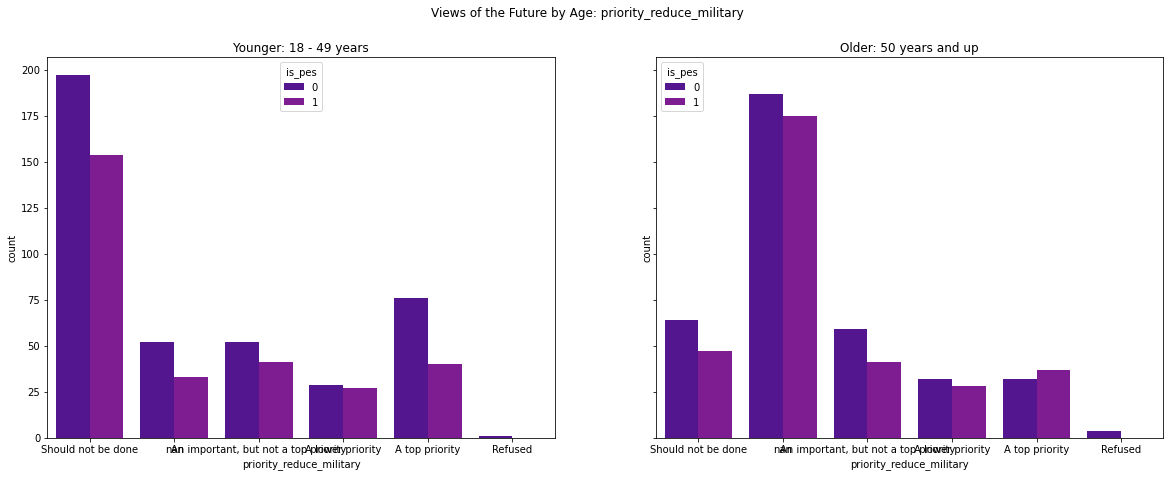

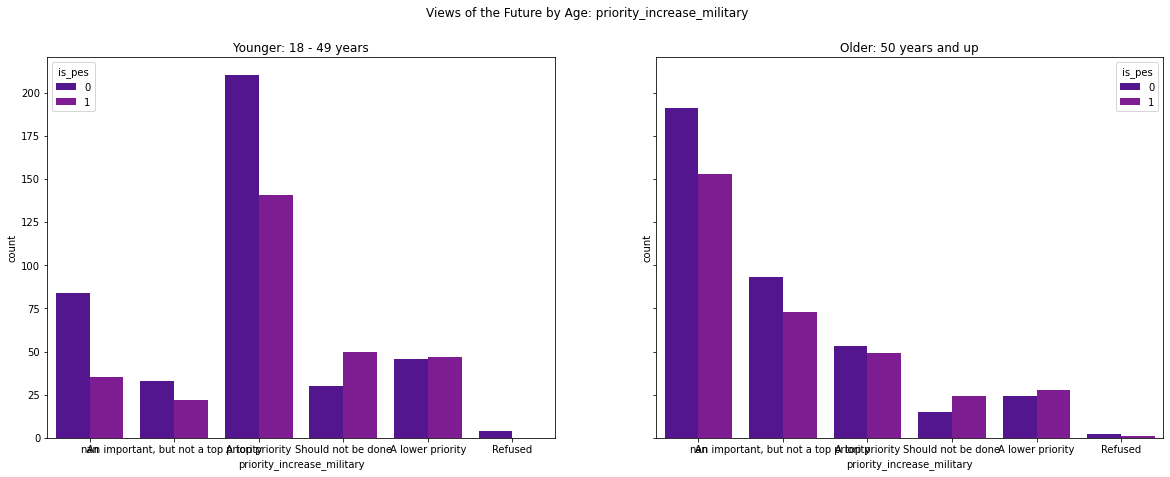

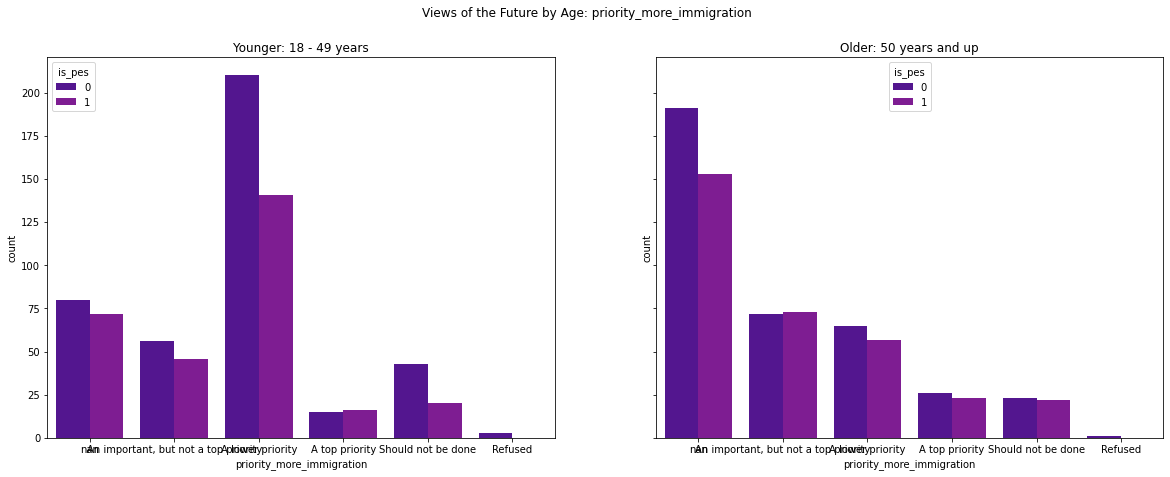

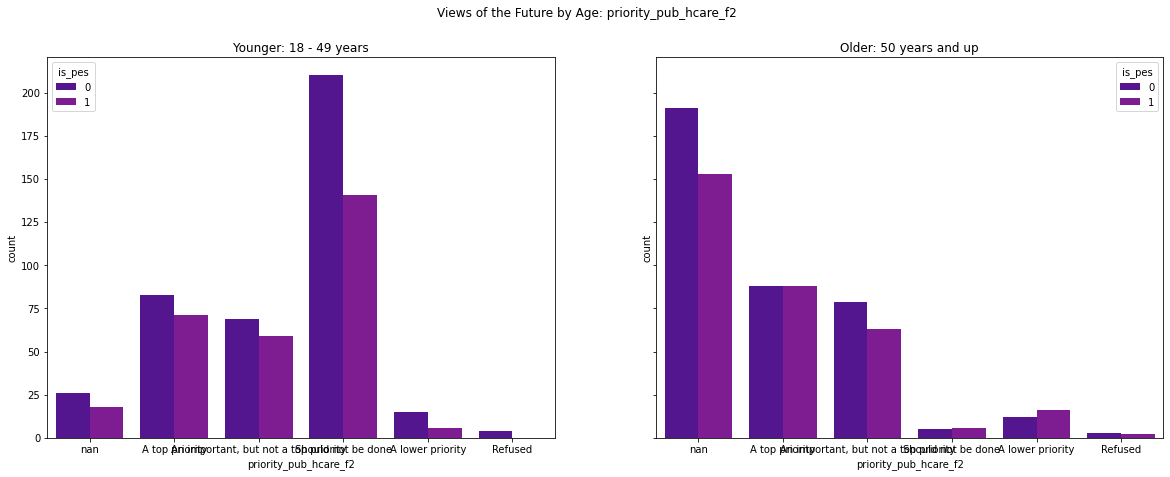

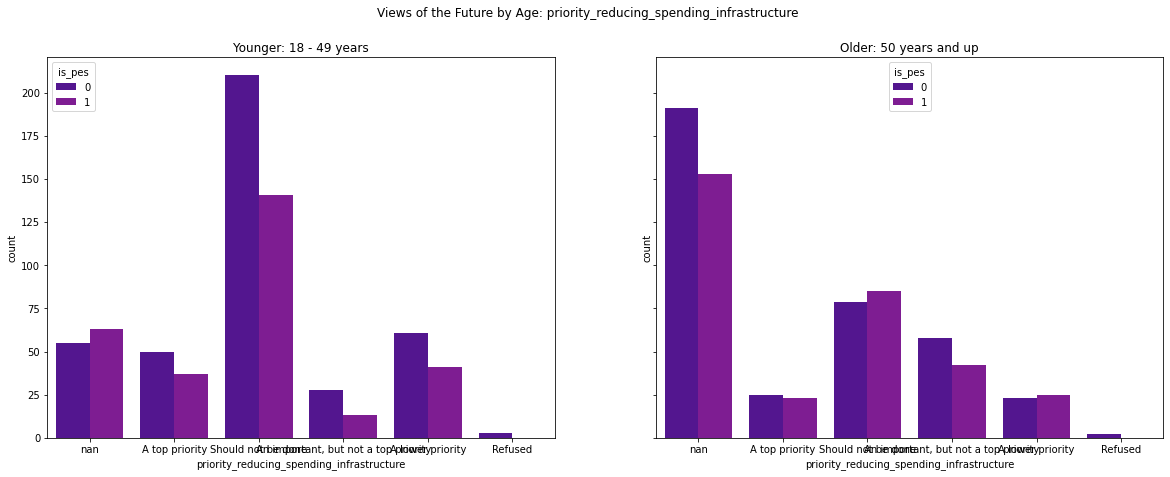

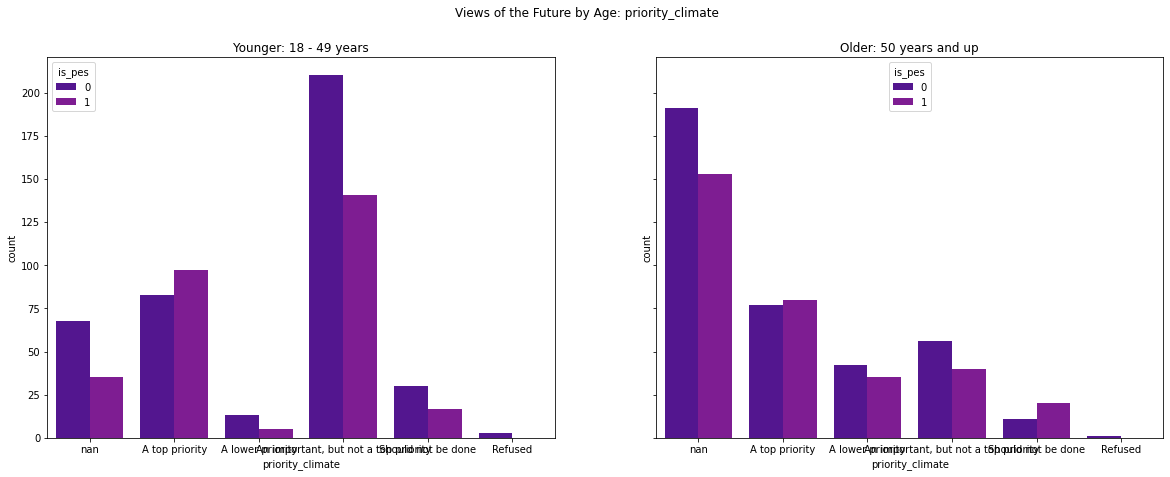

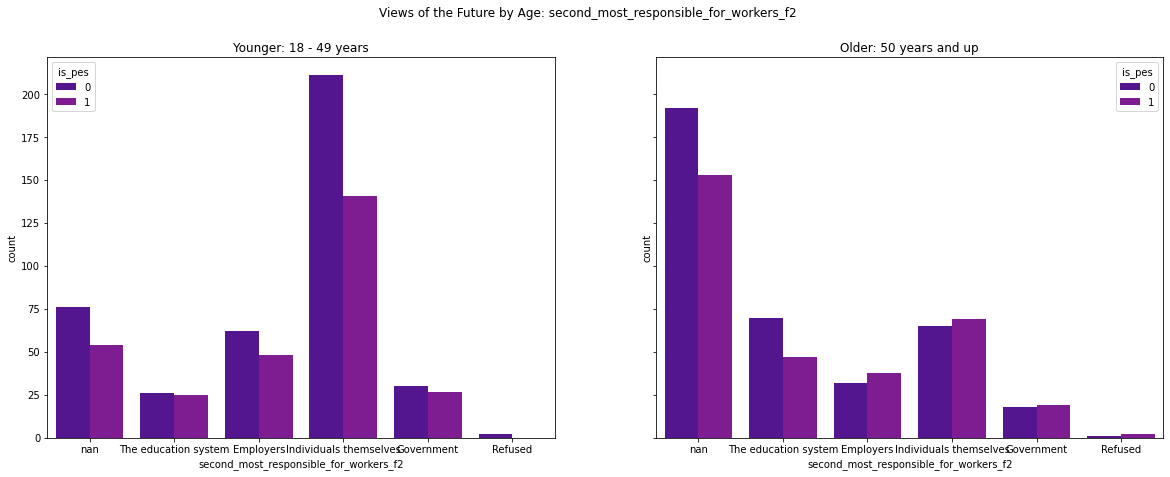

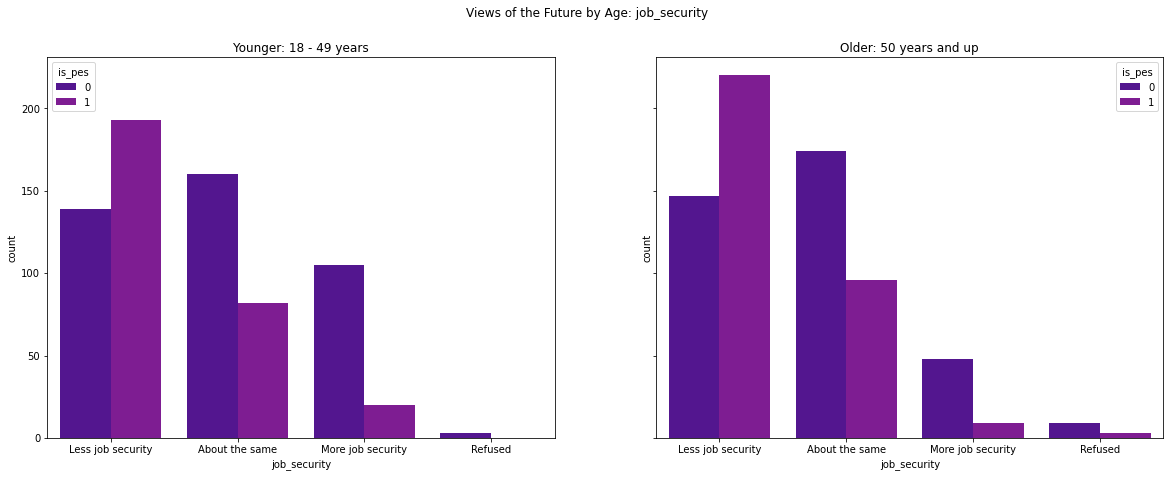

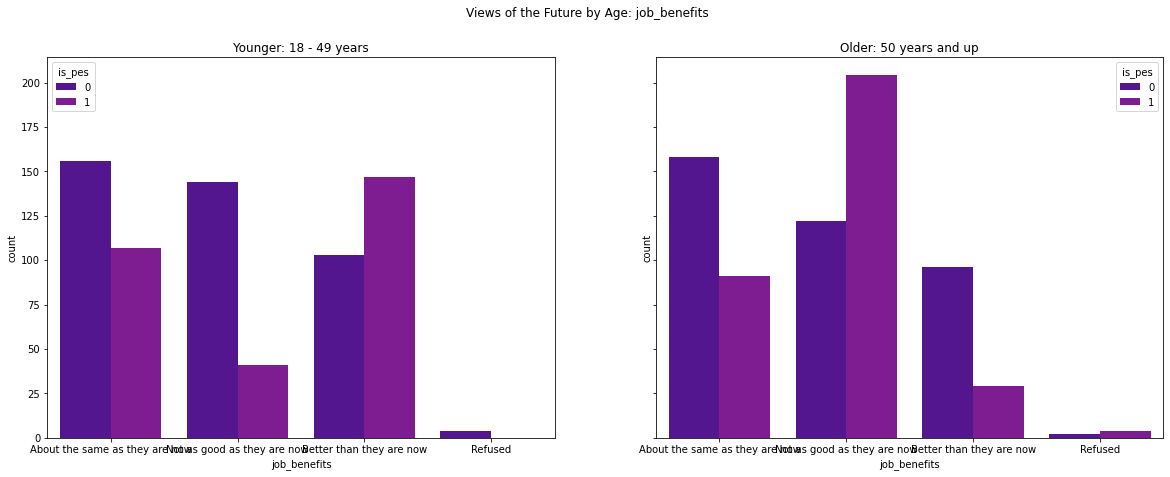

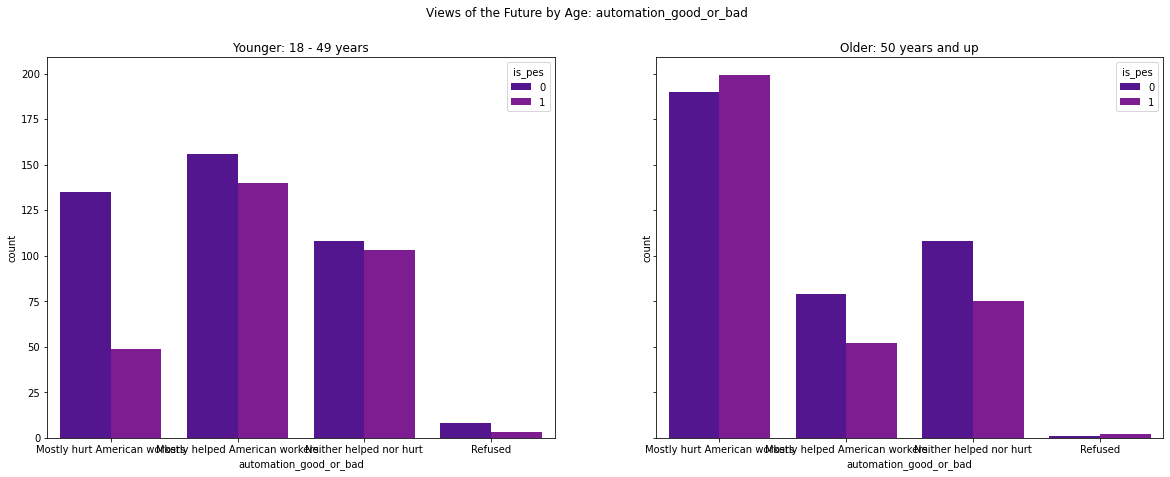

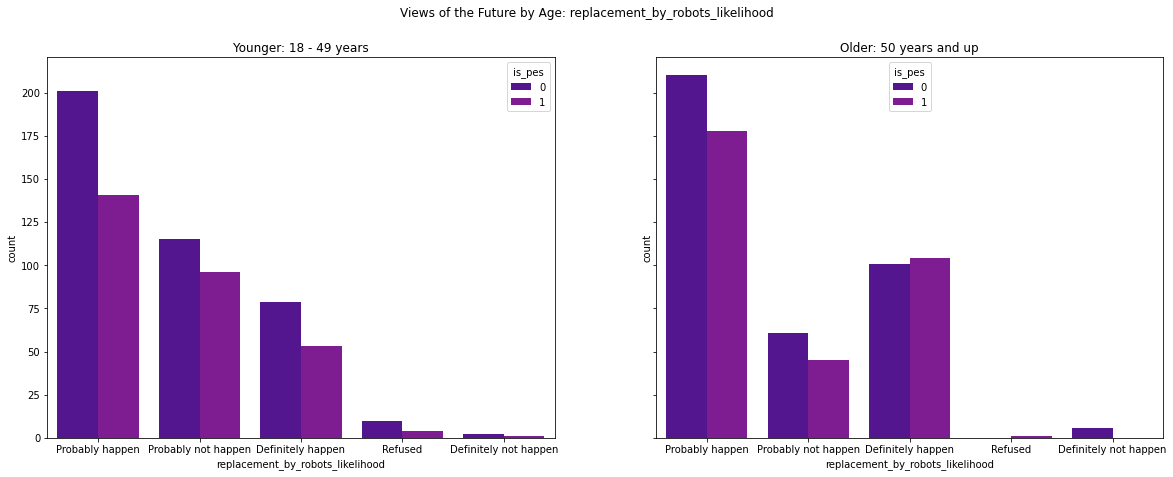

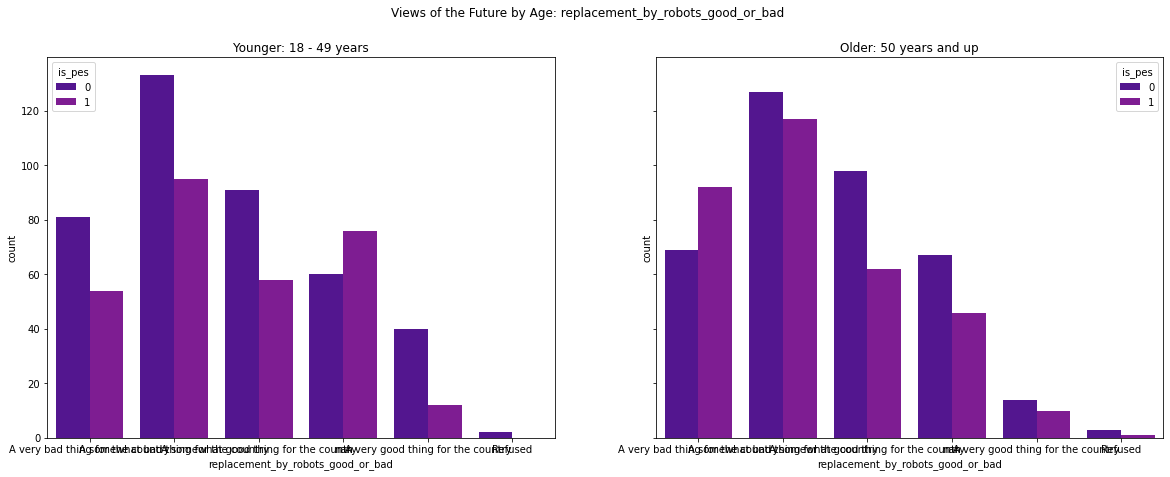

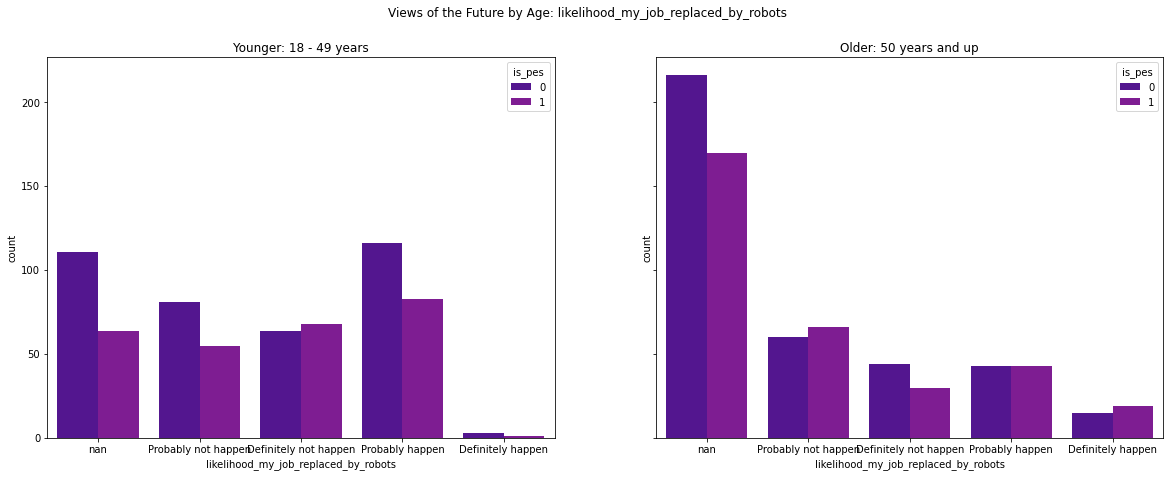

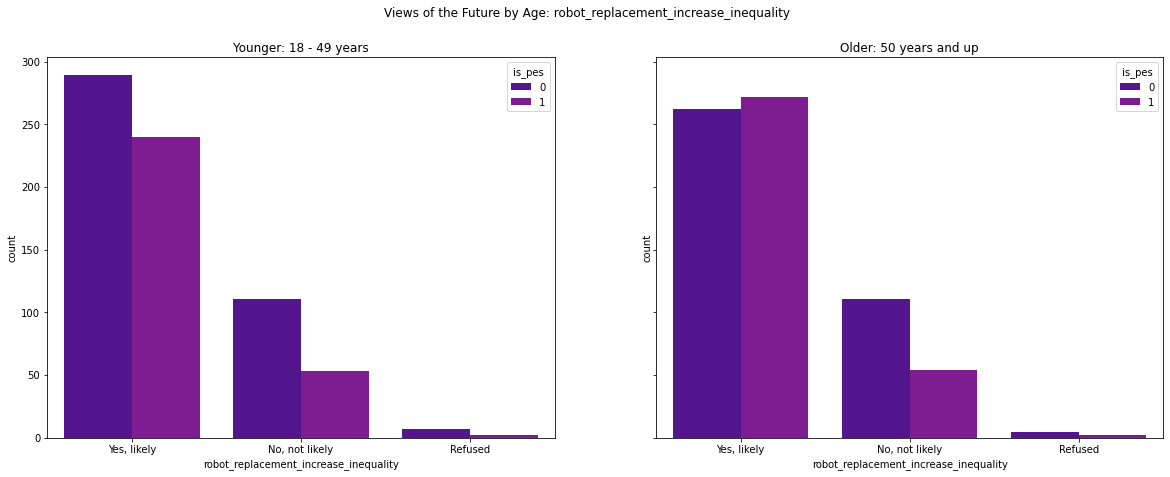

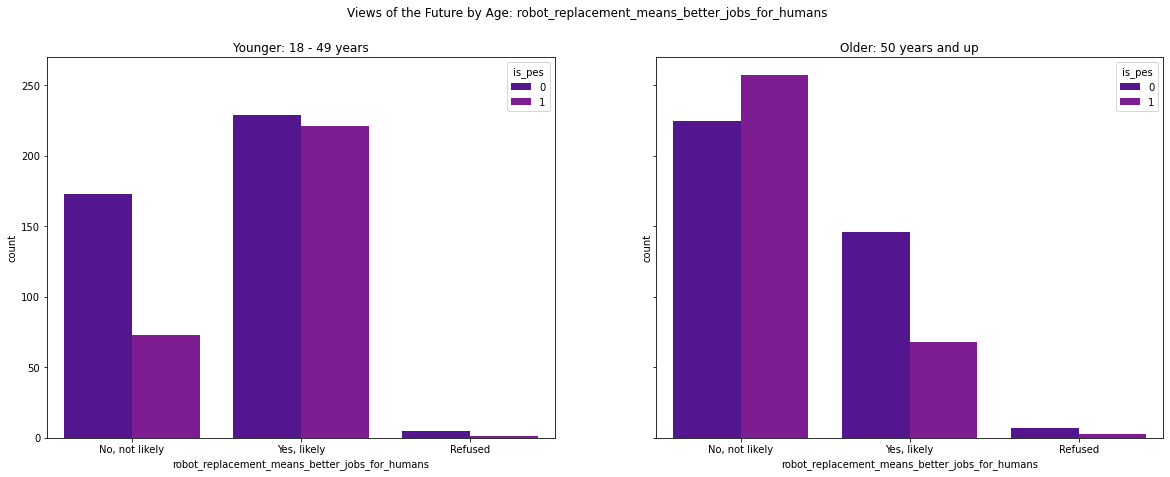

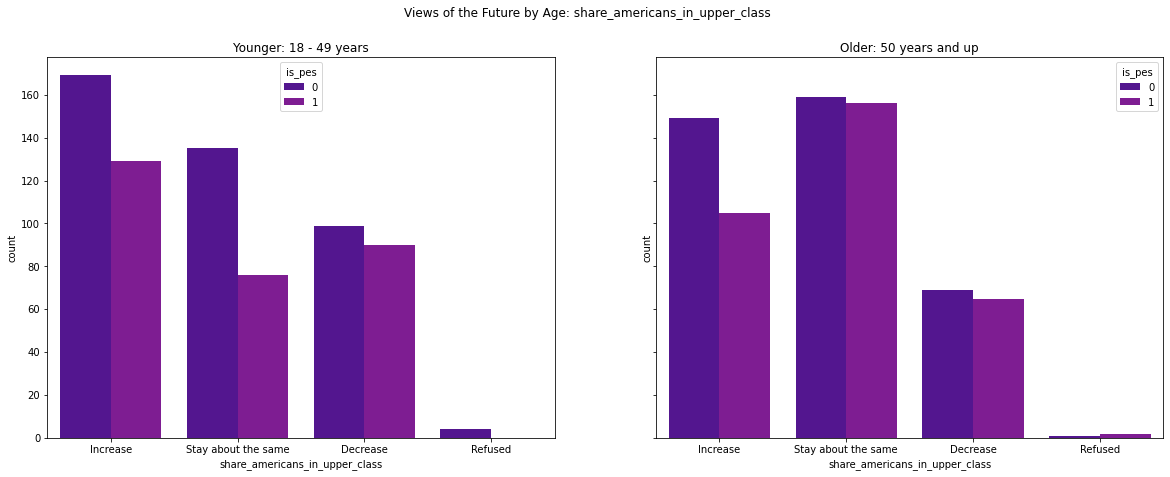

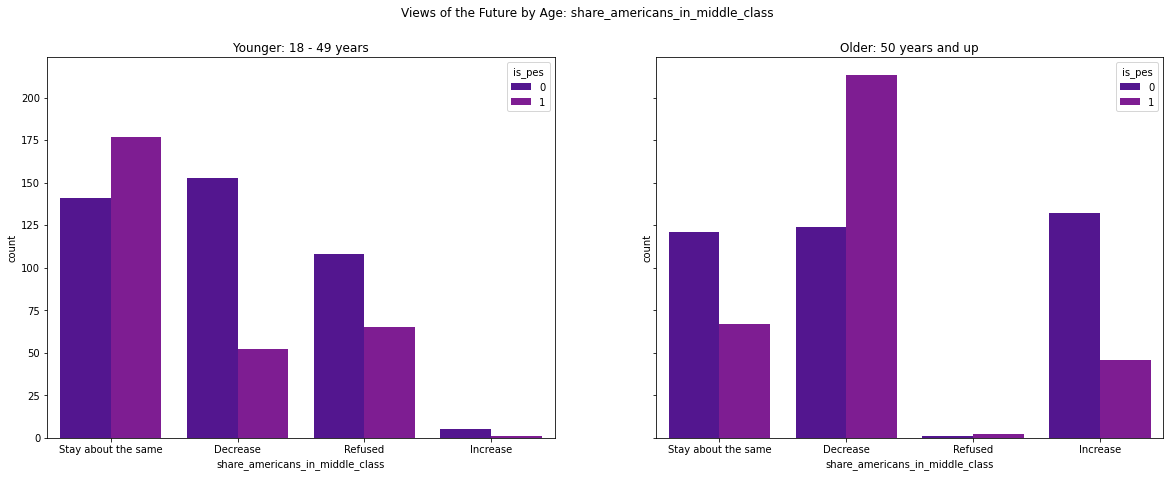

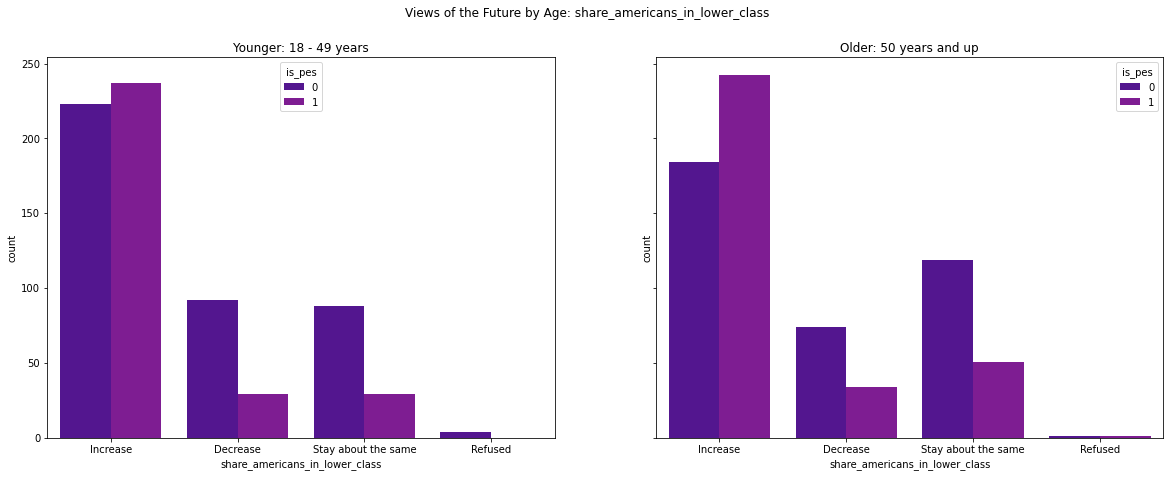

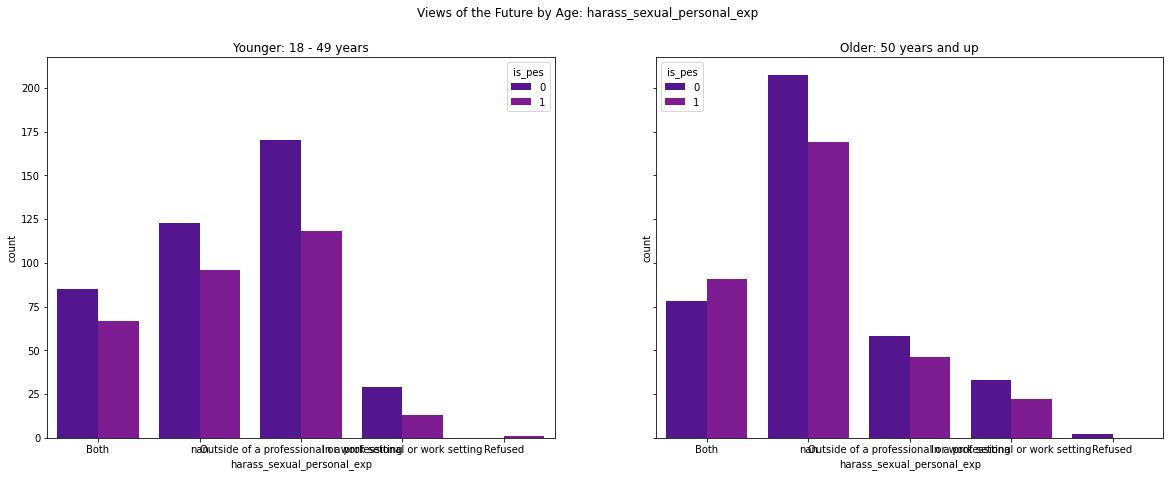

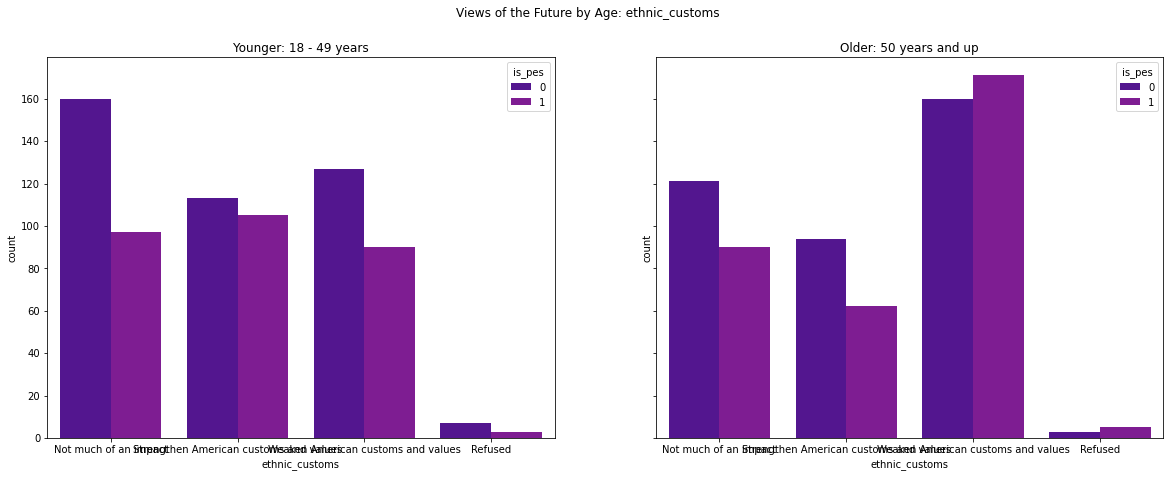

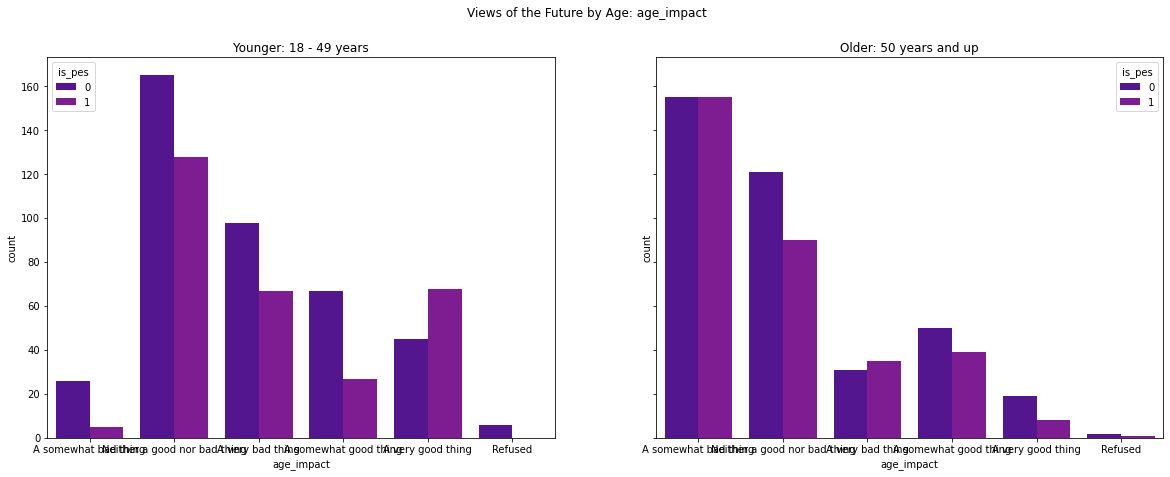

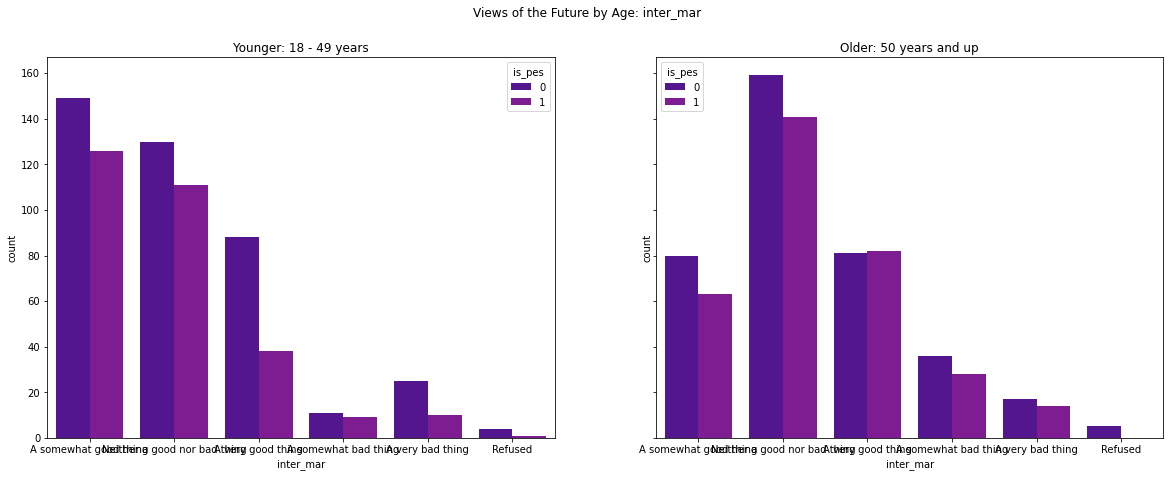

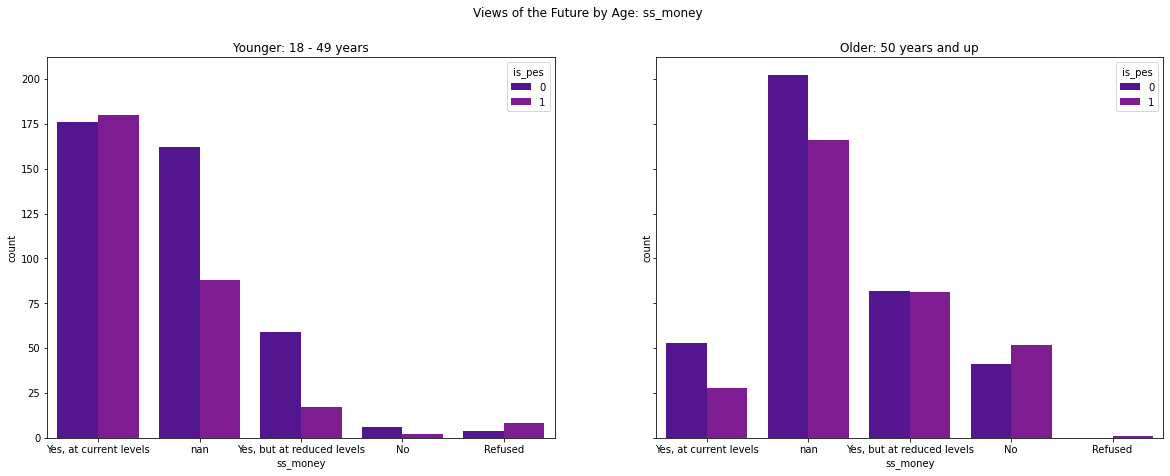

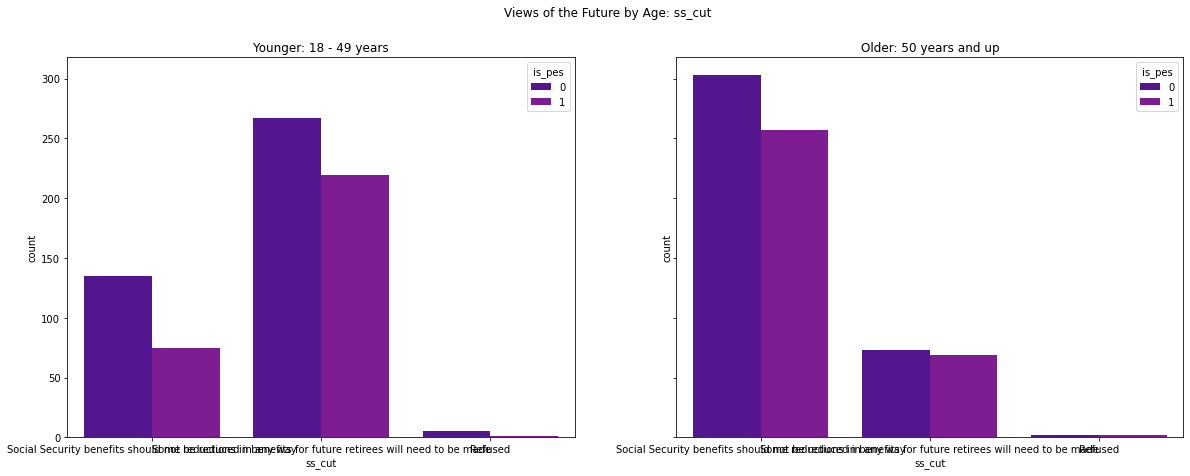

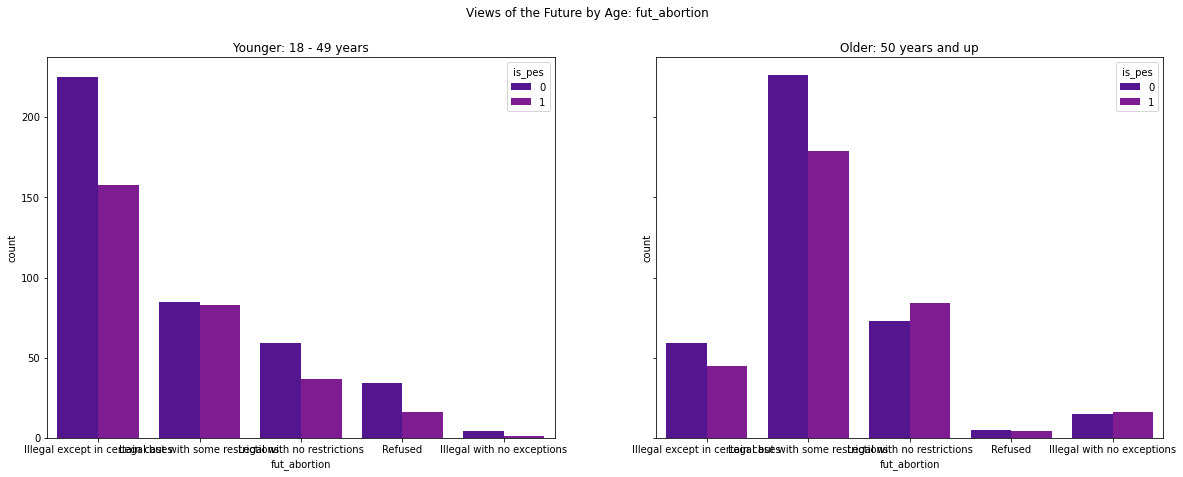

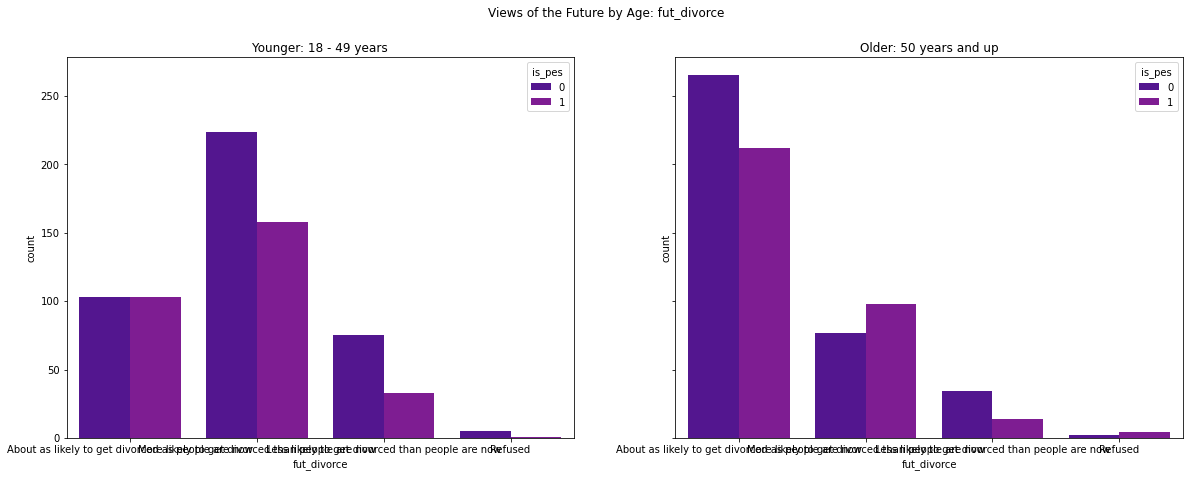

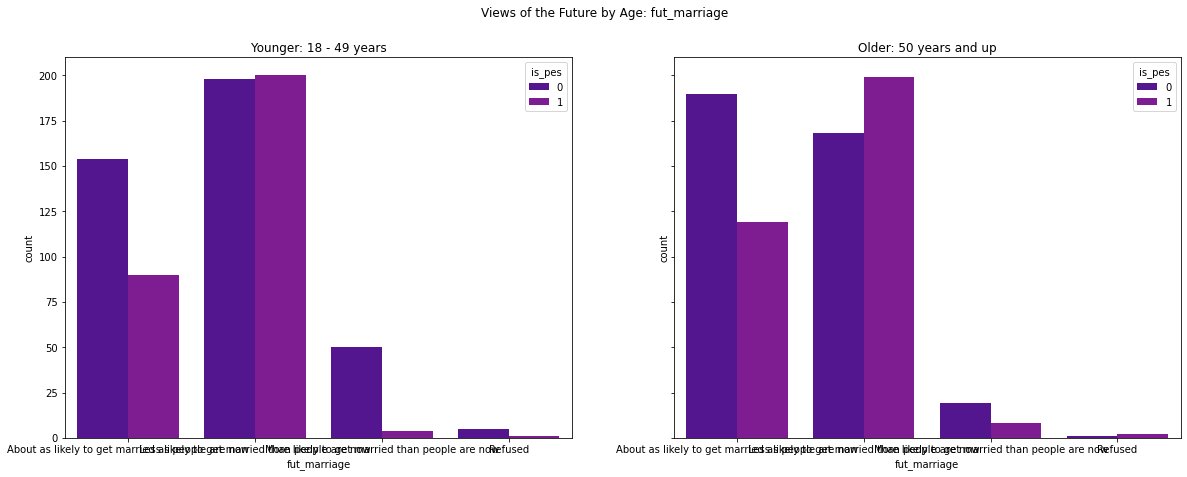

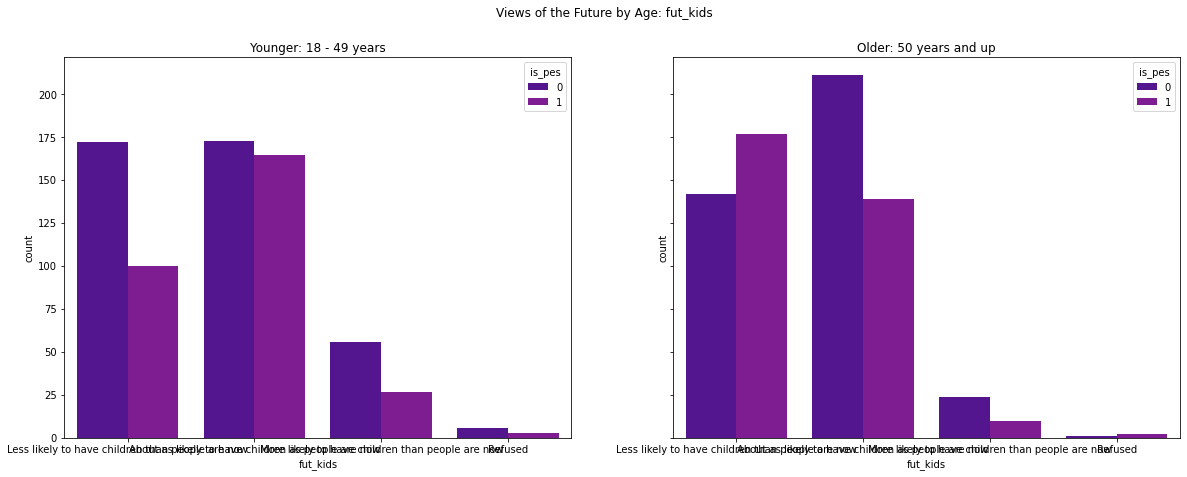

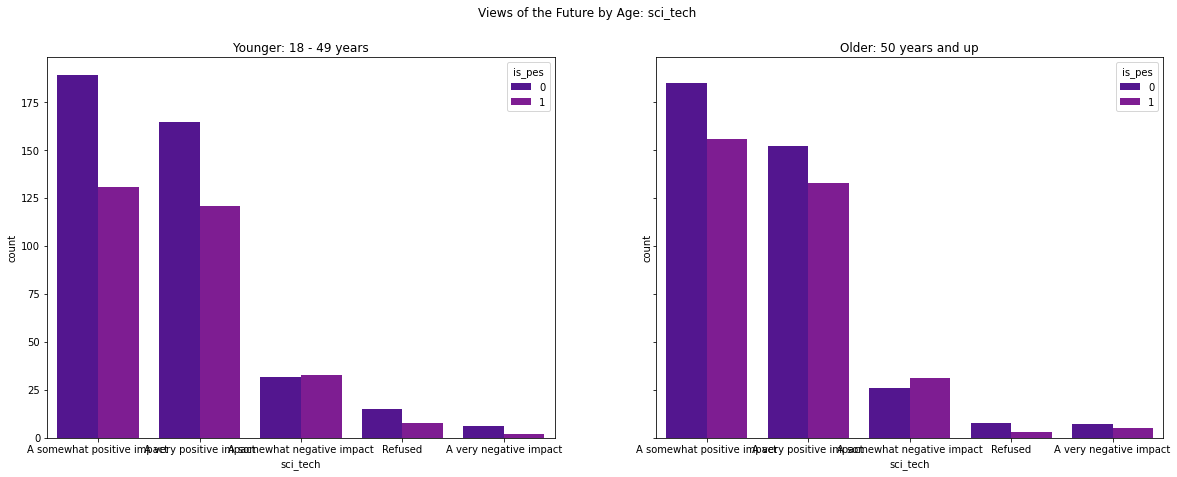

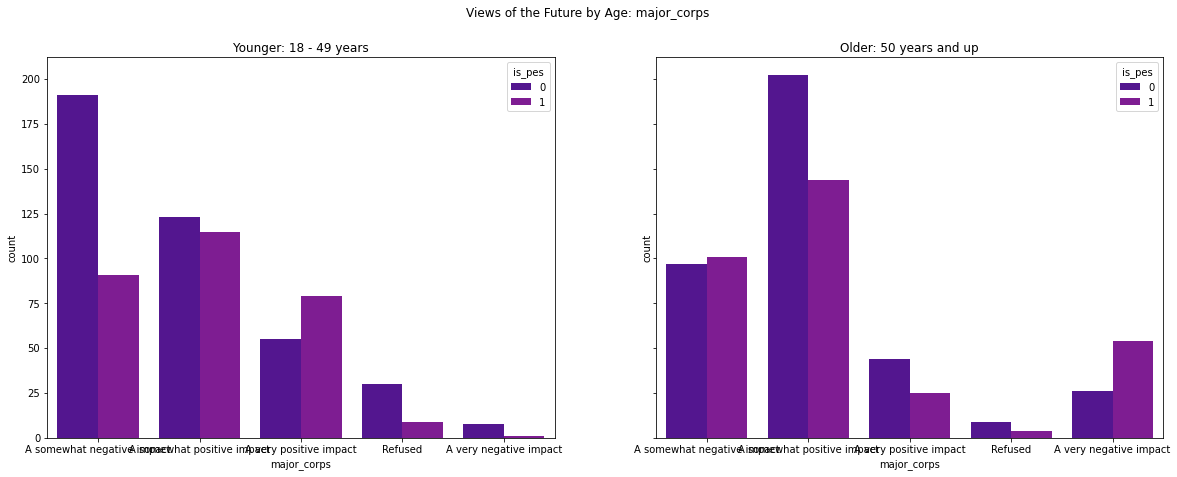

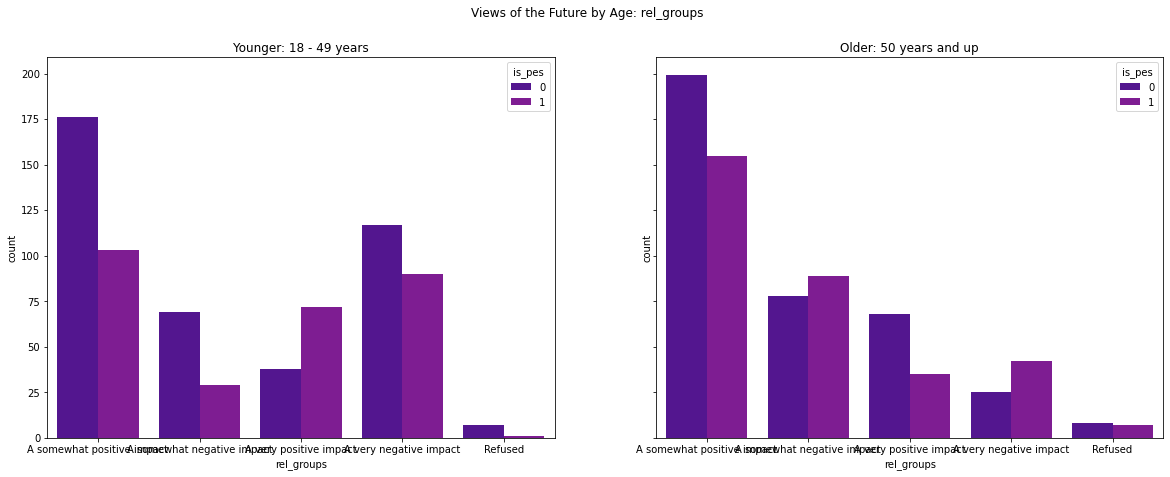

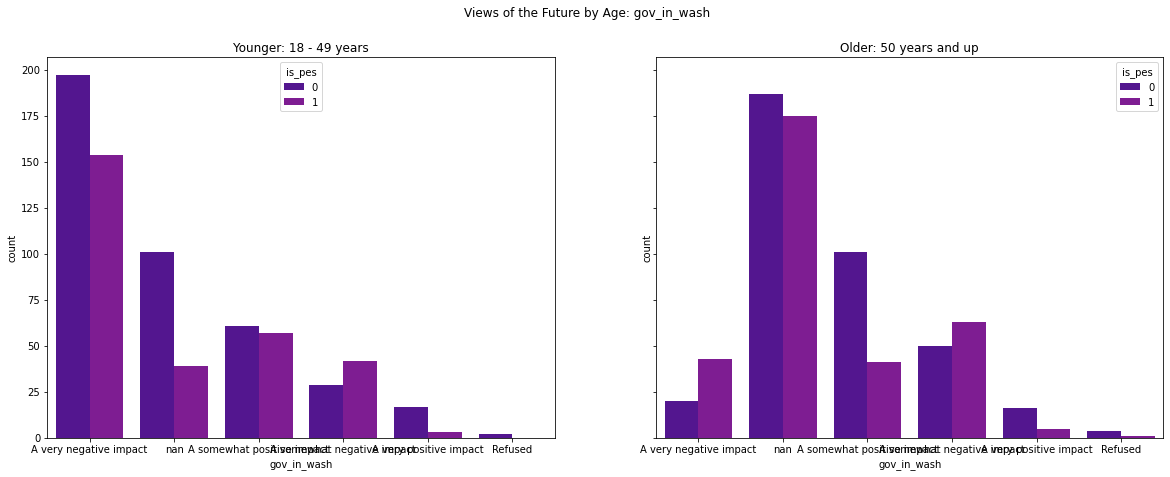

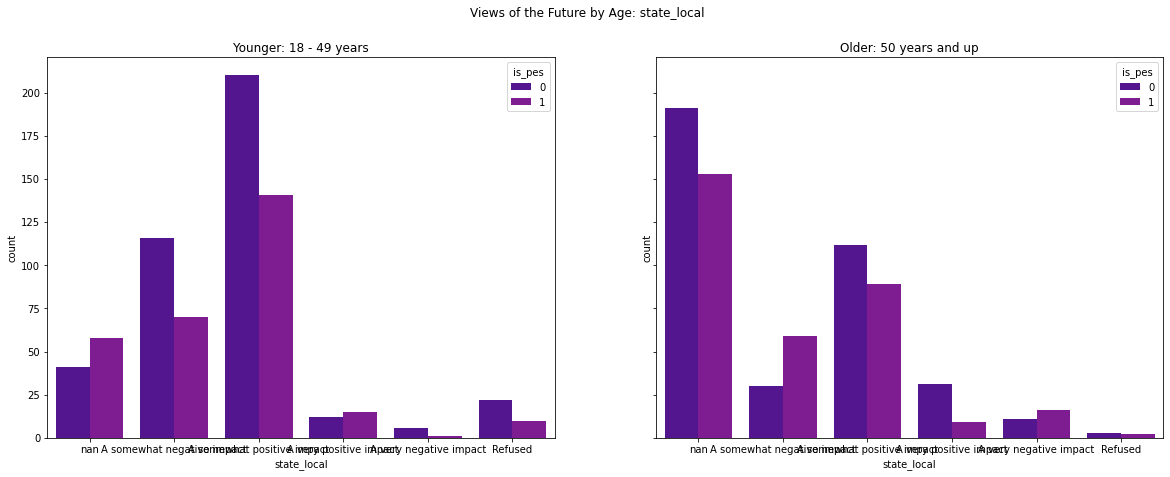

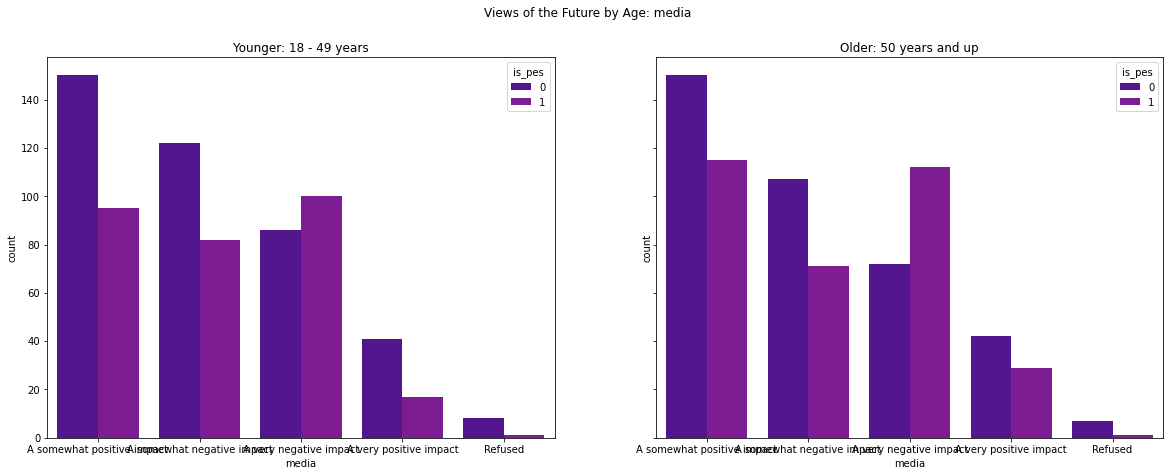

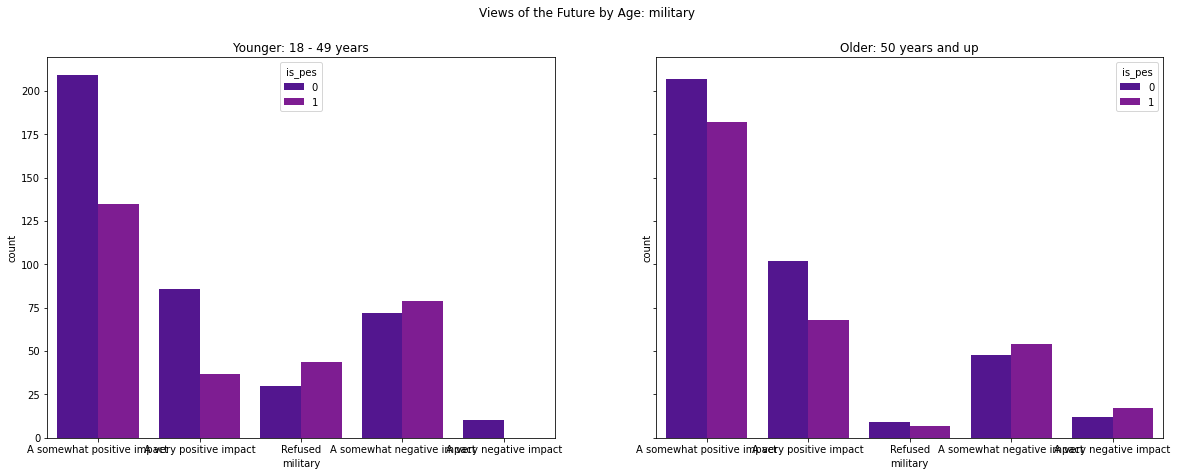

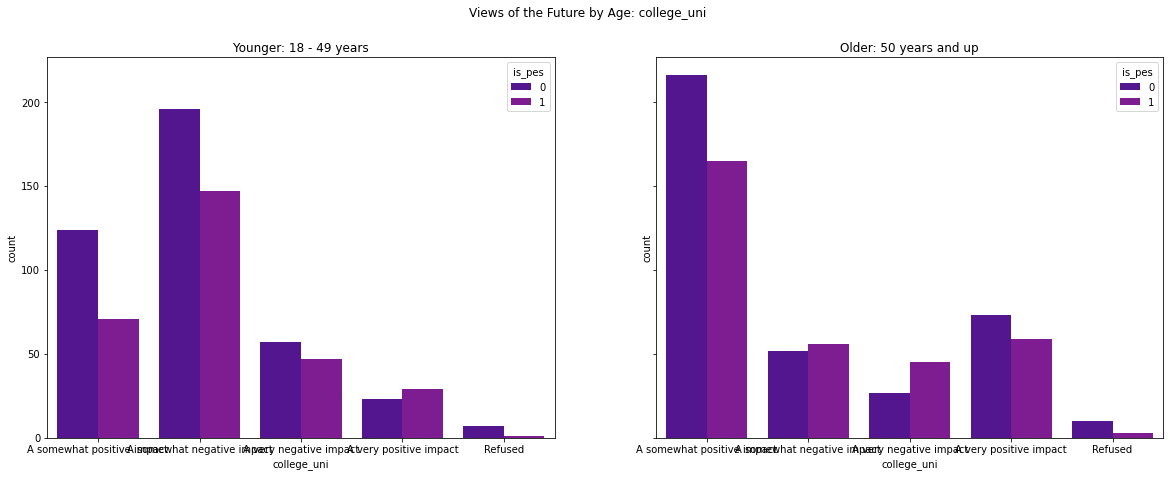

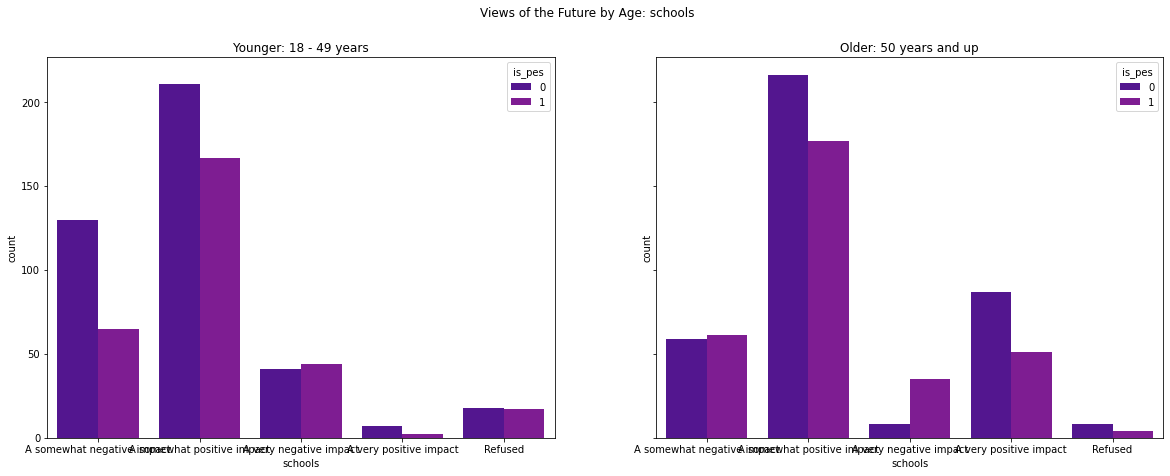

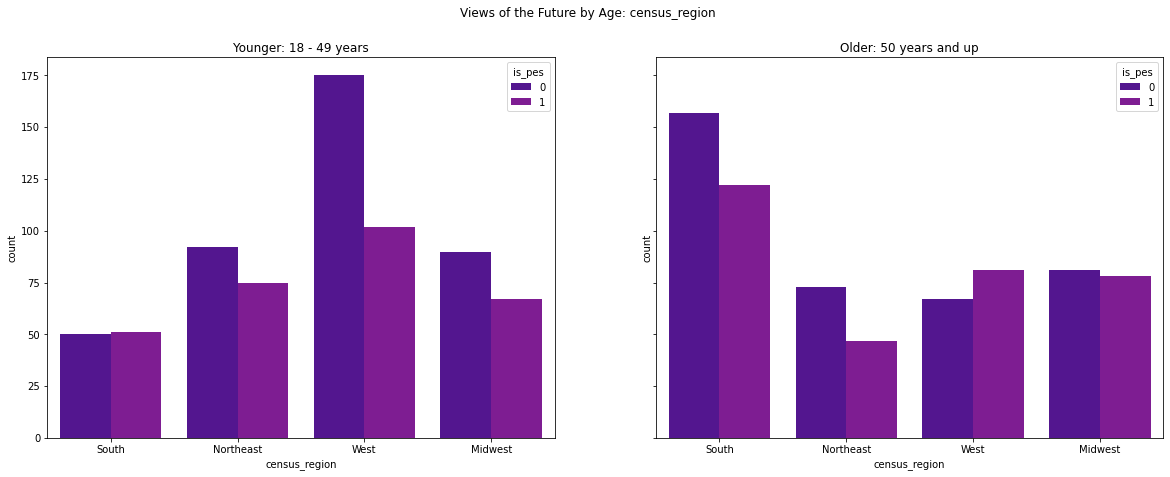

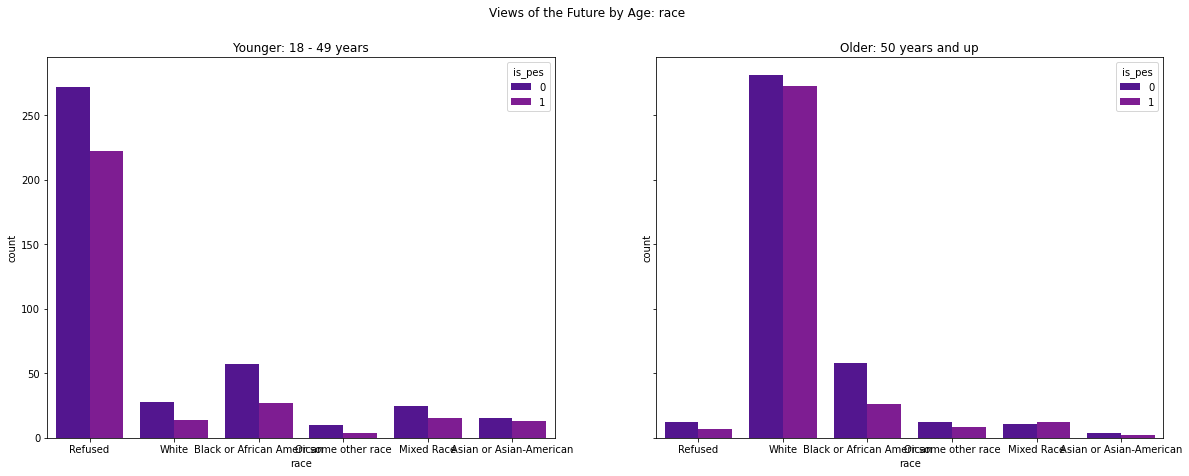

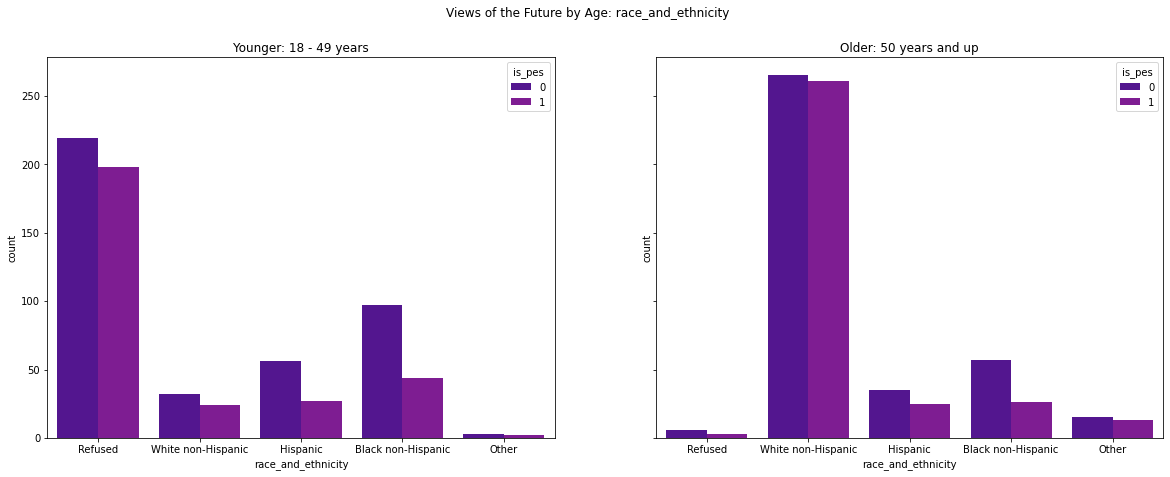

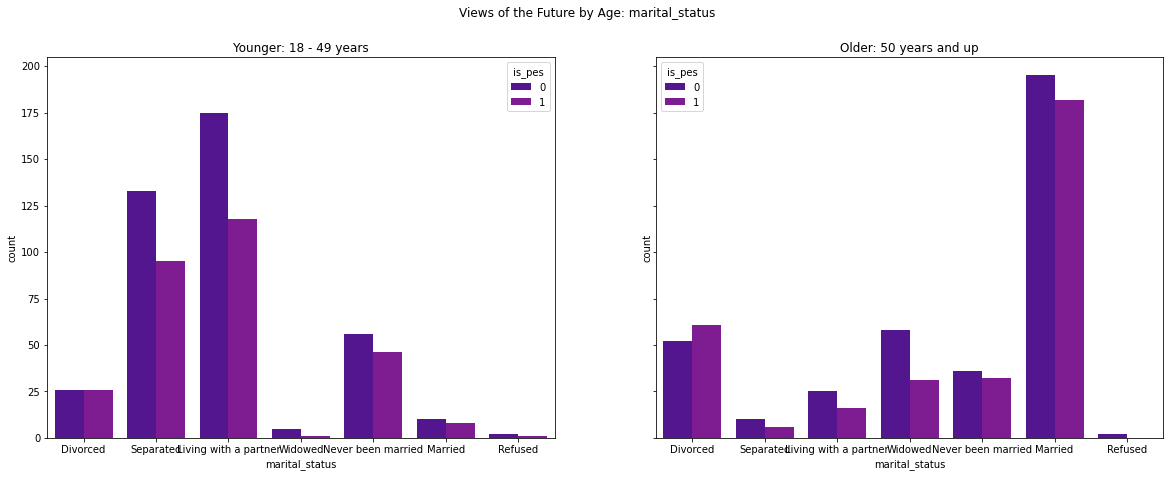

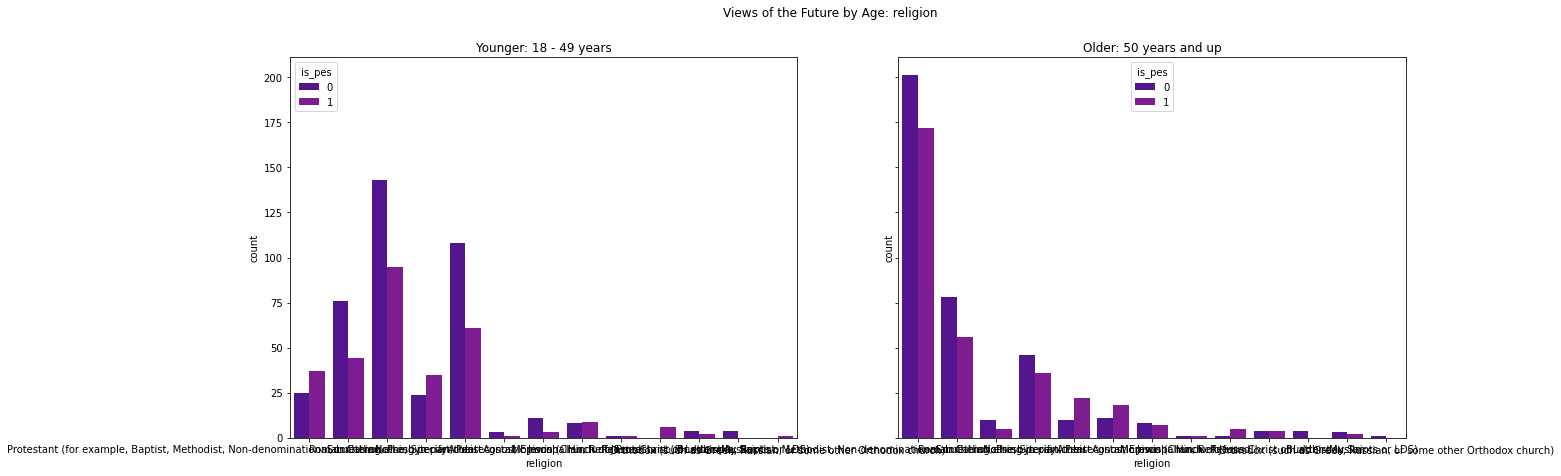

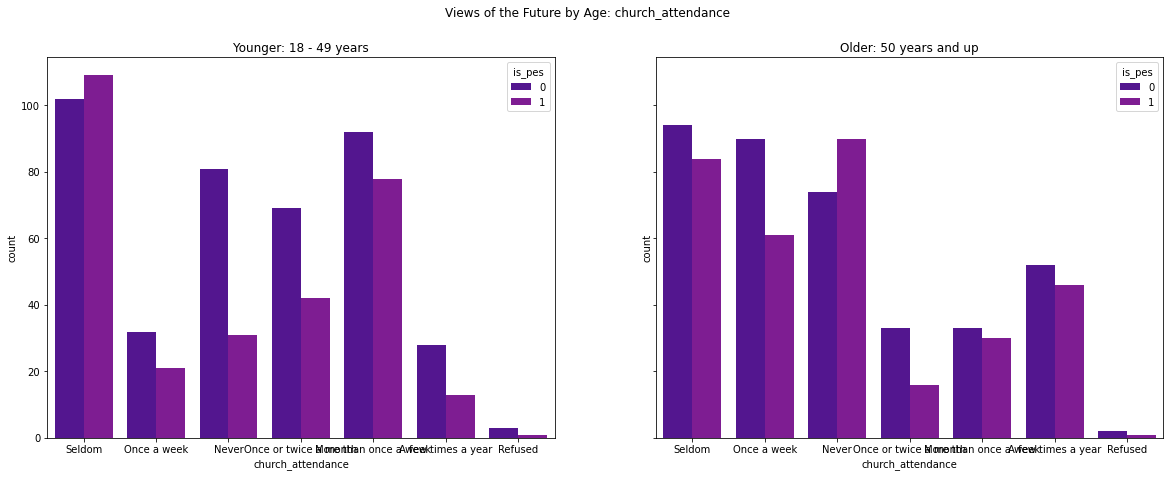

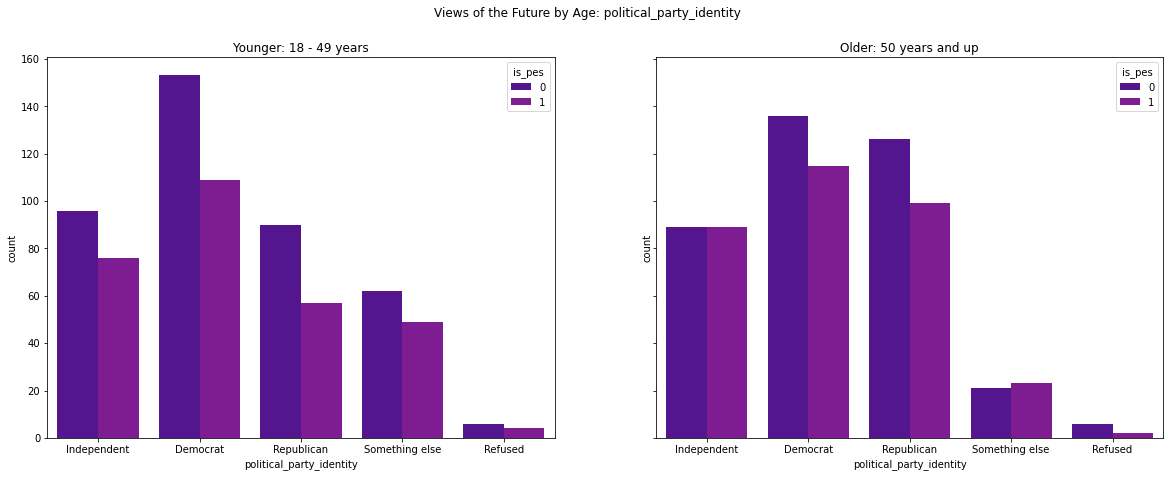

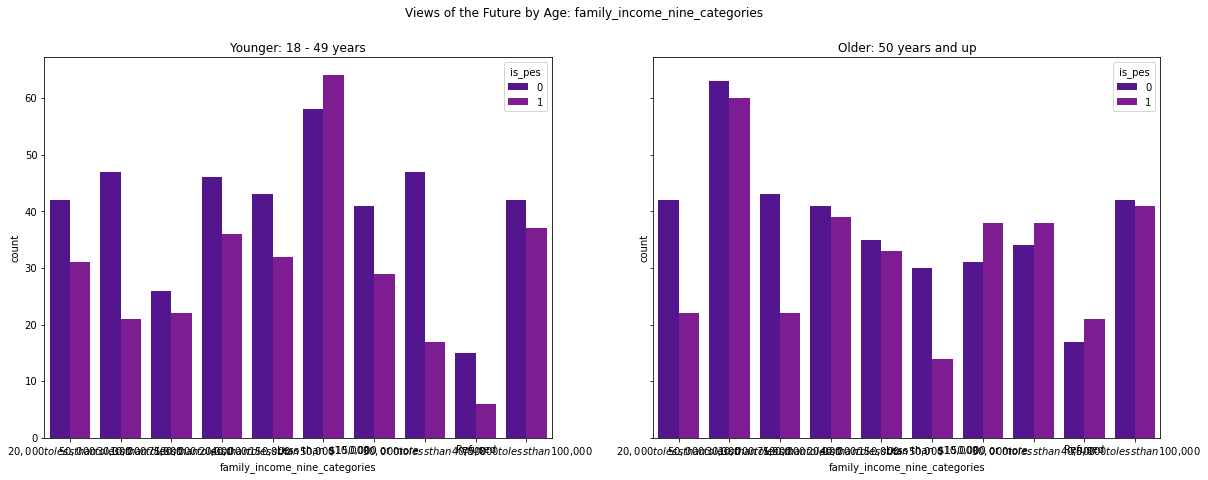

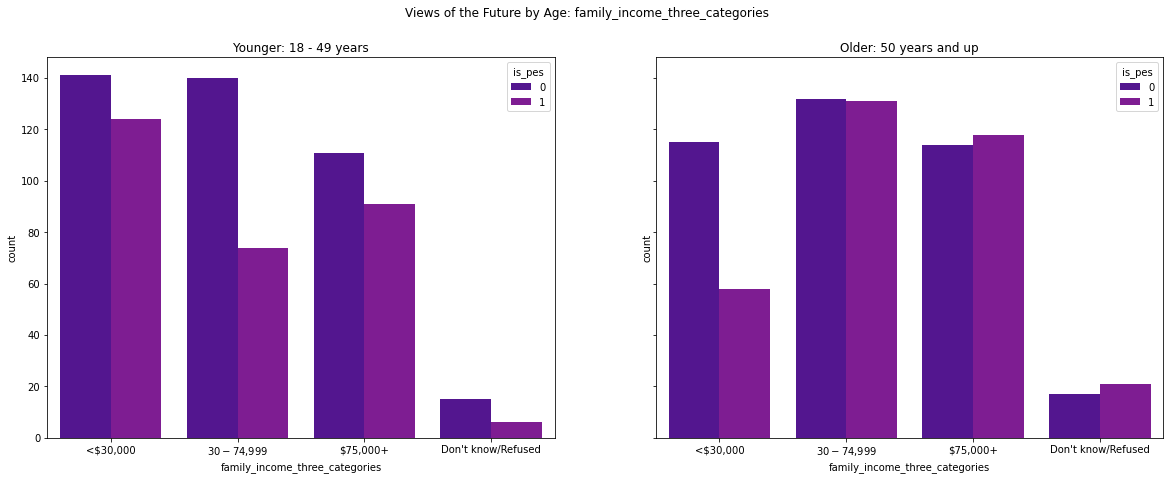

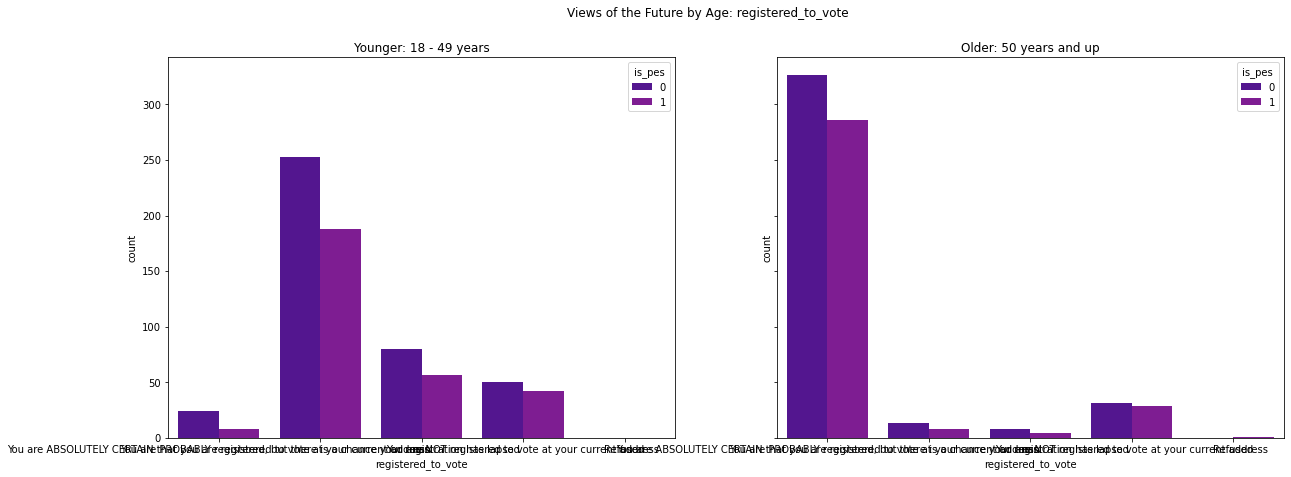

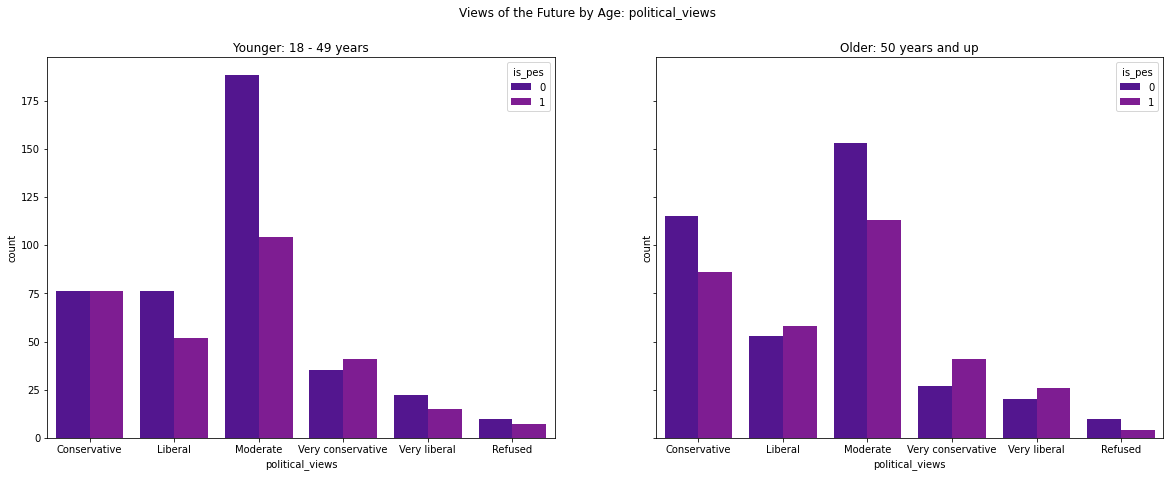

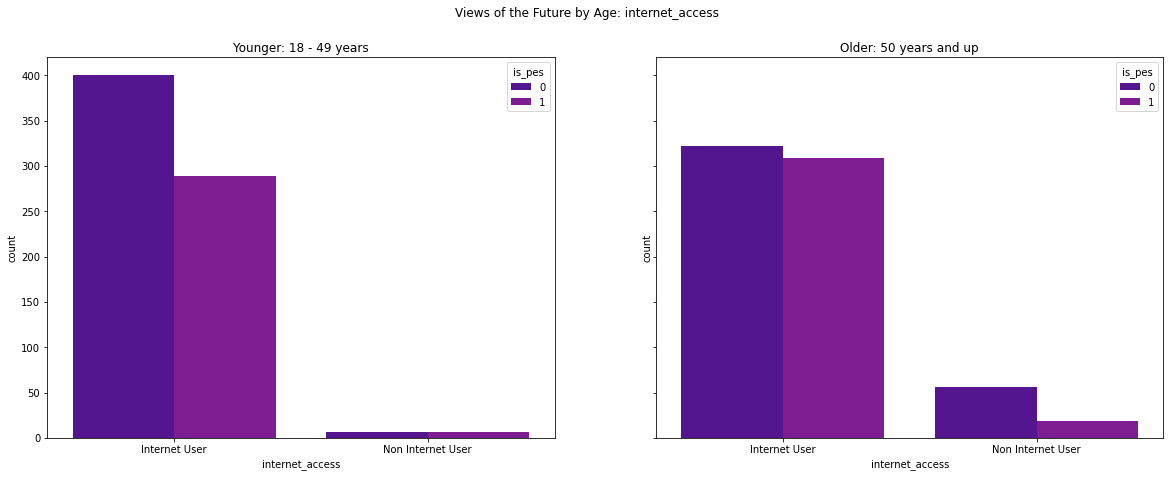

In [49]:
for col in cols:
    # Set number of subplots, format (1 row and 2 cols), share Y axis, set figure size of subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True,  figsize=(20,7))
    
    # Set suptitle
    fig.suptitle(f'Views of the Future by Age: {col}')
    
    # First plot and its title
    sns.countplot(data=train[~((train.age=='50-64') | (train.age=='65+'))], x=col, ax=axes[0], hue='is_pes')
    axes[0].set_title('Younger: 18 - 49 years')
    
    # Second plot and its title
    sns.countplot(data=train[(train.age=='50-64') | (train.age=='65+')], x=col, ax=axes[1], hue='is_pes')
    axes[1].set_title('Older: 50 years and up')
    
    plt.show()

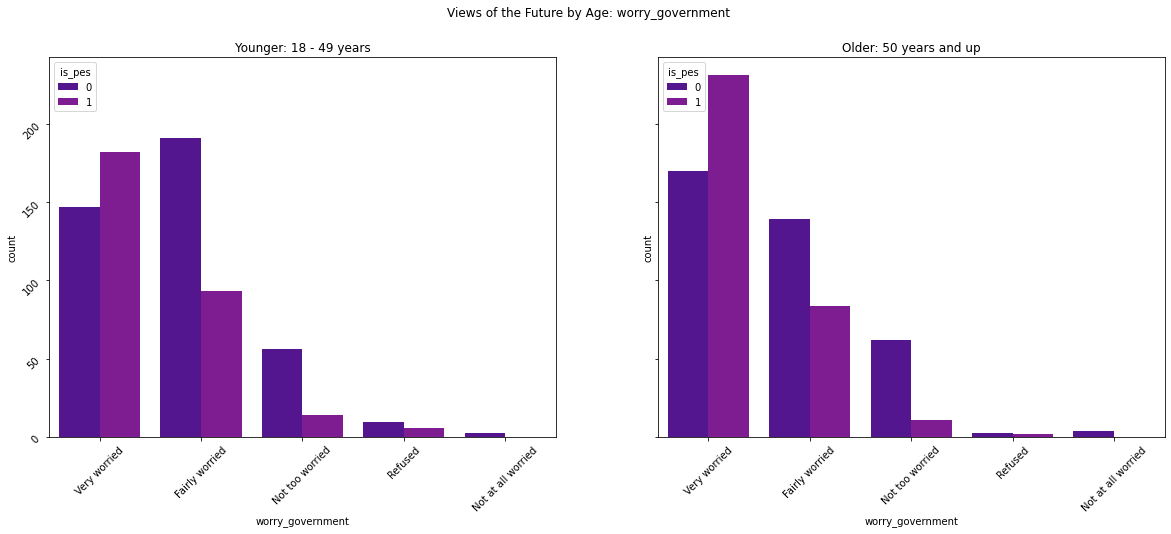

In [50]:
# Set number of subplots, format (1 row and 2 cols), share Y axis, set figure size of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True,  figsize=(20,7))

# Set suptitle
fig.suptitle(f'Views of the Future by Age: worry_government')
#plt.xticks(rotation=45)

# First plot and its title
sns.countplot(data=train[~((train.age=='50-64') | (train.age=='65+'))], x='worry_government', ax=axes[0], hue='is_pes')
axes[0].set_title('Younger: 18 - 49 years')
axes[0].tick_params(labelrotation=45)

# Second plot and its title
sns.countplot(data=train[(train.age=='50-64') | (train.age=='65+')], x='worry_government', ax=axes[1], hue='is_pes')
axes[1].set_title('Older: 50 years and up')
axes[1].tick_params(labelrotation=45)

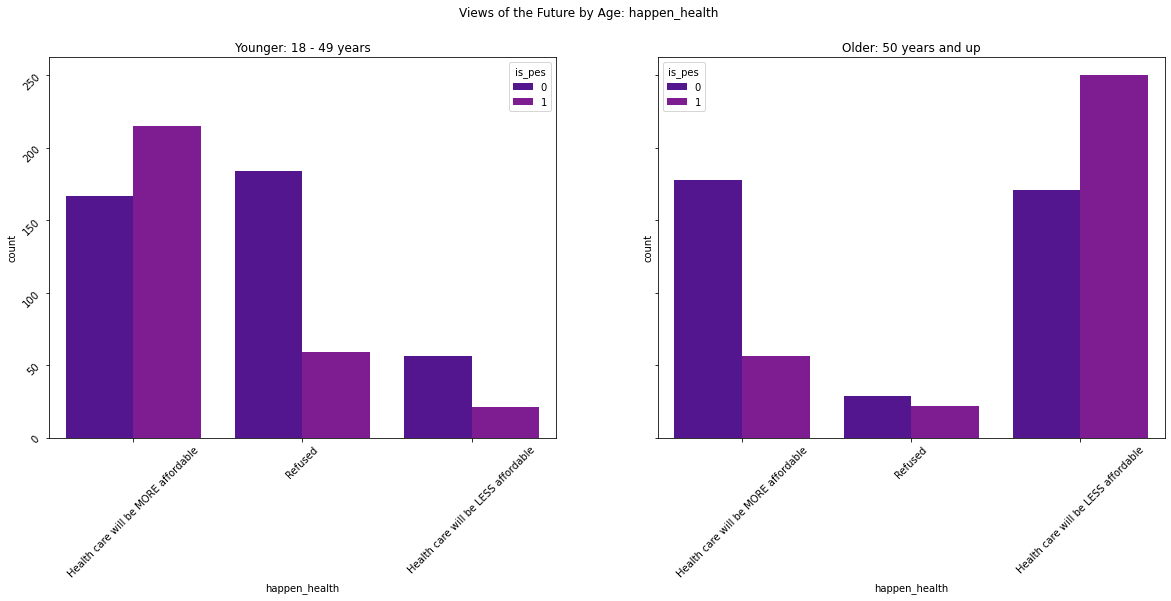

In [51]:
# Set number of subplots, format (1 row and 2 cols), share Y axis, set figure size of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True,  figsize=(20,7))

# Set suptitle
fig.suptitle(f'Views of the Future by Age: happen_health')
#plt.xticks(rotation=45)

# First plot and its title
sns.countplot(data=train[~((train.age=='50-64') | (train.age=='65+'))], x='happen_health', ax=axes[0], hue='is_pes')
axes[0].set_title('Younger: 18 - 49 years')
axes[0].tick_params(labelrotation=45)

# Second plot and its title
sns.countplot(data=train[(train.age=='50-64') | (train.age=='65+')], x='happen_health', ax=axes[1], hue='is_pes')
axes[1].set_title('Older: 50 years and up')
axes[1].tick_params(labelrotation=45)

In [52]:
robots = ['robot_replacement_means_better_jobs_for_humans', 'robot_replacement_increase_inequality', 
            'likelihood_my_job_replaced_by_robots', 'replacement_by_robots_good_or_bad', 'replacement_by_robots_likelihood']

In [53]:
jobs = ['most_responsible_for_workers_f1', 'job_benefits', 'job_security', 'robot_replacement_means_better_jobs_for_humans', 'robot_replacement_increase_inequality', 'likelihood_my_job_replaced_by_robots', 'replacement_by_robots_good_or_bad', 'replacement_by_robots_likelihood']

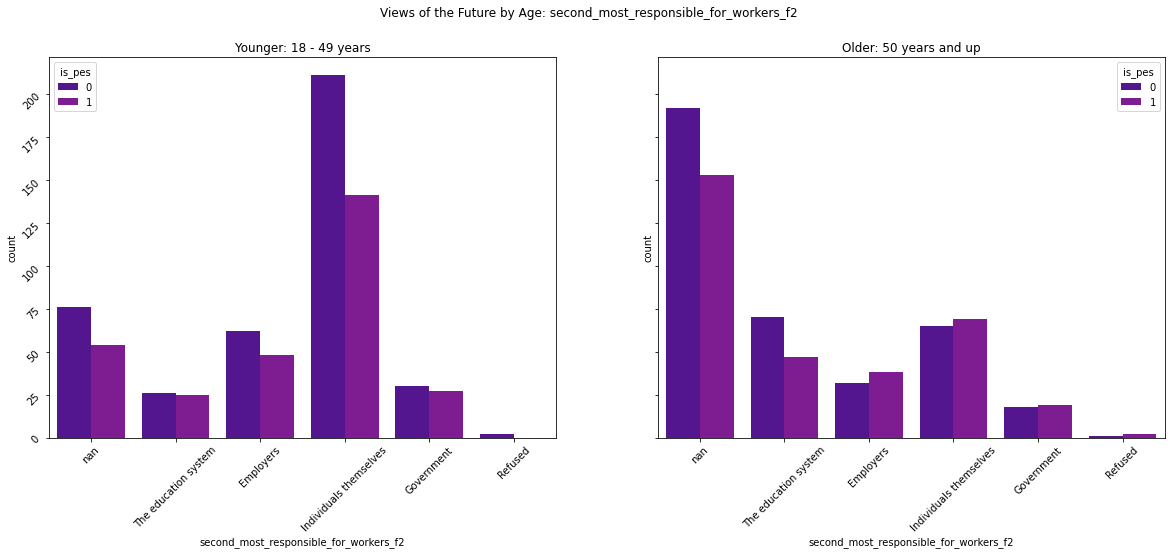

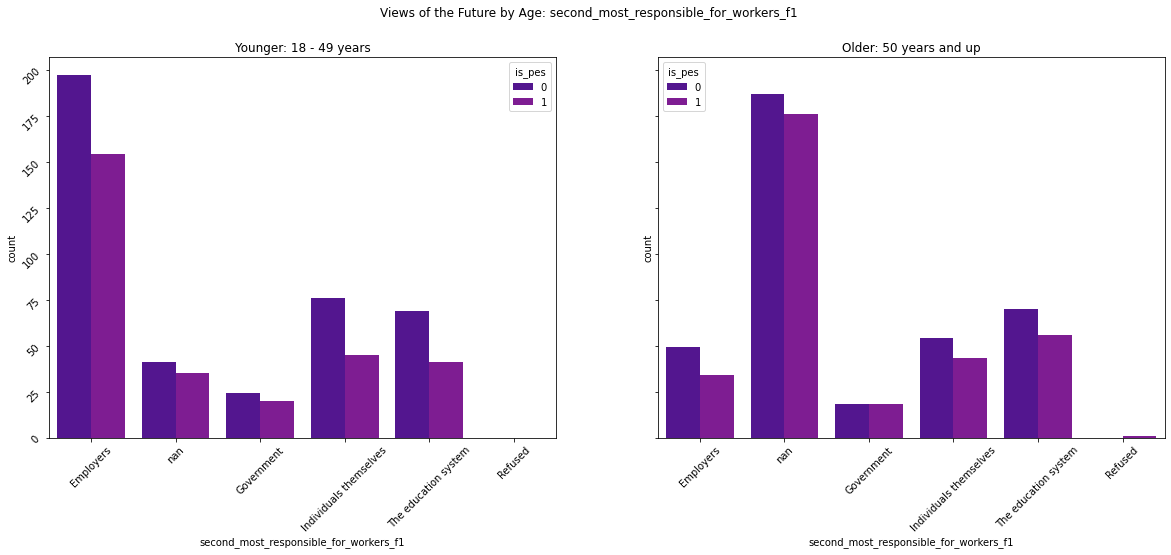

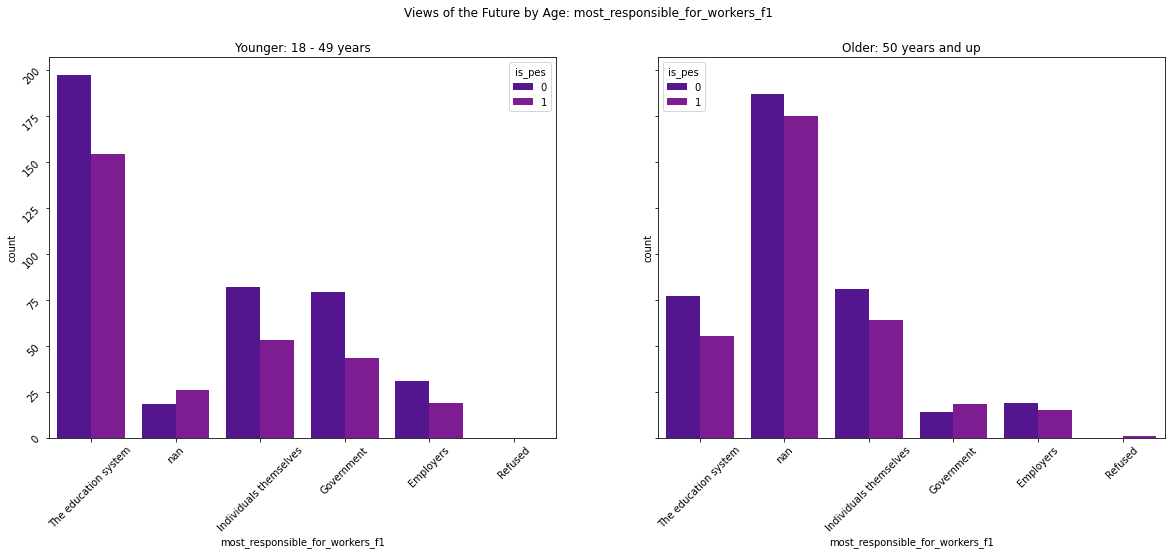

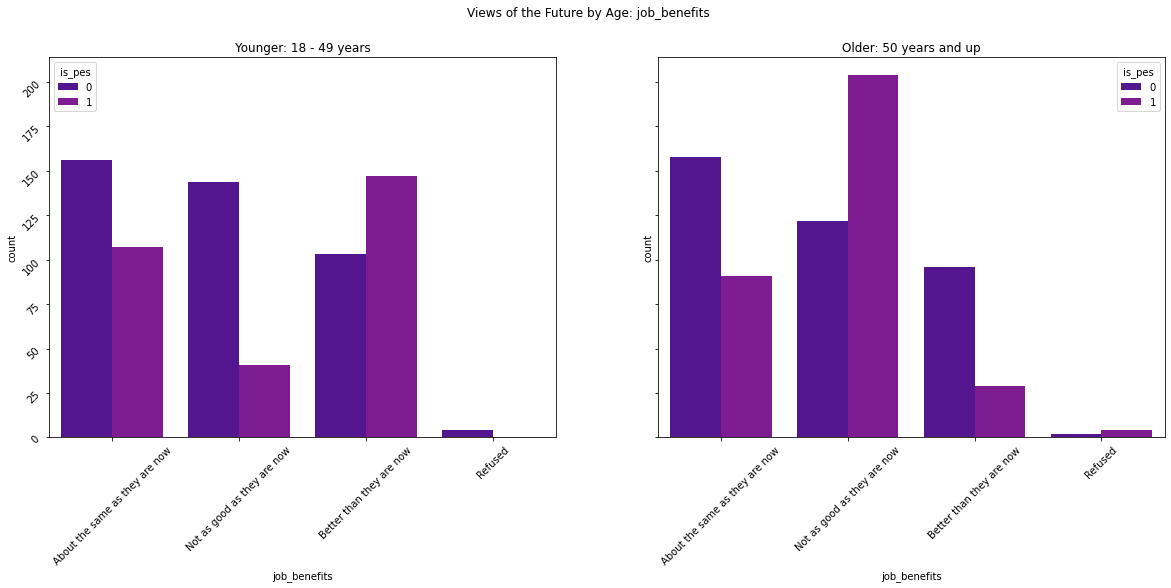

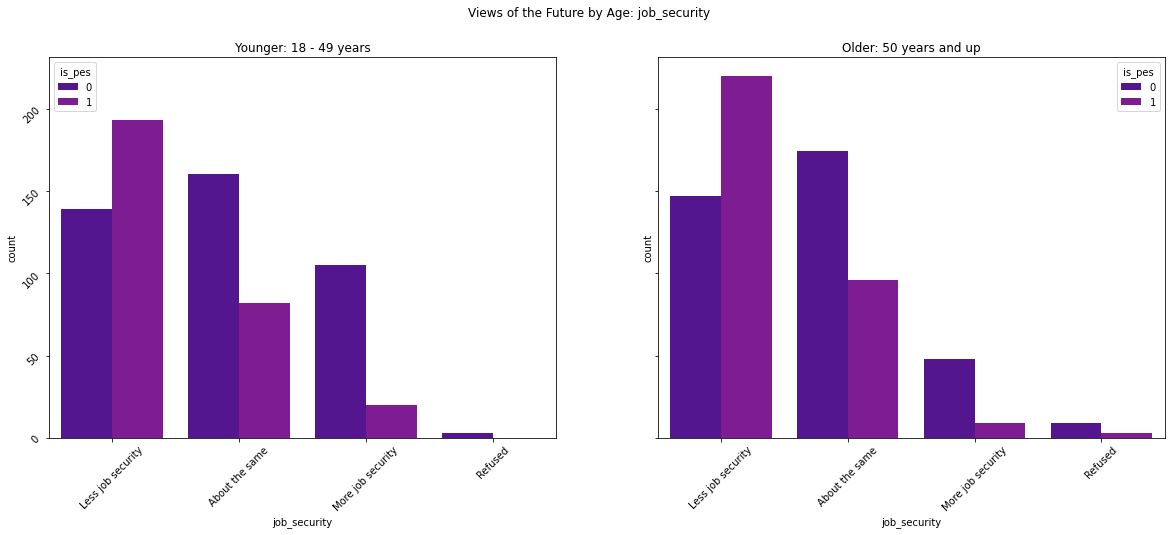

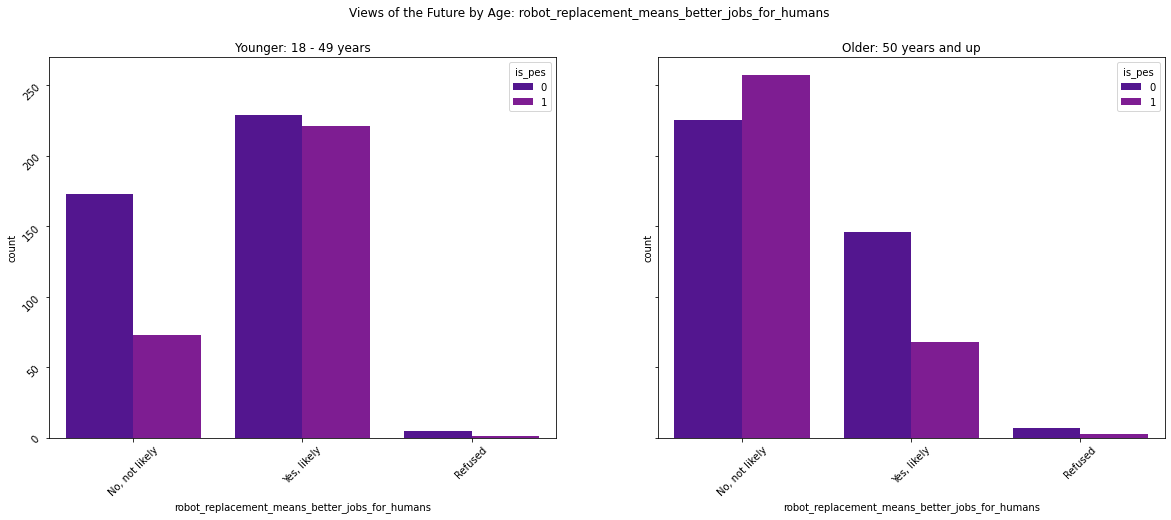

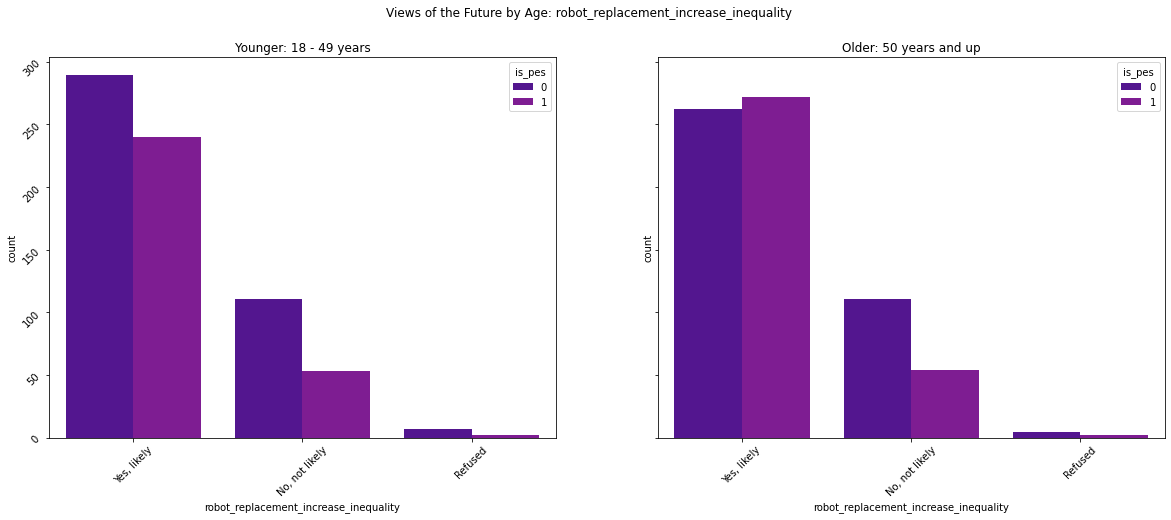

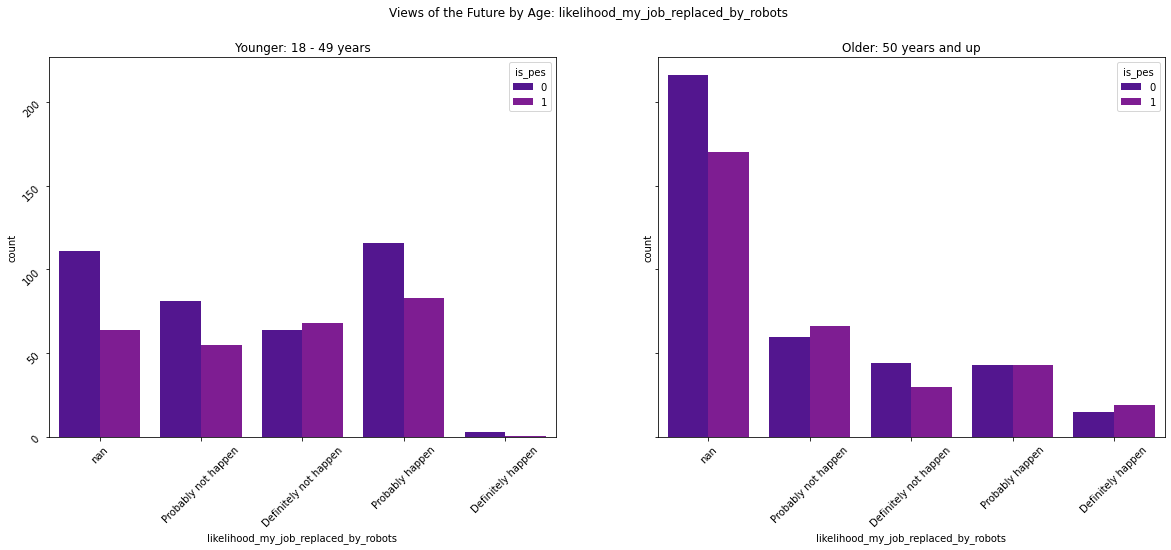

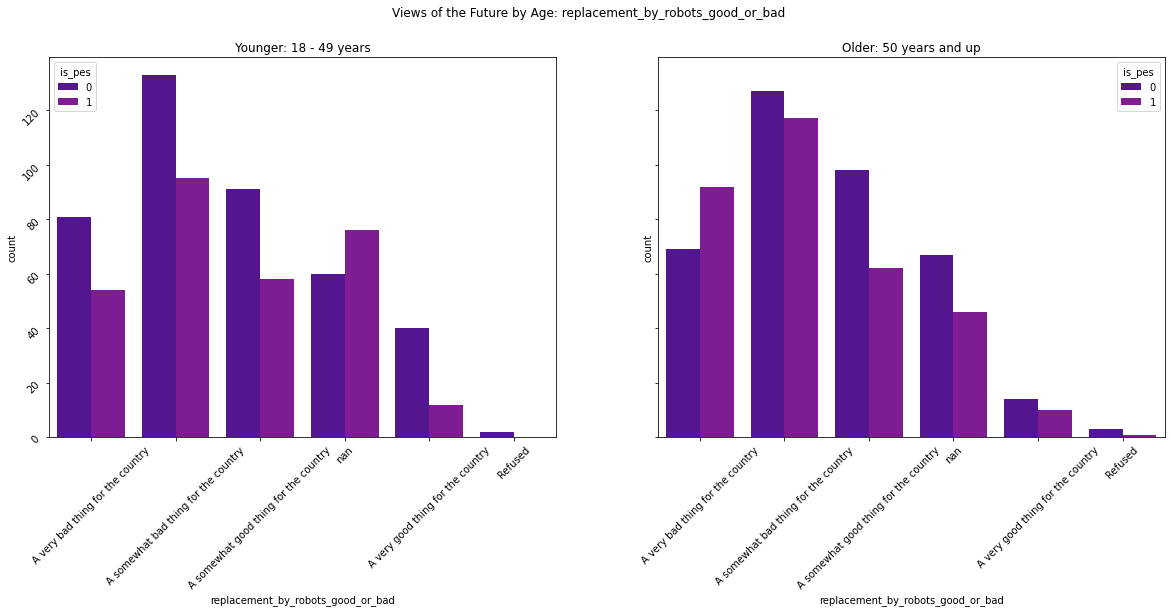

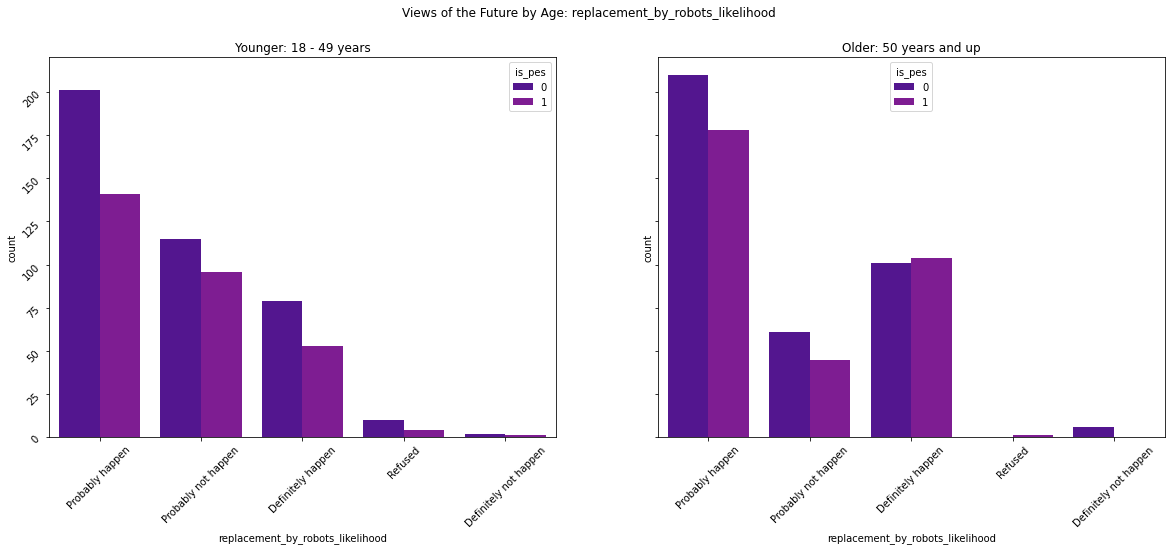

In [54]:
jobs = ['second_most_responsible_for_workers_f2', 'second_most_responsible_for_workers_f1', 'most_responsible_for_workers_f1', 
        'job_benefits', 'job_security', 'robot_replacement_means_better_jobs_for_humans', 'robot_replacement_increase_inequality', 
        'likelihood_my_job_replaced_by_robots', 'replacement_by_robots_good_or_bad', 'replacement_by_robots_likelihood']
for col in jobs:
# Set number of subplots, format (1 row and 2 cols), share Y axis, set figure size of subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True,  figsize=(20,7))

    # Set suptitle
    fig.suptitle(f'Views of the Future by Age: {col}')
    #plt.xticks(rotation=45)

    # First plot and its title
    sns.countplot(data=train[~((train.age=='50-64') | (train.age=='65+'))], x= col, ax=axes[0], hue='is_pes')
    axes[0].set_title('Younger: 18 - 49 years')
    axes[0].tick_params(labelrotation=45)

    # Second plot and its title
    sns.countplot(data=train[(train.age=='50-64') | (train.age=='65+')], x= col, ax=axes[1], hue='is_pes')
    axes[1].set_title('Older: 50 years and up')
    axes[1].tick_params(labelrotation=45)

In [55]:
train['most_responsible_for_workers'] = train['job_skills_f2'].replace('nan', '')  + train['most_responsible_for_workers_f1'].replace('nan', '')

In [56]:
train.most_responsible_for_workers = train.most_responsible_for_workers.replace('', 'nan')

In [57]:
train['second_most_responsible_for_workers'] = train['second_most_responsible_for_workers_f1'].replace('nan', '')  + train['second_most_responsible_for_workers_f2'].replace('nan', '')

In [58]:
train.second_most_responsible_for_workers = train.second_most_responsible_for_workers.replace('', 'nan')

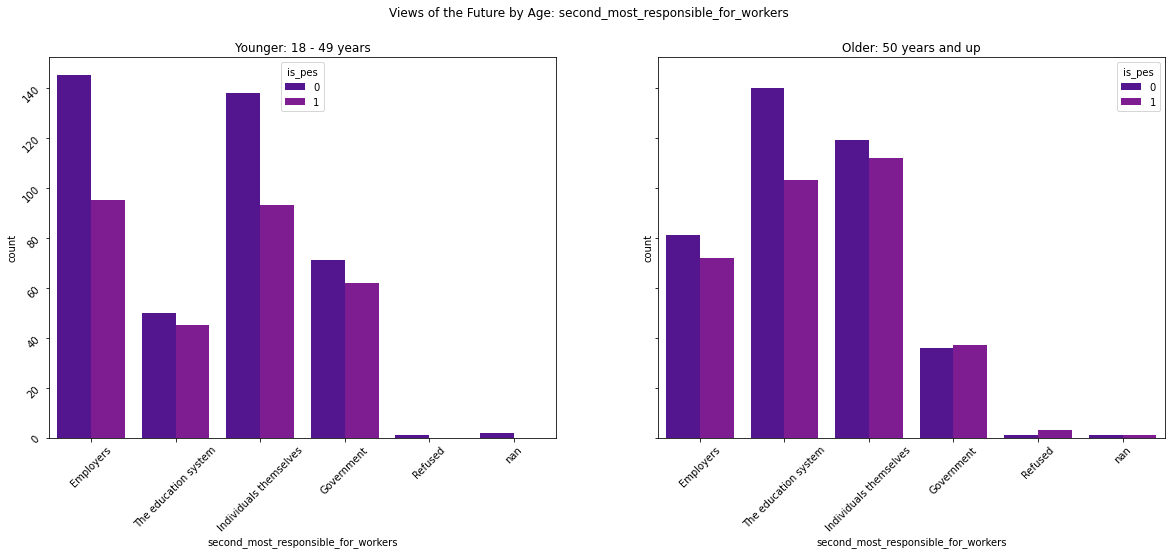

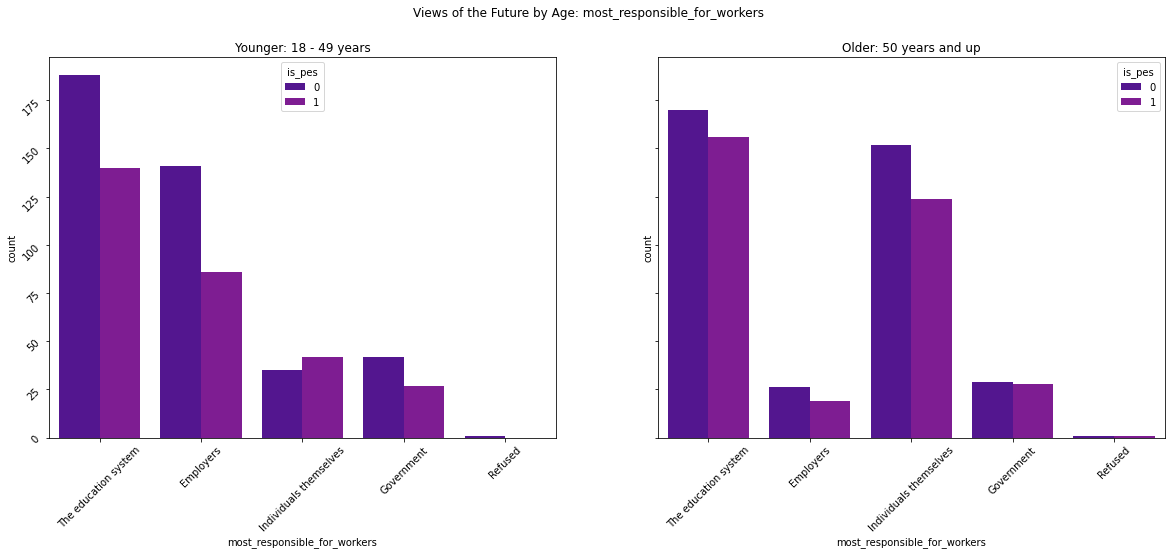

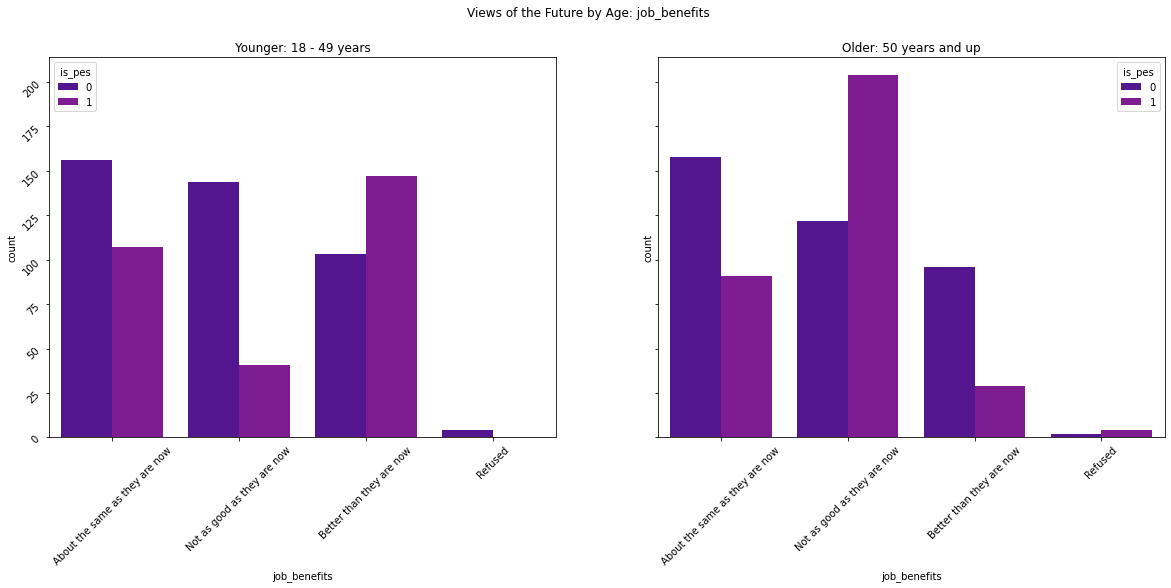

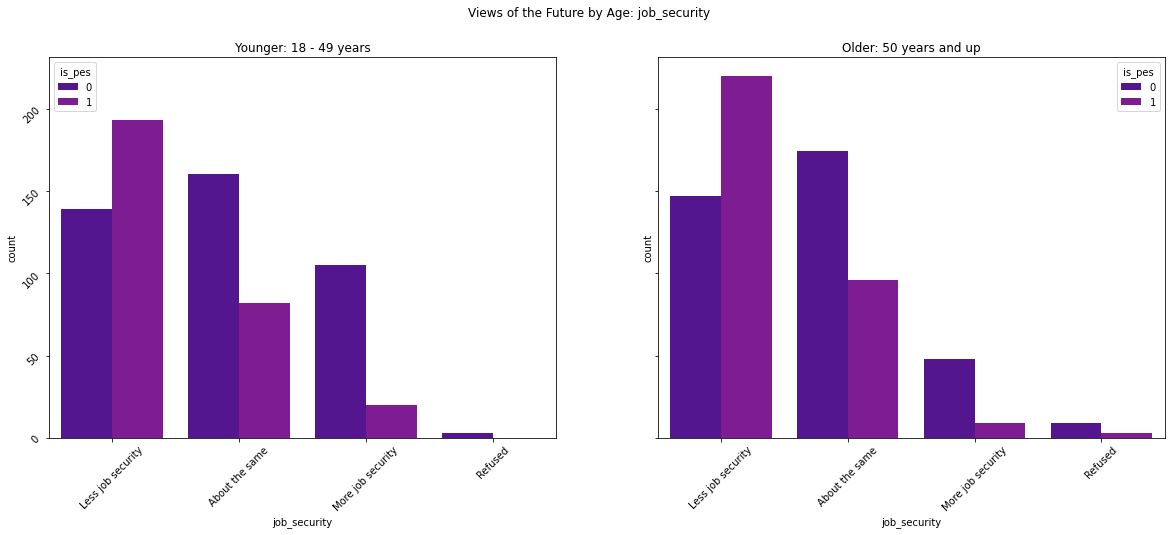

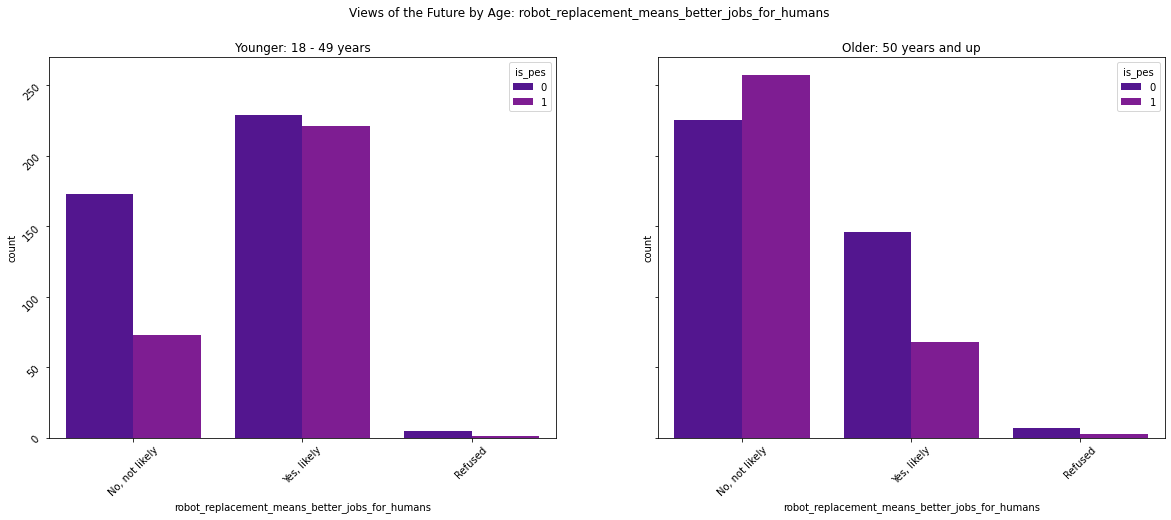

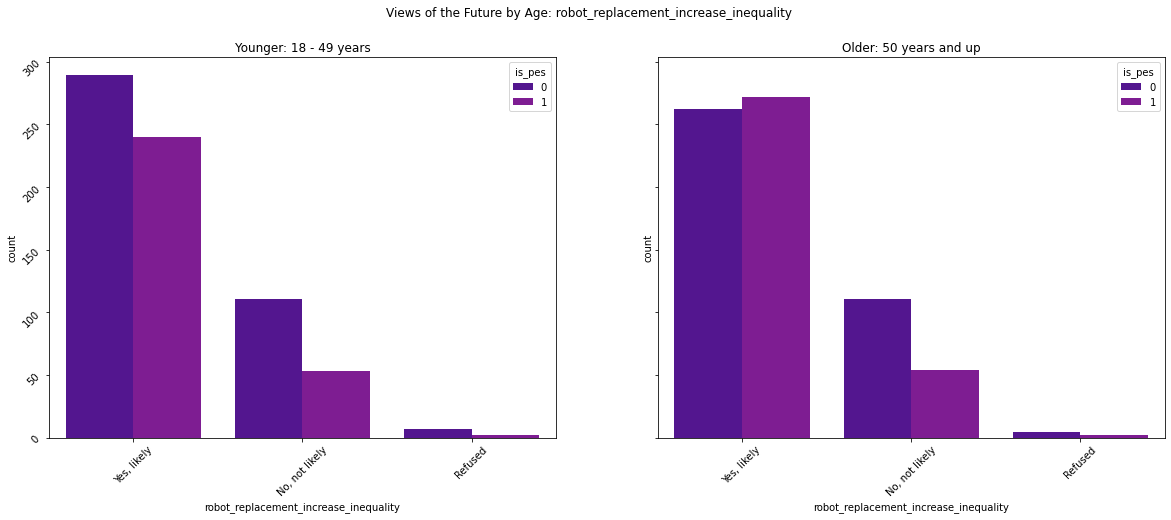

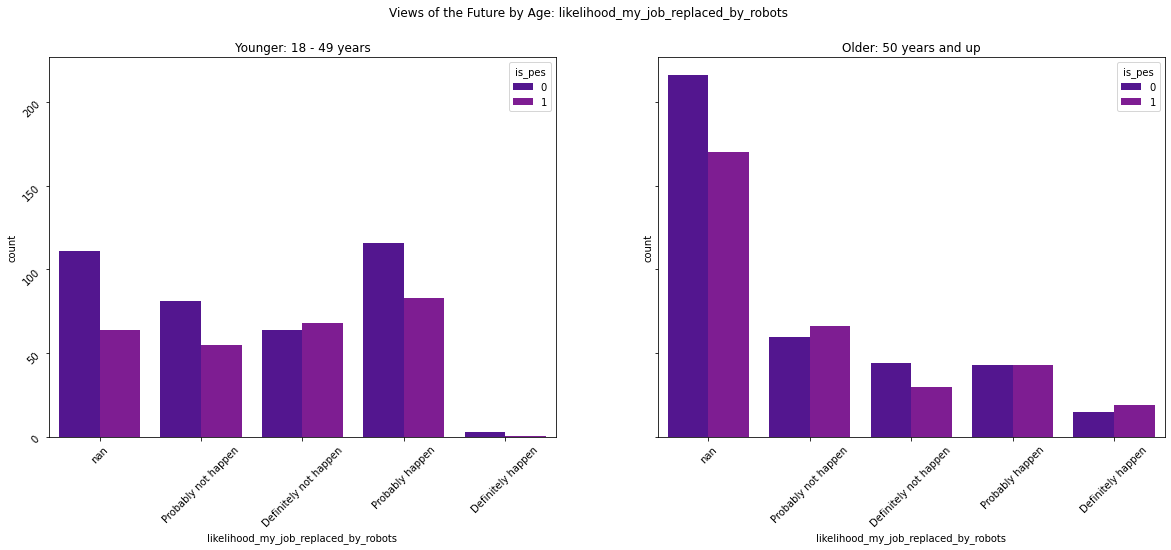

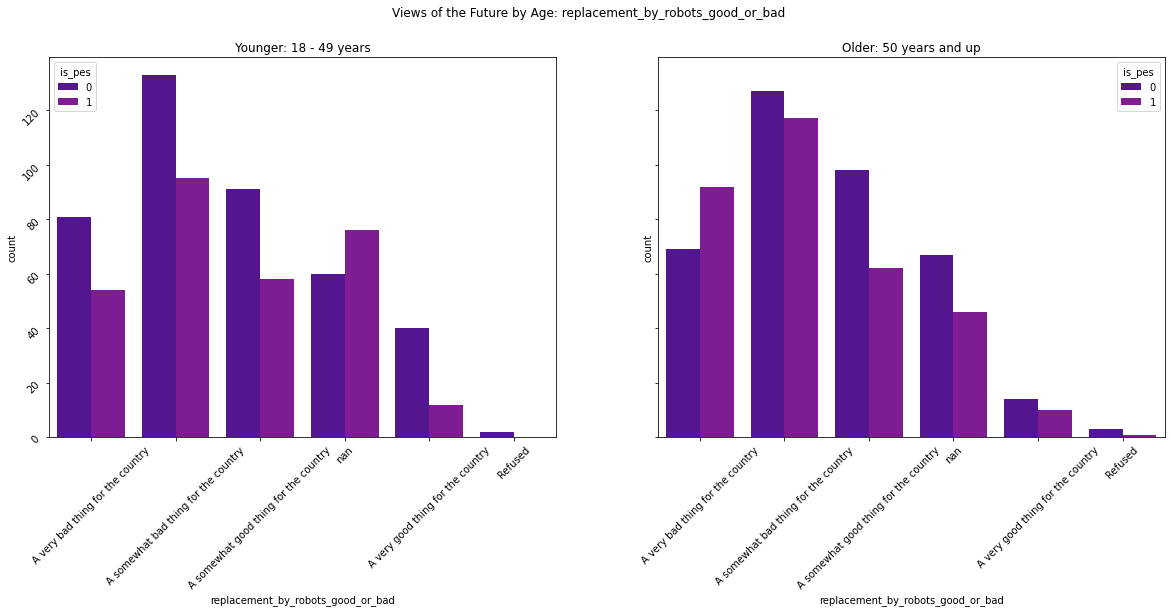

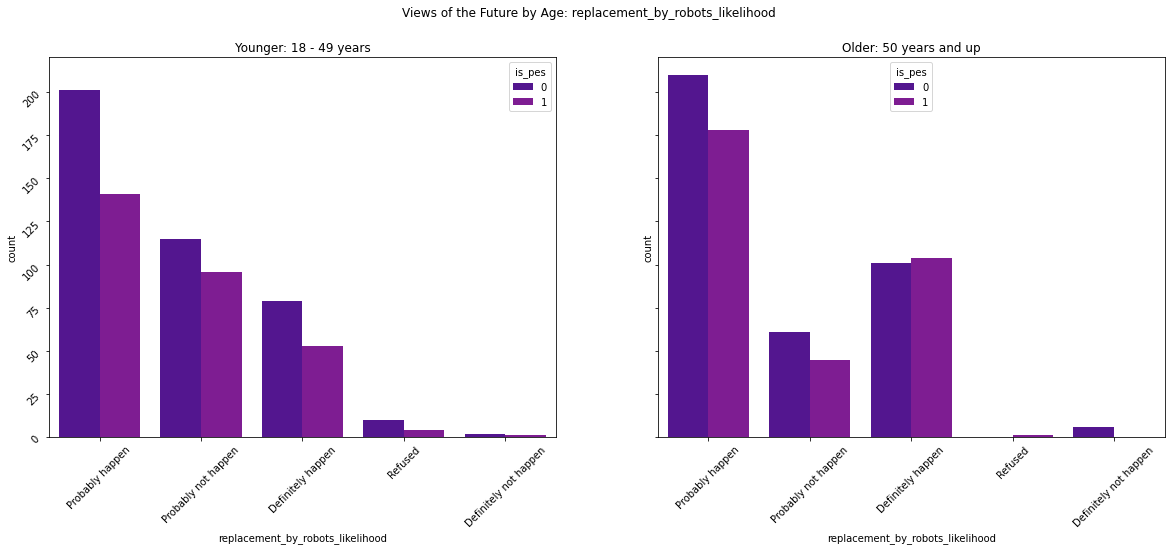

In [59]:
jobs = ['second_most_responsible_for_workers', 'most_responsible_for_workers', 
        'job_benefits', 'job_security', 'robot_replacement_means_better_jobs_for_humans', 'robot_replacement_increase_inequality', 
        'likelihood_my_job_replaced_by_robots', 'replacement_by_robots_good_or_bad', 'replacement_by_robots_likelihood']
for col in jobs:
# Set number of subplots, format (1 row and 2 cols), share Y axis, set figure size of subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True,  figsize=(20,7))

    # Set suptitle
    fig.suptitle(f'Views of the Future by Age: {col}')
    #plt.xticks(rotation=45)

    # First plot and its title
    sns.countplot(data=train[~((train.age=='50-64') | (train.age=='65+'))], x= col, ax=axes[0], hue='is_pes')
    axes[0].set_title('Younger: 18 - 49 years')
    axes[0].tick_params(labelrotation=45)

    # Second plot and its title
    sns.countplot(data=train[(train.age=='50-64') | (train.age=='65+')], x= col, ax=axes[1], hue='is_pes')
    axes[1].set_title('Older: 50 years and up')
    axes[1].tick_params(labelrotation=45)

In [60]:
train.attitude.unique()

array(['Somewhat optimistic', 'Somewhat pessimistic', 'Very optimistic',
       'Very pessimistic'], dtype=object)

In [61]:
train[train.attitude=='Somewhat optimistic']

qkey   device_type language    form             attitude  \
1859  201801113305  Mobile phone  English  Form 1  Somewhat optimistic   
420         668019       Desktop  English  Form 2  Somewhat optimistic   
1424  201801054651  Mobile phone  English  Form 2  Somewhat optimistic   
1287  201801032119  Mobile phone  Spanish  Form 2  Somewhat optimistic   
1893  201801117121  Mobile phone  English  Form 2  Somewhat optimistic   
...            ...           ...      ...     ...                  ...   
1750  201801098667       Desktop  English  Form 1  Somewhat optimistic   
957   201701615366       Desktop  English  Form 1  Somewhat optimistic   
239         333639  Mobile phone  English  Form 1  Somewhat optimistic   
1795  201801105856  Mobile phone  English  Form 2  Somewhat optimistic   
1297  201801034069  Mobile phone  English  Form 2  Somewhat optimistic   

               avg_family                     happen_general  \
1859  Stay about the same    The U.S. economy will be WEAKER   
420             Get worse    The U.S. economy will be WEAKER   
1424            Get worse    The U.S. economy will be WEAKER   
1287  Stay about the same    The U.S. economy will be WEAKER   
1893  Stay about the same  The U.S. economy will be STRONGER   
...                   ...                                ...   
1750  Stay about the same  The U.S. economy will be STRONGER   
957            Get better    The U.S. economy will be WEAKER   
239   Stay about the same    The U.S. economy will be WEAKER   
1795           Get better  The U.S. economy will be STRONGER   
1297           Get better  The U.S. economy will be STRONGER   

                            happen_health                    happen_race  \
1859  Health care will be MORE affordable    Race relations will IMPROVE   
420   Health care will be LESS affordable  Race relations will GET WORSE   
1424  Health care will be MORE affordable  Race relations will GET WORSE   
1287  Health care will be LESS affordable  Race relations will GET WORSE   
1893  Health care will be MORE affordable    Race relations will IMPROVE   
...                                   ...                            ...   
1750  Health care will be MORE affordable    Race relations will IMPROVE   
957   Health care will be MORE affordable    Race relations will IMPROVE   
239   Health care will be LESS affordable  Race relations will GET WORSE   
1795  Health care will be LESS affordable                        Refused   
1297  Health care will be LESS affordable    Race relations will IMPROVE   

                                        happen_usa  ... political_views  \
1859  The U.S. will be LESS important in the world  ...    Conservative   
420   The U.S. will be LESS important in the world  ...         Liberal   
1424  The U.S. will be LESS important in the world  ...         Liberal   
1287  The U.S. will be MORE important in the world  ...         Liberal   
1893  The U.S. will be MORE important in the world  ...    Conservative   
...                                            ...  ...             ...   
1750  The U.S. will be MORE important in the world  ...    Conservative   
957   The U.S. will be MORE important in the world  ...        Moderate   
239   The U.S. will be MORE important in the world  ...    Conservative   
1795                                       Refused  ...    Conservative   
1297  The U.S. will be LESS important in the world  ...        Moderate   

     internet_access volunteer    weight is_pes pes_val is_very_pes  \
1859   Internet User       Yes  3.057078      0       1           0   
420    Internet User        No  2.413983      0       1           0   
1424   Internet User        No  0.362586      0       1           0   
1287   Internet User        No  1.623640      0       1           0   
1893   Internet User       Yes  0.210927      0       1           0   
...              ...       ...       ...    ...     ...         ...   
1750   Internet User        No  1.475355     

In [62]:
train.age.value_counts()

30-49     479
50-64     412
65+       294
18-29     220
DK/REF      3
Name: age, dtype: int64

In [63]:
income = ['family_income_three_categories', 'family_income_nine_categories', 'happen_wealthgap', 
         'share_americans_in_upper_class', 'share_americans_in_middle_class', 'share_americans_in_lower_class']

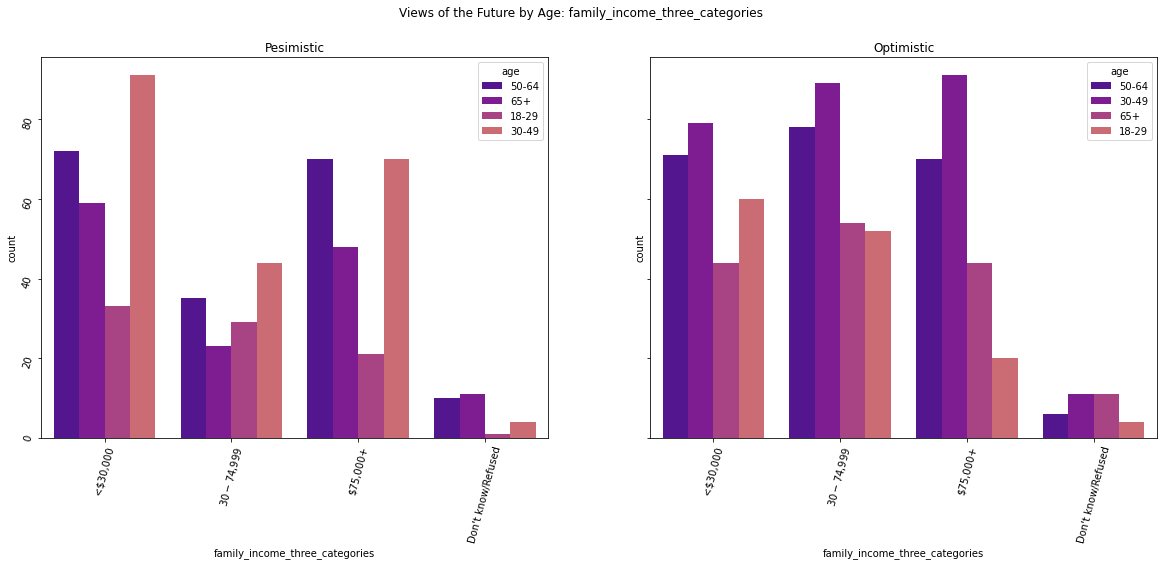

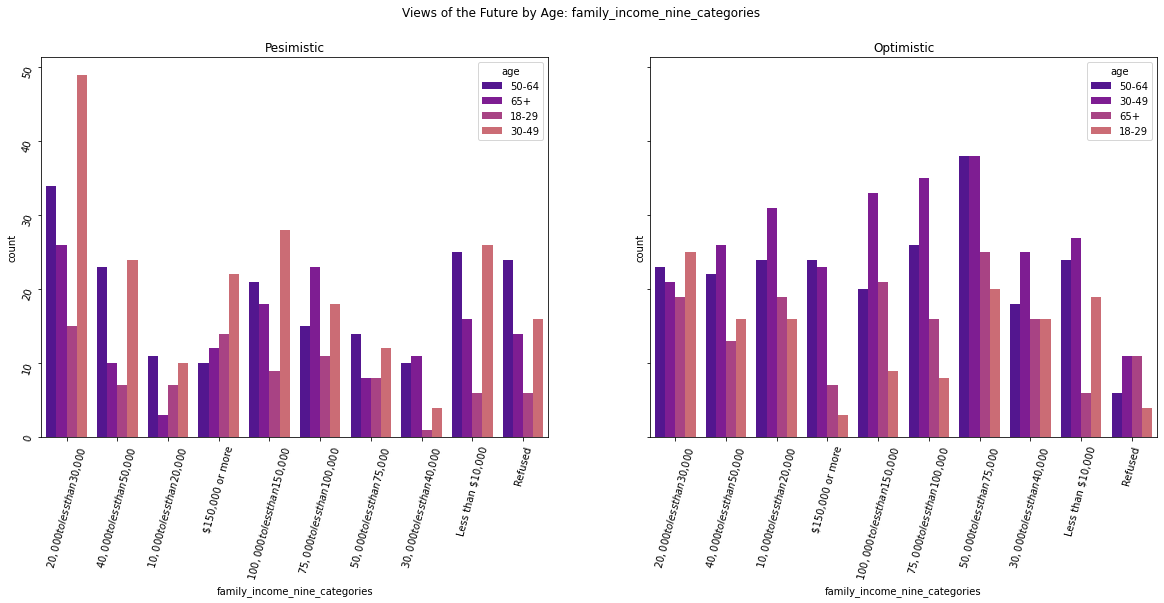

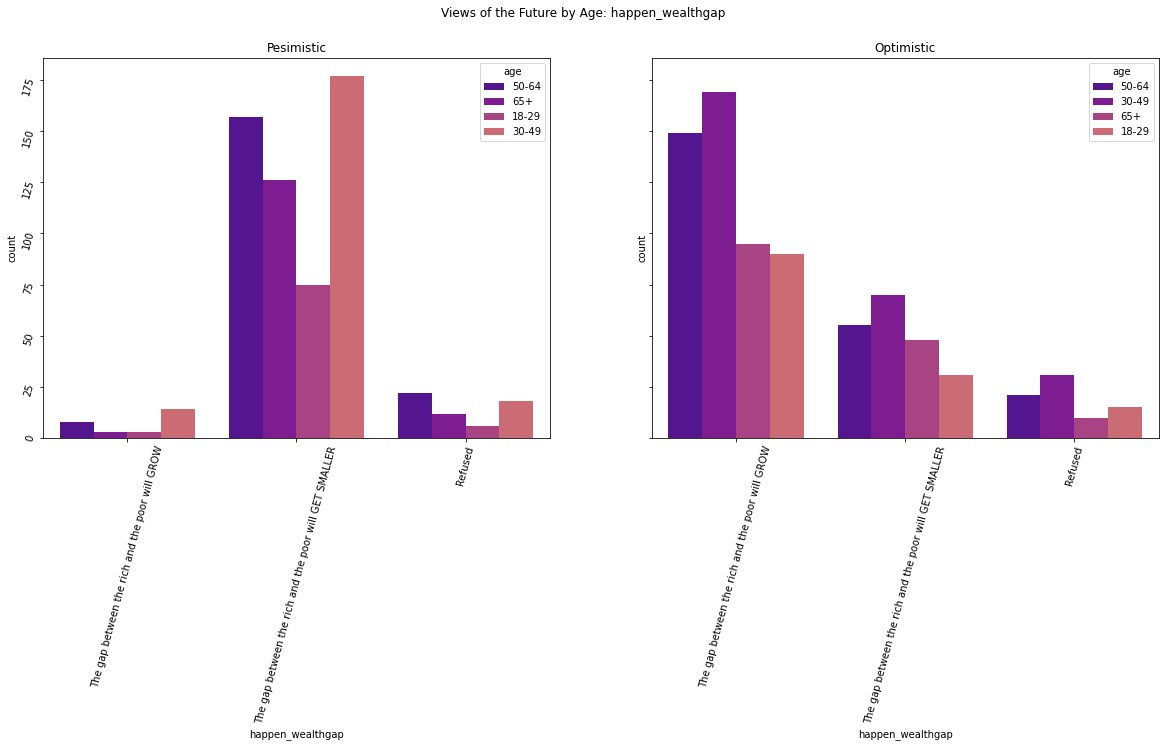

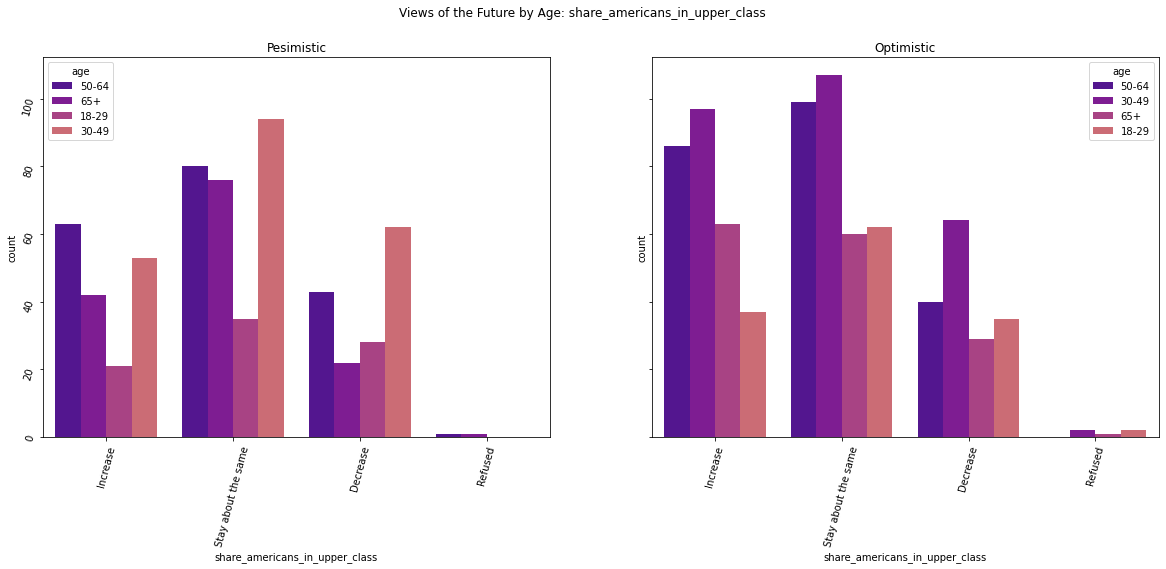

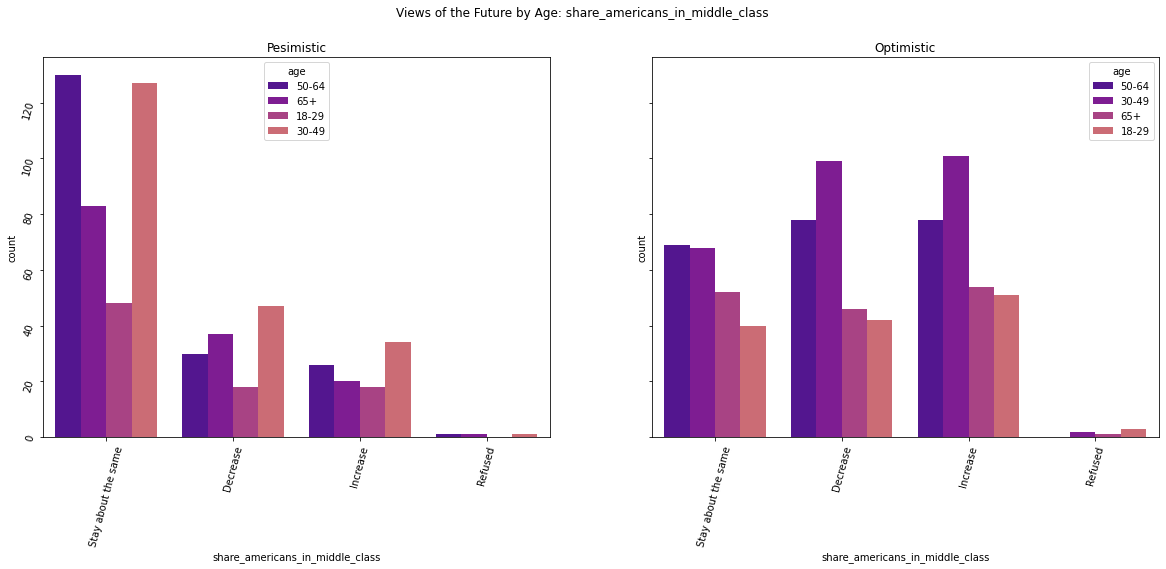

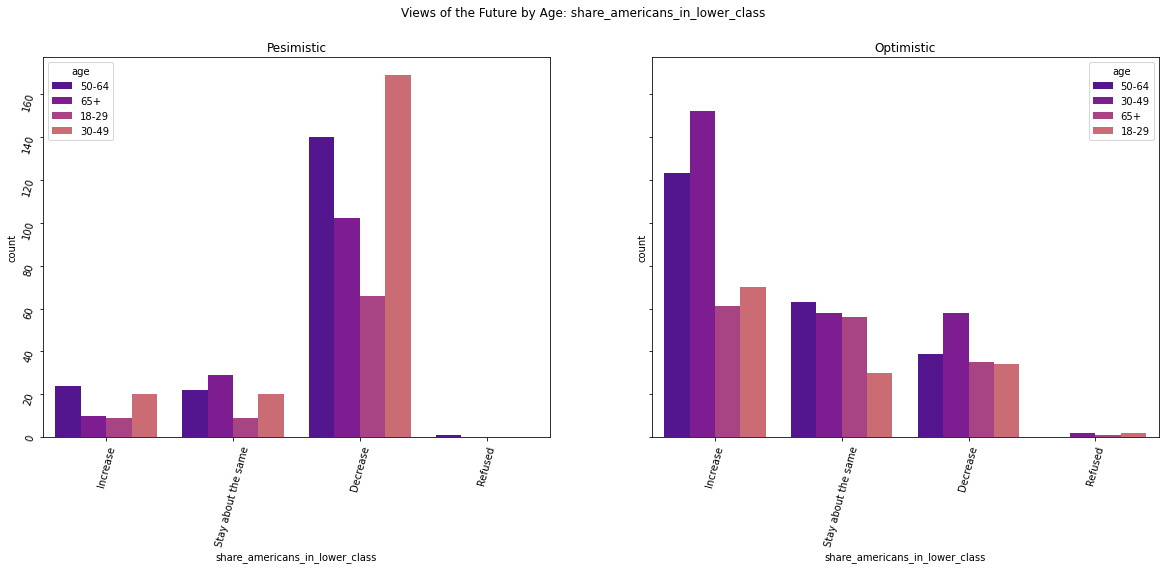

In [65]:
for col in income:
# Set number of subplots, format (1 row and 2 cols), share Y axis, set figure size of subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True,  figsize=(20,7))

    # Set suptitle
    fig.suptitle(f'Views of the Future by Age: {col}')
    #plt.xticks(rotation=45)

    # First plot and its title
    sns.countplot(data=train[(train.is_pes==1) & (train.age!='DK/REF')], x= col, ax=axes[0], hue='age')
    axes[0].set_title('Pesimistic')
    axes[0].tick_params(labelrotation=75)

    # Second plot and its title
    sns.countplot(data=train[(train.is_pes==0) & (train.age!='DK/REF')], x= col, ax=axes[1], hue='age')
    axes[1].set_title('Optimistic')
    axes[1].tick_params(labelrotation=75)

---
---
---
---

# Split

In [66]:
X_train = train.drop(columns=['attitude', 'avg_family', 'is_pes','pes_val', 'is_very_pes', 'is_very_opt', 'second_most_responsible_for_workers', 'most_responsible_for_workers']).replace(replace_key) 
y_train = train.replace(replace_key).is_pes  

In [67]:
X_validate = validate.drop(columns=['attitude', 'avg_family', 'is_pes','pes_val', 'is_very_pes', 'is_very_opt']).replace(replace_key) 
y_validate = validate.replace(replace_key).is_pes

In [68]:
X_test = test.drop(columns=['attitude', 'avg_family', 'is_pes','pes_val', 'is_very_pes', 'is_very_opt']).replace(replace_key) 
y_test = test.replace(replace_key).is_pes

In [69]:
X_train

qkey  device_type  language  form  happen_general  \
1859  201801113305            0         0     0               1   
96          191336            1         0     1               1   
420         668019            1         0     1               1   
1424  201801054651            0         0     1               1   
114         200943            1         0     1               1   
...            ...          ...       ...   ...             ...   
678   201501605240            2         0     1               1   
957   201701615366            1         0     0               1   
239         333639            0         0     0               1   
1795  201801105856            0         0     1               0   
1297  201801034069            0         0     1               0   

      happen_health  happen_race  happen_usa  happen_wealthgap  happen_pub_ed  \
1859              0            0           1                 0              0   
96                2            2           1                 1              2   
420               1            1           1                 0              0   
1424              0            1           1                 0              1   
114               1            0           1                 0              0   
...             ...          ...         ...               ...            ...   
678               0            0           1                 0              0   
957               0            0           0                 0              0   
239               1            1           0                 0              0   
1795              1            2           2                 0              0   
1297              1            0           1                 2              0   

      ...  political_party_identity  political_party_lean  \
1859  ...                         2                     3   
96    ...                         0                     0   
420   ...                         2                     3   
1424  ...                         0                     0   
114   ...                         2                     3   
...   ...                       ...                   ...   
678   ...                         2                     2   
957   ...                         2                     2   
239   ...                         2                     2   
1795  ...                         2                     2   
1297  ...                         2                     3   

      summary_of_political_party_data  family_income_nine_categories  \
1859                                0                              4   
96                                  0                              8   
420                                 0                              1   
1424                                0                              2   
114                                 0                              8   
...                               ...                            ...   
678                                 1                              0   
957                                 1                              0   
239                                 1                              5   
1795                                1                              1   
1297                                0                              1   

      family_income_three_categories  registered_to_vote  political_views  \
1859                               2                   0                1   
96                                 1                   3                0   
420                                1                   2                0   
1424                               2                   0                0   
114                                1                   0                2   
...                              ...                 ...              ...   
678                                0                   0                2   
957                   

In [70]:
import sklearn.metrics as m
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


tree = DecisionTreeClassifier(max_depth=2)

cross_val_score(tree, X_train, y_train, cv=5)

array([0.75886525, 0.71985816, 0.66312057, 0.76156584, 0.71530249])

In [71]:
cross_val_score(tree, X_train, y_train, cv=3, scoring='precision')

array([0.70093458, 0.69863014, 0.70103093])

In [72]:
params = {'n_neighbors': [3, 5, 6, 7, 8, 10, 15],
          'leaf_size': [None, 7, 9, 11, 13, 15],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, params, cv=5)

grid.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 456, in _fit
    self._tree = KDTree(X, self.leaf_size,
  File "sklearn/neighbors/_binary_tree.pxi", line 1053, in sklearn.neighbors._kd_tree.BinaryTree.__init__
TypeError: '<' not supported between instances of 'NoneType' and 'int'

  warnings.warn("Estimator fit failed. The score on this train-test"
/usr/local/anaconda3/lib/python3.8/site-pack

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [None, 7, 9, 11, 13, 15],
                         'n_neighbors': [3, 5, 6, 7, 8, 10, 15]})

In [73]:
results = grid.cv_results_
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_algorithm', 'param_leaf_size', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [74]:
test_scores = results['mean_test_score']

params = results['params']

for p, s in zip(params, test_scores):
    p['score'] = s

score_df = pd.DataFrame(params).sort_values(by='score')

In [75]:
# score_df[(score_df.score.isnull()==False) & (score_df.score!=1)].tail(15)
score_df[score_df.score.isnull()==False]

algorithm  leaf_size  n_neighbors     score
140     brute        9.0            3  0.510671
126     brute        NaN            3  0.510671
161     brute       15.0            3  0.510671
154     brute       13.0            3  0.510671
133     brute        7.0            3  0.510671
..        ...        ...          ...       ...
130     brute        NaN            8  0.552558
144     brute        9.0            8  0.552558
137     brute        7.0            8  0.552558
158     brute       13.0            8  0.552558
151     brute       11.0            8  0.552558

[147 rows x 4 columns]

In [76]:
params = {'n_neighbors': [3, 5, 6, 7, 8, 10, 15],
          'leaf_size': [None, 7, 9, 11, 13, 15],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, params, cv=5)

grid.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 456, in _fit
    self._tree = KDTree(X, self.leaf_size,
  File "sklearn/neighbors/_binary_tree.pxi", line 1053, in sklearn.neighbors._kd_tree.BinaryTree.__init__
TypeError: '<' not supported between instances of 'NoneType' and 'int'

  warnings.warn("Estimator fit failed. The score on this train-test"
/usr/local/anaconda3/lib/python3.8/site-pack

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [None, 7, 9, 11, 13, 15],
                         'n_neighbors': [3, 5, 6, 7, 8, 10, 15]})

In [78]:
results = grid.cv_results_
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_algorithm', 'param_leaf_size', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [79]:
test_scores = results['mean_test_score']

params = results['params']

for p, s in zip(params, test_scores):
    p['score'] = s

score_df = pd.DataFrame(params).sort_values(by='score')

In [80]:
score_df[(score_df.score.isnull()==False) & (score_df.score!=1)].tail(15)

algorithm  leaf_size  n_neighbors     score
32        auto       13.0            8  0.544037
39        auto       15.0            8  0.544037
102    kd_tree        9.0            8  0.544037
53   ball_tree        7.0            8  0.544037
109    kd_tree       11.0            8  0.544037
116    kd_tree       13.0            8  0.544037
123    kd_tree       15.0            8  0.544037
18        auto        9.0            8  0.544037
60   ball_tree        9.0            8  0.544037
165      brute       15.0            8  0.552558
130      brute        NaN            8  0.552558
144      brute        9.0            8  0.552558
137      brute        7.0            8  0.552558
158      brute       13.0            8  0.552558
151      brute       11.0            8  0.552558

In [81]:
params = {'n_estimators': [50, 100, 150],
          'max_depth': [5, 6, 7, 8, 10],
          'max_features': [7, 9, 11, 13, 15, 20, 30]}

forest = RandomForestClassifier()

grid = GridSearchCV(forest, params, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 6, 7, 8, 10],
                         'max_features': [7, 9, 11, 13, 15, 20, 30],
                         'n_estimators': [50, 100, 150]})

In [82]:
results = grid.cv_results_
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [83]:
test_scores = results['mean_test_score']

params = results['params']

for p, s in zip(params, test_scores):
    p['score'] = s

score_df = pd.DataFrame(params).sort_values(by='score')

In [84]:
score_df[(score_df.score.isnull()==False)].tail(15)

max_depth  max_features  n_estimators     score
100         10            20           100  0.765647
47           7             9           150  0.766354
48           7            11            50  0.766354
59           7            20           150  0.766356
44           7             7           150  0.767058
88          10             9           100  0.767767
67           8             9           100  0.767772
32           6            13           150  0.767782
43           7             7           100  0.768471
69           8            11            50  0.768476
29           6            11           150  0.768486
83           8            30           150  0.769180
95          10            13           150  0.770617
49           7            11           100  0.770634
61           7            30           100  0.772030

In [85]:
grid.best_score_, grid.best_params_

(0.7720299840993412,
 {'max_depth': 7,
  'max_features': 30,
  'n_estimators': 100,
  'score': 0.7720299840993412})

In [105]:
forest = RandomForestClassifier(max_depth=5, max_features=30,  n_estimators=150)
forest.fit(X_train, y_train)

forest.score(X_train, y_train)

0.8274147727272727

In [106]:
forest.score(X_validate, y_validate)

0.7798013245033113

In [107]:
forest.feature_importances_

array([0.01486444, 0.00322252, 0.00022346, 0.        , 0.21922638,
       0.02070943, 0.04684091, 0.03197238, 0.01279997, 0.13914785,
       0.01242523, 0.00949681, 0.01849237, 0.01551914, 0.00187132,
       0.00558305, 0.00240871, 0.00408856, 0.00121591, 0.00233938,
       0.00183957, 0.00732911, 0.00694472, 0.02557377, 0.0024321 ,
       0.0197347 , 0.00323569, 0.00337865, 0.00672301, 0.00278235,
       0.00395147, 0.02341659, 0.0012895 , 0.00114846, 0.0017692 ,
       0.00171325, 0.00158032, 0.00156455, 0.00316072, 0.00198159,
       0.00139817, 0.00437978, 0.00142426, 0.0032791 , 0.00474713,
       0.00221206, 0.00153649, 0.00182826, 0.00162953, 0.00090965,
       0.00208402, 0.00151842, 0.00406895, 0.00172031, 0.03606678,
       0.03298453, 0.00187131, 0.00233204, 0.00285501, 0.00349119,
       0.00045531, 0.00392947, 0.00182197, 0.00315649, 0.01259031,
       0.02314507, 0.00192341, 0.00166091, 0.00079259, 0.00172424,
       0.00236286, 0.00128524, 0.0010453 , 0.00247015, 0.00132

In [108]:
for i in range(len(train.columns)):
    print(train.columns[i], forest.feature_importances_[i])

qkey 0.014864436279265293
device_type 0.003222520948313904
language 0.0002234607458720483
form 0.0
attitude 0.21922637789613825
avg_family 0.0207094290907699
happen_general 0.046840910506987535
happen_health 0.03197238301277706
happen_race 0.012799973450749982
happen_usa 0.13914785022019083
happen_wealthgap 0.012425225486095683
happen_pub_ed 0.009496812887282059
happen_rel 0.018492365997244284
happen_65up_f1 0.015519138857798088
happen_child_f2 0.001871323296352957
happen_politics 0.005583050349141924
happen_terroist 0.0024087136171137874
happen_energy 0.00408855695157515
happen_alzheimers 0.0012159142918340188
happen_china 0.002339376534802838
happen_female_pres 0.0018395735279458562
happen_hispanic_pres 0.007329112648806294
happen_70yr_labor 0.006944719201183148
happen_anti_semitism 0.02557376565871971
debt_30yrs 0.0024321040526457064
envir_50yrs 0.019734696682908337
pop_growth 0.0032356909964231153
worry_economy 0.0033786488170751633
worry_public_schools 0.00672300791087411
worry_go

IndexError: index 122 is out of bounds for axis 0 with size 122

In [109]:
def grid_search(X, y, params, classifier, cv):
    grid = GridSearchCV(estimator=classifier, param_grid=params, cv=cv)
    grid.fit(X, y)
    results = grid.cv_results_
    test_scores = results['mean_test_score']
    params = results['params']
    for p, s in zip(params, test_scores):
        p['score'] = s
    score_df = pd.DataFrame(params).sort_values(by='score')
    return score_df, results.keys(), grid.best_score_, grid.best_params_

In [110]:
params = {'n_estimators': [100, 150],
          'max_depth': [3, 4, 5, 10, 15],
          'max_features': [None, 5, 10, 15, 20, 30, 40]}
score_df, res_key, best_score, best_params = grid_search(X_train, y_train, params, RandomForestClassifier(), 4)
score_df.tail()

max_depth  max_features  n_estimators     score
32          5          10.0           100  0.763494
18          4          10.0           100  0.763494
47         10          10.0           150  0.764915
45         10           5.0           150  0.764915
65         15          20.0           150  0.767756

In [ ]:
score_df.tail()

In [ ]:
clf = RandomForestClassifier(max_depth=4, max_features=40, n_estimators=150)
clf.fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on train set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

In [ ]:
clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, max_features=20)
clf.fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on train set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

In [ ]:
clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, max_features=20)
clf.fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on train set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))